##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Overfit and underfit

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/overfit_and_underfit"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

As always, the code in this example will use the `tf.keras` API, which you can learn more about in the TensorFlow [Keras guide](https://www.tensorflow.org/guide/keras).

In both of the previous examples—[classifying text](text_classification_with_hub.ipynb) and [predicting fuel efficiency](regression.ipynb)—the accuracy of models on the validation data would peak after training for a number of epochs and then stagnate or start decreasing.

In other words, your model would *overfit* to the training data. Learning how to deal with overfitting is important. Although it's often possible to achieve high accuracy on the *training set*, what you really want is to develop models that generalize well to a *testing set* (or data they haven't seen before).

The opposite of overfitting is *underfitting*. Underfitting occurs when there is still room for improvement on the train data. This can happen for a number of reasons: If the model is not powerful enough, is over-regularized, or has simply not been trained long enough. This means the network has not learned the relevant patterns in the training data.

If you train for too long though, the model will start to overfit and learn patterns from the training data that don't generalize to the test data. You need to strike a balance. Understanding how to train for an appropriate number of epochs as you'll explore below is a useful skill.

To prevent overfitting, the best solution is to use more complete training data. The dataset should cover the full range of inputs that the model is expected to handle. Additional data may only be useful if it covers new and interesting cases.

A model trained on more complete data will naturally generalize better. When that is no longer possible, the next best solution is to use techniques like regularization. These place constraints on the quantity and type of information your model can store.  If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.

In this notebook, you'll explore several common regularization techniques, and use them to improve on a classification model.

## Setup

Before getting started, import the necessary packages:

In [3]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2023-09-28 06:41:42.530700: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-09-28 06:41:42.530748: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-09-28 06:41:42.530787: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.14.0


In [4]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmpfs/tmp/pip-req-build-aakhrsjf
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmpfs/tmp/pip-req-build-aakhrsjf


  Resolved https://github.com/tensorflow/docs to commit 3e8b654e4cd9f7da1293c67fd6b354e73309594b


  Preparing metadata (setup.py) ... -

 done


  Using cached astor-0.8.1-py2.py3-none-any.whl (27 kB)


 \

 done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.9.4.19335-py3-none-any.whl size=184104 sha256=a2c2865fcb297fa45b0a79a04d196affea604bddea02e55c62e0169de2292f5f
  Stored in directory: /tmpfs/tmp/pip-ephem-wheel-cache-uuselkd3/wheels/fc/f8/3b/5d21409a59cb1be9b1ade11f682039ced75b84de9dd6a0c8de
Successfully built tensorflow-docs


In [5]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile


In [6]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

## The Higgs dataset

The goal of this tutorial is not to do particle physics, so don't dwell on the details of the dataset. It contains 11,000,000 examples, each with 28 features, and a binary class label.

In [7]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

      8192/2816407858 [..............................] - ETA: 2s

     40960/2816407858 [..............................] - ETA: 57:40

     90112/2816407858 [..............................] - ETA: 52:34

    163840/2816407858 [..............................] - ETA: 43:26

    286720/2816407858 [..............................] - ETA: 33:04

    532480/2816407858 [..............................] - ETA: 22:15

    835584/2816407858 [..............................] - ETA: 17:01

   1130496/2816407858 [..............................] - ETA: 14:39

   1425408/2816407858 [..............................] - ETA: 13:17

   1728512/2816407858 [..............................] - ETA: 12:20

   2031616/2816407858 [..............................] - ETA: 11:40

   2334720/2816407858 [..............................] - ETA: 11:10

   2637824/2816407858 [..............................] - ETA: 10:48

   2932736/2816407858 [..............................] - ETA: 10:30

   3219456/2816407858 [..............................] - ETA: 10:19

   3514368/2816407858 [..............................] - ETA: 10:07

   3817472/2816407858 [..............................] - ETA: 9:57 

   4120576/2816407858 [..............................] - ETA: 9:47

   4415488/2816407858 [..............................] - ETA: 9:40

   4718592/2816407858 [..............................] - ETA: 9:33

   5021696/2816407858 [..............................] - ETA: 9:27

   5324800/2816407858 [..............................] - ETA: 9:22

   5627904/2816407858 [..............................] - ETA: 9:17

   5931008/2816407858 [..............................] - ETA: 9:12

   6225920/2816407858 [..............................] - ETA: 9:09

   6529024/2816407858 [..............................] - ETA: 9:05

   6832128/2816407858 [..............................] - ETA: 9:02

   7135232/2816407858 [..............................] - ETA: 8:59

   7438336/2816407858 [..............................] - ETA: 8:56

   7741440/2816407858 [..............................] - ETA: 8:54

   8036352/2816407858 [..............................] - ETA: 8:52

   8331264/2816407858 [..............................] - ETA: 8:50

   8634368/2816407858 [..............................] - ETA: 8:48

   8929280/2816407858 [..............................] - ETA: 8:46

   9216000/2816407858 [..............................] - ETA: 8:45

   9510912/2816407858 [..............................] - ETA: 8:44

   9814016/2816407858 [..............................] - ETA: 8:42

  10108928/2816407858 [..............................] - ETA: 8:41

  10412032/2816407858 [..............................] - ETA: 8:39

  10715136/2816407858 [..............................] - ETA: 8:38

  11018240/2816407858 [..............................] - ETA: 8:37

  11313152/2816407858 [..............................] - ETA: 8:36

  11608064/2816407858 [..............................] - ETA: 8:35

  11911168/2816407858 [..............................] - ETA: 8:33

  12214272/2816407858 [..............................] - ETA: 8:32

  12517376/2816407858 [..............................] - ETA: 8:31

  12820480/2816407858 [..............................] - ETA: 8:30

  13123584/2816407858 [..............................] - ETA: 8:29

  13418496/2816407858 [..............................] - ETA: 8:28

  13721600/2816407858 [..............................] - ETA: 8:28

  14024704/2816407858 [..............................] - ETA: 8:27

  14319616/2816407858 [..............................] - ETA: 8:26

  14622720/2816407858 [..............................] - ETA: 8:25

  14909440/2816407858 [..............................] - ETA: 8:25

  15204352/2816407858 [..............................] - ETA: 8:25

  15499264/2816407858 [..............................] - ETA: 8:24

  15802368/2816407858 [..............................] - ETA: 8:23

  16105472/2816407858 [..............................] - ETA: 8:23

  16400384/2816407858 [..............................] - ETA: 8:22

  16703488/2816407858 [..............................] - ETA: 8:21

  16998400/2816407858 [..............................] - ETA: 8:21

  17293312/2816407858 [..............................] - ETA: 8:21

  17596416/2816407858 [..............................] - ETA: 8:20

  17899520/2816407858 [..............................] - ETA: 8:20

  18202624/2816407858 [..............................] - ETA: 8:19

  18505728/2816407858 [..............................] - ETA: 8:19

  18808832/2816407858 [..............................] - ETA: 8:18

  19103744/2816407858 [..............................] - ETA: 8:18

  19398656/2816407858 [..............................] - ETA: 8:17

  19693568/2816407858 [..............................] - ETA: 8:17

  19996672/2816407858 [..............................] - ETA: 8:17

  20299776/2816407858 [..............................] - ETA: 8:16

  20594688/2816407858 [..............................] - ETA: 8:16

  20881408/2816407858 [..............................] - ETA: 8:16

  21176320/2816407858 [..............................] - ETA: 8:15

  21479424/2816407858 [..............................] - ETA: 8:15

  21774336/2816407858 [..............................] - ETA: 8:15

  22077440/2816407858 [..............................] - ETA: 8:14

  22380544/2816407858 [..............................] - ETA: 8:14

  22675456/2816407858 [..............................] - ETA: 8:14

  22970368/2816407858 [..............................] - ETA: 8:13

  23265280/2816407858 [..............................] - ETA: 8:13

  23560192/2816407858 [..............................] - ETA: 8:13

  23863296/2816407858 [..............................] - ETA: 8:12

  24158208/2816407858 [..............................] - ETA: 8:12

  24461312/2816407858 [..............................] - ETA: 8:12

  24756224/2816407858 [..............................] - ETA: 8:12

  25051136/2816407858 [..............................] - ETA: 8:11

  25337856/2816407858 [..............................] - ETA: 8:11

  25640960/2816407858 [..............................] - ETA: 8:11

  25944064/2816407858 [..............................] - ETA: 8:11

  26247168/2816407858 [..............................] - ETA: 8:10

  26542080/2816407858 [..............................] - ETA: 8:10

  26836992/2816407858 [..............................] - ETA: 8:10

  27131904/2816407858 [..............................] - ETA: 8:10

  27426816/2816407858 [..............................] - ETA: 8:10

  27729920/2816407858 [..............................] - ETA: 8:10

  28033024/2816407858 [..............................] - ETA: 8:09

  28336128/2816407858 [..............................] - ETA: 8:09

  28631040/2816407858 [..............................] - ETA: 8:09

  28925952/2816407858 [..............................] - ETA: 8:09

  29220864/2816407858 [..............................] - ETA: 8:08

  29515776/2816407858 [..............................] - ETA: 8:08

  29810688/2816407858 [..............................] - ETA: 8:08

  30105600/2816407858 [..............................] - ETA: 8:08

  30408704/2816407858 [..............................] - ETA: 8:08

  30711808/2816407858 [..............................] - ETA: 8:07

  31014912/2816407858 [..............................] - ETA: 8:07

  31318016/2816407858 [..............................] - ETA: 8:07

  31621120/2816407858 [..............................] - ETA: 8:07

  31916032/2816407858 [..............................] - ETA: 8:07

  32219136/2816407858 [..............................] - ETA: 8:06

  32514048/2816407858 [..............................] - ETA: 8:06

  32800768/2816407858 [..............................] - ETA: 8:06

  33095680/2816407858 [..............................] - ETA: 8:06

  33390592/2816407858 [..............................] - ETA: 8:06

  33693696/2816407858 [..............................] - ETA: 8:06

  33996800/2816407858 [..............................] - ETA: 8:06

  34291712/2816407858 [..............................] - ETA: 8:05

  34586624/2816407858 [..............................] - ETA: 8:05

  34881536/2816407858 [..............................] - ETA: 8:05

  35176448/2816407858 [..............................] - ETA: 8:05

  35479552/2816407858 [..............................] - ETA: 8:05

  35774464/2816407858 [..............................] - ETA: 8:05

  36077568/2816407858 [..............................] - ETA: 8:04

  36372480/2816407858 [..............................] - ETA: 8:04

  36667392/2816407858 [..............................] - ETA: 8:04

  36962304/2816407858 [..............................] - ETA: 8:04

  37257216/2816407858 [..............................] - ETA: 8:04

  37552128/2816407858 [..............................] - ETA: 8:04

  37847040/2816407858 [..............................] - ETA: 8:04

  38141952/2816407858 [..............................] - ETA: 8:04

  38428672/2816407858 [..............................] - ETA: 8:04

  38723584/2816407858 [..............................] - ETA: 8:03

  39018496/2816407858 [..............................] - ETA: 8:03

  39313408/2816407858 [..............................] - ETA: 8:03

  39616512/2816407858 [..............................] - ETA: 8:03

  39911424/2816407858 [..............................] - ETA: 8:03

  40206336/2816407858 [..............................] - ETA: 8:03

  40501248/2816407858 [..............................] - ETA: 8:03

  40796160/2816407858 [..............................] - ETA: 8:03

  41091072/2816407858 [..............................] - ETA: 8:02

  41394176/2816407858 [..............................] - ETA: 8:02

  41689088/2816407858 [..............................] - ETA: 8:02

  41984000/2816407858 [..............................] - ETA: 8:02

  42287104/2816407858 [..............................] - ETA: 8:02

  42582016/2816407858 [..............................] - ETA: 8:02

  42885120/2816407858 [..............................] - ETA: 8:02

  43188224/2816407858 [..............................] - ETA: 8:02

  43491328/2816407858 [..............................] - ETA: 8:01

  43794432/2816407858 [..............................] - ETA: 8:01

  44097536/2816407858 [..............................] - ETA: 8:01

  44384256/2816407858 [..............................] - ETA: 8:01

  44679168/2816407858 [..............................] - ETA: 8:01

  44974080/2816407858 [..............................] - ETA: 8:01

  45277184/2816407858 [..............................] - ETA: 8:01

  45580288/2816407858 [..............................] - ETA: 8:00

  45875200/2816407858 [..............................] - ETA: 8:00

  46178304/2816407858 [..............................] - ETA: 8:00

  46481408/2816407858 [..............................] - ETA: 8:00

  46776320/2816407858 [..............................] - ETA: 8:00

  47071232/2816407858 [..............................] - ETA: 8:00

  47374336/2816407858 [..............................] - ETA: 8:00

  47677440/2816407858 [..............................] - ETA: 8:00

  47980544/2816407858 [..............................] - ETA: 7:59

  48283648/2816407858 [..............................] - ETA: 7:59

  48586752/2816407858 [..............................] - ETA: 7:59

  48881664/2816407858 [..............................] - ETA: 7:59

  49176576/2816407858 [..............................] - ETA: 7:59

  49471488/2816407858 [..............................] - ETA: 7:59

  49774592/2816407858 [..............................] - ETA: 7:59

  50069504/2816407858 [..............................] - ETA: 7:59

  50356224/2816407858 [..............................] - ETA: 7:59

  50651136/2816407858 [..............................] - ETA: 7:59

  50954240/2816407858 [..............................] - ETA: 7:58

  51249152/2816407858 [..............................] - ETA: 7:58

  51544064/2816407858 [..............................] - ETA: 7:58

  51847168/2816407858 [..............................] - ETA: 7:58

  52150272/2816407858 [..............................] - ETA: 7:58

  52445184/2816407858 [..............................] - ETA: 7:58

  52756480/2816407858 [..............................] - ETA: 7:58

  53059584/2816407858 [..............................] - ETA: 7:58

  53362688/2816407858 [..............................] - ETA: 7:57

  53657600/2816407858 [..............................] - ETA: 7:57

  53952512/2816407858 [..............................] - ETA: 7:57

  54255616/2816407858 [..............................] - ETA: 7:57

  54558720/2816407858 [..............................] - ETA: 7:57

  54861824/2816407858 [..............................] - ETA: 7:57

  55156736/2816407858 [..............................] - ETA: 7:57

  55451648/2816407858 [..............................] - ETA: 7:57

  55762944/2816407858 [..............................] - ETA: 7:57

  56057856/2816407858 [..............................] - ETA: 7:57

  56352768/2816407858 [..............................] - ETA: 7:56

  56647680/2816407858 [..............................] - ETA: 7:56

  56942592/2816407858 [..............................] - ETA: 7:56

  57253888/2816407858 [..............................] - ETA: 7:56

  57556992/2816407858 [..............................] - ETA: 7:56

  57860096/2816407858 [..............................] - ETA: 7:56

  58163200/2816407858 [..............................] - ETA: 7:56

  58466304/2816407858 [..............................] - ETA: 7:56

  58769408/2816407858 [..............................] - ETA: 7:56

  59072512/2816407858 [..............................] - ETA: 7:55

  59375616/2816407858 [..............................] - ETA: 7:55

  59670528/2816407858 [..............................] - ETA: 7:55

  59973632/2816407858 [..............................] - ETA: 7:55

  60284928/2816407858 [..............................] - ETA: 7:55

  60588032/2816407858 [..............................] - ETA: 7:55

  60882944/2816407858 [..............................] - ETA: 7:55

  61169664/2816407858 [..............................] - ETA: 7:55

  61480960/2816407858 [..............................] - ETA: 7:55

  61784064/2816407858 [..............................] - ETA: 7:54

  62070784/2816407858 [..............................] - ETA: 7:54

  62365696/2816407858 [..............................] - ETA: 7:54

  62668800/2816407858 [..............................] - ETA: 7:54

  62971904/2816407858 [..............................] - ETA: 7:54

  63266816/2816407858 [..............................] - ETA: 7:54

  63569920/2816407858 [..............................] - ETA: 7:54

  63848448/2816407858 [..............................] - ETA: 7:54

  64151552/2816407858 [..............................] - ETA: 7:54

  64462848/2816407858 [..............................] - ETA: 7:54

  64774144/2816407858 [..............................] - ETA: 7:54

  65069056/2816407858 [..............................] - ETA: 7:54

  65372160/2816407858 [..............................] - ETA: 7:53

  65683456/2816407858 [..............................] - ETA: 7:53

  65994752/2816407858 [..............................] - ETA: 7:53

  66281472/2816407858 [..............................] - ETA: 7:53

  66584576/2816407858 [..............................] - ETA: 7:53

  66871296/2816407858 [..............................] - ETA: 7:53

  67182592/2816407858 [..............................] - ETA: 7:53

  67493888/2816407858 [..............................] - ETA: 7:53

  67796992/2816407858 [..............................] - ETA: 7:53

  68083712/2816407858 [..............................] - ETA: 7:53

  68386816/2816407858 [..............................] - ETA: 7:52

  68698112/2816407858 [..............................] - ETA: 7:52

  69001216/2816407858 [..............................] - ETA: 7:52

  69296128/2816407858 [..............................] - ETA: 7:52

  69591040/2816407858 [..............................] - ETA: 7:52

  69885952/2816407858 [..............................] - ETA: 7:52

  70189056/2816407858 [..............................] - ETA: 7:52

  70500352/2816407858 [..............................] - ETA: 7:52

  70803456/2816407858 [..............................] - ETA: 7:51

  71106560/2816407858 [..............................] - ETA: 7:51

  71401472/2816407858 [..............................] - ETA: 7:51

  71712768/2816407858 [..............................] - ETA: 7:51

  72024064/2816407858 [..............................] - ETA: 7:51

  72318976/2816407858 [..............................] - ETA: 7:51

  72613888/2816407858 [..............................] - ETA: 7:51

  72908800/2816407858 [..............................] - ETA: 7:51

  73220096/2816407858 [..............................] - ETA: 7:51

  73523200/2816407858 [..............................] - ETA: 7:51

  73818112/2816407858 [..............................] - ETA: 7:51

  74113024/2816407858 [..............................] - ETA: 7:51

  74399744/2816407858 [..............................] - ETA: 7:51

  74702848/2816407858 [..............................] - ETA: 7:50

  75014144/2816407858 [..............................] - ETA: 7:50

  75309056/2816407858 [..............................] - ETA: 7:50

  75603968/2816407858 [..............................] - ETA: 7:50

  75907072/2816407858 [..............................] - ETA: 7:50

  76218368/2816407858 [..............................] - ETA: 7:50

  76513280/2816407858 [..............................] - ETA: 7:50

  76816384/2816407858 [..............................] - ETA: 7:50

  77094912/2816407858 [..............................] - ETA: 7:50

  77406208/2816407858 [..............................] - ETA: 7:50

  77725696/2816407858 [..............................] - ETA: 7:50

  78036992/2816407858 [..............................] - ETA: 7:49

  78340096/2816407858 [..............................] - ETA: 7:49

  78651392/2816407858 [..............................] - ETA: 7:49

  78962688/2816407858 [..............................] - ETA: 7:49

  79265792/2816407858 [..............................] - ETA: 7:49

  79552512/2816407858 [..............................] - ETA: 7:49

  79839232/2816407858 [..............................] - ETA: 7:49

  80109568/2816407858 [..............................] - ETA: 7:49

  80412672/2816407858 [..............................] - ETA: 7:49

  80723968/2816407858 [..............................] - ETA: 7:49

  81027072/2816407858 [..............................] - ETA: 7:49

  81321984/2816407858 [..............................] - ETA: 7:49

  81625088/2816407858 [..............................] - ETA: 7:49

  81936384/2816407858 [..............................] - ETA: 7:48

  82231296/2816407858 [..............................] - ETA: 7:48

  82518016/2816407858 [..............................] - ETA: 7:48

  82821120/2816407858 [..............................] - ETA: 7:48

  83099648/2816407858 [..............................] - ETA: 7:48

  83410944/2816407858 [..............................] - ETA: 7:48

  83714048/2816407858 [..............................] - ETA: 7:48

  84008960/2816407858 [..............................] - ETA: 7:48

  84312064/2816407858 [..............................] - ETA: 7:48

  84623360/2816407858 [..............................] - ETA: 7:48

  84934656/2816407858 [..............................] - ETA: 7:48

  85229568/2816407858 [..............................] - ETA: 7:48

  85524480/2816407858 [..............................] - ETA: 7:48

  85811200/2816407858 [..............................] - ETA: 7:48

  86097920/2816407858 [..............................] - ETA: 7:48

  86401024/2816407858 [..............................] - ETA: 7:47

  86704128/2816407858 [..............................] - ETA: 7:47

  86999040/2816407858 [..............................] - ETA: 7:47

  87302144/2816407858 [..............................] - ETA: 7:47

  87605248/2816407858 [..............................] - ETA: 7:47

  87908352/2816407858 [..............................] - ETA: 7:47

  88195072/2816407858 [..............................] - ETA: 7:47

  88498176/2816407858 [..............................] - ETA: 7:47

  88784896/2816407858 [..............................] - ETA: 7:47

  89079808/2816407858 [..............................] - ETA: 7:47

  89382912/2816407858 [..............................] - ETA: 7:47

  89686016/2816407858 [..............................] - ETA: 7:47

  89989120/2816407858 [..............................] - ETA: 7:47

  90292224/2816407858 [..............................] - ETA: 7:47

  90603520/2816407858 [..............................] - ETA: 7:46

  90914816/2816407858 [..............................] - ETA: 7:46

  91201536/2816407858 [..............................] - ETA: 7:46

  91488256/2816407858 [..............................] - ETA: 7:46

  91758592/2816407858 [..............................] - ETA: 7:46

  92061696/2816407858 [..............................] - ETA: 7:46

  92364800/2816407858 [..............................] - ETA: 7:46

  92667904/2816407858 [..............................] - ETA: 7:46

  92971008/2816407858 [..............................] - ETA: 7:46

  93265920/2816407858 [..............................] - ETA: 7:46

  93577216/2816407858 [..............................] - ETA: 7:46

  93880320/2816407858 [>.............................] - ETA: 7:46

  94158848/2816407858 [>.............................] - ETA: 7:46

  94453760/2816407858 [>.............................] - ETA: 7:46

  94724096/2816407858 [>.............................] - ETA: 7:46

  95035392/2816407858 [>.............................] - ETA: 7:46

  95346688/2816407858 [>.............................] - ETA: 7:46

  95649792/2816407858 [>.............................] - ETA: 7:45

  95952896/2816407858 [>.............................] - ETA: 7:45

  96256000/2816407858 [>.............................] - ETA: 7:45

  96567296/2816407858 [>.............................] - ETA: 7:45

  96870400/2816407858 [>.............................] - ETA: 7:45

  97157120/2816407858 [>.............................] - ETA: 7:45

  97443840/2816407858 [>.............................] - ETA: 7:45

  97705984/2816407858 [>.............................] - ETA: 7:45

  98009088/2816407858 [>.............................] - ETA: 7:45

  98320384/2816407858 [>.............................] - ETA: 7:45

  98631680/2816407858 [>.............................] - ETA: 7:45

  98934784/2816407858 [>.............................] - ETA: 7:45

  99237888/2816407858 [>.............................] - ETA: 7:45

  99549184/2816407858 [>.............................] - ETA: 7:45

  99860480/2816407858 [>.............................] - ETA: 7:44

 100147200/2816407858 [>.............................] - ETA: 7:44

 100450304/2816407858 [>.............................] - ETA: 7:44

 100737024/2816407858 [>.............................] - ETA: 7:44

 101048320/2816407858 [>.............................] - ETA: 7:44

 101359616/2816407858 [>.............................] - ETA: 7:44

 101662720/2816407858 [>.............................] - ETA: 7:44

 101965824/2816407858 [>.............................] - ETA: 7:44

 102277120/2816407858 [>.............................] - ETA: 7:44

 102588416/2816407858 [>.............................] - ETA: 7:44

 102899712/2816407858 [>.............................] - ETA: 7:44

 103178240/2816407858 [>.............................] - ETA: 7:44

 103448576/2816407858 [>.............................] - ETA: 7:44

 103743488/2816407858 [>.............................] - ETA: 7:44

 104046592/2816407858 [>.............................] - ETA: 7:44

 104357888/2816407858 [>.............................] - ETA: 7:43

 104660992/2816407858 [>.............................] - ETA: 7:43

 104964096/2816407858 [>.............................] - ETA: 7:43

 105267200/2816407858 [>.............................] - ETA: 7:43

 105578496/2816407858 [>.............................] - ETA: 7:43

 105889792/2816407858 [>.............................] - ETA: 7:43

 106176512/2816407858 [>.............................] - ETA: 7:43

 106463232/2816407858 [>.............................] - ETA: 7:43

 106774528/2816407858 [>.............................] - ETA: 7:43

 107085824/2816407858 [>.............................] - ETA: 7:43

 107388928/2816407858 [>.............................] - ETA: 7:43

 107692032/2816407858 [>.............................] - ETA: 7:43

 107995136/2816407858 [>.............................] - ETA: 7:42

 108306432/2816407858 [>.............................] - ETA: 7:42

 108617728/2816407858 [>.............................] - ETA: 7:42

 108896256/2816407858 [>.............................] - ETA: 7:42

 109182976/2816407858 [>.............................] - ETA: 7:42

 109461504/2816407858 [>.............................] - ETA: 7:42

 109764608/2816407858 [>.............................] - ETA: 7:42

 110075904/2816407858 [>.............................] - ETA: 7:42

 110387200/2816407858 [>.............................] - ETA: 7:42

 110690304/2816407858 [>.............................] - ETA: 7:42

 110993408/2816407858 [>.............................] - ETA: 7:42

 111296512/2816407858 [>.............................] - ETA: 7:42

 111607808/2816407858 [>.............................] - ETA: 7:42

 111886336/2816407858 [>.............................] - ETA: 7:42

 112173056/2816407858 [>.............................] - ETA: 7:42

 112451584/2816407858 [>.............................] - ETA: 7:42

 112762880/2816407858 [>.............................] - ETA: 7:42

 113074176/2816407858 [>.............................] - ETA: 7:41

 113377280/2816407858 [>.............................] - ETA: 7:41

 113680384/2816407858 [>.............................] - ETA: 7:41

 113983488/2816407858 [>.............................] - ETA: 7:41

 114294784/2816407858 [>.............................] - ETA: 7:41

 114606080/2816407858 [>.............................] - ETA: 7:41

 114884608/2816407858 [>.............................] - ETA: 7:41

 115179520/2816407858 [>.............................] - ETA: 7:41

 115449856/2816407858 [>.............................] - ETA: 7:41

 115761152/2816407858 [>.............................] - ETA: 7:41

 116072448/2816407858 [>.............................] - ETA: 7:41

 116375552/2816407858 [>.............................] - ETA: 7:41

 116678656/2816407858 [>.............................] - ETA: 7:41

 116981760/2816407858 [>.............................] - ETA: 7:41

 117293056/2816407858 [>.............................] - ETA: 7:40

 117596160/2816407858 [>.............................] - ETA: 7:40

 117874688/2816407858 [>.............................] - ETA: 7:40

 118169600/2816407858 [>.............................] - ETA: 7:40

 118456320/2816407858 [>.............................] - ETA: 7:40

 118767616/2816407858 [>.............................] - ETA: 7:40

 119078912/2816407858 [>.............................] - ETA: 7:40

 119390208/2816407858 [>.............................] - ETA: 7:40

 119693312/2816407858 [>.............................] - ETA: 7:40

 120004608/2816407858 [>.............................] - ETA: 7:40

 120315904/2816407858 [>.............................] - ETA: 7:40

 120602624/2816407858 [>.............................] - ETA: 7:40

 120897536/2816407858 [>.............................] - ETA: 7:40

 121167872/2816407858 [>.............................] - ETA: 7:40

 121470976/2816407858 [>.............................] - ETA: 7:40

 121782272/2816407858 [>.............................] - ETA: 7:40

 122093568/2816407858 [>.............................] - ETA: 7:39

 122396672/2816407858 [>.............................] - ETA: 7:39

 122691584/2816407858 [>.............................] - ETA: 7:39

 122994688/2816407858 [>.............................] - ETA: 7:39

 123297792/2816407858 [>.............................] - ETA: 7:39

 123584512/2816407858 [>.............................] - ETA: 7:39

 123879424/2816407858 [>.............................] - ETA: 7:39

 124157952/2816407858 [>.............................] - ETA: 7:39

 124461056/2816407858 [>.............................] - ETA: 7:39

 124772352/2816407858 [>.............................] - ETA: 7:39

 125075456/2816407858 [>.............................] - ETA: 7:39

 125378560/2816407858 [>.............................] - ETA: 7:39

 125673472/2816407858 [>.............................] - ETA: 7:39

 125984768/2816407858 [>.............................] - ETA: 7:39

 126296064/2816407858 [>.............................] - ETA: 7:38

 126582784/2816407858 [>.............................] - ETA: 7:38

 126885888/2816407858 [>.............................] - ETA: 7:38

 127156224/2816407858 [>.............................] - ETA: 7:38

 127451136/2816407858 [>.............................] - ETA: 7:38

 127762432/2816407858 [>.............................] - ETA: 7:38

 128065536/2816407858 [>.............................] - ETA: 7:38

 128360448/2816407858 [>.............................] - ETA: 7:38

 128655360/2816407858 [>.............................] - ETA: 7:38

 128950272/2816407858 [>.............................] - ETA: 7:38

 129253376/2816407858 [>.............................] - ETA: 7:38

 129548288/2816407858 [>.............................] - ETA: 7:38

 129843200/2816407858 [>.............................] - ETA: 7:38

 130138112/2816407858 [>.............................] - ETA: 7:38

 130424832/2816407858 [>.............................] - ETA: 7:38

 130736128/2816407858 [>.............................] - ETA: 7:38

 131047424/2816407858 [>.............................] - ETA: 7:38

 131350528/2816407858 [>.............................] - ETA: 7:38

 131645440/2816407858 [>.............................] - ETA: 7:38

 131956736/2816407858 [>.............................] - ETA: 7:37

 132268032/2816407858 [>.............................] - ETA: 7:37

 132546560/2816407858 [>.............................] - ETA: 7:37

 132841472/2816407858 [>.............................] - ETA: 7:37

 133120000/2816407858 [>.............................] - ETA: 7:37

 133423104/2816407858 [>.............................] - ETA: 7:37

 133734400/2816407858 [>.............................] - ETA: 7:37

 134045696/2816407858 [>.............................] - ETA: 7:37

 134348800/2816407858 [>.............................] - ETA: 7:37

 134643712/2816407858 [>.............................] - ETA: 7:37

 134946816/2816407858 [>.............................] - ETA: 7:37

 135249920/2816407858 [>.............................] - ETA: 7:37

 135520256/2816407858 [>.............................] - ETA: 7:37

 135815168/2816407858 [>.............................] - ETA: 7:37

 136093696/2816407858 [>.............................] - ETA: 7:37

 136396800/2816407858 [>.............................] - ETA: 7:37

 136708096/2816407858 [>.............................] - ETA: 7:37

 137011200/2816407858 [>.............................] - ETA: 7:37

 137306112/2816407858 [>.............................] - ETA: 7:37

 137601024/2816407858 [>.............................] - ETA: 7:37

 137904128/2816407858 [>.............................] - ETA: 7:36

 138207232/2816407858 [>.............................] - ETA: 7:36

 138477568/2816407858 [>.............................] - ETA: 7:36

 138764288/2816407858 [>.............................] - ETA: 7:36

 139034624/2816407858 [>.............................] - ETA: 7:36

 139337728/2816407858 [>.............................] - ETA: 7:36

 139640832/2816407858 [>.............................] - ETA: 7:36

 139943936/2816407858 [>.............................] - ETA: 7:36

 140238848/2816407858 [>.............................] - ETA: 7:36

 140533760/2816407858 [>.............................] - ETA: 7:36

 140836864/2816407858 [>.............................] - ETA: 7:36

 141139968/2816407858 [>.............................] - ETA: 7:36

 141418496/2816407858 [>.............................] - ETA: 7:36

 141713408/2816407858 [>.............................] - ETA: 7:36

 141991936/2816407858 [>.............................] - ETA: 7:36

 142303232/2816407858 [>.............................] - ETA: 7:36

 142606336/2816407858 [>.............................] - ETA: 7:36

 142909440/2816407858 [>.............................] - ETA: 7:36

 143212544/2816407858 [>.............................] - ETA: 7:36

 143515648/2816407858 [>.............................] - ETA: 7:36

 143826944/2816407858 [>.............................] - ETA: 7:35

 144138240/2816407858 [>.............................] - ETA: 7:35

 144416768/2816407858 [>.............................] - ETA: 7:35

 144711680/2816407858 [>.............................] - ETA: 7:35

 144990208/2816407858 [>.............................] - ETA: 7:35

 145293312/2816407858 [>.............................] - ETA: 7:35

 145604608/2816407858 [>.............................] - ETA: 7:35

 145915904/2816407858 [>.............................] - ETA: 7:35

 146210816/2816407858 [>.............................] - ETA: 7:35

 146505728/2816407858 [>.............................] - ETA: 7:35

 146808832/2816407858 [>.............................] - ETA: 7:35

 147111936/2816407858 [>.............................] - ETA: 7:35

 147390464/2816407858 [>.............................] - ETA: 7:35

 147685376/2816407858 [>.............................] - ETA: 7:35

 147972096/2816407858 [>.............................] - ETA: 7:35

 148283392/2816407858 [>.............................] - ETA: 7:35

 148594688/2816407858 [>.............................] - ETA: 7:35

 148897792/2816407858 [>.............................] - ETA: 7:35

 149192704/2816407858 [>.............................] - ETA: 7:35

 149495808/2816407858 [>.............................] - ETA: 7:35

 149807104/2816407858 [>.............................] - ETA: 7:34

 150102016/2816407858 [>.............................] - ETA: 7:34

 150396928/2816407858 [>.............................] - ETA: 7:34

 150691840/2816407858 [>.............................] - ETA: 7:34

 150978560/2816407858 [>.............................] - ETA: 7:34

 151289856/2816407858 [>.............................] - ETA: 7:34

 151601152/2816407858 [>.............................] - ETA: 7:34

 151912448/2816407858 [>.............................] - ETA: 7:34

 152215552/2816407858 [>.............................] - ETA: 7:34

 152518656/2816407858 [>.............................] - ETA: 7:34

 152829952/2816407858 [>.............................] - ETA: 7:34

 153116672/2816407858 [>.............................] - ETA: 7:34

 153411584/2816407858 [>.............................] - ETA: 7:34

 153698304/2816407858 [>.............................] - ETA: 7:34

 154009600/2816407858 [>.............................] - ETA: 7:34

 154320896/2816407858 [>.............................] - ETA: 7:33

 154632192/2816407858 [>.............................] - ETA: 7:33

 154935296/2816407858 [>.............................] - ETA: 7:33

 155238400/2816407858 [>.............................] - ETA: 7:33

 155549696/2816407858 [>.............................] - ETA: 7:33

 155852800/2816407858 [>.............................] - ETA: 7:33

 156131328/2816407858 [>.............................] - ETA: 7:33

 156426240/2816407858 [>.............................] - ETA: 7:33

 156704768/2816407858 [>.............................] - ETA: 7:33

 157016064/2816407858 [>.............................] - ETA: 7:33

 157335552/2816407858 [>.............................] - ETA: 7:33

 157638656/2816407858 [>.............................] - ETA: 7:33

 157941760/2816407858 [>.............................] - ETA: 7:33

 158244864/2816407858 [>.............................] - ETA: 7:33

 158556160/2816407858 [>.............................] - ETA: 7:33

 158851072/2816407858 [>.............................] - ETA: 7:32

 159137792/2816407858 [>.............................] - ETA: 7:32

 159432704/2816407858 [>.............................] - ETA: 7:32

 159719424/2816407858 [>.............................] - ETA: 7:32

 160022528/2816407858 [>.............................] - ETA: 7:32

 160333824/2816407858 [>.............................] - ETA: 7:32

 160636928/2816407858 [>.............................] - ETA: 7:32

 160940032/2816407858 [>.............................] - ETA: 7:32

 161251328/2816407858 [>.............................] - ETA: 7:32

 161570816/2816407858 [>.............................] - ETA: 7:32

 161865728/2816407858 [>.............................] - ETA: 7:32

 162160640/2816407858 [>.............................] - ETA: 7:32

 162447360/2816407858 [>.............................] - ETA: 7:32

 162750464/2816407858 [>.............................] - ETA: 7:32

 163061760/2816407858 [>.............................] - ETA: 7:32

 163364864/2816407858 [>.............................] - ETA: 7:32

 163667968/2816407858 [>.............................] - ETA: 7:32

 163971072/2816407858 [>.............................] - ETA: 7:31

 164282368/2816407858 [>.............................] - ETA: 7:31

 164593664/2816407858 [>.............................] - ETA: 7:31

 164872192/2816407858 [>.............................] - ETA: 7:31

 165175296/2816407858 [>.............................] - ETA: 7:31

 165462016/2816407858 [>.............................] - ETA: 7:31

 165773312/2816407858 [>.............................] - ETA: 7:31

 166084608/2816407858 [>.............................] - ETA: 7:31

 166387712/2816407858 [>.............................] - ETA: 7:31

 166682624/2816407858 [>.............................] - ETA: 7:31

 166985728/2816407858 [>.............................] - ETA: 7:31

 167297024/2816407858 [>.............................] - ETA: 7:31

 167600128/2816407858 [>.............................] - ETA: 7:31

 167886848/2816407858 [>.............................] - ETA: 7:31

 168181760/2816407858 [>.............................] - ETA: 7:31

 168460288/2816407858 [>.............................] - ETA: 7:31

 168763392/2816407858 [>.............................] - ETA: 7:31

 169074688/2816407858 [>.............................] - ETA: 7:30

 169377792/2816407858 [>.............................] - ETA: 7:30

 169680896/2816407858 [>.............................] - ETA: 7:30

 169984000/2816407858 [>.............................] - ETA: 7:30

 170295296/2816407858 [>.............................] - ETA: 7:30

 170582016/2816407858 [>.............................] - ETA: 7:30

 170876928/2816407858 [>.............................] - ETA: 7:30

 171155456/2816407858 [>.............................] - ETA: 7:30

 171466752/2816407858 [>.............................] - ETA: 7:30

 171778048/2816407858 [>.............................] - ETA: 7:30

 172081152/2816407858 [>.............................] - ETA: 7:30

 172384256/2816407858 [>.............................] - ETA: 7:30

 172687360/2816407858 [>.............................] - ETA: 7:30

 172998656/2816407858 [>.............................] - ETA: 7:30

 173309952/2816407858 [>.............................] - ETA: 7:29

 173588480/2816407858 [>.............................] - ETA: 7:29

 173883392/2816407858 [>.............................] - ETA: 7:29

 174170112/2816407858 [>.............................] - ETA: 7:29

 174473216/2816407858 [>.............................] - ETA: 7:29

 174784512/2816407858 [>.............................] - ETA: 7:29

 175087616/2816407858 [>.............................] - ETA: 7:29

 175390720/2816407858 [>.............................] - ETA: 7:29

 175693824/2816407858 [>.............................] - ETA: 7:29

 176005120/2816407858 [>.............................] - ETA: 7:29

 176316416/2816407858 [>.............................] - ETA: 7:29

 176594944/2816407858 [>.............................] - ETA: 7:29

 176898048/2816407858 [>.............................] - ETA: 7:29

 177184768/2816407858 [>.............................] - ETA: 7:29

 177496064/2816407858 [>.............................] - ETA: 7:29

 177807360/2816407858 [>.............................] - ETA: 7:29

 178110464/2816407858 [>.............................] - ETA: 7:29

 178413568/2816407858 [>.............................] - ETA: 7:29

 178724864/2816407858 [>.............................] - ETA: 7:28

 179036160/2816407858 [>.............................] - ETA: 7:28

 179322880/2816407858 [>.............................] - ETA: 7:28

 179617792/2816407858 [>.............................] - ETA: 7:28

 179904512/2816407858 [>.............................] - ETA: 7:28

 180207616/2816407858 [>.............................] - ETA: 7:28

 180510720/2816407858 [>.............................] - ETA: 7:28

 180813824/2816407858 [>.............................] - ETA: 7:28

 181125120/2816407858 [>.............................] - ETA: 7:28

 181428224/2816407858 [>.............................] - ETA: 7:28

 181747712/2816407858 [>.............................] - ETA: 7:28

 182059008/2816407858 [>.............................] - ETA: 7:28

 182345728/2816407858 [>.............................] - ETA: 7:28

 182648832/2816407858 [>.............................] - ETA: 7:28

 182935552/2816407858 [>.............................] - ETA: 7:28

 183246848/2816407858 [>.............................] - ETA: 7:28

 183558144/2816407858 [>.............................] - ETA: 7:27

 183869440/2816407858 [>.............................] - ETA: 7:27

 184172544/2816407858 [>.............................] - ETA: 7:27

 184483840/2816407858 [>.............................] - ETA: 7:27

 184795136/2816407858 [>.............................] - ETA: 7:27

 185098240/2816407858 [>.............................] - ETA: 7:27

 185393152/2816407858 [>.............................] - ETA: 7:27

 185688064/2816407858 [>.............................] - ETA: 7:27

 185982976/2816407858 [>.............................] - ETA: 7:27

 186286080/2816407858 [>.............................] - ETA: 7:27

 186589184/2816407858 [>.............................] - ETA: 7:27

 186892288/2816407858 [>.............................] - ETA: 7:27

 187195392/2816407858 [>.............................] - ETA: 7:27

 187506688/2816407858 [>.............................] - ETA: 7:27

 187817984/2816407858 [=>............................] - ETA: 7:26

 188112896/2816407858 [=>............................] - ETA: 7:26

 188407808/2816407858 [=>............................] - ETA: 7:26

 188686336/2816407858 [=>............................] - ETA: 7:26

 188997632/2816407858 [=>............................] - ETA: 7:26

 189308928/2816407858 [=>............................] - ETA: 7:26

 189620224/2816407858 [=>............................] - ETA: 7:26

 189915136/2816407858 [=>............................] - ETA: 7:26

 190218240/2816407858 [=>............................] - ETA: 7:26

 190529536/2816407858 [=>............................] - ETA: 7:26

 190840832/2816407858 [=>............................] - ETA: 7:26

 191119360/2816407858 [=>............................] - ETA: 7:26

 191414272/2816407858 [=>............................] - ETA: 7:26

 191700992/2816407858 [=>............................] - ETA: 7:26

 192004096/2816407858 [=>............................] - ETA: 7:26

 192299008/2816407858 [=>............................] - ETA: 7:26

 192602112/2816407858 [=>............................] - ETA: 7:26

 192905216/2816407858 [=>............................] - ETA: 7:26

 193208320/2816407858 [=>............................] - ETA: 7:26

 193511424/2816407858 [=>............................] - ETA: 7:25

 193822720/2816407858 [=>............................] - ETA: 7:25

 194109440/2816407858 [=>............................] - ETA: 7:25

 194404352/2816407858 [=>............................] - ETA: 7:25

 194682880/2816407858 [=>............................] - ETA: 7:25

 194994176/2816407858 [=>............................] - ETA: 7:25

 195305472/2816407858 [=>............................] - ETA: 7:25

 195608576/2816407858 [=>............................] - ETA: 7:25

 195911680/2816407858 [=>............................] - ETA: 7:25

 196214784/2816407858 [=>............................] - ETA: 7:25

 196517888/2816407858 [=>............................] - ETA: 7:25

 196829184/2816407858 [=>............................] - ETA: 7:25

 197107712/2816407858 [=>............................] - ETA: 7:25

 197394432/2816407858 [=>............................] - ETA: 7:25

 197672960/2816407858 [=>............................] - ETA: 7:25

 197976064/2816407858 [=>............................] - ETA: 7:25

 198270976/2816407858 [=>............................] - ETA: 7:25

 198574080/2816407858 [=>............................] - ETA: 7:25

 198868992/2816407858 [=>............................] - ETA: 7:25

 199172096/2816407858 [=>............................] - ETA: 7:24

 199483392/2816407858 [=>............................] - ETA: 7:24

 199794688/2816407858 [=>............................] - ETA: 7:24

 200073216/2816407858 [=>............................] - ETA: 7:24

 200368128/2816407858 [=>............................] - ETA: 7:24

 200654848/2816407858 [=>............................] - ETA: 7:24

 200966144/2816407858 [=>............................] - ETA: 7:24

 201277440/2816407858 [=>............................] - ETA: 7:24

 201580544/2816407858 [=>............................] - ETA: 7:24

 201883648/2816407858 [=>............................] - ETA: 7:24

 202186752/2816407858 [=>............................] - ETA: 7:24

 202498048/2816407858 [=>............................] - ETA: 7:24

 202809344/2816407858 [=>............................] - ETA: 7:24

 203079680/2816407858 [=>............................] - ETA: 7:24

 203374592/2816407858 [=>............................] - ETA: 7:24

 203661312/2816407858 [=>............................] - ETA: 7:24

 203972608/2816407858 [=>............................] - ETA: 7:24

 204267520/2816407858 [=>............................] - ETA: 7:24

 204570624/2816407858 [=>............................] - ETA: 7:23

 204865536/2816407858 [=>............................] - ETA: 7:23

 205168640/2816407858 [=>............................] - ETA: 7:23

 205479936/2816407858 [=>............................] - ETA: 7:23

 205791232/2816407858 [=>............................] - ETA: 7:23

 206061568/2816407858 [=>............................] - ETA: 7:23

 206356480/2816407858 [=>............................] - ETA: 7:23

 206643200/2816407858 [=>............................] - ETA: 7:23

 206954496/2816407858 [=>............................] - ETA: 7:23

 207257600/2816407858 [=>............................] - ETA: 7:23

 207560704/2816407858 [=>............................] - ETA: 7:23

 207855616/2816407858 [=>............................] - ETA: 7:23

 208158720/2816407858 [=>............................] - ETA: 7:23

 208470016/2816407858 [=>............................] - ETA: 7:23

 208781312/2816407858 [=>............................] - ETA: 7:23

 209051648/2816407858 [=>............................] - ETA: 7:23

 209354752/2816407858 [=>............................] - ETA: 7:23

 209641472/2816407858 [=>............................] - ETA: 7:23

 209944576/2816407858 [=>............................] - ETA: 7:23

 210239488/2816407858 [=>............................] - ETA: 7:22

 210542592/2816407858 [=>............................] - ETA: 7:22

 210837504/2816407858 [=>............................] - ETA: 7:22

 211132416/2816407858 [=>............................] - ETA: 7:22

 211443712/2816407858 [=>............................] - ETA: 7:22

 211746816/2816407858 [=>............................] - ETA: 7:22

 212017152/2816407858 [=>............................] - ETA: 7:22

 212320256/2816407858 [=>............................] - ETA: 7:22

 212606976/2816407858 [=>............................] - ETA: 7:22

 212918272/2816407858 [=>............................] - ETA: 7:22

 213229568/2816407858 [=>............................] - ETA: 7:22

 213540864/2816407858 [=>............................] - ETA: 7:22

 213843968/2816407858 [=>............................] - ETA: 7:22

 214155264/2816407858 [=>............................] - ETA: 7:22

 214458368/2816407858 [=>............................] - ETA: 7:22

 214761472/2816407858 [=>............................] - ETA: 7:22

 215040000/2816407858 [=>............................] - ETA: 7:22

 215326720/2816407858 [=>............................] - ETA: 7:22

 215638016/2816407858 [=>............................] - ETA: 7:21

 215941120/2816407858 [=>............................] - ETA: 7:21

 216244224/2816407858 [=>............................] - ETA: 7:21

 216555520/2816407858 [=>............................] - ETA: 7:21

 216858624/2816407858 [=>............................] - ETA: 7:21

 217161728/2816407858 [=>............................] - ETA: 7:21

 217473024/2816407858 [=>............................] - ETA: 7:21

 217776128/2816407858 [=>............................] - ETA: 7:21

 218071040/2816407858 [=>............................] - ETA: 7:21

 218374144/2816407858 [=>............................] - ETA: 7:21

 218669056/2816407858 [=>............................] - ETA: 7:21

 218980352/2816407858 [=>............................] - ETA: 7:21

 219291648/2816407858 [=>............................] - ETA: 7:21

 219594752/2816407858 [=>............................] - ETA: 7:21

 219906048/2816407858 [=>............................] - ETA: 7:21

 220184576/2816407858 [=>............................] - ETA: 7:21

 220495872/2816407858 [=>............................] - ETA: 7:20

 220807168/2816407858 [=>............................] - ETA: 7:20

 221102080/2816407858 [=>............................] - ETA: 7:20

 221405184/2816407858 [=>............................] - ETA: 7:20

 221700096/2816407858 [=>............................] - ETA: 7:20

 221995008/2816407858 [=>............................] - ETA: 7:20

 222306304/2816407858 [=>............................] - ETA: 7:20

 222617600/2816407858 [=>............................] - ETA: 7:20

 222920704/2816407858 [=>............................] - ETA: 7:20

 223232000/2816407858 [=>............................] - ETA: 7:20

 223543296/2816407858 [=>............................] - ETA: 7:20

 223821824/2816407858 [=>............................] - ETA: 7:20

 224116736/2816407858 [=>............................] - ETA: 7:20

 224403456/2816407858 [=>............................] - ETA: 7:20

 224714752/2816407858 [=>............................] - ETA: 7:20

 225026048/2816407858 [=>............................] - ETA: 7:20

 225337344/2816407858 [=>............................] - ETA: 7:20

 225640448/2816407858 [=>............................] - ETA: 7:19

 225935360/2816407858 [=>............................] - ETA: 7:19

 226222080/2816407858 [=>............................] - ETA: 7:19

 226533376/2816407858 [=>............................] - ETA: 7:19

 226836480/2816407858 [=>............................] - ETA: 7:19

 227139584/2816407858 [=>............................] - ETA: 7:19

 227442688/2816407858 [=>............................] - ETA: 7:19

 227745792/2816407858 [=>............................] - ETA: 7:19

 228048896/2816407858 [=>............................] - ETA: 7:19

 228343808/2816407858 [=>............................] - ETA: 7:19

 228646912/2816407858 [=>............................] - ETA: 7:19

 228917248/2816407858 [=>............................] - ETA: 7:19

 229228544/2816407858 [=>............................] - ETA: 7:19

 229539840/2816407858 [=>............................] - ETA: 7:19

 229842944/2816407858 [=>............................] - ETA: 7:19

 230146048/2816407858 [=>............................] - ETA: 7:19

 230449152/2816407858 [=>............................] - ETA: 7:19

 230760448/2816407858 [=>............................] - ETA: 7:18

 231071744/2816407858 [=>............................] - ETA: 7:18

 231358464/2816407858 [=>............................] - ETA: 7:18

 231661568/2816407858 [=>............................] - ETA: 7:18

 231940096/2816407858 [=>............................] - ETA: 7:18

 232251392/2816407858 [=>............................] - ETA: 7:18

 232562688/2816407858 [=>............................] - ETA: 7:18

 232873984/2816407858 [=>............................] - ETA: 7:18

 233185280/2816407858 [=>............................] - ETA: 7:18

 233496576/2816407858 [=>............................] - ETA: 7:18

 233807872/2816407858 [=>............................] - ETA: 7:18

 234110976/2816407858 [=>............................] - ETA: 7:18

 234405888/2816407858 [=>............................] - ETA: 7:18

 234708992/2816407858 [=>............................] - ETA: 7:18

 234995712/2816407858 [=>............................] - ETA: 7:18

 235315200/2816407858 [=>............................] - ETA: 7:18

 235634688/2816407858 [=>............................] - ETA: 7:17

 235945984/2816407858 [=>............................] - ETA: 7:17

 236257280/2816407858 [=>............................] - ETA: 7:17

 236568576/2816407858 [=>............................] - ETA: 7:17

 236879872/2816407858 [=>............................] - ETA: 7:17

 237191168/2816407858 [=>............................] - ETA: 7:17

 237477888/2816407858 [=>............................] - ETA: 7:17

 237764608/2816407858 [=>............................] - ETA: 7:17

 238067712/2816407858 [=>............................] - ETA: 7:17

 238379008/2816407858 [=>............................] - ETA: 7:17

 238698496/2816407858 [=>............................] - ETA: 7:17

 239009792/2816407858 [=>............................] - ETA: 7:17

 239321088/2816407858 [=>............................] - ETA: 7:17

 239640576/2816407858 [=>............................] - ETA: 7:17

 239943680/2816407858 [=>............................] - ETA: 7:17

 240246784/2816407858 [=>............................] - ETA: 7:16

 240525312/2816407858 [=>............................] - ETA: 7:16

 240812032/2816407858 [=>............................] - ETA: 7:16

 241115136/2816407858 [=>............................] - ETA: 7:16

 241426432/2816407858 [=>............................] - ETA: 7:16

 241737728/2816407858 [=>............................] - ETA: 7:16

 242049024/2816407858 [=>............................] - ETA: 7:16

 242360320/2816407858 [=>............................] - ETA: 7:16

 242671616/2816407858 [=>............................] - ETA: 7:16

 242982912/2816407858 [=>............................] - ETA: 7:16

 243286016/2816407858 [=>............................] - ETA: 7:16

 243572736/2816407858 [=>............................] - ETA: 7:16

 243859456/2816407858 [=>............................] - ETA: 7:16

 244170752/2816407858 [=>............................] - ETA: 7:16

 244490240/2816407858 [=>............................] - ETA: 7:16

 244801536/2816407858 [=>............................] - ETA: 7:16

 245112832/2816407858 [=>............................] - ETA: 7:15

 245424128/2816407858 [=>............................] - ETA: 7:15

 245727232/2816407858 [=>............................] - ETA: 7:15

 246022144/2816407858 [=>............................] - ETA: 7:15

 246308864/2816407858 [=>............................] - ETA: 7:15

 246603776/2816407858 [=>............................] - ETA: 7:15

 246890496/2816407858 [=>............................] - ETA: 7:15

 247201792/2816407858 [=>............................] - ETA: 7:15

 247513088/2816407858 [=>............................] - ETA: 7:15

 247824384/2816407858 [=>............................] - ETA: 7:15

 248127488/2816407858 [=>............................] - ETA: 7:15

 248438784/2816407858 [=>............................] - ETA: 7:15

 248733696/2816407858 [=>............................] - ETA: 7:15

 249044992/2816407858 [=>............................] - ETA: 7:15

 249348096/2816407858 [=>............................] - ETA: 7:15

 249643008/2816407858 [=>............................] - ETA: 7:15

 249954304/2816407858 [=>............................] - ETA: 7:15

 250249216/2816407858 [=>............................] - ETA: 7:14

 250568704/2816407858 [=>............................] - ETA: 7:14

 250888192/2816407858 [=>............................] - ETA: 7:14

 251207680/2816407858 [=>............................] - ETA: 7:14

 251510784/2816407858 [=>............................] - ETA: 7:14

 251822080/2816407858 [=>............................] - ETA: 7:14

 252125184/2816407858 [=>............................] - ETA: 7:14

 252411904/2816407858 [=>............................] - ETA: 7:14

 252715008/2816407858 [=>............................] - ETA: 7:14

 253009920/2816407858 [=>............................] - ETA: 7:14

 253321216/2816407858 [=>............................] - ETA: 7:14

 253632512/2816407858 [=>............................] - ETA: 7:14

 253943808/2816407858 [=>............................] - ETA: 7:14

 254246912/2816407858 [=>............................] - ETA: 7:14

 254550016/2816407858 [=>............................] - ETA: 7:14

 254861312/2816407858 [=>............................] - ETA: 7:14

 255156224/2816407858 [=>............................] - ETA: 7:13

 255459328/2816407858 [=>............................] - ETA: 7:13

 255770624/2816407858 [=>............................] - ETA: 7:13

 256065536/2816407858 [=>............................] - ETA: 7:13

 256376832/2816407858 [=>............................] - ETA: 7:13

 256696320/2816407858 [=>............................] - ETA: 7:13

 257015808/2816407858 [=>............................] - ETA: 7:13

 257318912/2816407858 [=>............................] - ETA: 7:13

 257613824/2816407858 [=>............................] - ETA: 7:13

 257916928/2816407858 [=>............................] - ETA: 7:13

 258220032/2816407858 [=>............................] - ETA: 7:13

 258523136/2816407858 [=>............................] - ETA: 7:13

 258834432/2816407858 [=>............................] - ETA: 7:13

 259145728/2816407858 [=>............................] - ETA: 7:13

 259465216/2816407858 [=>............................] - ETA: 7:13

 259760128/2816407858 [=>............................] - ETA: 7:12

 260063232/2816407858 [=>............................] - ETA: 7:12

 260349952/2816407858 [=>............................] - ETA: 7:12

 260661248/2816407858 [=>............................] - ETA: 7:12

 260972544/2816407858 [=>............................] - ETA: 7:12

 261275648/2816407858 [=>............................] - ETA: 7:12

 261586944/2816407858 [=>............................] - ETA: 7:12

 261898240/2816407858 [=>............................] - ETA: 7:12

 262209536/2816407858 [=>............................] - ETA: 7:12

 262512640/2816407858 [=>............................] - ETA: 7:12

 262823936/2816407858 [=>............................] - ETA: 7:12

 263127040/2816407858 [=>............................] - ETA: 7:12

 263413760/2816407858 [=>............................] - ETA: 7:12

 263725056/2816407858 [=>............................] - ETA: 7:12

 264028160/2816407858 [=>............................] - ETA: 7:12

 264331264/2816407858 [=>............................] - ETA: 7:12

 264634368/2816407858 [=>............................] - ETA: 7:11

 264945664/2816407858 [=>............................] - ETA: 7:11

 265256960/2816407858 [=>............................] - ETA: 7:11

 265560064/2816407858 [=>............................] - ETA: 7:11

 265846784/2816407858 [=>............................] - ETA: 7:11

 266141696/2816407858 [=>............................] - ETA: 7:11

 266428416/2816407858 [=>............................] - ETA: 7:11

 266739712/2816407858 [=>............................] - ETA: 7:11

 267059200/2816407858 [=>............................] - ETA: 7:11

 267370496/2816407858 [=>............................] - ETA: 7:11

 267681792/2816407858 [=>............................] - ETA: 7:11

 267993088/2816407858 [=>............................] - ETA: 7:11

 268312576/2816407858 [=>............................] - ETA: 7:11

 268632064/2816407858 [=>............................] - ETA: 7:11

 268910592/2816407858 [=>............................] - ETA: 7:11

 269205504/2816407858 [=>............................] - ETA: 7:11

 269508608/2816407858 [=>............................] - ETA: 7:11

 269819904/2816407858 [=>............................] - ETA: 7:10

 270123008/2816407858 [=>............................] - ETA: 7:10

 270434304/2816407858 [=>............................] - ETA: 7:10

 270745600/2816407858 [=>............................] - ETA: 7:10

 271056896/2816407858 [=>............................] - ETA: 7:10

 271376384/2816407858 [=>............................] - ETA: 7:10

 271679488/2816407858 [=>............................] - ETA: 7:10

 271966208/2816407858 [=>............................] - ETA: 7:10

 272269312/2816407858 [=>............................] - ETA: 7:10

 272547840/2816407858 [=>............................] - ETA: 7:10

 272859136/2816407858 [=>............................] - ETA: 7:10

 273170432/2816407858 [=>............................] - ETA: 7:10

 273473536/2816407858 [=>............................] - ETA: 7:10

 273776640/2816407858 [=>............................] - ETA: 7:10

 274079744/2816407858 [=>............................] - ETA: 7:10

 274391040/2816407858 [=>............................] - ETA: 7:10

 274694144/2816407858 [=>............................] - ETA: 7:10

 274972672/2816407858 [=>............................] - ETA: 7:09

 275275776/2816407858 [=>............................] - ETA: 7:09

 275570688/2816407858 [=>............................] - ETA: 7:09

 275873792/2816407858 [=>............................] - ETA: 7:09

 276168704/2816407858 [=>............................] - ETA: 7:09

 276480000/2816407858 [=>............................] - ETA: 7:09

 276783104/2816407858 [=>............................] - ETA: 7:09

 277094400/2816407858 [=>............................] - ETA: 7:09

 277405696/2816407858 [=>............................] - ETA: 7:09

 277700608/2816407858 [=>............................] - ETA: 7:09

 277995520/2816407858 [=>............................] - ETA: 7:09

 278282240/2816407858 [=>............................] - ETA: 7:09

 278577152/2816407858 [=>............................] - ETA: 7:09

 278888448/2816407858 [=>............................] - ETA: 7:09

 279199744/2816407858 [=>............................] - ETA: 7:09

 279511040/2816407858 [=>............................] - ETA: 7:09

 279814144/2816407858 [=>............................] - ETA: 7:09

 280117248/2816407858 [=>............................] - ETA: 7:09

 280428544/2816407858 [=>............................] - ETA: 7:08

 280715264/2816407858 [=>............................] - ETA: 7:08

 281010176/2816407858 [=>............................] - ETA: 7:08

 281305088/2816407858 [=>............................] - ETA: 7:08

 281616384/2816407858 [=>............................] - ETA: 7:08

 281919488/2816407858 [==>...........................] - ETA: 7:08

 282222592/2816407858 [==>...........................] - ETA: 7:08

 282525696/2816407858 [==>...........................] - ETA: 7:08

 282828800/2816407858 [==>...........................] - ETA: 7:08

 283140096/2816407858 [==>...........................] - ETA: 7:08

 283451392/2816407858 [==>...........................] - ETA: 7:08

 283738112/2816407858 [==>...........................] - ETA: 7:08

 284033024/2816407858 [==>...........................] - ETA: 7:08

 284319744/2816407858 [==>...........................] - ETA: 7:08

 284631040/2816407858 [==>...........................] - ETA: 7:08

 284942336/2816407858 [==>...........................] - ETA: 7:08

 285253632/2816407858 [==>...........................] - ETA: 7:08

 285556736/2816407858 [==>...........................] - ETA: 7:08

 285859840/2816407858 [==>...........................] - ETA: 7:08

 286162944/2816407858 [==>...........................] - ETA: 7:07

 286474240/2816407858 [==>...........................] - ETA: 7:07

 286752768/2816407858 [==>...........................] - ETA: 7:07

 287047680/2816407858 [==>...........................] - ETA: 7:07

 287326208/2816407858 [==>...........................] - ETA: 7:07

 287629312/2816407858 [==>...........................] - ETA: 7:07

 287924224/2816407858 [==>...........................] - ETA: 7:07

 288227328/2816407858 [==>...........................] - ETA: 7:07

 288530432/2816407858 [==>...........................] - ETA: 7:07

 288825344/2816407858 [==>...........................] - ETA: 7:07

 289128448/2816407858 [==>...........................] - ETA: 7:07

 289439744/2816407858 [==>...........................] - ETA: 7:07

 289718272/2816407858 [==>...........................] - ETA: 7:07

 290013184/2816407858 [==>...........................] - ETA: 7:07

 290291712/2816407858 [==>...........................] - ETA: 7:07

 290603008/2816407858 [==>...........................] - ETA: 7:07

 290914304/2816407858 [==>...........................] - ETA: 7:07

 291225600/2816407858 [==>...........................] - ETA: 7:07

 291520512/2816407858 [==>...........................] - ETA: 7:07

 291823616/2816407858 [==>...........................] - ETA: 7:07

 292134912/2816407858 [==>...........................] - ETA: 7:06

 292438016/2816407858 [==>...........................] - ETA: 7:06

 292716544/2816407858 [==>...........................] - ETA: 7:06

 293011456/2816407858 [==>...........................] - ETA: 7:06

 293298176/2816407858 [==>...........................] - ETA: 7:06

 293609472/2816407858 [==>...........................] - ETA: 7:06

 293904384/2816407858 [==>...........................] - ETA: 7:06

 294207488/2816407858 [==>...........................] - ETA: 7:06

 294502400/2816407858 [==>...........................] - ETA: 7:06

 294805504/2816407858 [==>...........................] - ETA: 7:06

 295108608/2816407858 [==>...........................] - ETA: 7:06

 295403520/2816407858 [==>...........................] - ETA: 7:06

 295673856/2816407858 [==>...........................] - ETA: 7:06

 295968768/2816407858 [==>...........................] - ETA: 7:06

 296255488/2816407858 [==>...........................] - ETA: 7:06

 296558592/2816407858 [==>...........................] - ETA: 7:06

 296861696/2816407858 [==>...........................] - ETA: 7:06

 297164800/2816407858 [==>...........................] - ETA: 7:06

 297459712/2816407858 [==>...........................] - ETA: 7:06

 297746432/2816407858 [==>...........................] - ETA: 7:06

 298049536/2816407858 [==>...........................] - ETA: 7:06

 298352640/2816407858 [==>...........................] - ETA: 7:06

 298647552/2816407858 [==>...........................] - ETA: 7:05

 298942464/2816407858 [==>...........................] - ETA: 7:05

 299229184/2816407858 [==>...........................] - ETA: 7:05

 299532288/2816407858 [==>...........................] - ETA: 7:05

 299827200/2816407858 [==>...........................] - ETA: 7:05

 300130304/2816407858 [==>...........................] - ETA: 7:05

 300425216/2816407858 [==>...........................] - ETA: 7:05

 300720128/2816407858 [==>...........................] - ETA: 7:05

 301031424/2816407858 [==>...........................] - ETA: 7:05

 301342720/2816407858 [==>...........................] - ETA: 7:05

 301621248/2816407858 [==>...........................] - ETA: 7:05

 301924352/2816407858 [==>...........................] - ETA: 7:05

 302211072/2816407858 [==>...........................] - ETA: 7:05

 302522368/2816407858 [==>...........................] - ETA: 7:05

 302833664/2816407858 [==>...........................] - ETA: 7:05

 303136768/2816407858 [==>...........................] - ETA: 7:05

 303431680/2816407858 [==>...........................] - ETA: 7:05

 303726592/2816407858 [==>...........................] - ETA: 7:05

 304029696/2816407858 [==>...........................] - ETA: 7:05

 304332800/2816407858 [==>...........................] - ETA: 7:05

 304619520/2816407858 [==>...........................] - ETA: 7:04

 304922624/2816407858 [==>...........................] - ETA: 7:04

 305209344/2816407858 [==>...........................] - ETA: 7:04

 305504256/2816407858 [==>...........................] - ETA: 7:04

 305807360/2816407858 [==>...........................] - ETA: 7:04

 306110464/2816407858 [==>...........................] - ETA: 7:04

 306405376/2816407858 [==>...........................] - ETA: 7:04

 306683904/2816407858 [==>...........................] - ETA: 7:04

 306995200/2816407858 [==>...........................] - ETA: 7:04

 307298304/2816407858 [==>...........................] - ETA: 7:04

 307593216/2816407858 [==>...........................] - ETA: 7:04

 307896320/2816407858 [==>...........................] - ETA: 7:04

 308199424/2816407858 [==>...........................] - ETA: 7:04

 308510720/2816407858 [==>...........................] - ETA: 7:04

 308797440/2816407858 [==>...........................] - ETA: 7:04

 309100544/2816407858 [==>...........................] - ETA: 7:04

 309395456/2816407858 [==>...........................] - ETA: 7:04

 309682176/2816407858 [==>...........................] - ETA: 7:04

 309993472/2816407858 [==>...........................] - ETA: 7:04

 310296576/2816407858 [==>...........................] - ETA: 7:04

 310591488/2816407858 [==>...........................] - ETA: 7:04

 310886400/2816407858 [==>...........................] - ETA: 7:03

 311189504/2816407858 [==>...........................] - ETA: 7:03

 311484416/2816407858 [==>...........................] - ETA: 7:03

 311771136/2816407858 [==>...........................] - ETA: 7:03

 312074240/2816407858 [==>...........................] - ETA: 7:03

 312360960/2816407858 [==>...........................] - ETA: 7:03

 312664064/2816407858 [==>...........................] - ETA: 7:03

 312975360/2816407858 [==>...........................] - ETA: 7:03

 313278464/2816407858 [==>...........................] - ETA: 7:03

 313573376/2816407858 [==>...........................] - ETA: 7:03

 313868288/2816407858 [==>...........................] - ETA: 7:03

 314171392/2816407858 [==>...........................] - ETA: 7:03

 314474496/2816407858 [==>...........................] - ETA: 7:03

 314761216/2816407858 [==>...........................] - ETA: 7:03

 315056128/2816407858 [==>...........................] - ETA: 7:03

 315334656/2816407858 [==>...........................] - ETA: 7:03

 315645952/2816407858 [==>...........................] - ETA: 7:03

 315957248/2816407858 [==>...........................] - ETA: 7:03

 316260352/2816407858 [==>...........................] - ETA: 7:03

 316555264/2816407858 [==>...........................] - ETA: 7:03

 316858368/2816407858 [==>...........................] - ETA: 7:03

 317161472/2816407858 [==>...........................] - ETA: 7:02

 317464576/2816407858 [==>...........................] - ETA: 7:02

 317751296/2816407858 [==>...........................] - ETA: 7:02

 318046208/2816407858 [==>...........................] - ETA: 7:02

 318316544/2816407858 [==>...........................] - ETA: 7:02

 318627840/2816407858 [==>...........................] - ETA: 7:02

 318930944/2816407858 [==>...........................] - ETA: 7:02

 319234048/2816407858 [==>...........................] - ETA: 7:02

 319528960/2816407858 [==>...........................] - ETA: 7:02

 319832064/2816407858 [==>...........................] - ETA: 7:02

 320135168/2816407858 [==>...........................] - ETA: 7:02

 320438272/2816407858 [==>...........................] - ETA: 7:02

 320724992/2816407858 [==>...........................] - ETA: 7:02

 321019904/2816407858 [==>...........................] - ETA: 7:02

 321298432/2816407858 [==>...........................] - ETA: 7:02

 321601536/2816407858 [==>...........................] - ETA: 7:02

 321904640/2816407858 [==>...........................] - ETA: 7:02

 322207744/2816407858 [==>...........................] - ETA: 7:02

 322502656/2816407858 [==>...........................] - ETA: 7:02

 322805760/2816407858 [==>...........................] - ETA: 7:02

 323100672/2816407858 [==>...........................] - ETA: 7:02

 323395584/2816407858 [==>...........................] - ETA: 7:01

 323682304/2816407858 [==>...........................] - ETA: 7:01

 323977216/2816407858 [==>...........................] - ETA: 7:01

 324255744/2816407858 [==>...........................] - ETA: 7:01

 324567040/2816407858 [==>...........................] - ETA: 7:01

 324870144/2816407858 [==>...........................] - ETA: 7:01

 325173248/2816407858 [==>...........................] - ETA: 7:01

 325476352/2816407858 [==>...........................] - ETA: 7:01

 325779456/2816407858 [==>...........................] - ETA: 7:01

 326082560/2816407858 [==>...........................] - ETA: 7:01

 326393856/2816407858 [==>...........................] - ETA: 7:01

 326672384/2816407858 [==>...........................] - ETA: 7:01

 326959104/2816407858 [==>...........................] - ETA: 7:01

 327237632/2816407858 [==>...........................] - ETA: 7:01

 327540736/2816407858 [==>...........................] - ETA: 7:01

 327843840/2816407858 [==>...........................] - ETA: 7:01

 328155136/2816407858 [==>...........................] - ETA: 7:01

 328458240/2816407858 [==>...........................] - ETA: 7:01

 328761344/2816407858 [==>...........................] - ETA: 7:01

 329056256/2816407858 [==>...........................] - ETA: 7:01

 329359360/2816407858 [==>...........................] - ETA: 7:01

 329646080/2816407858 [==>...........................] - ETA: 7:00

 329932800/2816407858 [==>...........................] - ETA: 7:00

 330211328/2816407858 [==>...........................] - ETA: 7:00

 330522624/2816407858 [==>...........................] - ETA: 7:00

 330833920/2816407858 [==>...........................] - ETA: 7:00

 331137024/2816407858 [==>...........................] - ETA: 7:00

 331440128/2816407858 [==>...........................] - ETA: 7:00

 331743232/2816407858 [==>...........................] - ETA: 7:00

 332046336/2816407858 [==>...........................] - ETA: 7:00

 332357632/2816407858 [==>...........................] - ETA: 7:00

 332636160/2816407858 [==>...........................] - ETA: 7:00

 332931072/2816407858 [==>...........................] - ETA: 7:00

 333209600/2816407858 [==>...........................] - ETA: 7:00

 333520896/2816407858 [==>...........................] - ETA: 7:00

 333832192/2816407858 [==>...........................] - ETA: 7:00

 334135296/2816407858 [==>...........................] - ETA: 7:00

 334438400/2816407858 [==>...........................] - ETA: 7:00

 334733312/2816407858 [==>...........................] - ETA: 7:00

 335028224/2816407858 [==>...........................] - ETA: 7:00

 335331328/2816407858 [==>...........................] - ETA: 7:00

 335609856/2816407858 [==>...........................] - ETA: 7:00

 335896576/2816407858 [==>...........................] - ETA: 6:59

 336175104/2816407858 [==>...........................] - ETA: 6:59

 336478208/2816407858 [==>...........................] - ETA: 6:59

 336789504/2816407858 [==>...........................] - ETA: 6:59

 337092608/2816407858 [==>...........................] - ETA: 6:59

 337395712/2816407858 [==>...........................] - ETA: 6:59

 337698816/2816407858 [==>...........................] - ETA: 6:59

 338001920/2816407858 [==>...........................] - ETA: 6:59

 338305024/2816407858 [==>...........................] - ETA: 6:59

 338583552/2816407858 [==>...........................] - ETA: 6:59

 338878464/2816407858 [==>...........................] - ETA: 6:59

 339156992/2816407858 [==>...........................] - ETA: 6:59

 339468288/2816407858 [==>...........................] - ETA: 6:59

 339779584/2816407858 [==>...........................] - ETA: 6:59

 340090880/2816407858 [==>...........................] - ETA: 6:59

 340393984/2816407858 [==>...........................] - ETA: 6:59

 340688896/2816407858 [==>...........................] - ETA: 6:59

 340983808/2816407858 [==>...........................] - ETA: 6:59

 341286912/2816407858 [==>...........................] - ETA: 6:59

 341565440/2816407858 [==>...........................] - ETA: 6:59

 341860352/2816407858 [==>...........................] - ETA: 6:59

 342147072/2816407858 [==>...........................] - ETA: 6:58

 342450176/2816407858 [==>...........................] - ETA: 6:58

 342753280/2816407858 [==>...........................] - ETA: 6:58

 343056384/2816407858 [==>...........................] - ETA: 6:58

 343359488/2816407858 [==>...........................] - ETA: 6:58

 343654400/2816407858 [==>...........................] - ETA: 6:58

 343965696/2816407858 [==>...........................] - ETA: 6:58

 344268800/2816407858 [==>...........................] - ETA: 6:58

 344539136/2816407858 [==>...........................] - ETA: 6:58

 344834048/2816407858 [==>...........................] - ETA: 6:58

 345112576/2816407858 [==>...........................] - ETA: 6:58

 345415680/2816407858 [==>...........................] - ETA: 6:58

 345718784/2816407858 [==>...........................] - ETA: 6:58

 346030080/2816407858 [==>...........................] - ETA: 6:58

 346324992/2816407858 [==>...........................] - ETA: 6:58

 346611712/2816407858 [==>...........................] - ETA: 6:58

 346914816/2816407858 [==>...........................] - ETA: 6:58

 347217920/2816407858 [==>...........................] - ETA: 6:58

 347488256/2816407858 [==>...........................] - ETA: 6:58

 347783168/2816407858 [==>...........................] - ETA: 6:58

 348069888/2816407858 [==>...........................] - ETA: 6:58

 348372992/2816407858 [==>...........................] - ETA: 6:57

 348676096/2816407858 [==>...........................] - ETA: 6:57

 348979200/2816407858 [==>...........................] - ETA: 6:57

 349282304/2816407858 [==>...........................] - ETA: 6:57

 349577216/2816407858 [==>...........................] - ETA: 6:57

 349880320/2816407858 [==>...........................] - ETA: 6:57

 350183424/2816407858 [==>...........................] - ETA: 6:57

 350461952/2816407858 [==>...........................] - ETA: 6:57

 350756864/2816407858 [==>...........................] - ETA: 6:57

 351043584/2816407858 [==>...........................] - ETA: 6:57

 351354880/2816407858 [==>...........................] - ETA: 6:57

 351666176/2816407858 [==>...........................] - ETA: 6:57

 351977472/2816407858 [==>...........................] - ETA: 6:57

 352280576/2816407858 [==>...........................] - ETA: 6:57

 352559104/2816407858 [==>...........................] - ETA: 6:57

 352854016/2816407858 [==>...........................] - ETA: 6:57

 353165312/2816407858 [==>...........................] - ETA: 6:57

 353443840/2816407858 [==>...........................] - ETA: 6:57

 353738752/2816407858 [==>...........................] - ETA: 6:57

 354025472/2816407858 [==>...........................] - ETA: 6:57

 354336768/2816407858 [==>...........................] - ETA: 6:56

 354648064/2816407858 [==>...........................] - ETA: 6:56

 354959360/2816407858 [==>...........................] - ETA: 6:56

 355254272/2816407858 [==>...........................] - ETA: 6:56

 355549184/2816407858 [==>...........................] - ETA: 6:56

 355860480/2816407858 [==>...........................] - ETA: 6:56

 356171776/2816407858 [==>...........................] - ETA: 6:56

 356442112/2816407858 [==>...........................] - ETA: 6:56

 356737024/2816407858 [==>...........................] - ETA: 6:56

 357015552/2816407858 [==>...........................] - ETA: 6:56

 357318656/2816407858 [==>...........................] - ETA: 6:56

 357621760/2816407858 [==>...........................] - ETA: 6:56

 357933056/2816407858 [==>...........................] - ETA: 6:56

 358227968/2816407858 [==>...........................] - ETA: 6:56

 358522880/2816407858 [==>...........................] - ETA: 6:56

 358801408/2816407858 [==>...........................] - ETA: 6:56

 359104512/2816407858 [==>...........................] - ETA: 6:56

 359407616/2816407858 [==>...........................] - ETA: 6:56

 359702528/2816407858 [==>...........................] - ETA: 6:56

 360005632/2816407858 [==>...........................] - ETA: 6:56

 360316928/2816407858 [==>...........................] - ETA: 6:55

 360628224/2816407858 [==>...........................] - ETA: 6:55

 360914944/2816407858 [==>...........................] - ETA: 6:55

 361209856/2816407858 [==>...........................] - ETA: 6:55

 361480192/2816407858 [==>...........................] - ETA: 6:55

 361791488/2816407858 [==>...........................] - ETA: 6:55

 362102784/2816407858 [==>...........................] - ETA: 6:55

 362405888/2816407858 [==>...........................] - ETA: 6:55

 362700800/2816407858 [==>...........................] - ETA: 6:55

 363012096/2816407858 [==>...........................] - ETA: 6:55

 363323392/2816407858 [==>...........................] - ETA: 6:55

 363634688/2816407858 [==>...........................] - ETA: 6:55

 363921408/2816407858 [==>...........................] - ETA: 6:55

 364208128/2816407858 [==>...........................] - ETA: 6:55

 364478464/2816407858 [==>...........................] - ETA: 6:55

 364781568/2816407858 [==>...........................] - ETA: 6:55

 365084672/2816407858 [==>...........................] - ETA: 6:55

 365387776/2816407858 [==>...........................] - ETA: 6:55

 365690880/2816407858 [==>...........................] - ETA: 6:55

 365993984/2816407858 [==>...........................] - ETA: 6:55

 366305280/2816407858 [==>...........................] - ETA: 6:54

 366616576/2816407858 [==>...........................] - ETA: 6:54

 366903296/2816407858 [==>...........................] - ETA: 6:54

 367198208/2816407858 [==>...........................] - ETA: 6:54

 367460352/2816407858 [==>...........................] - ETA: 6:54

 367771648/2816407858 [==>...........................] - ETA: 6:54

 368082944/2816407858 [==>...........................] - ETA: 6:54

 368386048/2816407858 [==>...........................] - ETA: 6:54

 368689152/2816407858 [==>...........................] - ETA: 6:54

 368992256/2816407858 [==>...........................] - ETA: 6:54

 369295360/2816407858 [==>...........................] - ETA: 6:54

 369598464/2816407858 [==>...........................] - ETA: 6:54

 369885184/2816407858 [==>...........................] - ETA: 6:54

 370163712/2816407858 [==>...........................] - ETA: 6:54

 370434048/2816407858 [==>...........................] - ETA: 6:54

 370737152/2816407858 [==>...........................] - ETA: 6:54

 371040256/2816407858 [==>...........................] - ETA: 6:54

 371343360/2816407858 [==>...........................] - ETA: 6:54

 371646464/2816407858 [==>...........................] - ETA: 6:54

 371949568/2816407858 [==>...........................] - ETA: 6:54

 372252672/2816407858 [==>...........................] - ETA: 6:53

 372563968/2816407858 [==>...........................] - ETA: 6:53

 372842496/2816407858 [==>...........................] - ETA: 6:53

 373129216/2816407858 [==>...........................] - ETA: 6:53

 373407744/2816407858 [==>...........................] - ETA: 6:53

 373719040/2816407858 [==>...........................] - ETA: 6:53

 374022144/2816407858 [==>...........................] - ETA: 6:53

 374325248/2816407858 [==>...........................] - ETA: 6:53

 374628352/2816407858 [==>...........................] - ETA: 6:53

 374931456/2816407858 [==>...........................] - ETA: 6:53

 375242752/2816407858 [==>...........................] - ETA: 6:53

 375545856/2816407858 [===>..........................] - ETA: 6:53

 375824384/2816407858 [===>..........................] - ETA: 6:53

 376102912/2816407858 [===>..........................] - ETA: 6:53

 376381440/2816407858 [===>..........................] - ETA: 6:53

 376684544/2816407858 [===>..........................] - ETA: 6:53

 376995840/2816407858 [===>..........................] - ETA: 6:53

 377298944/2816407858 [===>..........................] - ETA: 6:53

 377602048/2816407858 [===>..........................] - ETA: 6:53

 377905152/2816407858 [===>..........................] - ETA: 6:53

 378216448/2816407858 [===>..........................] - ETA: 6:53

 378527744/2816407858 [===>..........................] - ETA: 6:52

 378806272/2816407858 [===>..........................] - ETA: 6:52

 379092992/2816407858 [===>..........................] - ETA: 6:52

 379371520/2816407858 [===>..........................] - ETA: 6:52

 379674624/2816407858 [===>..........................] - ETA: 6:52

 379977728/2816407858 [===>..........................] - ETA: 6:52

 380280832/2816407858 [===>..........................] - ETA: 6:52

 380583936/2816407858 [===>..........................] - ETA: 6:52

 380887040/2816407858 [===>..........................] - ETA: 6:52

 381190144/2816407858 [===>..........................] - ETA: 6:52

 381501440/2816407858 [===>..........................] - ETA: 6:52

 381779968/2816407858 [===>..........................] - ETA: 6:52

 382058496/2816407858 [===>..........................] - ETA: 6:52

 382337024/2816407858 [===>..........................] - ETA: 6:52

 382640128/2816407858 [===>..........................] - ETA: 6:52

 382943232/2816407858 [===>..........................] - ETA: 6:52

 383254528/2816407858 [===>..........................] - ETA: 6:52

 383557632/2816407858 [===>..........................] - ETA: 6:52

 383860736/2816407858 [===>..........................] - ETA: 6:52

 384163840/2816407858 [===>..........................] - ETA: 6:52

 384475136/2816407858 [===>..........................] - ETA: 6:51

 384761856/2816407858 [===>..........................] - ETA: 6:51

 385064960/2816407858 [===>..........................] - ETA: 6:51

 385351680/2816407858 [===>..........................] - ETA: 6:51

 385654784/2816407858 [===>..........................] - ETA: 6:51

 385966080/2816407858 [===>..........................] - ETA: 6:51

 386277376/2816407858 [===>..........................] - ETA: 6:51

 386580480/2816407858 [===>..........................] - ETA: 6:51

 386875392/2816407858 [===>..........................] - ETA: 6:51

 387170304/2816407858 [===>..........................] - ETA: 6:51

 387473408/2816407858 [===>..........................] - ETA: 6:51

 387760128/2816407858 [===>..........................] - ETA: 6:51

 388055040/2816407858 [===>..........................] - ETA: 6:51

 388349952/2816407858 [===>..........................] - ETA: 6:51

 388644864/2816407858 [===>..........................] - ETA: 6:51

 388956160/2816407858 [===>..........................] - ETA: 6:51

 389259264/2816407858 [===>..........................] - ETA: 6:51

 389554176/2816407858 [===>..........................] - ETA: 6:51

 389857280/2816407858 [===>..........................] - ETA: 6:51

 390152192/2816407858 [===>..........................] - ETA: 6:51

 390455296/2816407858 [===>..........................] - ETA: 6:50

 390733824/2816407858 [===>..........................] - ETA: 6:50

 391028736/2816407858 [===>..........................] - ETA: 6:50

 391315456/2816407858 [===>..........................] - ETA: 6:50

 391626752/2816407858 [===>..........................] - ETA: 6:50

 391938048/2816407858 [===>..........................] - ETA: 6:50

 392241152/2816407858 [===>..........................] - ETA: 6:50

 392536064/2816407858 [===>..........................] - ETA: 6:50

 392830976/2816407858 [===>..........................] - ETA: 6:50

 393134080/2816407858 [===>..........................] - ETA: 6:50

 393437184/2816407858 [===>..........................] - ETA: 6:50

 393699328/2816407858 [===>..........................] - ETA: 6:50

 393986048/2816407858 [===>..........................] - ETA: 6:50

 394272768/2816407858 [===>..........................] - ETA: 6:50

 394575872/2816407858 [===>..........................] - ETA: 6:50

 394887168/2816407858 [===>..........................] - ETA: 6:50

 395190272/2816407858 [===>..........................] - ETA: 6:50

 395485184/2816407858 [===>..........................] - ETA: 6:50

 395780096/2816407858 [===>..........................] - ETA: 6:50

 396075008/2816407858 [===>..........................] - ETA: 6:50

 396386304/2816407858 [===>..........................] - ETA: 6:50

 396681216/2816407858 [===>..........................] - ETA: 6:50

 396976128/2816407858 [===>..........................] - ETA: 6:49

 397262848/2816407858 [===>..........................] - ETA: 6:49

 397565952/2816407858 [===>..........................] - ETA: 6:49

 397877248/2816407858 [===>..........................] - ETA: 6:49

 398188544/2816407858 [===>..........................] - ETA: 6:49

 398491648/2816407858 [===>..........................] - ETA: 6:49

 398786560/2816407858 [===>..........................] - ETA: 6:49

 399097856/2816407858 [===>..........................] - ETA: 6:49

 399400960/2816407858 [===>..........................] - ETA: 6:49

 399687680/2816407858 [===>..........................] - ETA: 6:49

 399982592/2816407858 [===>..........................] - ETA: 6:49

 400269312/2816407858 [===>..........................] - ETA: 6:49

 400580608/2816407858 [===>..........................] - ETA: 6:49

 400891904/2816407858 [===>..........................] - ETA: 6:49

 401195008/2816407858 [===>..........................] - ETA: 6:49

 401498112/2816407858 [===>..........................] - ETA: 6:49

 401801216/2816407858 [===>..........................] - ETA: 6:49

 402112512/2816407858 [===>..........................] - ETA: 6:49

 402399232/2816407858 [===>..........................] - ETA: 6:49

 402694144/2816407858 [===>..........................] - ETA: 6:48

 402997248/2816407858 [===>..........................] - ETA: 6:48

 403283968/2816407858 [===>..........................] - ETA: 6:48

 403595264/2816407858 [===>..........................] - ETA: 6:48

 403906560/2816407858 [===>..........................] - ETA: 6:48

 404209664/2816407858 [===>..........................] - ETA: 6:48

 404504576/2816407858 [===>..........................] - ETA: 6:48

 404799488/2816407858 [===>..........................] - ETA: 6:48

 405110784/2816407858 [===>..........................] - ETA: 6:48

 405389312/2816407858 [===>..........................] - ETA: 6:48

 405676032/2816407858 [===>..........................] - ETA: 6:48

 405979136/2816407858 [===>..........................] - ETA: 6:48

 406265856/2816407858 [===>..........................] - ETA: 6:48

 406568960/2816407858 [===>..........................] - ETA: 6:48

 406872064/2816407858 [===>..........................] - ETA: 6:48

 407175168/2816407858 [===>..........................] - ETA: 6:48

 407470080/2816407858 [===>..........................] - ETA: 6:48

 407773184/2816407858 [===>..........................] - ETA: 6:48

 408084480/2816407858 [===>..........................] - ETA: 6:48

 408371200/2816407858 [===>..........................] - ETA: 6:48

 408674304/2816407858 [===>..........................] - ETA: 6:47

 408969216/2816407858 [===>..........................] - ETA: 6:47

 409255936/2816407858 [===>..........................] - ETA: 6:47

 409567232/2816407858 [===>..........................] - ETA: 6:47

 409878528/2816407858 [===>..........................] - ETA: 6:47

 410181632/2816407858 [===>..........................] - ETA: 6:47

 410476544/2816407858 [===>..........................] - ETA: 6:47

 410763264/2816407858 [===>..........................] - ETA: 6:47

 411066368/2816407858 [===>..........................] - ETA: 6:47

 411353088/2816407858 [===>..........................] - ETA: 6:47

 411648000/2816407858 [===>..........................] - ETA: 6:47

 411942912/2816407858 [===>..........................] - ETA: 6:47

 412229632/2816407858 [===>..........................] - ETA: 6:47

 412540928/2816407858 [===>..........................] - ETA: 6:47

 412852224/2816407858 [===>..........................] - ETA: 6:47

 413155328/2816407858 [===>..........................] - ETA: 6:47

 413458432/2816407858 [===>..........................] - ETA: 6:47

 413761536/2816407858 [===>..........................] - ETA: 6:47

 414072832/2816407858 [===>..........................] - ETA: 6:47

 414351360/2816407858 [===>..........................] - ETA: 6:47

 414654464/2816407858 [===>..........................] - ETA: 6:46

 414932992/2816407858 [===>..........................] - ETA: 6:46

 415236096/2816407858 [===>..........................] - ETA: 6:46

 415539200/2816407858 [===>..........................] - ETA: 6:46

 415850496/2816407858 [===>..........................] - ETA: 6:46

 416145408/2816407858 [===>..........................] - ETA: 6:46

 416448512/2816407858 [===>..........................] - ETA: 6:46

 416759808/2816407858 [===>..........................] - ETA: 6:46

 417062912/2816407858 [===>..........................] - ETA: 6:46

 417333248/2816407858 [===>..........................] - ETA: 6:46

 417628160/2816407858 [===>..........................] - ETA: 6:46

 417906688/2816407858 [===>..........................] - ETA: 6:46

 418217984/2816407858 [===>..........................] - ETA: 6:46

 418529280/2816407858 [===>..........................] - ETA: 6:46

 418832384/2816407858 [===>..........................] - ETA: 6:46

 419127296/2816407858 [===>..........................] - ETA: 6:46

 419430400/2816407858 [===>..........................] - ETA: 6:46

 419725312/2816407858 [===>..........................] - ETA: 6:46

 420028416/2816407858 [===>..........................] - ETA: 6:46

 420315136/2816407858 [===>..........................] - ETA: 6:46

 420610048/2816407858 [===>..........................] - ETA: 6:45

 420896768/2816407858 [===>..........................] - ETA: 6:45

 421208064/2816407858 [===>..........................] - ETA: 6:45

 421519360/2816407858 [===>..........................] - ETA: 6:45

 421830656/2816407858 [===>..........................] - ETA: 6:45

 422125568/2816407858 [===>..........................] - ETA: 6:45

 422420480/2816407858 [===>..........................] - ETA: 6:45

 422731776/2816407858 [===>..........................] - ETA: 6:45

 423034880/2816407858 [===>..........................] - ETA: 6:45

 423321600/2816407858 [===>..........................] - ETA: 6:45

 423624704/2816407858 [===>..........................] - ETA: 6:45

 423911424/2816407858 [===>..........................] - ETA: 6:45

 424222720/2816407858 [===>..........................] - ETA: 6:45

 424534016/2816407858 [===>..........................] - ETA: 6:45

 424837120/2816407858 [===>..........................] - ETA: 6:45

 425140224/2816407858 [===>..........................] - ETA: 6:45

 425443328/2816407858 [===>..........................] - ETA: 6:45

 425754624/2816407858 [===>..........................] - ETA: 6:45

 426049536/2816407858 [===>..........................] - ETA: 6:45

 426344448/2816407858 [===>..........................] - ETA: 6:44

 426639360/2816407858 [===>..........................] - ETA: 6:44

 426926080/2816407858 [===>..........................] - ETA: 6:44

 427237376/2816407858 [===>..........................] - ETA: 6:44

 427548672/2816407858 [===>..........................] - ETA: 6:44

 427851776/2816407858 [===>..........................] - ETA: 6:44

 428154880/2816407858 [===>..........................] - ETA: 6:44

 428457984/2816407858 [===>..........................] - ETA: 6:44

 428769280/2816407858 [===>..........................] - ETA: 6:44

 429047808/2816407858 [===>..........................] - ETA: 6:44

 429342720/2816407858 [===>..........................] - ETA: 6:44

 429645824/2816407858 [===>..........................] - ETA: 6:44

 429932544/2816407858 [===>..........................] - ETA: 6:44

 430243840/2816407858 [===>..........................] - ETA: 6:44

 430555136/2816407858 [===>..........................] - ETA: 6:44

 430858240/2816407858 [===>..........................] - ETA: 6:44

 431161344/2816407858 [===>..........................] - ETA: 6:44

 431464448/2816407858 [===>..........................] - ETA: 6:44

 431775744/2816407858 [===>..........................] - ETA: 6:44

 432062464/2816407858 [===>..........................] - ETA: 6:43

 432357376/2816407858 [===>..........................] - ETA: 6:43

 432635904/2816407858 [===>..........................] - ETA: 6:43

 432947200/2816407858 [===>..........................] - ETA: 6:43

 433258496/2816407858 [===>..........................] - ETA: 6:43

 433569792/2816407858 [===>..........................] - ETA: 6:43

 433872896/2816407858 [===>..........................] - ETA: 6:43

 434176000/2816407858 [===>..........................] - ETA: 6:43

 434487296/2816407858 [===>..........................] - ETA: 6:43

 434798592/2816407858 [===>..........................] - ETA: 6:43

 435068928/2816407858 [===>..........................] - ETA: 6:43

 435372032/2816407858 [===>..........................] - ETA: 6:43

 435658752/2816407858 [===>..........................] - ETA: 6:43

 435970048/2816407858 [===>..........................] - ETA: 6:43

 436281344/2816407858 [===>..........................] - ETA: 6:43

 436592640/2816407858 [===>..........................] - ETA: 6:43

 436895744/2816407858 [===>..........................] - ETA: 6:43

 437190656/2816407858 [===>..........................] - ETA: 6:43

 437501952/2816407858 [===>..........................] - ETA: 6:43

 437813248/2816407858 [===>..........................] - ETA: 6:42

 438099968/2816407858 [===>..........................] - ETA: 6:42

 438394880/2816407858 [===>..........................] - ETA: 6:42

 438681600/2816407858 [===>..........................] - ETA: 6:42

 438992896/2816407858 [===>..........................] - ETA: 6:42

 439304192/2816407858 [===>..........................] - ETA: 6:42

 439615488/2816407858 [===>..........................] - ETA: 6:42

 439910400/2816407858 [===>..........................] - ETA: 6:42

 440221696/2816407858 [===>..........................] - ETA: 6:42

 440541184/2816407858 [===>..........................] - ETA: 6:42

 440827904/2816407858 [===>..........................] - ETA: 6:42

 441114624/2816407858 [===>..........................] - ETA: 6:42

 441417728/2816407858 [===>..........................] - ETA: 6:42

 441712640/2816407858 [===>..........................] - ETA: 6:42

 442023936/2816407858 [===>..........................] - ETA: 6:42

 442335232/2816407858 [===>..........................] - ETA: 6:42

 442646528/2816407858 [===>..........................] - ETA: 6:42

 442949632/2816407858 [===>..........................] - ETA: 6:42

 443252736/2816407858 [===>..........................] - ETA: 6:41

 443564032/2816407858 [===>..........................] - ETA: 6:41

 443850752/2816407858 [===>..........................] - ETA: 6:41

 444145664/2816407858 [===>..........................] - ETA: 6:41

 444448768/2816407858 [===>..........................] - ETA: 6:41

 444743680/2816407858 [===>..........................] - ETA: 6:41

 445054976/2816407858 [===>..........................] - ETA: 6:41

 445366272/2816407858 [===>..........................] - ETA: 6:41

 445661184/2816407858 [===>..........................] - ETA: 6:41

 445964288/2816407858 [===>..........................] - ETA: 6:41

 446267392/2816407858 [===>..........................] - ETA: 6:41

 446578688/2816407858 [===>..........................] - ETA: 6:41

 446849024/2816407858 [===>..........................] - ETA: 6:41

 447143936/2816407858 [===>..........................] - ETA: 6:41

 447430656/2816407858 [===>..........................] - ETA: 6:41

 447741952/2816407858 [===>..........................] - ETA: 6:41

 448061440/2816407858 [===>..........................] - ETA: 6:41

 448372736/2816407858 [===>..........................] - ETA: 6:41

 448675840/2816407858 [===>..........................] - ETA: 6:41

 448978944/2816407858 [===>..........................] - ETA: 6:40

 449290240/2816407858 [===>..........................] - ETA: 6:40

 449601536/2816407858 [===>..........................] - ETA: 6:40

 449888256/2816407858 [===>..........................] - ETA: 6:40

 450191360/2816407858 [===>..........................] - ETA: 6:40

 450478080/2816407858 [===>..........................] - ETA: 6:40

 450789376/2816407858 [===>..........................] - ETA: 6:40

 451100672/2816407858 [===>..........................] - ETA: 6:40

 451403776/2816407858 [===>..........................] - ETA: 6:40

 451706880/2816407858 [===>..........................] - ETA: 6:40

 452009984/2816407858 [===>..........................] - ETA: 6:40

 452321280/2816407858 [===>..........................] - ETA: 6:40

 452632576/2816407858 [===>..........................] - ETA: 6:40

 452911104/2816407858 [===>..........................] - ETA: 6:40

 453206016/2816407858 [===>..........................] - ETA: 6:40

 453492736/2816407858 [===>..........................] - ETA: 6:40

 453804032/2816407858 [===>..........................] - ETA: 6:40

 454115328/2816407858 [===>..........................] - ETA: 6:40

 454418432/2816407858 [===>..........................] - ETA: 6:40

 454713344/2816407858 [===>..........................] - ETA: 6:39

 455016448/2816407858 [===>..........................] - ETA: 6:39

 455327744/2816407858 [===>..........................] - ETA: 6:39

 455614464/2816407858 [===>..........................] - ETA: 6:39

 455901184/2816407858 [===>..........................] - ETA: 6:39

 456204288/2816407858 [===>..........................] - ETA: 6:39

 456491008/2816407858 [===>..........................] - ETA: 6:39

 456802304/2816407858 [===>..........................] - ETA: 6:39

 457113600/2816407858 [===>..........................] - ETA: 6:39

 457416704/2816407858 [===>..........................] - ETA: 6:39

 457711616/2816407858 [===>..........................] - ETA: 6:39

 458022912/2816407858 [===>..........................] - ETA: 6:39

 458334208/2816407858 [===>..........................] - ETA: 6:39

 458620928/2816407858 [===>..........................] - ETA: 6:39

 458907648/2816407858 [===>..........................] - ETA: 6:39

 459202560/2816407858 [===>..........................] - ETA: 6:39

 459505664/2816407858 [===>..........................] - ETA: 6:39

 459816960/2816407858 [===>..........................] - ETA: 6:39

 460120064/2816407858 [===>..........................] - ETA: 6:39

 460423168/2816407858 [===>..........................] - ETA: 6:38

 460726272/2816407858 [===>..........................] - ETA: 6:38

 461037568/2816407858 [===>..........................] - ETA: 6:38

 461348864/2816407858 [===>..........................] - ETA: 6:38

 461627392/2816407858 [===>..........................] - ETA: 6:38

 461930496/2816407858 [===>..........................] - ETA: 6:38

 462217216/2816407858 [===>..........................] - ETA: 6:38

 462528512/2816407858 [===>..........................] - ETA: 6:38

 462839808/2816407858 [===>..........................] - ETA: 6:38

 463151104/2816407858 [===>..........................] - ETA: 6:38

 463446016/2816407858 [===>..........................] - ETA: 6:38

 463749120/2816407858 [===>..........................] - ETA: 6:38

 464044032/2816407858 [===>..........................] - ETA: 6:38

 464355328/2816407858 [===>..........................] - ETA: 6:38

 464642048/2816407858 [===>..........................] - ETA: 6:38

 464928768/2816407858 [===>..........................] - ETA: 6:38

 465215488/2816407858 [===>..........................] - ETA: 6:38

 465526784/2816407858 [===>..........................] - ETA: 6:38

 465838080/2816407858 [===>..........................] - ETA: 6:38

 466149376/2816407858 [===>..........................] - ETA: 6:37

 466452480/2816407858 [===>..........................] - ETA: 6:37

 466755584/2816407858 [===>..........................] - ETA: 6:37

 467066880/2816407858 [===>..........................] - ETA: 6:37

 467369984/2816407858 [===>..........................] - ETA: 6:37

 467648512/2816407858 [===>..........................] - ETA: 6:37

 467943424/2816407858 [===>..........................] - ETA: 6:37

 468230144/2816407858 [===>..........................] - ETA: 6:37

 468541440/2816407858 [===>..........................] - ETA: 6:37

 468852736/2816407858 [===>..........................] - ETA: 6:37

 469164032/2816407858 [===>..........................] - ETA: 6:37

 469467136/2816407858 [====>.........................] - ETA: 6:37

 469762048/2816407858 [====>.........................] - ETA: 6:37

 470073344/2816407858 [====>.........................] - ETA: 6:37

 470384640/2816407858 [====>.........................] - ETA: 6:37

 470646784/2816407858 [====>.........................] - ETA: 6:37

 470941696/2816407858 [====>.........................] - ETA: 6:37

 471228416/2816407858 [====>.........................] - ETA: 6:37

 471539712/2816407858 [====>.........................] - ETA: 6:37

 471851008/2816407858 [====>.........................] - ETA: 6:37

 472154112/2816407858 [====>.........................] - ETA: 6:36

 472449024/2816407858 [====>.........................] - ETA: 6:36

 472743936/2816407858 [====>.........................] - ETA: 6:36

 473055232/2816407858 [====>.........................] - ETA: 6:36

 473358336/2816407858 [====>.........................] - ETA: 6:36

 473636864/2816407858 [====>.........................] - ETA: 6:36

 473931776/2816407858 [====>.........................] - ETA: 6:36

 474218496/2816407858 [====>.........................] - ETA: 6:36

 474521600/2816407858 [====>.........................] - ETA: 6:36

 474832896/2816407858 [====>.........................] - ETA: 6:36

 475136000/2816407858 [====>.........................] - ETA: 6:36

 475430912/2816407858 [====>.........................] - ETA: 6:36

 475734016/2816407858 [====>.........................] - ETA: 6:36

 476045312/2816407858 [====>.........................] - ETA: 6:36

 476340224/2816407858 [====>.........................] - ETA: 6:36

 476618752/2816407858 [====>.........................] - ETA: 6:36

 476921856/2816407858 [====>.........................] - ETA: 6:36

 477208576/2816407858 [====>.........................] - ETA: 6:36

 477519872/2816407858 [====>.........................] - ETA: 6:36

 477831168/2816407858 [====>.........................] - ETA: 6:35

 478142464/2816407858 [====>.........................] - ETA: 6:35

 478445568/2816407858 [====>.........................] - ETA: 6:35

 478756864/2816407858 [====>.........................] - ETA: 6:35

 479076352/2816407858 [====>.........................] - ETA: 6:35

 479363072/2816407858 [====>.........................] - ETA: 6:35

 479666176/2816407858 [====>.........................] - ETA: 6:35

 479952896/2816407858 [====>.........................] - ETA: 6:35

 480256000/2816407858 [====>.........................] - ETA: 6:35

 480567296/2816407858 [====>.........................] - ETA: 6:35

 480878592/2816407858 [====>.........................] - ETA: 6:35

 481181696/2816407858 [====>.........................] - ETA: 6:35

 481484800/2816407858 [====>.........................] - ETA: 6:35

 481796096/2816407858 [====>.........................] - ETA: 6:35

 482107392/2816407858 [====>.........................] - ETA: 6:35

 482385920/2816407858 [====>.........................] - ETA: 6:35

 482672640/2816407858 [====>.........................] - ETA: 6:35

 482951168/2816407858 [====>.........................] - ETA: 6:35

 483262464/2816407858 [====>.........................] - ETA: 6:35

 483581952/2816407858 [====>.........................] - ETA: 6:34

 483893248/2816407858 [====>.........................] - ETA: 6:34

 484188160/2816407858 [====>.........................] - ETA: 6:34

 484491264/2816407858 [====>.........................] - ETA: 6:34

 484794368/2816407858 [====>.........................] - ETA: 6:34

 485105664/2816407858 [====>.........................] - ETA: 6:34

 485392384/2816407858 [====>.........................] - ETA: 6:34

 485687296/2816407858 [====>.........................] - ETA: 6:34

 485974016/2816407858 [====>.........................] - ETA: 6:34

 486277120/2816407858 [====>.........................] - ETA: 6:34

 486588416/2816407858 [====>.........................] - ETA: 6:34

 486899712/2816407858 [====>.........................] - ETA: 6:34

 487202816/2816407858 [====>.........................] - ETA: 6:34

 487505920/2816407858 [====>.........................] - ETA: 6:34

 487817216/2816407858 [====>.........................] - ETA: 6:34

 488128512/2816407858 [====>.........................] - ETA: 6:34

 488407040/2816407858 [====>.........................] - ETA: 6:34

 488693760/2816407858 [====>.........................] - ETA: 6:34

 488980480/2816407858 [====>.........................] - ETA: 6:34

 489291776/2816407858 [====>.........................] - ETA: 6:33

 489603072/2816407858 [====>.........................] - ETA: 6:33

 489906176/2816407858 [====>.........................] - ETA: 6:33

 490209280/2816407858 [====>.........................] - ETA: 6:33

 490512384/2816407858 [====>.........................] - ETA: 6:33

 490823680/2816407858 [====>.........................] - ETA: 6:33

 491126784/2816407858 [====>.........................] - ETA: 6:33

 491421696/2816407858 [====>.........................] - ETA: 6:33

 491708416/2816407858 [====>.........................] - ETA: 6:33

 491995136/2816407858 [====>.........................] - ETA: 6:33

 492306432/2816407858 [====>.........................] - ETA: 6:33

 492617728/2816407858 [====>.........................] - ETA: 6:33

 492920832/2816407858 [====>.........................] - ETA: 6:33

 493223936/2816407858 [====>.........................] - ETA: 6:33

 493527040/2816407858 [====>.........................] - ETA: 6:33

 493838336/2816407858 [====>.........................] - ETA: 6:33

 494125056/2816407858 [====>.........................] - ETA: 6:33

 494411776/2816407858 [====>.........................] - ETA: 6:33

 494714880/2816407858 [====>.........................] - ETA: 6:33

 495009792/2816407858 [====>.........................] - ETA: 6:33

 495321088/2816407858 [====>.........................] - ETA: 6:32

 495632384/2816407858 [====>.........................] - ETA: 6:32

 495919104/2816407858 [====>.........................] - ETA: 6:32

 496222208/2816407858 [====>.........................] - ETA: 6:32

 496533504/2816407858 [====>.........................] - ETA: 6:32

 496844800/2816407858 [====>.........................] - ETA: 6:32

 497131520/2816407858 [====>.........................] - ETA: 6:32

 497426432/2816407858 [====>.........................] - ETA: 6:32

 497713152/2816407858 [====>.........................] - ETA: 6:32

 498016256/2816407858 [====>.........................] - ETA: 6:32

 498327552/2816407858 [====>.........................] - ETA: 6:32

 498630656/2816407858 [====>.........................] - ETA: 6:32

 498933760/2816407858 [====>.........................] - ETA: 6:32

 499228672/2816407858 [====>.........................] - ETA: 6:32

 499523584/2816407858 [====>.........................] - ETA: 6:32

 499826688/2816407858 [====>.........................] - ETA: 6:32

 500105216/2816407858 [====>.........................] - ETA: 6:32

 500391936/2816407858 [====>.........................] - ETA: 6:32

 500686848/2816407858 [====>.........................] - ETA: 6:32

 500981760/2816407858 [====>.........................] - ETA: 6:32

 501284864/2816407858 [====>.........................] - ETA: 6:31

 501587968/2816407858 [====>.........................] - ETA: 6:31

 501882880/2816407858 [====>.........................] - ETA: 6:31

 502177792/2816407858 [====>.........................] - ETA: 6:31

 502480896/2816407858 [====>.........................] - ETA: 6:31

 502792192/2816407858 [====>.........................] - ETA: 6:31

 503070720/2816407858 [====>.........................] - ETA: 6:31

 503365632/2816407858 [====>.........................] - ETA: 6:31

 503644160/2816407858 [====>.........................] - ETA: 6:31

 503955456/2816407858 [====>.........................] - ETA: 6:31

 504266752/2816407858 [====>.........................] - ETA: 6:31

 504578048/2816407858 [====>.........................] - ETA: 6:31

 504881152/2816407858 [====>.........................] - ETA: 6:31

 505176064/2816407858 [====>.........................] - ETA: 6:31

 505479168/2816407858 [====>.........................] - ETA: 6:31

 505790464/2816407858 [====>.........................] - ETA: 6:31

 506068992/2816407858 [====>.........................] - ETA: 6:31

 506355712/2816407858 [====>.........................] - ETA: 6:31

 506634240/2816407858 [====>.........................] - ETA: 6:31

 506945536/2816407858 [====>.........................] - ETA: 6:31

 507256832/2816407858 [====>.........................] - ETA: 6:30

 507559936/2816407858 [====>.........................] - ETA: 6:30

 507863040/2816407858 [====>.........................] - ETA: 6:30

 508157952/2816407858 [====>.........................] - ETA: 6:30

 508461056/2816407858 [====>.........................] - ETA: 6:30

 508772352/2816407858 [====>.........................] - ETA: 6:30

 509059072/2816407858 [====>.........................] - ETA: 6:30

 509353984/2816407858 [====>.........................] - ETA: 6:30

 509640704/2816407858 [====>.........................] - ETA: 6:30

 509943808/2816407858 [====>.........................] - ETA: 6:30

 510255104/2816407858 [====>.........................] - ETA: 6:30

 510558208/2816407858 [====>.........................] - ETA: 6:30

 510853120/2816407858 [====>.........................] - ETA: 6:30

 511148032/2816407858 [====>.........................] - ETA: 6:30

 511459328/2816407858 [====>.........................] - ETA: 6:30

 511754240/2816407858 [====>.........................] - ETA: 6:30

 512024576/2816407858 [====>.........................] - ETA: 6:30

 512319488/2816407858 [====>.........................] - ETA: 6:30

 512598016/2816407858 [====>.........................] - ETA: 6:30

 512909312/2816407858 [====>.........................] - ETA: 6:30

 513212416/2816407858 [====>.........................] - ETA: 6:29

 513515520/2816407858 [====>.........................] - ETA: 6:29

 513818624/2816407858 [====>.........................] - ETA: 6:29

 514121728/2816407858 [====>.........................] - ETA: 6:29

 514433024/2816407858 [====>.........................] - ETA: 6:29

 514736128/2816407858 [====>.........................] - ETA: 6:29

 515006464/2816407858 [====>.........................] - ETA: 6:29

 515301376/2816407858 [====>.........................] - ETA: 6:29

 515579904/2816407858 [====>.........................] - ETA: 6:29

 515883008/2816407858 [====>.........................] - ETA: 6:29

 516194304/2816407858 [====>.........................] - ETA: 6:29

 516497408/2816407858 [====>.........................] - ETA: 6:29

 516792320/2816407858 [====>.........................] - ETA: 6:29

 517095424/2816407858 [====>.........................] - ETA: 6:29

 517406720/2816407858 [====>.........................] - ETA: 6:29

 517709824/2816407858 [====>.........................] - ETA: 6:29

 517988352/2816407858 [====>.........................] - ETA: 6:29

 518283264/2816407858 [====>.........................] - ETA: 6:29

 518561792/2816407858 [====>.........................] - ETA: 6:29

 518873088/2816407858 [====>.........................] - ETA: 6:29

 519176192/2816407858 [====>.........................] - ETA: 6:28

 519479296/2816407858 [====>.........................] - ETA: 6:28

 519774208/2816407858 [====>.........................] - ETA: 6:28

 520077312/2816407858 [====>.........................] - ETA: 6:28

 520388608/2816407858 [====>.........................] - ETA: 6:28

 520683520/2816407858 [====>.........................] - ETA: 6:28

 520970240/2816407858 [====>.........................] - ETA: 6:28

 521265152/2816407858 [====>.........................] - ETA: 6:28

 521551872/2816407858 [====>.........................] - ETA: 6:28

 521863168/2816407858 [====>.........................] - ETA: 6:28

 522174464/2816407858 [====>.........................] - ETA: 6:28

 522477568/2816407858 [====>.........................] - ETA: 6:28

 522772480/2816407858 [====>.........................] - ETA: 6:28

 523075584/2816407858 [====>.........................] - ETA: 6:28

 523378688/2816407858 [====>.........................] - ETA: 6:28

 523665408/2816407858 [====>.........................] - ETA: 6:28

 523943936/2816407858 [====>.........................] - ETA: 6:28

 524238848/2816407858 [====>.........................] - ETA: 6:28

 524525568/2816407858 [====>.........................] - ETA: 6:28

 524828672/2816407858 [====>.........................] - ETA: 6:28

 525131776/2816407858 [====>.........................] - ETA: 6:28

 525434880/2816407858 [====>.........................] - ETA: 6:27

 525737984/2816407858 [====>.........................] - ETA: 6:27

 526041088/2816407858 [====>.........................] - ETA: 6:27

 526352384/2816407858 [====>.........................] - ETA: 6:27

 526639104/2816407858 [====>.........................] - ETA: 6:27

 526934016/2816407858 [====>.........................] - ETA: 6:27

 527228928/2816407858 [====>.........................] - ETA: 6:27

 527507456/2816407858 [====>.........................] - ETA: 6:27

 527810560/2816407858 [====>.........................] - ETA: 6:27

 528121856/2816407858 [====>.........................] - ETA: 6:27

 528424960/2816407858 [====>.........................] - ETA: 6:27

 528728064/2816407858 [====>.........................] - ETA: 6:27

 529031168/2816407858 [====>.........................] - ETA: 6:27

 529342464/2816407858 [====>.........................] - ETA: 6:27

 529612800/2816407858 [====>.........................] - ETA: 6:27

 529899520/2816407858 [====>.........................] - ETA: 6:27

 530202624/2816407858 [====>.........................] - ETA: 6:27

 530489344/2816407858 [====>.........................] - ETA: 6:27

 530800640/2816407858 [====>.........................] - ETA: 6:27

 531103744/2816407858 [====>.........................] - ETA: 6:27

 531406848/2816407858 [====>.........................] - ETA: 6:26

 531701760/2816407858 [====>.........................] - ETA: 6:26

 532013056/2816407858 [====>.........................] - ETA: 6:26

 532324352/2816407858 [====>.........................] - ETA: 6:26

 532602880/2816407858 [====>.........................] - ETA: 6:26

 532897792/2816407858 [====>.........................] - ETA: 6:26

 533176320/2816407858 [====>.........................] - ETA: 6:26

 533479424/2816407858 [====>.........................] - ETA: 6:26

 533790720/2816407858 [====>.........................] - ETA: 6:26

 534102016/2816407858 [====>.........................] - ETA: 6:26

 534405120/2816407858 [====>.........................] - ETA: 6:26

 534700032/2816407858 [====>.........................] - ETA: 6:26

 535011328/2816407858 [====>.........................] - ETA: 6:26

 535314432/2816407858 [====>.........................] - ETA: 6:26

 535584768/2816407858 [====>.........................] - ETA: 6:26

 535879680/2816407858 [====>.........................] - ETA: 6:26

 536158208/2816407858 [====>.........................] - ETA: 6:26

 536469504/2816407858 [====>.........................] - ETA: 6:26

 536764416/2816407858 [====>.........................] - ETA: 6:26

 537075712/2816407858 [====>.........................] - ETA: 6:26

 537378816/2816407858 [====>.........................] - ETA: 6:25

 537681920/2816407858 [====>.........................] - ETA: 6:25

 537985024/2816407858 [====>.........................] - ETA: 6:25

 538296320/2816407858 [====>.........................] - ETA: 6:25

 538574848/2816407858 [====>.........................] - ETA: 6:25

 538869760/2816407858 [====>.........................] - ETA: 6:25

 539148288/2816407858 [====>.........................] - ETA: 6:25

 539459584/2816407858 [====>.........................] - ETA: 6:25

 539770880/2816407858 [====>.........................] - ETA: 6:25

 540082176/2816407858 [====>.........................] - ETA: 6:25

 540385280/2816407858 [====>.........................] - ETA: 6:25

 540680192/2816407858 [====>.........................] - ETA: 6:25

 540991488/2816407858 [====>.........................] - ETA: 6:25

 541294592/2816407858 [====>.........................] - ETA: 6:25

 541564928/2816407858 [====>.........................] - ETA: 6:25

 541859840/2816407858 [====>.........................] - ETA: 6:25

 542138368/2816407858 [====>.........................] - ETA: 6:25

 542449664/2816407858 [====>.........................] - ETA: 6:25

 542752768/2816407858 [====>.........................] - ETA: 6:25

 543055872/2816407858 [====>.........................] - ETA: 6:25

 543350784/2816407858 [====>.........................] - ETA: 6:24

 543653888/2816407858 [====>.........................] - ETA: 6:24

 543965184/2816407858 [====>.........................] - ETA: 6:24

 544268288/2816407858 [====>.........................] - ETA: 6:24

 544546816/2816407858 [====>.........................] - ETA: 6:24

 544841728/2816407858 [====>.........................] - ETA: 6:24

 545128448/2816407858 [====>.........................] - ETA: 6:24

 545439744/2816407858 [====>.........................] - ETA: 6:24

 545751040/2816407858 [====>.........................] - ETA: 6:24

 546054144/2816407858 [====>.........................] - ETA: 6:24

 546357248/2816407858 [====>.........................] - ETA: 6:24

 546652160/2816407858 [====>.........................] - ETA: 6:24

 546963456/2816407858 [====>.........................] - ETA: 6:24

 547258368/2816407858 [====>.........................] - ETA: 6:24

 547536896/2816407858 [====>.........................] - ETA: 6:24

 547831808/2816407858 [====>.........................] - ETA: 6:24

 548118528/2816407858 [====>.........................] - ETA: 6:24

 548429824/2816407858 [====>.........................] - ETA: 6:24

 548741120/2816407858 [====>.........................] - ETA: 6:24

 549052416/2816407858 [====>.........................] - ETA: 6:24

 549355520/2816407858 [====>.........................] - ETA: 6:23

 549650432/2816407858 [====>.........................] - ETA: 6:23

 549961728/2816407858 [====>.........................] - ETA: 6:23

 550273024/2816407858 [====>.........................] - ETA: 6:23

 550543360/2816407858 [====>.........................] - ETA: 6:23

 550838272/2816407858 [====>.........................] - ETA: 6:23

 551124992/2816407858 [====>.........................] - ETA: 6:23

 551428096/2816407858 [====>.........................] - ETA: 6:23

 551739392/2816407858 [====>.........................] - ETA: 6:23

 552050688/2816407858 [====>.........................] - ETA: 6:23

 552345600/2816407858 [====>.........................] - ETA: 6:23

 552640512/2816407858 [====>.........................] - ETA: 6:23

 552943616/2816407858 [====>.........................] - ETA: 6:23

 553238528/2816407858 [====>.........................] - ETA: 6:23

 553508864/2816407858 [====>.........................] - ETA: 6:23

 553803776/2816407858 [====>.........................] - ETA: 6:23

 554090496/2816407858 [====>.........................] - ETA: 6:23

 554393600/2816407858 [====>.........................] - ETA: 6:23

 554704896/2816407858 [====>.........................] - ETA: 6:23

 555008000/2816407858 [====>.........................] - ETA: 6:23

 555311104/2816407858 [====>.........................] - ETA: 6:22

 555614208/2816407858 [====>.........................] - ETA: 6:22

 555925504/2816407858 [====>.........................] - ETA: 6:22

 556220416/2816407858 [====>.........................] - ETA: 6:22

 556498944/2816407858 [====>.........................] - ETA: 6:22

 556793856/2816407858 [====>.........................] - ETA: 6:22

 557080576/2816407858 [====>.........................] - ETA: 6:22

 557391872/2816407858 [====>.........................] - ETA: 6:22

 557694976/2816407858 [====>.........................] - ETA: 6:22

 557998080/2816407858 [====>.........................] - ETA: 6:22

 558292992/2816407858 [====>.........................] - ETA: 6:22

 558587904/2816407858 [====>.........................] - ETA: 6:22

 558891008/2816407858 [====>.........................] - ETA: 6:22

 559185920/2816407858 [====>.........................] - ETA: 6:22

 559464448/2816407858 [====>.........................] - ETA: 6:22

 559759360/2816407858 [====>.........................] - ETA: 6:22

 560046080/2816407858 [====>.........................] - ETA: 6:22

 560357376/2816407858 [====>.........................] - ETA: 6:22

 560660480/2816407858 [====>.........................] - ETA: 6:22

 560963584/2816407858 [====>.........................] - ETA: 6:22

 561258496/2816407858 [====>.........................] - ETA: 6:21

 561561600/2816407858 [====>.........................] - ETA: 6:21

 561872896/2816407858 [====>.........................] - ETA: 6:21

 562167808/2816407858 [====>.........................] - ETA: 6:21

 562454528/2816407858 [====>.........................] - ETA: 6:21

 562741248/2816407858 [====>.........................] - ETA: 6:21

 563036160/2816407858 [====>.........................] - ETA: 6:21

 563339264/2816407858 [=====>........................] - ETA: 6:21

 563650560/2816407858 [=====>........................] - ETA: 6:21

 563961856/2816407858 [=====>........................] - ETA: 6:21

 564264960/2816407858 [=====>........................] - ETA: 6:21

 564568064/2816407858 [=====>........................] - ETA: 6:21

 564871168/2816407858 [=====>........................] - ETA: 6:21

 565149696/2816407858 [=====>........................] - ETA: 6:21

 565436416/2816407858 [=====>........................] - ETA: 6:21

 565723136/2816407858 [=====>........................] - ETA: 6:21

 566018048/2816407858 [=====>........................] - ETA: 6:21

 566321152/2816407858 [=====>........................] - ETA: 6:21

 566624256/2816407858 [=====>........................] - ETA: 6:21

 566935552/2816407858 [=====>........................] - ETA: 6:21

 567230464/2816407858 [=====>........................] - ETA: 6:20

 567533568/2816407858 [=====>........................] - ETA: 6:20

 567844864/2816407858 [=====>........................] - ETA: 6:20

 568139776/2816407858 [=====>........................] - ETA: 6:20

 568426496/2816407858 [=====>........................] - ETA: 6:20

 568713216/2816407858 [=====>........................] - ETA: 6:20

 569016320/2816407858 [=====>........................] - ETA: 6:20

 569319424/2816407858 [=====>........................] - ETA: 6:20

 569630720/2816407858 [=====>........................] - ETA: 6:20

 569933824/2816407858 [=====>........................] - ETA: 6:20

 570220544/2816407858 [=====>........................] - ETA: 6:20

 570515456/2816407858 [=====>........................] - ETA: 6:20

 570810368/2816407858 [=====>........................] - ETA: 6:20

 571097088/2816407858 [=====>........................] - ETA: 6:20

 571383808/2816407858 [=====>........................] - ETA: 6:20

 571678720/2816407858 [=====>........................] - ETA: 6:20

 571965440/2816407858 [=====>........................] - ETA: 6:20

 572276736/2816407858 [=====>........................] - ETA: 6:20

 572579840/2816407858 [=====>........................] - ETA: 6:20

 572882944/2816407858 [=====>........................] - ETA: 6:20

 573186048/2816407858 [=====>........................] - ETA: 6:19

 573489152/2816407858 [=====>........................] - ETA: 6:19

 573800448/2816407858 [=====>........................] - ETA: 6:19

 574087168/2816407858 [=====>........................] - ETA: 6:19

 574373888/2816407858 [=====>........................] - ETA: 6:19

 574668800/2816407858 [=====>........................] - ETA: 6:19

 574971904/2816407858 [=====>........................] - ETA: 6:19

 575283200/2816407858 [=====>........................] - ETA: 6:19

 575594496/2816407858 [=====>........................] - ETA: 6:19

 575897600/2816407858 [=====>........................] - ETA: 6:19

 576192512/2816407858 [=====>........................] - ETA: 6:19

 576503808/2816407858 [=====>........................] - ETA: 6:19

 576798720/2816407858 [=====>........................] - ETA: 6:19

 577077248/2816407858 [=====>........................] - ETA: 6:19

 577372160/2816407858 [=====>........................] - ETA: 6:19

 577658880/2816407858 [=====>........................] - ETA: 6:19

 577961984/2816407858 [=====>........................] - ETA: 6:19

 578265088/2816407858 [=====>........................] - ETA: 6:19

 578568192/2816407858 [=====>........................] - ETA: 6:19

 578871296/2816407858 [=====>........................] - ETA: 6:19

 579166208/2816407858 [=====>........................] - ETA: 6:18

 579461120/2816407858 [=====>........................] - ETA: 6:18

 579772416/2816407858 [=====>........................] - ETA: 6:18

 580050944/2816407858 [=====>........................] - ETA: 6:18

 580345856/2816407858 [=====>........................] - ETA: 6:18

 580640768/2816407858 [=====>........................] - ETA: 6:18

 580952064/2816407858 [=====>........................] - ETA: 6:18

 581255168/2816407858 [=====>........................] - ETA: 6:18

 581558272/2816407858 [=====>........................] - ETA: 6:18

 581853184/2816407858 [=====>........................] - ETA: 6:18

 582156288/2816407858 [=====>........................] - ETA: 6:18

 582459392/2816407858 [=====>........................] - ETA: 6:18

 582754304/2816407858 [=====>........................] - ETA: 6:18

 583032832/2816407858 [=====>........................] - ETA: 6:18

 583327744/2816407858 [=====>........................] - ETA: 6:18

 583598080/2816407858 [=====>........................] - ETA: 6:18

 583901184/2816407858 [=====>........................] - ETA: 6:18

 584204288/2816407858 [=====>........................] - ETA: 6:18

 584515584/2816407858 [=====>........................] - ETA: 6:18

 584810496/2816407858 [=====>........................] - ETA: 6:18

 585113600/2816407858 [=====>........................] - ETA: 6:18

 585416704/2816407858 [=====>........................] - ETA: 6:17

 585719808/2816407858 [=====>........................] - ETA: 6:17

 585998336/2816407858 [=====>........................] - ETA: 6:17

 586293248/2816407858 [=====>........................] - ETA: 6:17

 586571776/2816407858 [=====>........................] - ETA: 6:17

 586874880/2816407858 [=====>........................] - ETA: 6:17

 587186176/2816407858 [=====>........................] - ETA: 6:17

 587497472/2816407858 [=====>........................] - ETA: 6:17

 587792384/2816407858 [=====>........................] - ETA: 6:17

 588087296/2816407858 [=====>........................] - ETA: 6:17

 588374016/2816407858 [=====>........................] - ETA: 6:17

 588677120/2816407858 [=====>........................] - ETA: 6:17

 588963840/2816407858 [=====>........................] - ETA: 6:17

 589258752/2816407858 [=====>........................] - ETA: 6:17

 589537280/2816407858 [=====>........................] - ETA: 6:17

 589840384/2816407858 [=====>........................] - ETA: 6:17

 590143488/2816407858 [=====>........................] - ETA: 6:17

 590446592/2816407858 [=====>........................] - ETA: 6:17

 590749696/2816407858 [=====>........................] - ETA: 6:17

 591044608/2816407858 [=====>........................] - ETA: 6:17

 591339520/2816407858 [=====>........................] - ETA: 6:16

 591650816/2816407858 [=====>........................] - ETA: 6:16

 591945728/2816407858 [=====>........................] - ETA: 6:16

 592240640/2816407858 [=====>........................] - ETA: 6:16

 592527360/2816407858 [=====>........................] - ETA: 6:16

 592838656/2816407858 [=====>........................] - ETA: 6:16

 593149952/2816407858 [=====>........................] - ETA: 6:16

 593461248/2816407858 [=====>........................] - ETA: 6:16

 593764352/2816407858 [=====>........................] - ETA: 6:16

 594051072/2816407858 [=====>........................] - ETA: 6:16

 594345984/2816407858 [=====>........................] - ETA: 6:16

 594649088/2816407858 [=====>........................] - ETA: 6:16

 594935808/2816407858 [=====>........................] - ETA: 6:16

 595238912/2816407858 [=====>........................] - ETA: 6:16

 595525632/2816407858 [=====>........................] - ETA: 6:16

 595836928/2816407858 [=====>........................] - ETA: 6:16

 596148224/2816407858 [=====>........................] - ETA: 6:16

 596451328/2816407858 [=====>........................] - ETA: 6:16

 596746240/2816407858 [=====>........................] - ETA: 6:16

 597049344/2816407858 [=====>........................] - ETA: 6:16

 597360640/2816407858 [=====>........................] - ETA: 6:15

 597647360/2816407858 [=====>........................] - ETA: 6:15

 597942272/2816407858 [=====>........................] - ETA: 6:15

 598237184/2816407858 [=====>........................] - ETA: 6:15

 598523904/2816407858 [=====>........................] - ETA: 6:15

 598835200/2816407858 [=====>........................] - ETA: 6:15

 599138304/2816407858 [=====>........................] - ETA: 6:15

 599441408/2816407858 [=====>........................] - ETA: 6:15

 599736320/2816407858 [=====>........................] - ETA: 6:15

 600031232/2816407858 [=====>........................] - ETA: 6:15

 600326144/2816407858 [=====>........................] - ETA: 6:15

 600621056/2816407858 [=====>........................] - ETA: 6:15

 600915968/2816407858 [=====>........................] - ETA: 6:15

 601210880/2816407858 [=====>........................] - ETA: 6:15

 601497600/2816407858 [=====>........................] - ETA: 6:15

 601800704/2816407858 [=====>........................] - ETA: 6:15

 602112000/2816407858 [=====>........................] - ETA: 6:15

 602415104/2816407858 [=====>........................] - ETA: 6:15

 602718208/2816407858 [=====>........................] - ETA: 6:15

 603021312/2816407858 [=====>........................] - ETA: 6:14

 603324416/2816407858 [=====>........................] - ETA: 6:14

 603611136/2816407858 [=====>........................] - ETA: 6:14

 603906048/2816407858 [=====>........................] - ETA: 6:14

 604200960/2816407858 [=====>........................] - ETA: 6:14

 604512256/2816407858 [=====>........................] - ETA: 6:14

 604815360/2816407858 [=====>........................] - ETA: 6:14

 605118464/2816407858 [=====>........................] - ETA: 6:14

 605421568/2816407858 [=====>........................] - ETA: 6:14

 605716480/2816407858 [=====>........................] - ETA: 6:14

 606003200/2816407858 [=====>........................] - ETA: 6:14

 606298112/2816407858 [=====>........................] - ETA: 6:14

 606584832/2816407858 [=====>........................] - ETA: 6:14

 606887936/2816407858 [=====>........................] - ETA: 6:14

 607166464/2816407858 [=====>........................] - ETA: 6:14

 607477760/2816407858 [=====>........................] - ETA: 6:14

 607780864/2816407858 [=====>........................] - ETA: 6:14

 608092160/2816407858 [=====>........................] - ETA: 6:14

 608387072/2816407858 [=====>........................] - ETA: 6:14

 608690176/2816407858 [=====>........................] - ETA: 6:14

 609001472/2816407858 [=====>........................] - ETA: 6:13

 609312768/2816407858 [=====>........................] - ETA: 6:13

 609591296/2816407858 [=====>........................] - ETA: 6:13

 609886208/2816407858 [=====>........................] - ETA: 6:13

 610164736/2816407858 [=====>........................] - ETA: 6:13

 610476032/2816407858 [=====>........................] - ETA: 6:13

 610779136/2816407858 [=====>........................] - ETA: 6:13

 611082240/2816407858 [=====>........................] - ETA: 6:13

 611377152/2816407858 [=====>........................] - ETA: 6:13

 611680256/2816407858 [=====>........................] - ETA: 6:13

 611958784/2816407858 [=====>........................] - ETA: 6:13

 612261888/2816407858 [=====>........................] - ETA: 6:13

 612556800/2816407858 [=====>........................] - ETA: 6:13

 612851712/2816407858 [=====>........................] - ETA: 6:13

 613130240/2816407858 [=====>........................] - ETA: 6:13

 613433344/2816407858 [=====>........................] - ETA: 6:13

 613744640/2816407858 [=====>........................] - ETA: 6:13

 614047744/2816407858 [=====>........................] - ETA: 6:13

 614342656/2816407858 [=====>........................] - ETA: 6:13

 614637568/2816407858 [=====>........................] - ETA: 6:13

 614940672/2816407858 [=====>........................] - ETA: 6:13

 615243776/2816407858 [=====>........................] - ETA: 6:12

 615522304/2816407858 [=====>........................] - ETA: 6:12

 615817216/2816407858 [=====>........................] - ETA: 6:12

 616103936/2816407858 [=====>........................] - ETA: 6:12

 616415232/2816407858 [=====>........................] - ETA: 6:12

 616726528/2816407858 [=====>........................] - ETA: 6:12

 617029632/2816407858 [=====>........................] - ETA: 6:12

 617332736/2816407858 [=====>........................] - ETA: 6:12

 617635840/2816407858 [=====>........................] - ETA: 6:12

 617930752/2816407858 [=====>........................] - ETA: 6:12

 618217472/2816407858 [=====>........................] - ETA: 6:12

 618512384/2816407858 [=====>........................] - ETA: 6:12

 618807296/2816407858 [=====>........................] - ETA: 6:12

 619102208/2816407858 [=====>........................] - ETA: 6:12

 619413504/2816407858 [=====>........................] - ETA: 6:12

 619724800/2816407858 [=====>........................] - ETA: 6:12

 620027904/2816407858 [=====>........................] - ETA: 6:12

 620322816/2816407858 [=====>........................] - ETA: 6:12

 620625920/2816407858 [=====>........................] - ETA: 6:12

 620937216/2816407858 [=====>........................] - ETA: 6:11

 621223936/2816407858 [=====>........................] - ETA: 6:11

 621518848/2816407858 [=====>........................] - ETA: 6:11

 621813760/2816407858 [=====>........................] - ETA: 6:11

 622100480/2816407858 [=====>........................] - ETA: 6:11

 622403584/2816407858 [=====>........................] - ETA: 6:11

 622714880/2816407858 [=====>........................] - ETA: 6:11

 623017984/2816407858 [=====>........................] - ETA: 6:11

 623321088/2816407858 [=====>........................] - ETA: 6:11

 623624192/2816407858 [=====>........................] - ETA: 6:11

 623919104/2816407858 [=====>........................] - ETA: 6:11

 624197632/2816407858 [=====>........................] - ETA: 6:11

 624492544/2816407858 [=====>........................] - ETA: 6:11

 624779264/2816407858 [=====>........................] - ETA: 6:11

 625090560/2816407858 [=====>........................] - ETA: 6:11

 625401856/2816407858 [=====>........................] - ETA: 6:11

 625713152/2816407858 [=====>........................] - ETA: 6:11

 626016256/2816407858 [=====>........................] - ETA: 6:11

 626319360/2816407858 [=====>........................] - ETA: 6:11

 626622464/2816407858 [=====>........................] - ETA: 6:11

 626933760/2816407858 [=====>........................] - ETA: 6:10

 627220480/2816407858 [=====>........................] - ETA: 6:10

 627523584/2816407858 [=====>........................] - ETA: 6:10

 627802112/2816407858 [=====>........................] - ETA: 6:10

 628105216/2816407858 [=====>........................] - ETA: 6:10

 628416512/2816407858 [=====>........................] - ETA: 6:10

 628719616/2816407858 [=====>........................] - ETA: 6:10

 629022720/2816407858 [=====>........................] - ETA: 6:10

 629325824/2816407858 [=====>........................] - ETA: 6:10

 629620736/2816407858 [=====>........................] - ETA: 6:10

 629923840/2816407858 [=====>........................] - ETA: 6:10

 630202368/2816407858 [=====>........................] - ETA: 6:10

 630497280/2816407858 [=====>........................] - ETA: 6:10

 630784000/2816407858 [=====>........................] - ETA: 6:10

 631095296/2816407858 [=====>........................] - ETA: 6:10

 631406592/2816407858 [=====>........................] - ETA: 6:10

 631709696/2816407858 [=====>........................] - ETA: 6:10

 632012800/2816407858 [=====>........................] - ETA: 6:10

 632307712/2816407858 [=====>........................] - ETA: 6:10

 632619008/2816407858 [=====>........................] - ETA: 6:10

 632922112/2816407858 [=====>........................] - ETA: 6:09

 633200640/2816407858 [=====>........................] - ETA: 6:09

 633495552/2816407858 [=====>........................] - ETA: 6:09

 633782272/2816407858 [=====>........................] - ETA: 6:09

 634093568/2816407858 [=====>........................] - ETA: 6:09

 634404864/2816407858 [=====>........................] - ETA: 6:09

 634707968/2816407858 [=====>........................] - ETA: 6:09

 635011072/2816407858 [=====>........................] - ETA: 6:09

 635305984/2816407858 [=====>........................] - ETA: 6:09

 635600896/2816407858 [=====>........................] - ETA: 6:09

 635904000/2816407858 [=====>........................] - ETA: 6:09

 636182528/2816407858 [=====>........................] - ETA: 6:09

 636477440/2816407858 [=====>........................] - ETA: 6:09

 636755968/2816407858 [=====>........................] - ETA: 6:09

 637059072/2816407858 [=====>........................] - ETA: 6:09

 637370368/2816407858 [=====>........................] - ETA: 6:09

 637673472/2816407858 [=====>........................] - ETA: 6:09

 637968384/2816407858 [=====>........................] - ETA: 6:09

 638263296/2816407858 [=====>........................] - ETA: 6:09

 638566400/2816407858 [=====>........................] - ETA: 6:09

 638869504/2816407858 [=====>........................] - ETA: 6:08

 639148032/2816407858 [=====>........................] - ETA: 6:08

 639442944/2816407858 [=====>........................] - ETA: 6:08

 639729664/2816407858 [=====>........................] - ETA: 6:08

 640040960/2816407858 [=====>........................] - ETA: 6:08

 640352256/2816407858 [=====>........................] - ETA: 6:08

 640655360/2816407858 [=====>........................] - ETA: 6:08

 640958464/2816407858 [=====>........................] - ETA: 6:08

 641253376/2816407858 [=====>........................] - ETA: 6:08

 641548288/2816407858 [=====>........................] - ETA: 6:08

 641859584/2816407858 [=====>........................] - ETA: 6:08

 642138112/2816407858 [=====>........................] - ETA: 6:08

 642433024/2816407858 [=====>........................] - ETA: 6:08

 642719744/2816407858 [=====>........................] - ETA: 6:08

 643022848/2816407858 [=====>........................] - ETA: 6:08

 643334144/2816407858 [=====>........................] - ETA: 6:08

 643637248/2816407858 [=====>........................] - ETA: 6:08

 643940352/2816407858 [=====>........................] - ETA: 6:08

 644235264/2816407858 [=====>........................] - ETA: 6:08

 644546560/2816407858 [=====>........................] - ETA: 6:08

 644849664/2816407858 [=====>........................] - ETA: 6:07

 645128192/2816407858 [=====>........................] - ETA: 6:07

 645431296/2816407858 [=====>........................] - ETA: 6:07

 645718016/2816407858 [=====>........................] - ETA: 6:07

 646021120/2816407858 [=====>........................] - ETA: 6:07

 646332416/2816407858 [=====>........................] - ETA: 6:07

 646635520/2816407858 [=====>........................] - ETA: 6:07

 646938624/2816407858 [=====>........................] - ETA: 6:07

 647217152/2816407858 [=====>........................] - ETA: 6:07

 647512064/2816407858 [=====>........................] - ETA: 6:07

 647806976/2816407858 [=====>........................] - ETA: 6:07

 648101888/2816407858 [=====>........................] - ETA: 6:07

 648396800/2816407858 [=====>........................] - ETA: 6:07

 648683520/2816407858 [=====>........................] - ETA: 6:07

 648994816/2816407858 [=====>........................] - ETA: 6:07

 649306112/2816407858 [=====>........................] - ETA: 6:07

 649601024/2816407858 [=====>........................] - ETA: 6:07

 649887744/2816407858 [=====>........................] - ETA: 6:07

 650174464/2816407858 [=====>........................] - ETA: 6:07

 650477568/2816407858 [=====>........................] - ETA: 6:07

 650772480/2816407858 [=====>........................] - ETA: 6:07

 651059200/2816407858 [=====>........................] - ETA: 6:06

 651354112/2816407858 [=====>........................] - ETA: 6:06

 651640832/2816407858 [=====>........................] - ETA: 6:06

 651943936/2816407858 [=====>........................] - ETA: 6:06

 652247040/2816407858 [=====>........................] - ETA: 6:06

 652541952/2816407858 [=====>........................] - ETA: 6:06

 652836864/2816407858 [=====>........................] - ETA: 6:06

 653107200/2816407858 [=====>........................] - ETA: 6:06

 653410304/2816407858 [=====>........................] - ETA: 6:06

 653705216/2816407858 [=====>........................] - ETA: 6:06

 654000128/2816407858 [=====>........................] - ETA: 6:06

 654295040/2816407858 [=====>........................] - ETA: 6:06

 654581760/2816407858 [=====>........................] - ETA: 6:06

 654884864/2816407858 [=====>........................] - ETA: 6:06

 655196160/2816407858 [=====>........................] - ETA: 6:06

 655499264/2816407858 [=====>........................] - ETA: 6:06

 655794176/2816407858 [=====>........................] - ETA: 6:06

 656097280/2816407858 [=====>........................] - ETA: 6:06

 656408576/2816407858 [=====>........................] - ETA: 6:06

 656695296/2816407858 [=====>........................] - ETA: 6:06

 656990208/2816407858 [=====>........................] - ETA: 6:05

 657276928/2816407858 [======>.......................] - ETA: 6:05

 657588224/2816407858 [======>.......................] - ETA: 6:05

 657891328/2816407858 [======>.......................] - ETA: 6:05

 658202624/2816407858 [======>.......................] - ETA: 6:05

 658505728/2816407858 [======>.......................] - ETA: 6:05

 658800640/2816407858 [======>.......................] - ETA: 6:05

 659095552/2816407858 [======>.......................] - ETA: 6:05

 659398656/2816407858 [======>.......................] - ETA: 6:05

 659685376/2816407858 [======>.......................] - ETA: 6:05

 659980288/2816407858 [======>.......................] - ETA: 6:05

 660267008/2816407858 [======>.......................] - ETA: 6:05

 660578304/2816407858 [======>.......................] - ETA: 6:05

 660881408/2816407858 [======>.......................] - ETA: 6:05

 661192704/2816407858 [======>.......................] - ETA: 6:05

 661495808/2816407858 [======>.......................] - ETA: 6:05

 661798912/2816407858 [======>.......................] - ETA: 6:05

 662085632/2816407858 [======>.......................] - ETA: 6:05

 662396928/2816407858 [======>.......................] - ETA: 6:05

 662700032/2816407858 [======>.......................] - ETA: 6:05

 662994944/2816407858 [======>.......................] - ETA: 6:04

 663298048/2816407858 [======>.......................] - ETA: 6:04

 663601152/2816407858 [======>.......................] - ETA: 6:04

 663912448/2816407858 [======>.......................] - ETA: 6:04

 664199168/2816407858 [======>.......................] - ETA: 6:04

 664502272/2816407858 [======>.......................] - ETA: 6:04

 664772608/2816407858 [======>.......................] - ETA: 6:04

 665067520/2816407858 [======>.......................] - ETA: 6:04

 665378816/2816407858 [======>.......................] - ETA: 6:04

 665681920/2816407858 [======>.......................] - ETA: 6:04

 665976832/2816407858 [======>.......................] - ETA: 6:04

 666288128/2816407858 [======>.......................] - ETA: 6:04

 666599424/2816407858 [======>.......................] - ETA: 6:04

 666910720/2816407858 [======>.......................] - ETA: 6:04

 667197440/2816407858 [======>.......................] - ETA: 6:04

 667492352/2816407858 [======>.......................] - ETA: 6:04

 667762688/2816407858 [======>.......................] - ETA: 6:04

 668073984/2816407858 [======>.......................] - ETA: 6:04

 668385280/2816407858 [======>.......................] - ETA: 6:04

 668688384/2816407858 [======>.......................] - ETA: 6:04

 668983296/2816407858 [======>.......................] - ETA: 6:03

 669286400/2816407858 [======>.......................] - ETA: 6:03

 669589504/2816407858 [======>.......................] - ETA: 6:03

 669900800/2816407858 [======>.......................] - ETA: 6:03

 670187520/2816407858 [======>.......................] - ETA: 6:03

 670482432/2816407858 [======>.......................] - ETA: 6:03

 670744576/2816407858 [======>.......................] - ETA: 6:03

 671047680/2816407858 [======>.......................] - ETA: 6:03

 671358976/2816407858 [======>.......................] - ETA: 6:03

 671662080/2816407858 [======>.......................] - ETA: 6:03

 671965184/2816407858 [======>.......................] - ETA: 6:03

 672268288/2816407858 [======>.......................] - ETA: 6:03

 672571392/2816407858 [======>.......................] - ETA: 6:03

 672874496/2816407858 [======>.......................] - ETA: 6:03

 673153024/2816407858 [======>.......................] - ETA: 6:03

 673447936/2816407858 [======>.......................] - ETA: 6:03

 673726464/2816407858 [======>.......................] - ETA: 6:03

 674037760/2816407858 [======>.......................] - ETA: 6:03

 674340864/2816407858 [======>.......................] - ETA: 6:03

 674643968/2816407858 [======>.......................] - ETA: 6:03

 674947072/2816407858 [======>.......................] - ETA: 6:02

 675250176/2816407858 [======>.......................] - ETA: 6:02

 675561472/2816407858 [======>.......................] - ETA: 6:02

 675872768/2816407858 [======>.......................] - ETA: 6:02

 676151296/2816407858 [======>.......................] - ETA: 6:02

 676446208/2816407858 [======>.......................] - ETA: 6:02

 676716544/2816407858 [======>.......................] - ETA: 6:02

 677019648/2816407858 [======>.......................] - ETA: 6:02

 677322752/2816407858 [======>.......................] - ETA: 6:02

 677625856/2816407858 [======>.......................] - ETA: 6:02

 677920768/2816407858 [======>.......................] - ETA: 6:02

 678223872/2816407858 [======>.......................] - ETA: 6:02

 678535168/2816407858 [======>.......................] - ETA: 6:02

 678838272/2816407858 [======>.......................] - ETA: 6:02

 679116800/2816407858 [======>.......................] - ETA: 6:02

 679411712/2816407858 [======>.......................] - ETA: 6:02

 679690240/2816407858 [======>.......................] - ETA: 6:02

 679993344/2816407858 [======>.......................] - ETA: 6:02

 680296448/2816407858 [======>.......................] - ETA: 6:02

 680599552/2816407858 [======>.......................] - ETA: 6:02

 680902656/2816407858 [======>.......................] - ETA: 6:01

 681205760/2816407858 [======>.......................] - ETA: 6:01

 681508864/2816407858 [======>.......................] - ETA: 6:01

 681811968/2816407858 [======>.......................] - ETA: 6:01

 682090496/2816407858 [======>.......................] - ETA: 6:01

 682385408/2816407858 [======>.......................] - ETA: 6:01

 682655744/2816407858 [======>.......................] - ETA: 6:01

 682958848/2816407858 [======>.......................] - ETA: 6:01

 683270144/2816407858 [======>.......................] - ETA: 6:01

 683573248/2816407858 [======>.......................] - ETA: 6:01

 683876352/2816407858 [======>.......................] - ETA: 6:01

 684179456/2816407858 [======>.......................] - ETA: 6:01

 684490752/2816407858 [======>.......................] - ETA: 6:01

 684802048/2816407858 [======>.......................] - ETA: 6:01

 685080576/2816407858 [======>.......................] - ETA: 6:01

 685375488/2816407858 [======>.......................] - ETA: 6:01

 685654016/2816407858 [======>.......................] - ETA: 6:01

 685957120/2816407858 [======>.......................] - ETA: 6:01

 686268416/2816407858 [======>.......................] - ETA: 6:01

 686571520/2816407858 [======>.......................] - ETA: 6:00

 686866432/2816407858 [======>.......................] - ETA: 6:00

 687177728/2816407858 [======>.......................] - ETA: 6:00

 687480832/2816407858 [======>.......................] - ETA: 6:00

 687792128/2816407858 [======>.......................] - ETA: 6:00

 688062464/2816407858 [======>.......................] - ETA: 6:00

 688340992/2816407858 [======>.......................] - ETA: 6:00

 688627712/2816407858 [======>.......................] - ETA: 6:00

 688930816/2816407858 [======>.......................] - ETA: 6:00

 689242112/2816407858 [======>.......................] - ETA: 6:00

 689545216/2816407858 [======>.......................] - ETA: 6:00

 689848320/2816407858 [======>.......................] - ETA: 6:00

 690151424/2816407858 [======>.......................] - ETA: 6:00

 690454528/2816407858 [======>.......................] - ETA: 6:00

 690765824/2816407858 [======>.......................] - ETA: 6:00

 691044352/2816407858 [======>.......................] - ETA: 6:00

 691339264/2816407858 [======>.......................] - ETA: 6:00

 691625984/2816407858 [======>.......................] - ETA: 6:00

 691929088/2816407858 [======>.......................] - ETA: 6:00

 692240384/2816407858 [======>.......................] - ETA: 6:00

 692543488/2816407858 [======>.......................] - ETA: 5:59

 692846592/2816407858 [======>.......................] - ETA: 5:59

 693149696/2816407858 [======>.......................] - ETA: 5:59

 693452800/2816407858 [======>.......................] - ETA: 5:59

 693755904/2816407858 [======>.......................] - ETA: 5:59

 694026240/2816407858 [======>.......................] - ETA: 5:59

 694296576/2816407858 [======>.......................] - ETA: 5:59

 694583296/2816407858 [======>.......................] - ETA: 5:59

 694886400/2816407858 [======>.......................] - ETA: 5:59

 695197696/2816407858 [======>.......................] - ETA: 5:59

 695500800/2816407858 [======>.......................] - ETA: 5:59

 695795712/2816407858 [======>.......................] - ETA: 5:59

 696098816/2816407858 [======>.......................] - ETA: 5:59

 696385536/2816407858 [======>.......................] - ETA: 5:59

 696696832/2816407858 [======>.......................] - ETA: 5:59

 696991744/2816407858 [======>.......................] - ETA: 5:59

 697286656/2816407858 [======>.......................] - ETA: 5:59

 697581568/2816407858 [======>.......................] - ETA: 5:59

 697884672/2816407858 [======>.......................] - ETA: 5:59

 698195968/2816407858 [======>.......................] - ETA: 5:59

 698499072/2816407858 [======>.......................] - ETA: 5:58

 698802176/2816407858 [======>.......................] - ETA: 5:58

 699097088/2816407858 [======>.......................] - ETA: 5:58

 699400192/2816407858 [======>.......................] - ETA: 5:58

 699695104/2816407858 [======>.......................] - ETA: 5:58

 699973632/2816407858 [======>.......................] - ETA: 5:58

 700252160/2816407858 [======>.......................] - ETA: 5:58

 700530688/2816407858 [======>.......................] - ETA: 5:58

 700833792/2816407858 [======>.......................] - ETA: 5:58

 701145088/2816407858 [======>.......................] - ETA: 5:58

 701448192/2816407858 [======>.......................] - ETA: 5:58

 701751296/2816407858 [======>.......................] - ETA: 5:58

 702046208/2816407858 [======>.......................] - ETA: 5:58

 702357504/2816407858 [======>.......................] - ETA: 5:58

 702652416/2816407858 [======>.......................] - ETA: 5:58

 702939136/2816407858 [======>.......................] - ETA: 5:58

 703242240/2816407858 [======>.......................] - ETA: 5:58

 703528960/2816407858 [======>.......................] - ETA: 5:58

 703840256/2816407858 [======>.......................] - ETA: 5:58

 704151552/2816407858 [======>.......................] - ETA: 5:58

 704454656/2816407858 [======>.......................] - ETA: 5:57

 704741376/2816407858 [======>.......................] - ETA: 5:57

 705044480/2816407858 [======>.......................] - ETA: 5:57

 705355776/2816407858 [======>.......................] - ETA: 5:57

 705642496/2816407858 [======>.......................] - ETA: 5:57

 705929216/2816407858 [======>.......................] - ETA: 5:57

 706215936/2816407858 [======>.......................] - ETA: 5:57

 706502656/2816407858 [======>.......................] - ETA: 5:57

 706813952/2816407858 [======>.......................] - ETA: 5:57

 707117056/2816407858 [======>.......................] - ETA: 5:57

 707420160/2816407858 [======>.......................] - ETA: 5:57

 707715072/2816407858 [======>.......................] - ETA: 5:57

 708018176/2816407858 [======>.......................] - ETA: 5:57

 708329472/2816407858 [======>.......................] - ETA: 5:57

 708616192/2816407858 [======>.......................] - ETA: 5:57

 708911104/2816407858 [======>.......................] - ETA: 5:57

 709206016/2816407858 [======>.......................] - ETA: 5:57

 709492736/2816407858 [======>.......................] - ETA: 5:57

 709795840/2816407858 [======>.......................] - ETA: 5:57

 710107136/2816407858 [======>.......................] - ETA: 5:57

 710410240/2816407858 [======>.......................] - ETA: 5:56

 710705152/2816407858 [======>.......................] - ETA: 5:56

 711008256/2816407858 [======>.......................] - ETA: 5:56

 711319552/2816407858 [======>.......................] - ETA: 5:56

 711606272/2816407858 [======>.......................] - ETA: 5:56

 711901184/2816407858 [======>.......................] - ETA: 5:56

 712187904/2816407858 [======>.......................] - ETA: 5:56

 712482816/2816407858 [======>.......................] - ETA: 5:56

 712794112/2816407858 [======>.......................] - ETA: 5:56

 713097216/2816407858 [======>.......................] - ETA: 5:56

 713392128/2816407858 [======>.......................] - ETA: 5:56

 713687040/2816407858 [======>.......................] - ETA: 5:56

 713998336/2816407858 [======>.......................] - ETA: 5:56

 714309632/2816407858 [======>.......................] - ETA: 5:56

 714588160/2816407858 [======>.......................] - ETA: 5:56

 714883072/2816407858 [======>.......................] - ETA: 5:56

 715161600/2816407858 [======>.......................] - ETA: 5:56

 715472896/2816407858 [======>.......................] - ETA: 5:56

 715784192/2816407858 [======>.......................] - ETA: 5:56

 716095488/2816407858 [======>.......................] - ETA: 5:56

 716398592/2816407858 [======>.......................] - ETA: 5:55

 716701696/2816407858 [======>.......................] - ETA: 5:55

 717012992/2816407858 [======>.......................] - ETA: 5:55

 717324288/2816407858 [======>.......................] - ETA: 5:55

 717602816/2816407858 [======>.......................] - ETA: 5:55

 717889536/2816407858 [======>.......................] - ETA: 5:55

 718168064/2816407858 [======>.......................] - ETA: 5:55

 718479360/2816407858 [======>.......................] - ETA: 5:55

 718790656/2816407858 [======>.......................] - ETA: 5:55

 719093760/2816407858 [======>.......................] - ETA: 5:55

 719396864/2816407858 [======>.......................] - ETA: 5:55

 719699968/2816407858 [======>.......................] - ETA: 5:55

 719986688/2816407858 [======>.......................] - ETA: 5:55

 720297984/2816407858 [======>.......................] - ETA: 5:55

 720601088/2816407858 [======>.......................] - ETA: 5:55

 720904192/2816407858 [======>.......................] - ETA: 5:55

 721207296/2816407858 [======>.......................] - ETA: 5:55

 721518592/2816407858 [======>.......................] - ETA: 5:55

 721829888/2816407858 [======>.......................] - ETA: 5:55

 722116608/2816407858 [======>.......................] - ETA: 5:54

 722419712/2816407858 [======>.......................] - ETA: 5:54

 722698240/2816407858 [======>.......................] - ETA: 5:54

 723009536/2816407858 [======>.......................] - ETA: 5:54

 723320832/2816407858 [======>.......................] - ETA: 5:54

 723632128/2816407858 [======>.......................] - ETA: 5:54

 723918848/2816407858 [======>.......................] - ETA: 5:54

 724221952/2816407858 [======>.......................] - ETA: 5:54

 724533248/2816407858 [======>.......................] - ETA: 5:54

 724836352/2816407858 [======>.......................] - ETA: 5:54

 725123072/2816407858 [======>.......................] - ETA: 5:54

 725417984/2816407858 [======>.......................] - ETA: 5:54

 725696512/2816407858 [======>.......................] - ETA: 5:54

 725999616/2816407858 [======>.......................] - ETA: 5:54

 726310912/2816407858 [======>.......................] - ETA: 5:54

 726614016/2816407858 [======>.......................] - ETA: 5:54

 726917120/2816407858 [======>.......................] - ETA: 5:54

 727220224/2816407858 [======>.......................] - ETA: 5:54

 727531520/2816407858 [======>.......................] - ETA: 5:54

 727842816/2816407858 [======>.......................] - ETA: 5:54

 728129536/2816407858 [======>.......................] - ETA: 5:53

 728424448/2816407858 [======>.......................] - ETA: 5:53

 728702976/2816407858 [======>.......................] - ETA: 5:53

 729014272/2816407858 [======>.......................] - ETA: 5:53

 729325568/2816407858 [======>.......................] - ETA: 5:53

 729620480/2816407858 [======>.......................] - ETA: 5:53

 729915392/2816407858 [======>.......................] - ETA: 5:53

 730218496/2816407858 [======>.......................] - ETA: 5:53

 730521600/2816407858 [======>.......................] - ETA: 5:53

 730832896/2816407858 [======>.......................] - ETA: 5:53

 731119616/2816407858 [======>.......................] - ETA: 5:53

 731406336/2816407858 [======>.......................] - ETA: 5:53

 731693056/2816407858 [======>.......................] - ETA: 5:53

 732004352/2816407858 [======>.......................] - ETA: 5:53

 732315648/2816407858 [======>.......................] - ETA: 5:53

 732626944/2816407858 [======>.......................] - ETA: 5:53

 732930048/2816407858 [======>.......................] - ETA: 5:53

 733233152/2816407858 [======>.......................] - ETA: 5:53

 733544448/2816407858 [======>.......................] - ETA: 5:53

 733847552/2816407858 [======>.......................] - ETA: 5:52

 734126080/2816407858 [======>.......................] - ETA: 5:52

 734412800/2816407858 [======>.......................] - ETA: 5:52

 734715904/2816407858 [======>.......................] - ETA: 5:52

 735027200/2816407858 [======>.......................] - ETA: 5:52

 735330304/2816407858 [======>.......................] - ETA: 5:52

 735625216/2816407858 [======>.......................] - ETA: 5:52

 735920128/2816407858 [======>.......................] - ETA: 5:52

 736231424/2816407858 [======>.......................] - ETA: 5:52

 736542720/2816407858 [======>.......................] - ETA: 5:52

 736837632/2816407858 [======>.......................] - ETA: 5:52

 737124352/2816407858 [======>.......................] - ETA: 5:52

 737402880/2816407858 [======>.......................] - ETA: 5:52

 737705984/2816407858 [======>.......................] - ETA: 5:52

 738009088/2816407858 [======>.......................] - ETA: 5:52

 738312192/2816407858 [======>.......................] - ETA: 5:52

 738615296/2816407858 [======>.......................] - ETA: 5:52

 738918400/2816407858 [======>.......................] - ETA: 5:52

 739229696/2816407858 [======>.......................] - ETA: 5:52

 739540992/2816407858 [======>.......................] - ETA: 5:52

 739827712/2816407858 [======>.......................] - ETA: 5:51

 740114432/2816407858 [======>.......................] - ETA: 5:51

 740392960/2816407858 [======>.......................] - ETA: 5:51

 740696064/2816407858 [======>.......................] - ETA: 5:51

 741007360/2816407858 [======>.......................] - ETA: 5:51

 741310464/2816407858 [======>.......................] - ETA: 5:51

 741597184/2816407858 [======>.......................] - ETA: 5:51

 741892096/2816407858 [======>.......................] - ETA: 5:51

 742203392/2816407858 [======>.......................] - ETA: 5:51

 742514688/2816407858 [======>.......................] - ETA: 5:51

 742801408/2816407858 [======>.......................] - ETA: 5:51

 743096320/2816407858 [======>.......................] - ETA: 5:51

 743374848/2816407858 [======>.......................] - ETA: 5:51

 743677952/2816407858 [======>.......................] - ETA: 5:51

 743989248/2816407858 [======>.......................] - ETA: 5:51

 744292352/2816407858 [======>.......................] - ETA: 5:51

 744595456/2816407858 [======>.......................] - ETA: 5:51

 744898560/2816407858 [======>.......................] - ETA: 5:51

 745209856/2816407858 [======>.......................] - ETA: 5:51

 745512960/2816407858 [======>.......................] - ETA: 5:51

 745791488/2816407858 [======>.......................] - ETA: 5:50

 746086400/2816407858 [======>.......................] - ETA: 5:50

 746364928/2816407858 [======>.......................] - ETA: 5:50

 746676224/2816407858 [======>.......................] - ETA: 5:50

 746987520/2816407858 [======>.......................] - ETA: 5:50

 747290624/2816407858 [======>.......................] - ETA: 5:50

 747585536/2816407858 [======>.......................] - ETA: 5:50

 747888640/2816407858 [======>.......................] - ETA: 5:50

 748199936/2816407858 [======>.......................] - ETA: 5:50

 748503040/2816407858 [======>.......................] - ETA: 5:50

 748781568/2816407858 [======>.......................] - ETA: 5:50

 749068288/2816407858 [======>.......................] - ETA: 5:50

 749355008/2816407858 [======>.......................] - ETA: 5:50

 749658112/2816407858 [======>.......................] - ETA: 5:50

 749969408/2816407858 [======>.......................] - ETA: 5:50

 750272512/2816407858 [======>.......................] - ETA: 5:50

 750575616/2816407858 [======>.......................] - ETA: 5:50

 750878720/2816407858 [======>.......................] - ETA: 5:50

 751190016/2816407858 [=======>......................] - ETA: 5:50

 751501312/2816407858 [=======>......................] - ETA: 5:49

 751779840/2816407858 [=======>......................] - ETA: 5:49

 752074752/2816407858 [=======>......................] - ETA: 5:49

 752361472/2816407858 [=======>......................] - ETA: 5:49

 752672768/2816407858 [=======>......................] - ETA: 5:49

 752943104/2816407858 [=======>......................] - ETA: 5:49

 753213440/2816407858 [=======>......................] - ETA: 5:49

 753483776/2816407858 [=======>......................] - ETA: 5:49

 753745920/2816407858 [=======>......................] - ETA: 5:49

 754016256/2816407858 [=======>......................] - ETA: 5:49

 754286592/2816407858 [=======>......................] - ETA: 5:49

 754548736/2816407858 [=======>......................] - ETA: 5:49

 754802688/2816407858 [=======>......................] - ETA: 5:49

 755073024/2816407858 [=======>......................] - ETA: 5:49

 755326976/2816407858 [=======>......................] - ETA: 5:49

 755605504/2816407858 [=======>......................] - ETA: 5:49

 755884032/2816407858 [=======>......................] - ETA: 5:49

 756162560/2816407858 [=======>......................] - ETA: 5:49

 756432896/2816407858 [=======>......................] - ETA: 5:49

 756695040/2816407858 [=======>......................] - ETA: 5:49

 756973568/2816407858 [=======>......................] - ETA: 5:49

 757252096/2816407858 [=======>......................] - ETA: 5:49

 757522432/2816407858 [=======>......................] - ETA: 5:49

 757768192/2816407858 [=======>......................] - ETA: 5:49

 758038528/2816407858 [=======>......................] - ETA: 5:49

 758292480/2816407858 [=======>......................] - ETA: 5:49

 758562816/2816407858 [=======>......................] - ETA: 5:49

 758841344/2816407858 [=======>......................] - ETA: 5:49

 759119872/2816407858 [=======>......................] - ETA: 5:49

 759390208/2816407858 [=======>......................] - ETA: 5:49

 759652352/2816407858 [=======>......................] - ETA: 5:48

 759930880/2816407858 [=======>......................] - ETA: 5:48

 760201216/2816407858 [=======>......................] - ETA: 5:48

 760471552/2816407858 [=======>......................] - ETA: 5:48

 760717312/2816407858 [=======>......................] - ETA: 5:48

 760987648/2816407858 [=======>......................] - ETA: 5:48

 761233408/2816407858 [=======>......................] - ETA: 5:48

 761511936/2816407858 [=======>......................] - ETA: 5:48

 761790464/2816407858 [=======>......................] - ETA: 5:48

 762068992/2816407858 [=======>......................] - ETA: 5:48

 762347520/2816407858 [=======>......................] - ETA: 5:48

 762617856/2816407858 [=======>......................] - ETA: 5:48

 762888192/2816407858 [=======>......................] - ETA: 5:48

 763166720/2816407858 [=======>......................] - ETA: 5:48

 763445248/2816407858 [=======>......................] - ETA: 5:48

 763691008/2816407858 [=======>......................] - ETA: 5:48

 763953152/2816407858 [=======>......................] - ETA: 5:48

 764215296/2816407858 [=======>......................] - ETA: 5:48

 764493824/2816407858 [=======>......................] - ETA: 5:48

 764772352/2816407858 [=======>......................] - ETA: 5:48

 765050880/2816407858 [=======>......................] - ETA: 5:48

 765321216/2816407858 [=======>......................] - ETA: 5:48

 765591552/2816407858 [=======>......................] - ETA: 5:48

 765861888/2816407858 [=======>......................] - ETA: 5:48

 766140416/2816407858 [=======>......................] - ETA: 5:48

 766410752/2816407858 [=======>......................] - ETA: 5:48

 766656512/2816407858 [=======>......................] - ETA: 5:48

 766918656/2816407858 [=======>......................] - ETA: 5:48

 767164416/2816407858 [=======>......................] - ETA: 5:48

 767442944/2816407858 [=======>......................] - ETA: 5:48

 767713280/2816407858 [=======>......................] - ETA: 5:48

 767983616/2816407858 [=======>......................] - ETA: 5:48

 768253952/2816407858 [=======>......................] - ETA: 5:47

 768524288/2816407858 [=======>......................] - ETA: 5:47

 768794624/2816407858 [=======>......................] - ETA: 5:47

 769064960/2816407858 [=======>......................] - ETA: 5:47

 769335296/2816407858 [=======>......................] - ETA: 5:47

 769589248/2816407858 [=======>......................] - ETA: 5:47

 769851392/2816407858 [=======>......................] - ETA: 5:47

 770113536/2816407858 [=======>......................] - ETA: 5:47

 770375680/2816407858 [=======>......................] - ETA: 5:47

 770654208/2816407858 [=======>......................] - ETA: 5:47

 770924544/2816407858 [=======>......................] - ETA: 5:47

 771194880/2816407858 [=======>......................] - ETA: 5:47

 771465216/2816407858 [=======>......................] - ETA: 5:47

 771735552/2816407858 [=======>......................] - ETA: 5:47

 772005888/2816407858 [=======>......................] - ETA: 5:47

 772276224/2816407858 [=======>......................] - ETA: 5:47

 772530176/2816407858 [=======>......................] - ETA: 5:47

 772792320/2816407858 [=======>......................] - ETA: 5:47

 773054464/2816407858 [=======>......................] - ETA: 5:47

 773308416/2816407858 [=======>......................] - ETA: 5:47

 773578752/2816407858 [=======>......................] - ETA: 5:47

 773857280/2816407858 [=======>......................] - ETA: 5:47

 774127616/2816407858 [=======>......................] - ETA: 5:47

 774397952/2816407858 [=======>......................] - ETA: 5:47

 774668288/2816407858 [=======>......................] - ETA: 5:47

 774938624/2816407858 [=======>......................] - ETA: 5:47

 775208960/2816407858 [=======>......................] - ETA: 5:47

 775462912/2816407858 [=======>......................] - ETA: 5:47

 775725056/2816407858 [=======>......................] - ETA: 5:47

 775987200/2816407858 [=======>......................] - ETA: 5:47

 776241152/2816407858 [=======>......................] - ETA: 5:47

 776511488/2816407858 [=======>......................] - ETA: 5:47

 776781824/2816407858 [=======>......................] - ETA: 5:46

 777052160/2816407858 [=======>......................] - ETA: 5:46

 777322496/2816407858 [=======>......................] - ETA: 5:46

 777592832/2816407858 [=======>......................] - ETA: 5:46

 777863168/2816407858 [=======>......................] - ETA: 5:46

 778141696/2816407858 [=======>......................] - ETA: 5:46

 778403840/2816407858 [=======>......................] - ETA: 5:46

 778657792/2816407858 [=======>......................] - ETA: 5:46

 778919936/2816407858 [=======>......................] - ETA: 5:46

 779173888/2816407858 [=======>......................] - ETA: 5:46

 779452416/2816407858 [=======>......................] - ETA: 5:46

 779722752/2816407858 [=======>......................] - ETA: 5:46

 779993088/2816407858 [=======>......................] - ETA: 5:46

 780255232/2816407858 [=======>......................] - ETA: 5:46

 780517376/2816407858 [=======>......................] - ETA: 5:46

 780787712/2816407858 [=======>......................] - ETA: 5:46

 781058048/2816407858 [=======>......................] - ETA: 5:46

 781328384/2816407858 [=======>......................] - ETA: 5:46

 781574144/2816407858 [=======>......................] - ETA: 5:46

 781836288/2816407858 [=======>......................] - ETA: 5:46

 782082048/2816407858 [=======>......................] - ETA: 5:46

 782352384/2816407858 [=======>......................] - ETA: 5:46

 782630912/2816407858 [=======>......................] - ETA: 5:46

 782909440/2816407858 [=======>......................] - ETA: 5:46

 783179776/2816407858 [=======>......................] - ETA: 5:46

 783450112/2816407858 [=======>......................] - ETA: 5:46

 783720448/2816407858 [=======>......................] - ETA: 5:46

 783998976/2816407858 [=======>......................] - ETA: 5:46

 784277504/2816407858 [=======>......................] - ETA: 5:46

 784523264/2816407858 [=======>......................] - ETA: 5:46

 784785408/2816407858 [=======>......................] - ETA: 5:46

 785031168/2816407858 [=======>......................] - ETA: 5:46

 785309696/2816407858 [=======>......................] - ETA: 5:45

 785580032/2816407858 [=======>......................] - ETA: 5:45

 785858560/2816407858 [=======>......................] - ETA: 5:45

 786128896/2816407858 [=======>......................] - ETA: 5:45

 786391040/2816407858 [=======>......................] - ETA: 5:45

 786661376/2816407858 [=======>......................] - ETA: 5:45

 786939904/2816407858 [=======>......................] - ETA: 5:45

 787218432/2816407858 [=======>......................] - ETA: 5:45

 787472384/2816407858 [=======>......................] - ETA: 5:45

 787734528/2816407858 [=======>......................] - ETA: 5:45

 787988480/2816407858 [=======>......................] - ETA: 5:45

 788267008/2816407858 [=======>......................] - ETA: 5:45

 788545536/2816407858 [=======>......................] - ETA: 5:45

 788824064/2816407858 [=======>......................] - ETA: 5:45

 789094400/2816407858 [=======>......................] - ETA: 5:45

 789356544/2816407858 [=======>......................] - ETA: 5:45

 789626880/2816407858 [=======>......................] - ETA: 5:45

 789905408/2816407858 [=======>......................] - ETA: 5:45

 790175744/2816407858 [=======>......................] - ETA: 5:45

 790429696/2816407858 [=======>......................] - ETA: 5:45

 790700032/2816407858 [=======>......................] - ETA: 5:45

 790953984/2816407858 [=======>......................] - ETA: 5:45

 791232512/2816407858 [=======>......................] - ETA: 5:45

 791511040/2816407858 [=======>......................] - ETA: 5:45

 791781376/2816407858 [=======>......................] - ETA: 5:45

 792051712/2816407858 [=======>......................] - ETA: 5:45

 792313856/2816407858 [=======>......................] - ETA: 5:45

 792584192/2816407858 [=======>......................] - ETA: 5:45

 792862720/2816407858 [=======>......................] - ETA: 5:45

 793133056/2816407858 [=======>......................] - ETA: 5:45

 793395200/2816407858 [=======>......................] - ETA: 5:44

 793665536/2816407858 [=======>......................] - ETA: 5:44

 793927680/2816407858 [=======>......................] - ETA: 5:44

 794206208/2816407858 [=======>......................] - ETA: 5:44

 794484736/2816407858 [=======>......................] - ETA: 5:44

 794755072/2816407858 [=======>......................] - ETA: 5:44

 795025408/2816407858 [=======>......................] - ETA: 5:44

 795295744/2816407858 [=======>......................] - ETA: 5:44

 795574272/2816407858 [=======>......................] - ETA: 5:44

 795852800/2816407858 [=======>......................] - ETA: 5:44

 796106752/2816407858 [=======>......................] - ETA: 5:44

 796368896/2816407858 [=======>......................] - ETA: 5:44

 796639232/2816407858 [=======>......................] - ETA: 5:44

 796901376/2816407858 [=======>......................] - ETA: 5:44

 797179904/2816407858 [=======>......................] - ETA: 5:44

 797458432/2816407858 [=======>......................] - ETA: 5:44

 797736960/2816407858 [=======>......................] - ETA: 5:44

 798007296/2816407858 [=======>......................] - ETA: 5:44

 798269440/2816407858 [=======>......................] - ETA: 5:44

 798547968/2816407858 [=======>......................] - ETA: 5:44

 798826496/2816407858 [=======>......................] - ETA: 5:44

 799088640/2816407858 [=======>......................] - ETA: 5:44

 799350784/2816407858 [=======>......................] - ETA: 5:44

 799621120/2816407858 [=======>......................] - ETA: 5:44

 799883264/2816407858 [=======>......................] - ETA: 5:44

 799956992/2816407858 [=======>......................] - ETA: 5:45

 802783232/2816407858 [=======>......................] - ETA: 5:43

 803061760/2816407858 [=======>......................] - ETA: 5:43

 803340288/2816407858 [=======>......................] - ETA: 5:43

 803618816/2816407858 [=======>......................] - ETA: 5:43

 803897344/2816407858 [=======>......................] - ETA: 5:43

 804175872/2816407858 [=======>......................] - ETA: 5:43

 804446208/2816407858 [=======>......................] - ETA: 5:43

 804724736/2816407858 [=======>......................] - ETA: 5:43

 805003264/2816407858 [=======>......................] - ETA: 5:43

 805240832/2816407858 [=======>......................] - ETA: 5:43

 805519360/2816407858 [=======>......................] - ETA: 5:43

 805797888/2816407858 [=======>......................] - ETA: 5:43

 806068224/2816407858 [=======>......................] - ETA: 5:43

 806346752/2816407858 [=======>......................] - ETA: 5:43

 806625280/2816407858 [=======>......................] - ETA: 5:43

 806895616/2816407858 [=======>......................] - ETA: 5:43

 807141376/2816407858 [=======>......................] - ETA: 5:43

 807403520/2816407858 [=======>......................] - ETA: 5:43

 807682048/2816407858 [=======>......................] - ETA: 5:43

 807960576/2816407858 [=======>......................] - ETA: 5:43

 808239104/2816407858 [=======>......................] - ETA: 5:43

 808509440/2816407858 [=======>......................] - ETA: 5:43

 808787968/2816407858 [=======>......................] - ETA: 5:43

 809058304/2816407858 [=======>......................] - ETA: 5:43

 809312256/2816407858 [=======>......................] - ETA: 5:43

 809566208/2816407858 [=======>......................] - ETA: 5:43

 809844736/2816407858 [=======>......................] - ETA: 5:42

 810123264/2816407858 [=======>......................] - ETA: 5:42

 810401792/2816407858 [=======>......................] - ETA: 5:42

 810672128/2816407858 [=======>......................] - ETA: 5:42

 810950656/2816407858 [=======>......................] - ETA: 5:42

 811229184/2816407858 [=======>......................] - ETA: 5:42

 811474944/2816407858 [=======>......................] - ETA: 5:42

 811728896/2816407858 [=======>......................] - ETA: 5:42

 812007424/2816407858 [=======>......................] - ETA: 5:42

 812277760/2816407858 [=======>......................] - ETA: 5:42

 812556288/2816407858 [=======>......................] - ETA: 5:42

 812826624/2816407858 [=======>......................] - ETA: 5:42

 813105152/2816407858 [=======>......................] - ETA: 5:42

 813383680/2816407858 [=======>......................] - ETA: 5:42

 813637632/2816407858 [=======>......................] - ETA: 5:42

 813891584/2816407858 [=======>......................] - ETA: 5:42

 814153728/2816407858 [=======>......................] - ETA: 5:42

 814432256/2816407858 [=======>......................] - ETA: 5:42

 814710784/2816407858 [=======>......................] - ETA: 5:42

 814981120/2816407858 [=======>......................] - ETA: 5:42

 815251456/2816407858 [=======>......................] - ETA: 5:42

 815521792/2816407858 [=======>......................] - ETA: 5:42

 815800320/2816407858 [=======>......................] - ETA: 5:42

 816054272/2816407858 [=======>......................] - ETA: 5:42

 816308224/2816407858 [=======>......................] - ETA: 5:42

 816586752/2816407858 [=======>......................] - ETA: 5:42

 816857088/2816407858 [=======>......................] - ETA: 5:42

 817135616/2816407858 [=======>......................] - ETA: 5:42

 817414144/2816407858 [=======>......................] - ETA: 5:42

 817684480/2816407858 [=======>......................] - ETA: 5:41

 817963008/2816407858 [=======>......................] - ETA: 5:41

 818241536/2816407858 [=======>......................] - ETA: 5:41

 818495488/2816407858 [=======>......................] - ETA: 5:41

 818749440/2816407858 [=======>......................] - ETA: 5:41

 819027968/2816407858 [=======>......................] - ETA: 5:41

 819298304/2816407858 [=======>......................] - ETA: 5:41

 819568640/2816407858 [=======>......................] - ETA: 5:41

 819838976/2816407858 [=======>......................] - ETA: 5:41

 820109312/2816407858 [=======>......................] - ETA: 5:41

 820387840/2816407858 [=======>......................] - ETA: 5:41

 820666368/2816407858 [=======>......................] - ETA: 5:41

 820920320/2816407858 [=======>......................] - ETA: 5:41

 821157888/2816407858 [=======>......................] - ETA: 5:41

 821428224/2816407858 [=======>......................] - ETA: 5:41

 821698560/2816407858 [=======>......................] - ETA: 5:41

 821968896/2816407858 [=======>......................] - ETA: 5:41

 822239232/2816407858 [=======>......................] - ETA: 5:41

 822509568/2816407858 [=======>......................] - ETA: 5:41

 822788096/2816407858 [=======>......................] - ETA: 5:41

 823066624/2816407858 [=======>......................] - ETA: 5:41

 823336960/2816407858 [=======>......................] - ETA: 5:41

 823590912/2816407858 [=======>......................] - ETA: 5:41

 823844864/2816407858 [=======>......................] - ETA: 5:41

 824123392/2816407858 [=======>......................] - ETA: 5:41

 824393728/2816407858 [=======>......................] - ETA: 5:41

 824655872/2816407858 [=======>......................] - ETA: 5:41

 824942592/2816407858 [=======>......................] - ETA: 5:41

 825221120/2816407858 [=======>......................] - ETA: 5:41

 825499648/2816407858 [=======>......................] - ETA: 5:40

 825778176/2816407858 [=======>......................] - ETA: 5:40

 826007552/2816407858 [=======>......................] - ETA: 5:40

 826286080/2816407858 [=======>......................] - ETA: 5:40

 826564608/2816407858 [=======>......................] - ETA: 5:40

 826843136/2816407858 [=======>......................] - ETA: 5:40

 827121664/2816407858 [=======>......................] - ETA: 5:40

 827400192/2816407858 [=======>......................] - ETA: 5:40

 827678720/2816407858 [=======>......................] - ETA: 5:40

 827957248/2816407858 [=======>......................] - ETA: 5:40

 828235776/2816407858 [=======>......................] - ETA: 5:40

 828514304/2816407858 [=======>......................] - ETA: 5:40

 828743680/2816407858 [=======>......................] - ETA: 5:40

 829014016/2816407858 [=======>......................] - ETA: 5:40

 829292544/2816407858 [=======>......................] - ETA: 5:40

 829571072/2816407858 [=======>......................] - ETA: 5:40

 829849600/2816407858 [=======>......................] - ETA: 5:40

 830128128/2816407858 [=======>......................] - ETA: 5:40

 830406656/2816407858 [=======>......................] - ETA: 5:40

 830685184/2816407858 [=======>......................] - ETA: 5:40

 830963712/2816407858 [=======>......................] - ETA: 5:40

 831242240/2816407858 [=======>......................] - ETA: 5:40

 831463424/2816407858 [=======>......................] - ETA: 5:40

 831741952/2816407858 [=======>......................] - ETA: 5:40

 832020480/2816407858 [=======>......................] - ETA: 5:40

 832299008/2816407858 [=======>......................] - ETA: 5:40

 832577536/2816407858 [=======>......................] - ETA: 5:40

 832856064/2816407858 [=======>......................] - ETA: 5:39

 833134592/2816407858 [=======>......................] - ETA: 5:39

 833413120/2816407858 [=======>......................] - ETA: 5:39

 833691648/2816407858 [=======>......................] - ETA: 5:39

 833970176/2816407858 [=======>......................] - ETA: 5:39

 834215936/2816407858 [=======>......................] - ETA: 5:39

 834469888/2816407858 [=======>......................] - ETA: 5:39

 834748416/2816407858 [=======>......................] - ETA: 5:39

 835026944/2816407858 [=======>......................] - ETA: 5:39

 835305472/2816407858 [=======>......................] - ETA: 5:39

 835584000/2816407858 [=======>......................] - ETA: 5:39

 835862528/2816407858 [=======>......................] - ETA: 5:39

 836141056/2816407858 [=======>......................] - ETA: 5:39

 836419584/2816407858 [=======>......................] - ETA: 5:39

 836665344/2816407858 [=======>......................] - ETA: 5:39

 836943872/2816407858 [=======>......................] - ETA: 5:39

 837214208/2816407858 [=======>......................] - ETA: 5:39

 837492736/2816407858 [=======>......................] - ETA: 5:39

 837771264/2816407858 [=======>......................] - ETA: 5:39

 838049792/2816407858 [=======>......................] - ETA: 5:39

 838328320/2816407858 [=======>......................] - ETA: 5:39

 838598656/2816407858 [=======>......................] - ETA: 5:39

 838877184/2816407858 [=======>......................] - ETA: 5:39

 839147520/2816407858 [=======>......................] - ETA: 5:39

 839417856/2816407858 [=======>......................] - ETA: 5:39

 839663616/2816407858 [=======>......................] - ETA: 5:39

 839933952/2816407858 [=======>......................] - ETA: 5:39

 840212480/2816407858 [=======>......................] - ETA: 5:38

 840491008/2816407858 [=======>......................] - ETA: 5:38

 840769536/2816407858 [=======>......................] - ETA: 5:38

 841048064/2816407858 [=======>......................] - ETA: 5:38

 841318400/2816407858 [=======>......................] - ETA: 5:38

 841596928/2816407858 [=======>......................] - ETA: 5:38

 841875456/2816407858 [=======>......................] - ETA: 5:38

 842153984/2816407858 [=======>......................] - ETA: 5:38

 842399744/2816407858 [=======>......................] - ETA: 5:38

 842661888/2816407858 [=======>......................] - ETA: 5:38

 842924032/2816407858 [=======>......................] - ETA: 5:38

 843194368/2816407858 [=======>......................] - ETA: 5:38

 843472896/2816407858 [=======>......................] - ETA: 5:38

 843751424/2816407858 [=======>......................] - ETA: 5:38

 844029952/2816407858 [=======>......................] - ETA: 5:38

 844308480/2816407858 [=======>......................] - ETA: 5:38

 844587008/2816407858 [=======>......................] - ETA: 5:38

 844832768/2816407858 [=======>......................] - ETA: 5:38

 845111296/2816407858 [========>.....................] - ETA: 5:38

 845389824/2816407858 [========>.....................] - ETA: 5:38

 845651968/2816407858 [========>.....................] - ETA: 5:38

 845930496/2816407858 [========>.....................] - ETA: 5:38

 846209024/2816407858 [========>.....................] - ETA: 5:38

 846487552/2816407858 [========>.....................] - ETA: 5:38

 846766080/2816407858 [========>.....................] - ETA: 5:38

 847044608/2816407858 [========>.....................] - ETA: 5:38

 847306752/2816407858 [========>.....................] - ETA: 5:37

 847585280/2816407858 [========>.....................] - ETA: 5:37

 847831040/2816407858 [========>.....................] - ETA: 5:37

 848109568/2816407858 [========>.....................] - ETA: 5:37

 848388096/2816407858 [========>.....................] - ETA: 5:37

 848666624/2816407858 [========>.....................] - ETA: 5:37

 848945152/2816407858 [========>.....................] - ETA: 5:37

 849223680/2816407858 [========>.....................] - ETA: 5:37

 849502208/2816407858 [========>.....................] - ETA: 5:37

 849780736/2816407858 [========>.....................] - ETA: 5:37

 850059264/2816407858 [========>.....................] - ETA: 5:37

 850337792/2816407858 [========>.....................] - ETA: 5:37

 850616320/2816407858 [========>.....................] - ETA: 5:37

 850829312/2816407858 [========>.....................] - ETA: 5:37

 851107840/2816407858 [========>.....................] - ETA: 5:37

 851386368/2816407858 [========>.....................] - ETA: 5:37

 851664896/2816407858 [========>.....................] - ETA: 5:37

 851943424/2816407858 [========>.....................] - ETA: 5:37

 852221952/2816407858 [========>.....................] - ETA: 5:37

 852500480/2816407858 [========>.....................] - ETA: 5:37

 852779008/2816407858 [========>.....................] - ETA: 5:37

 853049344/2816407858 [========>.....................] - ETA: 5:37

 853327872/2816407858 [========>.....................] - ETA: 5:37

 853606400/2816407858 [========>.....................] - ETA: 5:37

 853843968/2816407858 [========>.....................] - ETA: 5:37

 854114304/2816407858 [========>.....................] - ETA: 5:37

 854368256/2816407858 [========>.....................] - ETA: 5:37

 854638592/2816407858 [========>.....................] - ETA: 5:36

 854917120/2816407858 [========>.....................] - ETA: 5:36

 855187456/2816407858 [========>.....................] - ETA: 5:36

 855457792/2816407858 [========>.....................] - ETA: 5:36

 855728128/2816407858 [========>.....................] - ETA: 5:36

 855990272/2816407858 [========>.....................] - ETA: 5:36

 856244224/2816407858 [========>.....................] - ETA: 5:36

 856514560/2816407858 [========>.....................] - ETA: 5:36

 856776704/2816407858 [========>.....................] - ETA: 5:36

 857047040/2816407858 [========>.....................] - ETA: 5:36

 857317376/2816407858 [========>.....................] - ETA: 5:36

 857595904/2816407858 [========>.....................] - ETA: 5:36

 857866240/2816407858 [========>.....................] - ETA: 5:36

 858136576/2816407858 [========>.....................] - ETA: 5:36

 858398720/2816407858 [========>.....................] - ETA: 5:36

 858677248/2816407858 [========>.....................] - ETA: 5:36

 858923008/2816407858 [========>.....................] - ETA: 5:36

 859193344/2816407858 [========>.....................] - ETA: 5:36

 859463680/2816407858 [========>.....................] - ETA: 5:36

 859725824/2816407858 [========>.....................] - ETA: 5:36

 860004352/2816407858 [========>.....................] - ETA: 5:36

 860274688/2816407858 [========>.....................] - ETA: 5:36

 860545024/2816407858 [========>.....................] - ETA: 5:36

 860823552/2816407858 [========>.....................] - ETA: 5:36

 861102080/2816407858 [========>.....................] - ETA: 5:36

 861364224/2816407858 [========>.....................] - ETA: 5:36

 861634560/2816407858 [========>.....................] - ETA: 5:36

 861872128/2816407858 [========>.....................] - ETA: 5:36

 862150656/2816407858 [========>.....................] - ETA: 5:35

 862429184/2816407858 [========>.....................] - ETA: 5:35

 862691328/2816407858 [========>.....................] - ETA: 5:35

 862969856/2816407858 [========>.....................] - ETA: 5:35

 863240192/2816407858 [========>.....................] - ETA: 5:35

 863518720/2816407858 [========>.....................] - ETA: 5:35

 863797248/2816407858 [========>.....................] - ETA: 5:35

 864075776/2816407858 [========>.....................] - ETA: 5:35

 864337920/2816407858 [========>.....................] - ETA: 5:35

 864608256/2816407858 [========>.....................] - ETA: 5:35

 864837632/2816407858 [========>.....................] - ETA: 5:35

 865116160/2816407858 [========>.....................] - ETA: 5:35

 865394688/2816407858 [========>.....................] - ETA: 5:35

 865665024/2816407858 [========>.....................] - ETA: 5:35

 865935360/2816407858 [========>.....................] - ETA: 5:35

 866205696/2816407858 [========>.....................] - ETA: 5:35

 866476032/2816407858 [========>.....................] - ETA: 5:35

 866754560/2816407858 [========>.....................] - ETA: 5:35

 867024896/2816407858 [========>.....................] - ETA: 5:35

 867303424/2816407858 [========>.....................] - ETA: 5:35

 867540992/2816407858 [========>.....................] - ETA: 5:35

 867778560/2816407858 [========>.....................] - ETA: 5:35

 868048896/2816407858 [========>.....................] - ETA: 5:35

 868319232/2816407858 [========>.....................] - ETA: 5:35

 868597760/2816407858 [========>.....................] - ETA: 5:35

 868876288/2816407858 [========>.....................] - ETA: 5:35

 869146624/2816407858 [========>.....................] - ETA: 5:35

 869416960/2816407858 [========>.....................] - ETA: 5:35

 869695488/2816407858 [========>.....................] - ETA: 5:34

 869965824/2816407858 [========>.....................] - ETA: 5:34

 870244352/2816407858 [========>.....................] - ETA: 5:34

 870490112/2816407858 [========>.....................] - ETA: 5:34

 870727680/2816407858 [========>.....................] - ETA: 5:34

 870998016/2816407858 [========>.....................] - ETA: 5:34

 871268352/2816407858 [========>.....................] - ETA: 5:34

 871546880/2816407858 [========>.....................] - ETA: 5:34

 871825408/2816407858 [========>.....................] - ETA: 5:34

 872095744/2816407858 [========>.....................] - ETA: 5:34

 872366080/2816407858 [========>.....................] - ETA: 5:34

 872636416/2816407858 [========>.....................] - ETA: 5:34

 872898560/2816407858 [========>.....................] - ETA: 5:34

 873168896/2816407858 [========>.....................] - ETA: 5:34

 873431040/2816407858 [========>.....................] - ETA: 5:34

 873676800/2816407858 [========>.....................] - ETA: 5:34

 873947136/2816407858 [========>.....................] - ETA: 5:34

 874201088/2816407858 [========>.....................] - ETA: 5:34

 874471424/2816407858 [========>.....................] - ETA: 5:34

 874741760/2816407858 [========>.....................] - ETA: 5:34

 875020288/2816407858 [========>.....................] - ETA: 5:34

 875290624/2816407858 [========>.....................] - ETA: 5:34

 875552768/2816407858 [========>.....................] - ETA: 5:34

 875831296/2816407858 [========>.....................] - ETA: 5:34

 876109824/2816407858 [========>.....................] - ETA: 5:34

 876380160/2816407858 [========>.....................] - ETA: 5:34

 876617728/2816407858 [========>.....................] - ETA: 5:34

 876888064/2816407858 [========>.....................] - ETA: 5:34

 877133824/2816407858 [========>.....................] - ETA: 5:33

 877404160/2816407858 [========>.....................] - ETA: 5:33

 877682688/2816407858 [========>.....................] - ETA: 5:33

 877953024/2816407858 [========>.....................] - ETA: 5:33

 878231552/2816407858 [========>.....................] - ETA: 5:33

 878493696/2816407858 [========>.....................] - ETA: 5:33

 878764032/2816407858 [========>.....................] - ETA: 5:33

 879026176/2816407858 [========>.....................] - ETA: 5:33

 879304704/2816407858 [========>.....................] - ETA: 5:33

 879558656/2816407858 [========>.....................] - ETA: 5:33

 879828992/2816407858 [========>.....................] - ETA: 5:33

 880099328/2816407858 [========>.....................] - ETA: 5:33

 880361472/2816407858 [========>.....................] - ETA: 5:33

 880631808/2816407858 [========>.....................] - ETA: 5:33

 880910336/2816407858 [========>.....................] - ETA: 5:33

 881180672/2816407858 [========>.....................] - ETA: 5:33

 881442816/2816407858 [========>.....................] - ETA: 5:33

 881713152/2816407858 [========>.....................] - ETA: 5:33

 881991680/2816407858 [========>.....................] - ETA: 5:33

 882270208/2816407858 [========>.....................] - ETA: 5:33

 882515968/2816407858 [========>.....................] - ETA: 5:33

 882786304/2816407858 [========>.....................] - ETA: 5:33

 883056640/2816407858 [========>.....................] - ETA: 5:33

 883318784/2816407858 [========>.....................] - ETA: 5:33

 883597312/2816407858 [========>.....................] - ETA: 5:33

 883867648/2816407858 [========>.....................] - ETA: 5:33

 884137984/2816407858 [========>.....................] - ETA: 5:33

 884408320/2816407858 [========>.....................] - ETA: 5:32

 884678656/2816407858 [========>.....................] - ETA: 5:32

 884940800/2816407858 [========>.....................] - ETA: 5:32

 885219328/2816407858 [========>.....................] - ETA: 5:32

 885481472/2816407858 [========>.....................] - ETA: 5:32

 885743616/2816407858 [========>.....................] - ETA: 5:32

 886013952/2816407858 [========>.....................] - ETA: 5:32

 886267904/2816407858 [========>.....................] - ETA: 5:32

 886538240/2816407858 [========>.....................] - ETA: 5:32

 886816768/2816407858 [========>.....................] - ETA: 5:32

 887087104/2816407858 [========>.....................] - ETA: 5:32

 887357440/2816407858 [========>.....................] - ETA: 5:32

 887619584/2816407858 [========>.....................] - ETA: 5:32

 887865344/2816407858 [========>.....................] - ETA: 5:32

 888143872/2816407858 [========>.....................] - ETA: 5:32

 888422400/2816407858 [========>.....................] - ETA: 5:32

 888692736/2816407858 [========>.....................] - ETA: 5:32

 888963072/2816407858 [========>.....................] - ETA: 5:32

 889233408/2816407858 [========>.....................] - ETA: 5:32

 889511936/2816407858 [========>.....................] - ETA: 5:32

 889790464/2816407858 [========>.....................] - ETA: 5:32

 890068992/2816407858 [========>.....................] - ETA: 5:32

 890331136/2816407858 [========>.....................] - ETA: 5:32

 890593280/2816407858 [========>.....................] - ETA: 5:32

 890839040/2816407858 [========>.....................] - ETA: 5:32

 891109376/2816407858 [========>.....................] - ETA: 5:32

 891387904/2816407858 [========>.....................] - ETA: 5:32

 891658240/2816407858 [========>.....................] - ETA: 5:32

 891928576/2816407858 [========>.....................] - ETA: 5:31

 892198912/2816407858 [========>.....................] - ETA: 5:31

 892469248/2816407858 [========>.....................] - ETA: 5:31

 892747776/2816407858 [========>.....................] - ETA: 5:31

 893018112/2816407858 [========>.....................] - ETA: 5:31

 893272064/2816407858 [========>.....................] - ETA: 5:31

 893534208/2816407858 [========>.....................] - ETA: 5:31

 893779968/2816407858 [========>.....................] - ETA: 5:31

 894042112/2816407858 [========>.....................] - ETA: 5:31

 894312448/2816407858 [========>.....................] - ETA: 5:31

 894590976/2816407858 [========>.....................] - ETA: 5:31

 894861312/2816407858 [========>.....................] - ETA: 5:31

 895131648/2816407858 [========>.....................] - ETA: 5:31

 895401984/2816407858 [========>.....................] - ETA: 5:31

 895672320/2816407858 [========>.....................] - ETA: 5:31

 895942656/2816407858 [========>.....................] - ETA: 5:31

 896221184/2816407858 [========>.....................] - ETA: 5:31

 896475136/2816407858 [========>.....................] - ETA: 5:31

 896712704/2816407858 [========>.....................] - ETA: 5:31

 896991232/2816407858 [========>.....................] - ETA: 5:31

 897269760/2816407858 [========>.....................] - ETA: 5:31

 897548288/2816407858 [========>.....................] - ETA: 5:31

 897818624/2816407858 [========>.....................] - ETA: 5:31

 898088960/2816407858 [========>.....................] - ETA: 5:31

 898359296/2816407858 [========>.....................] - ETA: 5:31

 898637824/2816407858 [========>.....................] - ETA: 5:31

 898916352/2816407858 [========>.....................] - ETA: 5:31

 899186688/2816407858 [========>.....................] - ETA: 5:30

 899440640/2816407858 [========>.....................] - ETA: 5:30

 899686400/2816407858 [========>.....................] - ETA: 5:30

 899948544/2816407858 [========>.....................] - ETA: 5:30

 900218880/2816407858 [========>.....................] - ETA: 5:30

 900497408/2816407858 [========>.....................] - ETA: 5:30

 900775936/2816407858 [========>.....................] - ETA: 5:30

 901054464/2816407858 [========>.....................] - ETA: 5:30

 901332992/2816407858 [========>.....................] - ETA: 5:30

 901611520/2816407858 [========>.....................] - ETA: 5:30

 901881856/2816407858 [========>.....................] - ETA: 5:30

 902152192/2816407858 [========>.....................] - ETA: 5:30

 902414336/2816407858 [========>.....................] - ETA: 5:30

 902660096/2816407858 [========>.....................] - ETA: 5:30

 902914048/2816407858 [========>.....................] - ETA: 5:30

 903184384/2816407858 [========>.....................] - ETA: 5:30

 903454720/2816407858 [========>.....................] - ETA: 5:30

 903725056/2816407858 [========>.....................] - ETA: 5:30

 904003584/2816407858 [========>.....................] - ETA: 5:30

 904273920/2816407858 [========>.....................] - ETA: 5:30

 904544256/2816407858 [========>.....................] - ETA: 5:30

 904822784/2816407858 [========>.....................] - ETA: 5:30

 905101312/2816407858 [========>.....................] - ETA: 5:30

 905371648/2816407858 [========>.....................] - ETA: 5:30

 905609216/2816407858 [========>.....................] - ETA: 5:30

 905863168/2816407858 [========>.....................] - ETA: 5:30

 906133504/2816407858 [========>.....................] - ETA: 5:30

 906412032/2816407858 [========>.....................] - ETA: 5:29

 906690560/2816407858 [========>.....................] - ETA: 5:29

 906960896/2816407858 [========>.....................] - ETA: 5:29

 907231232/2816407858 [========>.....................] - ETA: 5:29

 907501568/2816407858 [========>.....................] - ETA: 5:29

 907763712/2816407858 [========>.....................] - ETA: 5:29

 908034048/2816407858 [========>.....................] - ETA: 5:29

 908312576/2816407858 [========>.....................] - ETA: 5:29

 908550144/2816407858 [========>.....................] - ETA: 5:29

 908820480/2816407858 [========>.....................] - ETA: 5:29

 909074432/2816407858 [========>.....................] - ETA: 5:29

 909352960/2816407858 [========>.....................] - ETA: 5:29

 909623296/2816407858 [========>.....................] - ETA: 5:29

 909901824/2816407858 [========>.....................] - ETA: 5:29

 910172160/2816407858 [========>.....................] - ETA: 5:29

 910442496/2816407858 [========>.....................] - ETA: 5:29

 910704640/2816407858 [========>.....................] - ETA: 5:29

 910983168/2816407858 [========>.....................] - ETA: 5:29

 911261696/2816407858 [========>.....................] - ETA: 5:29

 911507456/2816407858 [========>.....................] - ETA: 5:29

 911777792/2816407858 [========>.....................] - ETA: 5:29

 912031744/2816407858 [========>.....................] - ETA: 5:29

 912302080/2816407858 [========>.....................] - ETA: 5:29

 912572416/2816407858 [========>.....................] - ETA: 5:29

 912842752/2816407858 [========>.....................] - ETA: 5:29

 913113088/2816407858 [========>.....................] - ETA: 5:29

 913383424/2816407858 [========>.....................] - ETA: 5:29

 913637376/2816407858 [========>.....................] - ETA: 5:28

 913915904/2816407858 [========>.....................] - ETA: 5:28

 914194432/2816407858 [========>.....................] - ETA: 5:28

 914456576/2816407858 [========>.....................] - ETA: 5:28

 914726912/2816407858 [========>.....................] - ETA: 5:28

 914980864/2816407858 [========>.....................] - ETA: 5:28

 915251200/2816407858 [========>.....................] - ETA: 5:28

 915529728/2816407858 [========>.....................] - ETA: 5:28

 915808256/2816407858 [========>.....................] - ETA: 5:28

 916078592/2816407858 [========>.....................] - ETA: 5:28

 916348928/2816407858 [========>.....................] - ETA: 5:28

 916611072/2816407858 [========>.....................] - ETA: 5:28

 916881408/2816407858 [========>.....................] - ETA: 5:28

 917159936/2816407858 [========>.....................] - ETA: 5:28

 917397504/2816407858 [========>.....................] - ETA: 5:28

 917667840/2816407858 [========>.....................] - ETA: 5:28

 917921792/2816407858 [========>.....................] - ETA: 5:28

 918200320/2816407858 [========>.....................] - ETA: 5:28

 918478848/2816407858 [========>.....................] - ETA: 5:28

 918757376/2816407858 [========>.....................] - ETA: 5:28

 919027712/2816407858 [========>.....................] - ETA: 5:28

 919289856/2816407858 [========>.....................] - ETA: 5:28

 919560192/2816407858 [========>.....................] - ETA: 5:28

 919805952/2816407858 [========>.....................] - ETA: 5:28

 920076288/2816407858 [========>.....................] - ETA: 5:28

 920346624/2816407858 [========>.....................] - ETA: 5:28

 920616960/2816407858 [========>.....................] - ETA: 5:28

 920887296/2816407858 [========>.....................] - ETA: 5:27

 921157632/2816407858 [========>.....................] - ETA: 5:27

 921436160/2816407858 [========>.....................] - ETA: 5:27

 921706496/2816407858 [========>.....................] - ETA: 5:27

 921976832/2816407858 [========>.....................] - ETA: 5:27

 922230784/2816407858 [========>.....................] - ETA: 5:27

 922501120/2816407858 [========>.....................] - ETA: 5:27

 922738688/2816407858 [========>.....................] - ETA: 5:27

 923017216/2816407858 [========>.....................] - ETA: 5:27

 923295744/2816407858 [========>.....................] - ETA: 5:27

 923566080/2816407858 [========>.....................] - ETA: 5:27

 923828224/2816407858 [========>.....................] - ETA: 5:27

 924098560/2816407858 [========>.....................] - ETA: 5:27

 924368896/2816407858 [========>.....................] - ETA: 5:27

 924647424/2816407858 [========>.....................] - ETA: 5:27

 924917760/2816407858 [========>.....................] - ETA: 5:27

 925171712/2816407858 [========>.....................] - ETA: 5:27

 925433856/2816407858 [========>.....................] - ETA: 5:27

 925679616/2816407858 [========>.....................] - ETA: 5:27

 925958144/2816407858 [========>.....................] - ETA: 5:27

 926236672/2816407858 [========>.....................] - ETA: 5:27

 926507008/2816407858 [========>.....................] - ETA: 5:27

 926777344/2816407858 [========>.....................] - ETA: 5:27

 927047680/2816407858 [========>.....................] - ETA: 5:27

 927318016/2816407858 [========>.....................] - ETA: 5:27

 927596544/2816407858 [========>.....................] - ETA: 5:27

 927875072/2816407858 [========>.....................] - ETA: 5:27

 928129024/2816407858 [========>.....................] - ETA: 5:26

 928391168/2816407858 [========>.....................] - ETA: 5:26

 928636928/2816407858 [========>.....................] - ETA: 5:26

 928907264/2816407858 [========>.....................] - ETA: 5:26

 929185792/2816407858 [========>.....................] - ETA: 5:26

 929464320/2816407858 [========>.....................] - ETA: 5:26

 929734656/2816407858 [========>.....................] - ETA: 5:26

 930004992/2816407858 [========>.....................] - ETA: 5:26

 930275328/2816407858 [========>.....................] - ETA: 5:26

 930545664/2816407858 [========>.....................] - ETA: 5:26

 930824192/2816407858 [========>.....................] - ETA: 5:26

 931086336/2816407858 [========>.....................] - ETA: 5:26

 931340288/2816407858 [========>.....................] - ETA: 5:26

 931586048/2816407858 [========>.....................] - ETA: 5:26

 931856384/2816407858 [========>.....................] - ETA: 5:26

 932126720/2816407858 [========>.....................] - ETA: 5:26

 932397056/2816407858 [========>.....................] - ETA: 5:26

 932667392/2816407858 [========>.....................] - ETA: 5:26

 932937728/2816407858 [========>.....................] - ETA: 5:26

 933208064/2816407858 [========>.....................] - ETA: 5:26

 933478400/2816407858 [========>.....................] - ETA: 5:26

 933748736/2816407858 [========>.....................] - ETA: 5:26

 934019072/2816407858 [========>.....................] - ETA: 5:26

 934264832/2816407858 [========>.....................] - ETA: 5:26

 934526976/2816407858 [========>.....................] - ETA: 5:26

 934780928/2816407858 [========>.....................] - ETA: 5:26

 935051264/2816407858 [========>.....................] - ETA: 5:26

 935329792/2816407858 [========>.....................] - ETA: 5:25

 935600128/2816407858 [========>.....................] - ETA: 5:25

 935878656/2816407858 [========>.....................] - ETA: 5:25

 936148992/2816407858 [========>.....................] - ETA: 5:25

 936419328/2816407858 [========>.....................] - ETA: 5:25

 936697856/2816407858 [========>.....................] - ETA: 5:25

 936976384/2816407858 [========>.....................] - ETA: 5:25

 937222144/2816407858 [========>.....................] - ETA: 5:25

 937484288/2816407858 [========>.....................] - ETA: 5:25

 937738240/2816407858 [========>.....................] - ETA: 5:25

 938008576/2816407858 [========>.....................] - ETA: 5:25

 938287104/2816407858 [========>.....................] - ETA: 5:25

 938557440/2816407858 [========>.....................] - ETA: 5:25

 938827776/2816407858 [=========>....................] - ETA: 5:25

 939098112/2816407858 [=========>....................] - ETA: 5:25

 939368448/2816407858 [=========>....................] - ETA: 5:25

 939638784/2816407858 [=========>....................] - ETA: 5:25

 939917312/2816407858 [=========>....................] - ETA: 5:25

 940171264/2816407858 [=========>....................] - ETA: 5:25

 940425216/2816407858 [=========>....................] - ETA: 5:25

 940670976/2816407858 [=========>....................] - ETA: 5:25

 940941312/2816407858 [=========>....................] - ETA: 5:25

 941195264/2816407858 [=========>....................] - ETA: 5:25

 941490176/2816407858 [=========>....................] - ETA: 5:25

 941768704/2816407858 [=========>....................] - ETA: 5:25

 942047232/2816407858 [=========>....................] - ETA: 5:25

 942317568/2816407858 [=========>....................] - ETA: 5:24

 942596096/2816407858 [=========>....................] - ETA: 5:24

 942866432/2816407858 [=========>....................] - ETA: 5:24

 943136768/2816407858 [=========>....................] - ETA: 5:24

 943382528/2816407858 [=========>....................] - ETA: 5:24

 943636480/2816407858 [=========>....................] - ETA: 5:24

 943906816/2816407858 [=========>....................] - ETA: 5:24

 944177152/2816407858 [=========>....................] - ETA: 5:24

 944447488/2816407858 [=========>....................] - ETA: 5:24

 944726016/2816407858 [=========>....................] - ETA: 5:24

 944996352/2816407858 [=========>....................] - ETA: 5:24

 945266688/2816407858 [=========>....................] - ETA: 5:24

 945537024/2816407858 [=========>....................] - ETA: 5:24

 945815552/2816407858 [=========>....................] - ETA: 5:24

 946085888/2816407858 [=========>....................] - ETA: 5:24

 946323456/2816407858 [=========>....................] - ETA: 5:24

 946569216/2816407858 [=========>....................] - ETA: 5:24

 946847744/2816407858 [=========>....................] - ETA: 5:24

 947126272/2816407858 [=========>....................] - ETA: 5:24

 947396608/2816407858 [=========>....................] - ETA: 5:24

 947675136/2816407858 [=========>....................] - ETA: 5:24

 947945472/2816407858 [=========>....................] - ETA: 5:24

 948215808/2816407858 [=========>....................] - ETA: 5:24

 948486144/2816407858 [=========>....................] - ETA: 5:24

 948764672/2816407858 [=========>....................] - ETA: 5:24

 949035008/2816407858 [=========>....................] - ETA: 5:24

 949272576/2816407858 [=========>....................] - ETA: 5:24

 949526528/2816407858 [=========>....................] - ETA: 5:23

 949788672/2816407858 [=========>....................] - ETA: 5:23

 950067200/2816407858 [=========>....................] - ETA: 5:23

 950337536/2816407858 [=========>....................] - ETA: 5:23

 950616064/2816407858 [=========>....................] - ETA: 5:23

 950886400/2816407858 [=========>....................] - ETA: 5:23

 951156736/2816407858 [=========>....................] - ETA: 5:23

 951427072/2816407858 [=========>....................] - ETA: 5:23

 951705600/2816407858 [=========>....................] - ETA: 5:23

 951984128/2816407858 [=========>....................] - ETA: 5:23

 952238080/2816407858 [=========>....................] - ETA: 5:23

 952492032/2816407858 [=========>....................] - ETA: 5:23

 952762368/2816407858 [=========>....................] - ETA: 5:23

 953016320/2816407858 [=========>....................] - ETA: 5:23

 953286656/2816407858 [=========>....................] - ETA: 5:23

 953565184/2816407858 [=========>....................] - ETA: 5:23

 953843712/2816407858 [=========>....................] - ETA: 5:23

 954114048/2816407858 [=========>....................] - ETA: 5:23

 954376192/2816407858 [=========>....................] - ETA: 5:23

 954646528/2816407858 [=========>....................] - ETA: 5:23

 954916864/2816407858 [=========>....................] - ETA: 5:23

 955170816/2816407858 [=========>....................] - ETA: 5:23

 955432960/2816407858 [=========>....................] - ETA: 5:23

 955703296/2816407858 [=========>....................] - ETA: 5:23

 955957248/2816407858 [=========>....................] - ETA: 5:23

 956235776/2816407858 [=========>....................] - ETA: 5:23

 956506112/2816407858 [=========>....................] - ETA: 5:22

 956776448/2816407858 [=========>....................] - ETA: 5:22

 957046784/2816407858 [=========>....................] - ETA: 5:22

 957308928/2816407858 [=========>....................] - ETA: 5:22

 957562880/2816407858 [=========>....................] - ETA: 5:22

 957833216/2816407858 [=========>....................] - ETA: 5:22

 958103552/2816407858 [=========>....................] - ETA: 5:22

 958365696/2816407858 [=========>....................] - ETA: 5:22

 958636032/2816407858 [=========>....................] - ETA: 5:22

 958906368/2816407858 [=========>....................] - ETA: 5:22

 959184896/2816407858 [=========>....................] - ETA: 5:22

 959463424/2816407858 [=========>....................] - ETA: 5:22

 959717376/2816407858 [=========>....................] - ETA: 5:22

 959987712/2816407858 [=========>....................] - ETA: 5:22

 960249856/2816407858 [=========>....................] - ETA: 5:22

 960503808/2816407858 [=========>....................] - ETA: 5:22

 960782336/2816407858 [=========>....................] - ETA: 5:22

 961060864/2816407858 [=========>....................] - ETA: 5:22

 961323008/2816407858 [=========>....................] - ETA: 5:22

 961593344/2816407858 [=========>....................] - ETA: 5:22

 961871872/2816407858 [=========>....................] - ETA: 5:22

 962150400/2816407858 [=========>....................] - ETA: 5:22

 962428928/2816407858 [=========>....................] - ETA: 5:22

 962691072/2816407858 [=========>....................] - ETA: 5:22

 962961408/2816407858 [=========>....................] - ETA: 5:22

 963223552/2816407858 [=========>....................] - ETA: 5:22

 963469312/2816407858 [=========>....................] - ETA: 5:21

 963747840/2816407858 [=========>....................] - ETA: 5:21

 964009984/2816407858 [=========>....................] - ETA: 5:21

 964280320/2816407858 [=========>....................] - ETA: 5:21

 964550656/2816407858 [=========>....................] - ETA: 5:21

 964820992/2816407858 [=========>....................] - ETA: 5:21

 965091328/2816407858 [=========>....................] - ETA: 5:21

 965361664/2816407858 [=========>....................] - ETA: 5:21

 965640192/2816407858 [=========>....................] - ETA: 5:21

 965894144/2816407858 [=========>....................] - ETA: 5:21

 966156288/2816407858 [=========>....................] - ETA: 5:21

 966402048/2816407858 [=========>....................] - ETA: 5:21

 966672384/2816407858 [=========>....................] - ETA: 5:21

 966942720/2816407858 [=========>....................] - ETA: 5:21

 967213056/2816407858 [=========>....................] - ETA: 5:21

 967483392/2816407858 [=========>....................] - ETA: 5:21

 967761920/2816407858 [=========>....................] - ETA: 5:21

 968040448/2816407858 [=========>....................] - ETA: 5:21

 968318976/2816407858 [=========>....................] - ETA: 5:21

 968597504/2816407858 [=========>....................] - ETA: 5:21

 968851456/2816407858 [=========>....................] - ETA: 5:21

 969113600/2816407858 [=========>....................] - ETA: 5:21

 969359360/2816407858 [=========>....................] - ETA: 5:21

 969629696/2816407858 [=========>....................] - ETA: 5:21

 969900032/2816407858 [=========>....................] - ETA: 5:21

 970178560/2816407858 [=========>....................] - ETA: 5:21

 970448896/2816407858 [=========>....................] - ETA: 5:20

 970719232/2816407858 [=========>....................] - ETA: 5:20

 970989568/2816407858 [=========>....................] - ETA: 5:20

 971259904/2816407858 [=========>....................] - ETA: 5:20

 971530240/2816407858 [=========>....................] - ETA: 5:20

 971800576/2816407858 [=========>....................] - ETA: 5:20

 972046336/2816407858 [=========>....................] - ETA: 5:20

 972316672/2816407858 [=========>....................] - ETA: 5:20

 972570624/2816407858 [=========>....................] - ETA: 5:20

 972840960/2816407858 [=========>....................] - ETA: 5:20

 973111296/2816407858 [=========>....................] - ETA: 5:20

 973381632/2816407858 [=========>....................] - ETA: 5:20

 973651968/2816407858 [=========>....................] - ETA: 5:20

 973922304/2816407858 [=========>....................] - ETA: 5:20

 974200832/2816407858 [=========>....................] - ETA: 5:20

 974479360/2816407858 [=========>....................] - ETA: 5:20

 974749696/2816407858 [=========>....................] - ETA: 5:20

 974987264/2816407858 [=========>....................] - ETA: 5:20

 975257600/2816407858 [=========>....................] - ETA: 5:20

 975503360/2816407858 [=========>....................] - ETA: 5:20

 975773696/2816407858 [=========>....................] - ETA: 5:20

 976052224/2816407858 [=========>....................] - ETA: 5:20

 976330752/2816407858 [=========>....................] - ETA: 5:20

 976601088/2816407858 [=========>....................] - ETA: 5:20

 976871424/2816407858 [=========>....................] - ETA: 5:20

 977141760/2816407858 [=========>....................] - ETA: 5:20

 977412096/2816407858 [=========>....................] - ETA: 5:19

 977682432/2816407858 [=========>....................] - ETA: 5:19

 977928192/2816407858 [=========>....................] - ETA: 5:19

 978190336/2816407858 [=========>....................] - ETA: 5:19

 978444288/2816407858 [=========>....................] - ETA: 5:19

 978714624/2816407858 [=========>....................] - ETA: 5:19

 978984960/2816407858 [=========>....................] - ETA: 5:19

 979263488/2816407858 [=========>....................] - ETA: 5:19

 979533824/2816407858 [=========>....................] - ETA: 5:19

 979804160/2816407858 [=========>....................] - ETA: 5:19

 980066304/2816407858 [=========>....................] - ETA: 5:19

 980344832/2816407858 [=========>....................] - ETA: 5:19

 980615168/2816407858 [=========>....................] - ETA: 5:19

 980860928/2816407858 [=========>....................] - ETA: 5:19

 981123072/2816407858 [=========>....................] - ETA: 5:19

 981393408/2816407858 [=========>....................] - ETA: 5:19

 981647360/2816407858 [=========>....................] - ETA: 5:19

 981917696/2816407858 [=========>....................] - ETA: 5:19

 982188032/2816407858 [=========>....................] - ETA: 5:19

 982458368/2816407858 [=========>....................] - ETA: 5:19

 982728704/2816407858 [=========>....................] - ETA: 5:19

 982990848/2816407858 [=========>....................] - ETA: 5:19

 983261184/2816407858 [=========>....................] - ETA: 5:19

 983531520/2816407858 [=========>....................] - ETA: 5:19

 983801856/2816407858 [=========>....................] - ETA: 5:19

 984047616/2816407858 [=========>....................] - ETA: 5:19

 984317952/2816407858 [=========>....................] - ETA: 5:18

 984571904/2816407858 [=========>....................] - ETA: 5:18

 984850432/2816407858 [=========>....................] - ETA: 5:18

 985120768/2816407858 [=========>....................] - ETA: 5:18

 985391104/2816407858 [=========>....................] - ETA: 5:18

 985661440/2816407858 [=========>....................] - ETA: 5:18

 985923584/2816407858 [=========>....................] - ETA: 5:18

 986193920/2816407858 [=========>....................] - ETA: 5:18

 986464256/2816407858 [=========>....................] - ETA: 5:18

 986734592/2816407858 [=========>....................] - ETA: 5:18

 986972160/2816407858 [=========>....................] - ETA: 5:18

 987234304/2816407858 [=========>....................] - ETA: 5:18

 987480064/2816407858 [=========>....................] - ETA: 5:18

 987750400/2816407858 [=========>....................] - ETA: 5:18

 988020736/2816407858 [=========>....................] - ETA: 5:18

 988299264/2816407858 [=========>....................] - ETA: 5:18

 988569600/2816407858 [=========>....................] - ETA: 5:18

 988831744/2816407858 [=========>....................] - ETA: 5:18

 989102080/2816407858 [=========>....................] - ETA: 5:18

 989372416/2816407858 [=========>....................] - ETA: 5:18

 989650944/2816407858 [=========>....................] - ETA: 5:18

 989896704/2816407858 [=========>....................] - ETA: 5:18

 990158848/2816407858 [=========>....................] - ETA: 5:18

 990404608/2816407858 [=========>....................] - ETA: 5:18

 990674944/2816407858 [=========>....................] - ETA: 5:18

 990953472/2816407858 [=========>....................] - ETA: 5:18

 991223808/2816407858 [=========>....................] - ETA: 5:17

 991502336/2816407858 [=========>....................] - ETA: 5:17

 991764480/2816407858 [=========>....................] - ETA: 5:17

 992026624/2816407858 [=========>....................] - ETA: 5:17

 992296960/2816407858 [=========>....................] - ETA: 5:17

 992567296/2816407858 [=========>....................] - ETA: 5:17

 992813056/2816407858 [=========>....................] - ETA: 5:17

 993075200/2816407858 [=========>....................] - ETA: 5:17

 993337344/2816407858 [=========>....................] - ETA: 5:17

 993599488/2816407858 [=========>....................] - ETA: 5:17

 993878016/2816407858 [=========>....................] - ETA: 5:17

 994156544/2816407858 [=========>....................] - ETA: 5:17

 994426880/2816407858 [=========>....................] - ETA: 5:17

 994697216/2816407858 [=========>....................] - ETA: 5:17

 994959360/2816407858 [=========>....................] - ETA: 5:17

 995213312/2816407858 [=========>....................] - ETA: 5:17

 995483648/2816407858 [=========>....................] - ETA: 5:17

 995753984/2816407858 [=========>....................] - ETA: 5:17

 996016128/2816407858 [=========>....................] - ETA: 5:17

 996278272/2816407858 [=========>....................] - ETA: 5:17

 996548608/2816407858 [=========>....................] - ETA: 5:17

 996818944/2816407858 [=========>....................] - ETA: 5:17

 997089280/2816407858 [=========>....................] - ETA: 5:17

 997351424/2816407858 [=========>....................] - ETA: 5:17

 997621760/2816407858 [=========>....................] - ETA: 5:17

 997883904/2816407858 [=========>....................] - ETA: 5:17

 998129664/2816407858 [=========>....................] - ETA: 5:16

 998400000/2816407858 [=========>....................] - ETA: 5:16

 998670336/2816407858 [=========>....................] - ETA: 5:16

 998932480/2816407858 [=========>....................] - ETA: 5:16

 999194624/2816407858 [=========>....................] - ETA: 5:16

 999464960/2816407858 [=========>....................] - ETA: 5:16

 999743488/2816407858 [=========>....................] - ETA: 5:16

1000013824/2816407858 [=========>....................] - ETA: 5:16

1000267776/2816407858 [=========>....................] - ETA: 5:16

1000538112/2816407858 [=========>....................] - ETA: 5:16

1000808448/2816407858 [=========>....................] - ETA: 5:16

1001054208/2816407858 [=========>....................] - ETA: 5:16

1001324544/2816407858 [=========>....................] - ETA: 5:16

1001594880/2816407858 [=========>....................] - ETA: 5:16

1001865216/2816407858 [=========>....................] - ETA: 5:16

1002127360/2816407858 [=========>....................] - ETA: 5:16

1002397696/2816407858 [=========>....................] - ETA: 5:16

1002668032/2816407858 [=========>....................] - ETA: 5:16

1002938368/2816407858 [=========>....................] - ETA: 5:16

1003208704/2816407858 [=========>....................] - ETA: 5:16

1003470848/2816407858 [=========>....................] - ETA: 5:16

1003732992/2816407858 [=========>....................] - ETA: 5:16

1003970560/2816407858 [=========>....................] - ETA: 5:16

1004240896/2816407858 [=========>....................] - ETA: 5:16

1004511232/2816407858 [=========>....................] - ETA: 5:16

1004781568/2816407858 [=========>....................] - ETA: 5:16

1005051904/2816407858 [=========>....................] - ETA: 5:15

1005322240/2816407858 [=========>....................] - ETA: 5:15

1005592576/2816407858 [=========>....................] - ETA: 5:15

1005871104/2816407858 [=========>....................] - ETA: 5:15

1006141440/2816407858 [=========>....................] - ETA: 5:15

1006395392/2816407858 [=========>....................] - ETA: 5:15

1006657536/2816407858 [=========>....................] - ETA: 5:15

1006895104/2816407858 [=========>....................] - ETA: 5:15

1007165440/2816407858 [=========>....................] - ETA: 5:15

1007435776/2816407858 [=========>....................] - ETA: 5:15

1007706112/2816407858 [=========>....................] - ETA: 5:15

1007976448/2816407858 [=========>....................] - ETA: 5:15

1008246784/2816407858 [=========>....................] - ETA: 5:15

1008517120/2816407858 [=========>....................] - ETA: 5:15

1008787456/2816407858 [=========>....................] - ETA: 5:15

1009057792/2816407858 [=========>....................] - ETA: 5:15

1009319936/2816407858 [=========>....................] - ETA: 5:15

1009582080/2816407858 [=========>....................] - ETA: 5:15

1009844224/2816407858 [=========>....................] - ETA: 5:15

1010106368/2816407858 [=========>....................] - ETA: 5:15

1010376704/2816407858 [=========>....................] - ETA: 5:15

1010647040/2816407858 [=========>....................] - ETA: 5:15

1010917376/2816407858 [=========>....................] - ETA: 5:15

1011179520/2816407858 [=========>....................] - ETA: 5:15

1011449856/2816407858 [=========>....................] - ETA: 5:15

1011720192/2816407858 [=========>....................] - ETA: 5:15

1011998720/2816407858 [=========>....................] - ETA: 5:14

1012269056/2816407858 [=========>....................] - ETA: 5:14

1012523008/2816407858 [=========>....................] - ETA: 5:14

1012785152/2816407858 [=========>....................] - ETA: 5:14

1013039104/2816407858 [=========>....................] - ETA: 5:14

1013309440/2816407858 [=========>....................] - ETA: 5:14

1013579776/2816407858 [=========>....................] - ETA: 5:14

1013850112/2816407858 [=========>....................] - ETA: 5:14

1014120448/2816407858 [=========>....................] - ETA: 5:14

1014390784/2816407858 [=========>....................] - ETA: 5:14

1014661120/2816407858 [=========>....................] - ETA: 5:14

1014939648/2816407858 [=========>....................] - ETA: 5:14

1015209984/2816407858 [=========>....................] - ETA: 5:14

1015455744/2816407858 [=========>....................] - ETA: 5:14

1015717888/2816407858 [=========>....................] - ETA: 5:14

1015971840/2816407858 [=========>....................] - ETA: 5:14

1016250368/2816407858 [=========>....................] - ETA: 5:14

1016528896/2816407858 [=========>....................] - ETA: 5:14

1016799232/2816407858 [=========>....................] - ETA: 5:14

1017069568/2816407858 [=========>....................] - ETA: 5:14

1017339904/2816407858 [=========>....................] - ETA: 5:14

1017610240/2816407858 [=========>....................] - ETA: 5:14

1017888768/2816407858 [=========>....................] - ETA: 5:14

1018167296/2816407858 [=========>....................] - ETA: 5:14

1018421248/2816407858 [=========>....................] - ETA: 5:14

1018675200/2816407858 [=========>....................] - ETA: 5:13

1018929152/2816407858 [=========>....................] - ETA: 5:13

1019199488/2816407858 [=========>....................] - ETA: 5:13

1019478016/2816407858 [=========>....................] - ETA: 5:13

1019748352/2816407858 [=========>....................] - ETA: 5:13

1020018688/2816407858 [=========>....................] - ETA: 5:13

1020289024/2816407858 [=========>....................] - ETA: 5:13

1020559360/2816407858 [=========>....................] - ETA: 5:13

1020837888/2816407858 [=========>....................] - ETA: 5:13

1021116416/2816407858 [=========>....................] - ETA: 5:13

1021362176/2816407858 [=========>....................] - ETA: 5:13

1021616128/2816407858 [=========>....................] - ETA: 5:13

1021870080/2816407858 [=========>....................] - ETA: 5:13

1022140416/2816407858 [=========>....................] - ETA: 5:13

1022418944/2816407858 [=========>....................] - ETA: 5:13

1022689280/2816407858 [=========>....................] - ETA: 5:13

1022959616/2816407858 [=========>....................] - ETA: 5:13

1023229952/2816407858 [=========>....................] - ETA: 5:13

1023492096/2816407858 [=========>....................] - ETA: 5:13

1023770624/2816407858 [=========>....................] - ETA: 5:13

1024040960/2816407858 [=========>....................] - ETA: 5:13

1024294912/2816407858 [=========>....................] - ETA: 5:13

1024548864/2816407858 [=========>....................] - ETA: 5:13

1024811008/2816407858 [=========>....................] - ETA: 5:13

1025073152/2816407858 [=========>....................] - ETA: 5:13

1025351680/2816407858 [=========>....................] - ETA: 5:12

1025630208/2816407858 [=========>....................] - ETA: 5:12

1025900544/2816407858 [=========>....................] - ETA: 5:12

1026170880/2816407858 [=========>....................] - ETA: 5:12

1026441216/2816407858 [=========>....................] - ETA: 5:12

1026711552/2816407858 [=========>....................] - ETA: 5:12

1026990080/2816407858 [=========>....................] - ETA: 5:12

1027252224/2816407858 [=========>....................] - ETA: 5:12

1027514368/2816407858 [=========>....................] - ETA: 5:12

1027784704/2816407858 [=========>....................] - ETA: 5:12

1028038656/2816407858 [=========>....................] - ETA: 5:12

1028317184/2816407858 [=========>....................] - ETA: 5:12

1028595712/2816407858 [=========>....................] - ETA: 5:12

1028866048/2816407858 [=========>....................] - ETA: 5:12

1029128192/2816407858 [=========>....................] - ETA: 5:12

1029398528/2816407858 [=========>....................] - ETA: 5:12

1029668864/2816407858 [=========>....................] - ETA: 5:12

1029939200/2816407858 [=========>....................] - ETA: 5:12

1030201344/2816407858 [=========>....................] - ETA: 5:12

1030455296/2816407858 [=========>....................] - ETA: 5:12

1030717440/2816407858 [=========>....................] - ETA: 5:12

1030971392/2816407858 [=========>....................] - ETA: 5:12

1031249920/2816407858 [=========>....................] - ETA: 5:12

1031528448/2816407858 [=========>....................] - ETA: 5:12

1031798784/2816407858 [=========>....................] - ETA: 5:12

1032069120/2816407858 [=========>....................] - ETA: 5:11

1032339456/2816407858 [=========>....................] - ETA: 5:11

1032609792/2816407858 [=========>....................] - ETA: 5:11

1032888320/2816407858 [==========>...................] - ETA: 5:11

1033158656/2816407858 [==========>...................] - ETA: 5:11

1033404416/2816407858 [==========>...................] - ETA: 5:11

1033666560/2816407858 [==========>...................] - ETA: 5:11

1033920512/2816407858 [==========>...................] - ETA: 5:11

1034199040/2816407858 [==========>...................] - ETA: 5:11

1034477568/2816407858 [==========>...................] - ETA: 5:11

1034756096/2816407858 [==========>...................] - ETA: 5:11

1035018240/2816407858 [==========>...................] - ETA: 5:11

1035296768/2816407858 [==========>...................] - ETA: 5:11

1035575296/2816407858 [==========>...................] - ETA: 5:11

1035853824/2816407858 [==========>...................] - ETA: 5:11

1036132352/2816407858 [==========>...................] - ETA: 5:11

1036386304/2816407858 [==========>...................] - ETA: 5:11

1036656640/2816407858 [==========>...................] - ETA: 5:11

1036910592/2816407858 [==========>...................] - ETA: 5:11

1037189120/2816407858 [==========>...................] - ETA: 5:11

1037467648/2816407858 [==========>...................] - ETA: 5:11

1037746176/2816407858 [==========>...................] - ETA: 5:11

1038016512/2816407858 [==========>...................] - ETA: 5:11

1038286848/2816407858 [==========>...................] - ETA: 5:11

1038557184/2816407858 [==========>...................] - ETA: 5:11

1038827520/2816407858 [==========>...................] - ETA: 5:10

1039097856/2816407858 [==========>...................] - ETA: 5:10

1039351808/2816407858 [==========>...................] - ETA: 5:10

1039613952/2816407858 [==========>...................] - ETA: 5:10

1039867904/2816407858 [==========>...................] - ETA: 5:10

1040146432/2816407858 [==========>...................] - ETA: 5:10

1040424960/2816407858 [==========>...................] - ETA: 5:10

1040695296/2816407858 [==========>...................] - ETA: 5:10

1040965632/2816407858 [==========>...................] - ETA: 5:10

1041235968/2816407858 [==========>...................] - ETA: 5:10

1041506304/2816407858 [==========>...................] - ETA: 5:10

1041784832/2816407858 [==========>...................] - ETA: 5:10

1042046976/2816407858 [==========>...................] - ETA: 5:10

1042309120/2816407858 [==========>...................] - ETA: 5:10

1042571264/2816407858 [==========>...................] - ETA: 5:10

1042833408/2816407858 [==========>...................] - ETA: 5:10

1043103744/2816407858 [==========>...................] - ETA: 5:10

1043382272/2816407858 [==========>...................] - ETA: 5:10

1043652608/2816407858 [==========>...................] - ETA: 5:10

1043922944/2816407858 [==========>...................] - ETA: 5:10

1044193280/2816407858 [==========>...................] - ETA: 5:10

1044463616/2816407858 [==========>...................] - ETA: 5:10

1044742144/2816407858 [==========>...................] - ETA: 5:10

1044996096/2816407858 [==========>...................] - ETA: 5:10

1045250048/2816407858 [==========>...................] - ETA: 5:10

1045512192/2816407858 [==========>...................] - ETA: 5:09

1045766144/2816407858 [==========>...................] - ETA: 5:09

1046036480/2816407858 [==========>...................] - ETA: 5:09

1046315008/2816407858 [==========>...................] - ETA: 5:09

1046585344/2816407858 [==========>...................] - ETA: 5:09

1046855680/2816407858 [==========>...................] - ETA: 5:09

1047126016/2816407858 [==========>...................] - ETA: 5:09

1047396352/2816407858 [==========>...................] - ETA: 5:09

1047666688/2816407858 [==========>...................] - ETA: 5:09

1047937024/2816407858 [==========>...................] - ETA: 5:09

1048190976/2816407858 [==========>...................] - ETA: 5:09

1048453120/2816407858 [==========>...................] - ETA: 5:09

1048707072/2816407858 [==========>...................] - ETA: 5:09

1048977408/2816407858 [==========>...................] - ETA: 5:09

1049255936/2816407858 [==========>...................] - ETA: 5:09

1049526272/2816407858 [==========>...................] - ETA: 5:09

1049796608/2816407858 [==========>...................] - ETA: 5:09

1050058752/2816407858 [==========>...................] - ETA: 5:09

1050329088/2816407858 [==========>...................] - ETA: 5:09

1050607616/2816407858 [==========>...................] - ETA: 5:09

1050877952/2816407858 [==========>...................] - ETA: 5:09

1051123712/2816407858 [==========>...................] - ETA: 5:09

1051394048/2816407858 [==========>...................] - ETA: 5:09

1051648000/2816407858 [==========>...................] - ETA: 5:09

1051926528/2816407858 [==========>...................] - ETA: 5:09

1052196864/2816407858 [==========>...................] - ETA: 5:08

1052467200/2816407858 [==========>...................] - ETA: 5:08

1052737536/2816407858 [==========>...................] - ETA: 5:08

1052999680/2816407858 [==========>...................] - ETA: 5:08

1053270016/2816407858 [==========>...................] - ETA: 5:08

1053540352/2816407858 [==========>...................] - ETA: 5:08

1053810688/2816407858 [==========>...................] - ETA: 5:08

1054056448/2816407858 [==========>...................] - ETA: 5:08

1054318592/2816407858 [==========>...................] - ETA: 5:08

1054572544/2816407858 [==========>...................] - ETA: 5:08

1054842880/2816407858 [==========>...................] - ETA: 5:08

1055113216/2816407858 [==========>...................] - ETA: 5:08

1055383552/2816407858 [==========>...................] - ETA: 5:08

1055653888/2816407858 [==========>...................] - ETA: 5:08

1055916032/2816407858 [==========>...................] - ETA: 5:08

1056186368/2816407858 [==========>...................] - ETA: 5:08

1056456704/2816407858 [==========>...................] - ETA: 5:08

1056727040/2816407858 [==========>...................] - ETA: 5:08

1056972800/2816407858 [==========>...................] - ETA: 5:08

1057243136/2816407858 [==========>...................] - ETA: 5:08

1057488896/2816407858 [==========>...................] - ETA: 5:08

1057767424/2816407858 [==========>...................] - ETA: 5:08

1058045952/2816407858 [==========>...................] - ETA: 5:08

1058316288/2816407858 [==========>...................] - ETA: 5:08

1058586624/2816407858 [==========>...................] - ETA: 5:08

1058848768/2816407858 [==========>...................] - ETA: 5:07

1059119104/2816407858 [==========>...................] - ETA: 5:07

1059389440/2816407858 [==========>...................] - ETA: 5:07

1059667968/2816407858 [==========>...................] - ETA: 5:07

1059913728/2816407858 [==========>...................] - ETA: 5:07

1060175872/2816407858 [==========>...................] - ETA: 5:07

1060421632/2816407858 [==========>...................] - ETA: 5:07

1060700160/2816407858 [==========>...................] - ETA: 5:07

1060978688/2816407858 [==========>...................] - ETA: 5:07

1061249024/2816407858 [==========>...................] - ETA: 5:07

1061519360/2816407858 [==========>...................] - ETA: 5:07

1061781504/2816407858 [==========>...................] - ETA: 5:07

1062051840/2816407858 [==========>...................] - ETA: 5:07

1062322176/2816407858 [==========>...................] - ETA: 5:07

1062592512/2816407858 [==========>...................] - ETA: 5:07

1062838272/2816407858 [==========>...................] - ETA: 5:07

1063108608/2816407858 [==========>...................] - ETA: 5:07

1063354368/2816407858 [==========>...................] - ETA: 5:07

1063624704/2816407858 [==========>...................] - ETA: 5:07

1063895040/2816407858 [==========>...................] - ETA: 5:07

1064173568/2816407858 [==========>...................] - ETA: 5:07

1064443904/2816407858 [==========>...................] - ETA: 5:07

1064706048/2816407858 [==========>...................] - ETA: 5:07

1064976384/2816407858 [==========>...................] - ETA: 5:07

1065246720/2816407858 [==========>...................] - ETA: 5:06

1065517056/2816407858 [==========>...................] - ETA: 5:06

1065787392/2816407858 [==========>...................] - ETA: 5:06

1066041344/2816407858 [==========>...................] - ETA: 5:06

1066303488/2816407858 [==========>...................] - ETA: 5:06

1066557440/2816407858 [==========>...................] - ETA: 5:06

1066827776/2816407858 [==========>...................] - ETA: 5:06

1067106304/2816407858 [==========>...................] - ETA: 5:06

1067384832/2816407858 [==========>...................] - ETA: 5:06

1067655168/2816407858 [==========>...................] - ETA: 5:06

1067925504/2816407858 [==========>...................] - ETA: 5:06

1068195840/2816407858 [==========>...................] - ETA: 5:06

1068466176/2816407858 [==========>...................] - ETA: 5:06

1068744704/2816407858 [==========>...................] - ETA: 5:06

1068990464/2816407858 [==========>...................] - ETA: 5:06

1069252608/2816407858 [==========>...................] - ETA: 5:06

1069498368/2816407858 [==========>...................] - ETA: 5:06

1069768704/2816407858 [==========>...................] - ETA: 5:06

1070039040/2816407858 [==========>...................] - ETA: 5:06

1070309376/2816407858 [==========>...................] - ETA: 5:06

1070579712/2816407858 [==========>...................] - ETA: 5:06

1070850048/2816407858 [==========>...................] - ETA: 5:06

1071120384/2816407858 [==========>...................] - ETA: 5:06

1071398912/2816407858 [==========>...................] - ETA: 5:06

1071669248/2816407858 [==========>...................] - ETA: 5:06

1071923200/2816407858 [==========>...................] - ETA: 5:05

1072185344/2816407858 [==========>...................] - ETA: 5:05

1072447488/2816407858 [==========>...................] - ETA: 5:05

1072701440/2816407858 [==========>...................] - ETA: 5:05

1072979968/2816407858 [==========>...................] - ETA: 5:05

1073250304/2816407858 [==========>...................] - ETA: 5:05

1073528832/2816407858 [==========>...................] - ETA: 5:05

1073799168/2816407858 [==========>...................] - ETA: 5:05

1074061312/2816407858 [==========>...................] - ETA: 5:05

1074339840/2816407858 [==========>...................] - ETA: 5:05

1074610176/2816407858 [==========>...................] - ETA: 5:05

1074864128/2816407858 [==========>...................] - ETA: 5:05

1075126272/2816407858 [==========>...................] - ETA: 5:05

1075388416/2816407858 [==========>...................] - ETA: 5:05

1075642368/2816407858 [==========>...................] - ETA: 5:05

1075912704/2816407858 [==========>...................] - ETA: 5:05

1076183040/2816407858 [==========>...................] - ETA: 5:05

1076461568/2816407858 [==========>...................] - ETA: 5:05

1076731904/2816407858 [==========>...................] - ETA: 5:05

1076994048/2816407858 [==========>...................] - ETA: 5:05

1077264384/2816407858 [==========>...................] - ETA: 5:05

1077542912/2816407858 [==========>...................] - ETA: 5:05

1077805056/2816407858 [==========>...................] - ETA: 5:05

1078059008/2816407858 [==========>...................] - ETA: 5:05

1078329344/2816407858 [==========>...................] - ETA: 5:05

1078583296/2816407858 [==========>...................] - ETA: 5:04

1078861824/2816407858 [==========>...................] - ETA: 5:04

1079132160/2816407858 [==========>...................] - ETA: 5:04

1079410688/2816407858 [==========>...................] - ETA: 5:04

1079681024/2816407858 [==========>...................] - ETA: 5:04

1079943168/2816407858 [==========>...................] - ETA: 5:04

1080213504/2816407858 [==========>...................] - ETA: 5:04

1080492032/2816407858 [==========>...................] - ETA: 5:04

1080770560/2816407858 [==========>...................] - ETA: 5:04

1081008128/2816407858 [==========>...................] - ETA: 5:04

1081270272/2816407858 [==========>...................] - ETA: 5:04

1081524224/2816407858 [==========>...................] - ETA: 5:04

1081802752/2816407858 [==========>...................] - ETA: 5:04

1082081280/2816407858 [==========>...................] - ETA: 5:04

1082351616/2816407858 [==========>...................] - ETA: 5:04

1082621952/2816407858 [==========>...................] - ETA: 5:04

1082892288/2816407858 [==========>...................] - ETA: 5:04

1083162624/2816407858 [==========>...................] - ETA: 5:04

1083408384/2816407858 [==========>...................] - ETA: 5:04

1083686912/2816407858 [==========>...................] - ETA: 5:04

1083957248/2816407858 [==========>...................] - ETA: 5:04

1084219392/2816407858 [==========>...................] - ETA: 5:04

1084489728/2816407858 [==========>...................] - ETA: 5:04

1084768256/2816407858 [==========>...................] - ETA: 5:04

1085046784/2816407858 [==========>...................] - ETA: 5:03

1085317120/2816407858 [==========>...................] - ETA: 5:03

1085571072/2816407858 [==========>...................] - ETA: 5:03

1085841408/2816407858 [==========>...................] - ETA: 5:03

1086111744/2816407858 [==========>...................] - ETA: 5:03

1086365696/2816407858 [==========>...................] - ETA: 5:03

1086636032/2816407858 [==========>...................] - ETA: 5:03

1086906368/2816407858 [==========>...................] - ETA: 5:03

1087176704/2816407858 [==========>...................] - ETA: 5:03

1087438848/2816407858 [==========>...................] - ETA: 5:03

1087709184/2816407858 [==========>...................] - ETA: 5:03

1087987712/2816407858 [==========>...................] - ETA: 5:03

1088266240/2816407858 [==========>...................] - ETA: 5:03

1088528384/2816407858 [==========>...................] - ETA: 5:03

1088798720/2816407858 [==========>...................] - ETA: 5:03

1089060864/2816407858 [==========>...................] - ETA: 5:03

1089306624/2816407858 [==========>...................] - ETA: 5:03

1089576960/2816407858 [==========>...................] - ETA: 5:03

1089847296/2816407858 [==========>...................] - ETA: 5:03

1090117632/2816407858 [==========>...................] - ETA: 5:03

1090387968/2816407858 [==========>...................] - ETA: 5:03

1090658304/2816407858 [==========>...................] - ETA: 5:03

1090936832/2816407858 [==========>...................] - ETA: 5:03

1091207168/2816407858 [==========>...................] - ETA: 5:03

1091477504/2816407858 [==========>...................] - ETA: 5:02

1091731456/2816407858 [==========>...................] - ETA: 5:02

1091993600/2816407858 [==========>...................] - ETA: 5:02

1092247552/2816407858 [==========>...................] - ETA: 5:02

1092517888/2816407858 [==========>...................] - ETA: 5:02

1092796416/2816407858 [==========>...................] - ETA: 5:02

1093066752/2816407858 [==========>...................] - ETA: 5:02

1093337088/2816407858 [==========>...................] - ETA: 5:02

1093607424/2816407858 [==========>...................] - ETA: 5:02

1093885952/2816407858 [==========>...................] - ETA: 5:02

1094164480/2816407858 [==========>...................] - ETA: 5:02

1094443008/2816407858 [==========>...................] - ETA: 5:02

1094696960/2816407858 [==========>...................] - ETA: 5:02

1094950912/2816407858 [==========>...................] - ETA: 5:02

1095196672/2816407858 [==========>...................] - ETA: 5:02

1095467008/2816407858 [==========>...................] - ETA: 5:02

1095745536/2816407858 [==========>...................] - ETA: 5:02

1096015872/2816407858 [==========>...................] - ETA: 5:02

1096286208/2816407858 [==========>...................] - ETA: 5:02

1096556544/2816407858 [==========>...................] - ETA: 5:02

1096826880/2816407858 [==========>...................] - ETA: 5:02

1097097216/2816407858 [==========>...................] - ETA: 5:02

1097367552/2816407858 [==========>...................] - ETA: 5:02

1097621504/2816407858 [==========>...................] - ETA: 5:02

1097875456/2816407858 [==========>...................] - ETA: 5:02

1098121216/2816407858 [==========>...................] - ETA: 5:01

1098399744/2816407858 [==========>...................] - ETA: 5:01

1098678272/2816407858 [==========>...................] - ETA: 5:01

1098948608/2816407858 [==========>...................] - ETA: 5:01

1099218944/2816407858 [==========>...................] - ETA: 5:01

1099489280/2816407858 [==========>...................] - ETA: 5:01

1099759616/2816407858 [==========>...................] - ETA: 5:01

1100029952/2816407858 [==========>...................] - ETA: 5:01

1100308480/2816407858 [==========>...................] - ETA: 5:01

1100562432/2816407858 [==========>...................] - ETA: 5:01

1100816384/2816407858 [==========>...................] - ETA: 5:01

1101070336/2816407858 [==========>...................] - ETA: 5:01

1101348864/2816407858 [==========>...................] - ETA: 5:01

1101627392/2816407858 [==========>...................] - ETA: 5:01

1101897728/2816407858 [==========>...................] - ETA: 5:01

1102168064/2816407858 [==========>...................] - ETA: 5:01

1102438400/2816407858 [==========>...................] - ETA: 5:01

1102708736/2816407858 [==========>...................] - ETA: 5:01

1102987264/2816407858 [==========>...................] - ETA: 5:01

1103265792/2816407858 [==========>...................] - ETA: 5:01

1103519744/2816407858 [==========>...................] - ETA: 5:01

1103781888/2816407858 [==========>...................] - ETA: 5:01

1104027648/2816407858 [==========>...................] - ETA: 5:01

1104297984/2816407858 [==========>...................] - ETA: 5:01

1104568320/2816407858 [==========>...................] - ETA: 5:00

1104846848/2816407858 [==========>...................] - ETA: 5:00

1105117184/2816407858 [==========>...................] - ETA: 5:00

1105387520/2816407858 [==========>...................] - ETA: 5:00

1105657856/2816407858 [==========>...................] - ETA: 5:00

1105928192/2816407858 [==========>...................] - ETA: 5:00

1106198528/2816407858 [==========>...................] - ETA: 5:00

1106468864/2816407858 [==========>...................] - ETA: 5:00

1106714624/2816407858 [==========>...................] - ETA: 5:00

1106976768/2816407858 [==========>...................] - ETA: 5:00

1107230720/2816407858 [==========>...................] - ETA: 5:00

1107501056/2816407858 [==========>...................] - ETA: 5:00

1107779584/2816407858 [==========>...................] - ETA: 5:00

1108058112/2816407858 [==========>...................] - ETA: 5:00

1108328448/2816407858 [==========>...................] - ETA: 5:00

1108598784/2816407858 [==========>...................] - ETA: 5:00

1108869120/2816407858 [==========>...................] - ETA: 5:00

1109147648/2816407858 [==========>...................] - ETA: 5:00

1109426176/2816407858 [==========>...................] - ETA: 5:00

1109680128/2816407858 [==========>...................] - ETA: 5:00

1109950464/2816407858 [==========>...................] - ETA: 5:00

1110204416/2816407858 [==========>...................] - ETA: 5:00

1110482944/2816407858 [==========>...................] - ETA: 5:00

1110761472/2816407858 [==========>...................] - ETA: 5:00

1111040000/2816407858 [==========>...................] - ETA: 4:59

1111310336/2816407858 [==========>...................] - ETA: 4:59

1111580672/2816407858 [==========>...................] - ETA: 4:59

1111859200/2816407858 [==========>...................] - ETA: 4:59

1112137728/2816407858 [==========>...................] - ETA: 4:59

1112416256/2816407858 [==========>...................] - ETA: 4:59

1112662016/2816407858 [==========>...................] - ETA: 4:59

1112940544/2816407858 [==========>...................] - ETA: 4:59

1113194496/2816407858 [==========>...................] - ETA: 4:59

1113473024/2816407858 [==========>...................] - ETA: 4:59

1113751552/2816407858 [==========>...................] - ETA: 4:59

1114021888/2816407858 [==========>...................] - ETA: 4:59

1114300416/2816407858 [==========>...................] - ETA: 4:59

1114562560/2816407858 [==========>...................] - ETA: 4:59

1114832896/2816407858 [==========>...................] - ETA: 4:59

1115103232/2816407858 [==========>...................] - ETA: 4:59

1115373568/2816407858 [==========>...................] - ETA: 4:59

1115611136/2816407858 [==========>...................] - ETA: 4:59

1115881472/2816407858 [==========>...................] - ETA: 4:59

1116127232/2816407858 [==========>...................] - ETA: 4:59

1116405760/2816407858 [==========>...................] - ETA: 4:59

1116676096/2816407858 [==========>...................] - ETA: 4:59

1116954624/2816407858 [==========>...................] - ETA: 4:59

1117224960/2816407858 [==========>...................] - ETA: 4:59

1117487104/2816407858 [==========>...................] - ETA: 4:58

1117757440/2816407858 [==========>...................] - ETA: 4:58

1118027776/2816407858 [==========>...................] - ETA: 4:58

1118306304/2816407858 [==========>...................] - ETA: 4:58

1118552064/2816407858 [==========>...................] - ETA: 4:58

1118822400/2816407858 [==========>...................] - ETA: 4:58

1119076352/2816407858 [==========>...................] - ETA: 4:58

1119346688/2816407858 [==========>...................] - ETA: 4:58

1119625216/2816407858 [==========>...................] - ETA: 4:58

1119895552/2816407858 [==========>...................] - ETA: 4:58

1120165888/2816407858 [==========>...................] - ETA: 4:58

1120436224/2816407858 [==========>...................] - ETA: 4:58

1120706560/2816407858 [==========>...................] - ETA: 4:58

1120976896/2816407858 [==========>...................] - ETA: 4:58

1121247232/2816407858 [==========>...................] - ETA: 4:58

1121501184/2816407858 [==========>...................] - ETA: 4:58

1121763328/2816407858 [==========>...................] - ETA: 4:58

1122025472/2816407858 [==========>...................] - ETA: 4:58

1122287616/2816407858 [==========>...................] - ETA: 4:58

1122566144/2816407858 [==========>...................] - ETA: 4:58

1122836480/2816407858 [==========>...................] - ETA: 4:58

1123106816/2816407858 [==========>...................] - ETA: 4:58

1123368960/2816407858 [==========>...................] - ETA: 4:58

1123639296/2816407858 [==========>...................] - ETA: 4:58

1123917824/2816407858 [==========>...................] - ETA: 4:57

1124188160/2816407858 [==========>...................] - ETA: 4:57

1124442112/2816407858 [==========>...................] - ETA: 4:57

1124704256/2816407858 [==========>...................] - ETA: 4:57

1124966400/2816407858 [==========>...................] - ETA: 4:57

1125220352/2816407858 [==========>...................] - ETA: 4:57

1125490688/2816407858 [==========>...................] - ETA: 4:57

1125769216/2816407858 [==========>...................] - ETA: 4:57

1126039552/2816407858 [==========>...................] - ETA: 4:57

1126301696/2816407858 [==========>...................] - ETA: 4:57

1126572032/2816407858 [===========>..................] - ETA: 4:57

1126850560/2816407858 [===========>..................] - ETA: 4:57

1127129088/2816407858 [===========>..................] - ETA: 4:57

1127391232/2816407858 [===========>..................] - ETA: 4:57

1127645184/2816407858 [===========>..................] - ETA: 4:57

1127907328/2816407858 [===========>..................] - ETA: 4:57

1128153088/2816407858 [===========>..................] - ETA: 4:57

1128431616/2816407858 [===========>..................] - ETA: 4:57

1128701952/2816407858 [===========>..................] - ETA: 4:57

1128980480/2816407858 [===========>..................] - ETA: 4:57

1129250816/2816407858 [===========>..................] - ETA: 4:57

1129512960/2816407858 [===========>..................] - ETA: 4:57

1129783296/2816407858 [===========>..................] - ETA: 4:57

1130061824/2816407858 [===========>..................] - ETA: 4:57

1130332160/2816407858 [===========>..................] - ETA: 4:56

1130586112/2816407858 [===========>..................] - ETA: 4:56

1130848256/2816407858 [===========>..................] - ETA: 4:56

1131102208/2816407858 [===========>..................] - ETA: 4:56

1131372544/2816407858 [===========>..................] - ETA: 4:56

1131651072/2816407858 [===========>..................] - ETA: 4:56

1131929600/2816407858 [===========>..................] - ETA: 4:56

1132191744/2816407858 [===========>..................] - ETA: 4:56

1132462080/2816407858 [===========>..................] - ETA: 4:56

1132732416/2816407858 [===========>..................] - ETA: 4:56

1133010944/2816407858 [===========>..................] - ETA: 4:56

1133281280/2816407858 [===========>..................] - ETA: 4:56

1133527040/2816407858 [===========>..................] - ETA: 4:56

1133789184/2816407858 [===========>..................] - ETA: 4:56

1134034944/2816407858 [===========>..................] - ETA: 4:56

1134305280/2816407858 [===========>..................] - ETA: 4:56

1134575616/2816407858 [===========>..................] - ETA: 4:56

1134854144/2816407858 [===========>..................] - ETA: 4:56

1135124480/2816407858 [===========>..................] - ETA: 4:56

1135386624/2816407858 [===========>..................] - ETA: 4:56

1135648768/2816407858 [===========>..................] - ETA: 4:56

1135919104/2816407858 [===========>..................] - ETA: 4:56

1136197632/2816407858 [===========>..................] - ETA: 4:56

1136451584/2816407858 [===========>..................] - ETA: 4:56

1136713728/2816407858 [===========>..................] - ETA: 4:55

1136959488/2816407858 [===========>..................] - ETA: 4:55

1137229824/2816407858 [===========>..................] - ETA: 4:55

1137500160/2816407858 [===========>..................] - ETA: 4:55

1137778688/2816407858 [===========>..................] - ETA: 4:55

1138049024/2816407858 [===========>..................] - ETA: 4:55

1138319360/2816407858 [===========>..................] - ETA: 4:55

1138589696/2816407858 [===========>..................] - ETA: 4:55

1138868224/2816407858 [===========>..................] - ETA: 4:55

1139146752/2816407858 [===========>..................] - ETA: 4:55

1139400704/2816407858 [===========>..................] - ETA: 4:55

1139662848/2816407858 [===========>..................] - ETA: 4:55

1139916800/2816407858 [===========>..................] - ETA: 4:55

1140187136/2816407858 [===========>..................] - ETA: 4:55

1140465664/2816407858 [===========>..................] - ETA: 4:55

1140736000/2816407858 [===========>..................] - ETA: 4:55

1141006336/2816407858 [===========>..................] - ETA: 4:55

1141268480/2816407858 [===========>..................] - ETA: 4:55

1141538816/2816407858 [===========>..................] - ETA: 4:55

1141817344/2816407858 [===========>..................] - ETA: 4:55

1142087680/2816407858 [===========>..................] - ETA: 4:55

1142341632/2816407858 [===========>..................] - ETA: 4:55

1142603776/2816407858 [===========>..................] - ETA: 4:55

1142857728/2816407858 [===========>..................] - ETA: 4:55

1143119872/2816407858 [===========>..................] - ETA: 4:54

1143390208/2816407858 [===========>..................] - ETA: 4:54

1143660544/2816407858 [===========>..................] - ETA: 4:54

1143930880/2816407858 [===========>..................] - ETA: 4:54

1144193024/2816407858 [===========>..................] - ETA: 4:54

1144463360/2816407858 [===========>..................] - ETA: 4:54

1144733696/2816407858 [===========>..................] - ETA: 4:54

1145012224/2816407858 [===========>..................] - ETA: 4:54

1145266176/2816407858 [===========>..................] - ETA: 4:54

1145520128/2816407858 [===========>..................] - ETA: 4:54

1145782272/2816407858 [===========>..................] - ETA: 4:54

1146036224/2816407858 [===========>..................] - ETA: 4:54

1146314752/2816407858 [===========>..................] - ETA: 4:54

1146585088/2816407858 [===========>..................] - ETA: 4:54

1146855424/2816407858 [===========>..................] - ETA: 4:54

1147117568/2816407858 [===========>..................] - ETA: 4:54

1147387904/2816407858 [===========>..................] - ETA: 4:54

1147658240/2816407858 [===========>..................] - ETA: 4:54

1147936768/2816407858 [===========>..................] - ETA: 4:54

1148207104/2816407858 [===========>..................] - ETA: 4:54

1148461056/2816407858 [===========>..................] - ETA: 4:54

1148723200/2816407858 [===========>..................] - ETA: 4:54

1148977152/2816407858 [===========>..................] - ETA: 4:54

1149255680/2816407858 [===========>..................] - ETA: 4:54

1149526016/2816407858 [===========>..................] - ETA: 4:53

1149796352/2816407858 [===========>..................] - ETA: 4:53

1150058496/2816407858 [===========>..................] - ETA: 4:53

1150320640/2816407858 [===========>..................] - ETA: 4:53

1150590976/2816407858 [===========>..................] - ETA: 4:53

1150869504/2816407858 [===========>..................] - ETA: 4:53

1151139840/2816407858 [===========>..................] - ETA: 4:53

1151385600/2816407858 [===========>..................] - ETA: 4:53

1151647744/2816407858 [===========>..................] - ETA: 4:53

1151901696/2816407858 [===========>..................] - ETA: 4:53

1152172032/2816407858 [===========>..................] - ETA: 4:53

1152442368/2816407858 [===========>..................] - ETA: 4:53

1152720896/2816407858 [===========>..................] - ETA: 4:53

1152983040/2816407858 [===========>..................] - ETA: 4:53

1153253376/2816407858 [===========>..................] - ETA: 4:53

1153523712/2816407858 [===========>..................] - ETA: 4:53

1153802240/2816407858 [===========>..................] - ETA: 4:53

1154080768/2816407858 [===========>..................] - ETA: 4:53

1154326528/2816407858 [===========>..................] - ETA: 4:53

1154588672/2816407858 [===========>..................] - ETA: 4:53

1154842624/2816407858 [===========>..................] - ETA: 4:53

1155121152/2816407858 [===========>..................] - ETA: 4:53

1155391488/2816407858 [===========>..................] - ETA: 4:53

1155661824/2816407858 [===========>..................] - ETA: 4:53

1155923968/2816407858 [===========>..................] - ETA: 4:52

1156194304/2816407858 [===========>..................] - ETA: 4:52

1156464640/2816407858 [===========>..................] - ETA: 4:52

1156734976/2816407858 [===========>..................] - ETA: 4:52

1157005312/2816407858 [===========>..................] - ETA: 4:52

1157251072/2816407858 [===========>..................] - ETA: 4:52

1157513216/2816407858 [===========>..................] - ETA: 4:52

1157758976/2816407858 [===========>..................] - ETA: 4:52

1158029312/2816407858 [===========>..................] - ETA: 4:52

1158299648/2816407858 [===========>..................] - ETA: 4:52

1158569984/2816407858 [===========>..................] - ETA: 4:52

1158832128/2816407858 [===========>..................] - ETA: 4:52

1159094272/2816407858 [===========>..................] - ETA: 4:52

1159356416/2816407858 [===========>..................] - ETA: 4:52

1159626752/2816407858 [===========>..................] - ETA: 4:52

1159897088/2816407858 [===========>..................] - ETA: 4:52

1160142848/2816407858 [===========>..................] - ETA: 4:52

1160404992/2816407858 [===========>..................] - ETA: 4:52

1160667136/2816407858 [===========>..................] - ETA: 4:52

1160945664/2816407858 [===========>..................] - ETA: 4:52

1161216000/2816407858 [===========>..................] - ETA: 4:52

1161494528/2816407858 [===========>..................] - ETA: 4:52

1161764864/2816407858 [===========>..................] - ETA: 4:52

1162027008/2816407858 [===========>..................] - ETA: 4:52

1162297344/2816407858 [===========>..................] - ETA: 4:51

1162567680/2816407858 [===========>..................] - ETA: 4:51

1162846208/2816407858 [===========>..................] - ETA: 4:51

1163100160/2816407858 [===========>..................] - ETA: 4:51

1163370496/2816407858 [===========>..................] - ETA: 4:51

1163624448/2816407858 [===========>..................] - ETA: 4:51

1163894784/2816407858 [===========>..................] - ETA: 4:51

1164173312/2816407858 [===========>..................] - ETA: 4:51

1164451840/2816407858 [===========>..................] - ETA: 4:51

1164722176/2816407858 [===========>..................] - ETA: 4:51

1164992512/2816407858 [===========>..................] - ETA: 4:51

1165262848/2816407858 [===========>..................] - ETA: 4:51

1165541376/2816407858 [===========>..................] - ETA: 4:51

1165811712/2816407858 [===========>..................] - ETA: 4:51

1166057472/2816407858 [===========>..................] - ETA: 4:51

1166319616/2816407858 [===========>..................] - ETA: 4:51

1166573568/2816407858 [===========>..................] - ETA: 4:51

1166852096/2816407858 [===========>..................] - ETA: 4:51

1167122432/2816407858 [===========>..................] - ETA: 4:51

1167392768/2816407858 [===========>..................] - ETA: 4:51

1167663104/2816407858 [===========>..................] - ETA: 4:51

1167933440/2816407858 [===========>..................] - ETA: 4:51

1168203776/2816407858 [===========>..................] - ETA: 4:51

1168474112/2816407858 [===========>..................] - ETA: 4:51

1168752640/2816407858 [===========>..................] - ETA: 4:50

1168998400/2816407858 [===========>..................] - ETA: 4:50

1169260544/2816407858 [===========>..................] - ETA: 4:50

1169514496/2816407858 [===========>..................] - ETA: 4:50

1169793024/2816407858 [===========>..................] - ETA: 4:50

1170063360/2816407858 [===========>..................] - ETA: 4:50

1170333696/2816407858 [===========>..................] - ETA: 4:50

1170604032/2816407858 [===========>..................] - ETA: 4:50

1170866176/2816407858 [===========>..................] - ETA: 4:50

1171136512/2816407858 [===========>..................] - ETA: 4:50

1171406848/2816407858 [===========>..................] - ETA: 4:50

1171677184/2816407858 [===========>..................] - ETA: 4:50

1171931136/2816407858 [===========>..................] - ETA: 4:50

1172193280/2816407858 [===========>..................] - ETA: 4:50

1172447232/2816407858 [===========>..................] - ETA: 4:50

1172725760/2816407858 [===========>..................] - ETA: 4:50

1173004288/2816407858 [===========>..................] - ETA: 4:50

1173282816/2816407858 [===========>..................] - ETA: 4:50

1173553152/2816407858 [===========>..................] - ETA: 4:50

1173823488/2816407858 [===========>..................] - ETA: 4:50

1174093824/2816407858 [===========>..................] - ETA: 4:50

1174372352/2816407858 [===========>..................] - ETA: 4:50

1174650880/2816407858 [===========>..................] - ETA: 4:50

1174896640/2816407858 [===========>..................] - ETA: 4:49

1175158784/2816407858 [===========>..................] - ETA: 4:49

1175412736/2816407858 [===========>..................] - ETA: 4:49

1175674880/2816407858 [===========>..................] - ETA: 4:49

1175945216/2816407858 [===========>..................] - ETA: 4:49

1176223744/2816407858 [===========>..................] - ETA: 4:49

1176502272/2816407858 [===========>..................] - ETA: 4:49

1176772608/2816407858 [===========>..................] - ETA: 4:49

1177042944/2816407858 [===========>..................] - ETA: 4:49

1177321472/2816407858 [===========>..................] - ETA: 4:49

1177600000/2816407858 [===========>..................] - ETA: 4:49

1177845760/2816407858 [===========>..................] - ETA: 4:49

1178107904/2816407858 [===========>..................] - ETA: 4:49

1178370048/2816407858 [===========>..................] - ETA: 4:49

1178624000/2816407858 [===========>..................] - ETA: 4:49

1178902528/2816407858 [===========>..................] - ETA: 4:49

1179181056/2816407858 [===========>..................] - ETA: 4:49

1179451392/2816407858 [===========>..................] - ETA: 4:49

1179721728/2816407858 [===========>..................] - ETA: 4:49

1179983872/2816407858 [===========>..................] - ETA: 4:49

1180254208/2816407858 [===========>..................] - ETA: 4:49

1180532736/2816407858 [===========>..................] - ETA: 4:49

1180786688/2816407858 [===========>..................] - ETA: 4:49

1181040640/2816407858 [===========>..................] - ETA: 4:49

1181302784/2816407858 [===========>..................] - ETA: 4:48

1181548544/2816407858 [===========>..................] - ETA: 4:48

1181827072/2816407858 [===========>..................] - ETA: 4:48

1182097408/2816407858 [===========>..................] - ETA: 4:48

1182367744/2816407858 [===========>..................] - ETA: 4:48

1182638080/2816407858 [===========>..................] - ETA: 4:48

1182900224/2816407858 [===========>..................] - ETA: 4:48

1183170560/2816407858 [===========>..................] - ETA: 4:48

1183440896/2816407858 [===========>..................] - ETA: 4:48

1183711232/2816407858 [===========>..................] - ETA: 4:48

1183956992/2816407858 [===========>..................] - ETA: 4:48

1184219136/2816407858 [===========>..................] - ETA: 4:48

1184473088/2816407858 [===========>..................] - ETA: 4:48

1184751616/2816407858 [===========>..................] - ETA: 4:48

1185030144/2816407858 [===========>..................] - ETA: 4:48

1185308672/2816407858 [===========>..................] - ETA: 4:48

1185579008/2816407858 [===========>..................] - ETA: 4:48

1185841152/2816407858 [===========>..................] - ETA: 4:48

1186111488/2816407858 [===========>..................] - ETA: 4:48

1186381824/2816407858 [===========>..................] - ETA: 4:48

1186660352/2816407858 [===========>..................] - ETA: 4:48

1186906112/2816407858 [===========>..................] - ETA: 4:48

1187168256/2816407858 [===========>..................] - ETA: 4:48

1187414016/2816407858 [===========>..................] - ETA: 4:48

1187692544/2816407858 [===========>..................] - ETA: 4:47

1187971072/2816407858 [===========>..................] - ETA: 4:47

1188241408/2816407858 [===========>..................] - ETA: 4:47

1188511744/2816407858 [===========>..................] - ETA: 4:47

1188773888/2816407858 [===========>..................] - ETA: 4:47

1189044224/2816407858 [===========>..................] - ETA: 4:47

1189314560/2816407858 [===========>..................] - ETA: 4:47

1189593088/2816407858 [===========>..................] - ETA: 4:47

1189838848/2816407858 [===========>..................] - ETA: 4:47

1190109184/2816407858 [===========>..................] - ETA: 4:47

1190354944/2816407858 [===========>..................] - ETA: 4:47

1190625280/2816407858 [===========>..................] - ETA: 4:47

1190903808/2816407858 [===========>..................] - ETA: 4:47

1191174144/2816407858 [===========>..................] - ETA: 4:47

1191444480/2816407858 [===========>..................] - ETA: 4:47

1191706624/2816407858 [===========>..................] - ETA: 4:47

1191976960/2816407858 [===========>..................] - ETA: 4:47

1192255488/2816407858 [===========>..................] - ETA: 4:47

1192525824/2816407858 [===========>..................] - ETA: 4:47

1192779776/2816407858 [===========>..................] - ETA: 4:47

1193041920/2816407858 [===========>..................] - ETA: 4:47

1193295872/2816407858 [===========>..................] - ETA: 4:47

1193574400/2816407858 [===========>..................] - ETA: 4:47

1193852928/2816407858 [===========>..................] - ETA: 4:46

1194123264/2816407858 [===========>..................] - ETA: 4:46

1194393600/2816407858 [===========>..................] - ETA: 4:46

1194663936/2816407858 [===========>..................] - ETA: 4:46

1194934272/2816407858 [===========>..................] - ETA: 4:46

1195212800/2816407858 [===========>..................] - ETA: 4:46

1195491328/2816407858 [===========>..................] - ETA: 4:46

1195745280/2816407858 [===========>..................] - ETA: 4:46

1196007424/2816407858 [===========>..................] - ETA: 4:46

1196269568/2816407858 [===========>..................] - ETA: 4:46

1196548096/2816407858 [===========>..................] - ETA: 4:46

1196826624/2816407858 [===========>..................] - ETA: 4:46

1197105152/2816407858 [===========>..................] - ETA: 4:46

1197375488/2816407858 [===========>..................] - ETA: 4:46

1197637632/2816407858 [===========>..................] - ETA: 4:46

1197907968/2816407858 [===========>..................] - ETA: 4:46

1198186496/2816407858 [===========>..................] - ETA: 4:46

1198465024/2816407858 [===========>..................] - ETA: 4:46

1198718976/2816407858 [===========>..................] - ETA: 4:46

1198989312/2816407858 [===========>..................] - ETA: 4:46

1199251456/2816407858 [===========>..................] - ETA: 4:46

1199521792/2816407858 [===========>..................] - ETA: 4:46

1199800320/2816407858 [===========>..................] - ETA: 4:46

1200078848/2816407858 [===========>..................] - ETA: 4:45

1200357376/2816407858 [===========>..................] - ETA: 4:45

1200627712/2816407858 [===========>..................] - ETA: 4:45

1200898048/2816407858 [===========>..................] - ETA: 4:45

1201176576/2816407858 [===========>..................] - ETA: 4:45

1201455104/2816407858 [===========>..................] - ETA: 4:45

1201709056/2816407858 [===========>..................] - ETA: 4:45

1201971200/2816407858 [===========>..................] - ETA: 4:45

1202233344/2816407858 [===========>..................] - ETA: 4:45

1202487296/2816407858 [===========>..................] - ETA: 4:45

1202757632/2816407858 [===========>..................] - ETA: 4:45

1203036160/2816407858 [===========>..................] - ETA: 4:45

1203306496/2816407858 [===========>..................] - ETA: 4:45

1203576832/2816407858 [===========>..................] - ETA: 4:45

1203847168/2816407858 [===========>..................] - ETA: 4:45

1204117504/2816407858 [===========>..................] - ETA: 4:45

1204387840/2816407858 [===========>..................] - ETA: 4:45

1204641792/2816407858 [===========>..................] - ETA: 4:45

1204903936/2816407858 [===========>..................] - ETA: 4:45

1205174272/2816407858 [===========>..................] - ETA: 4:45

1205428224/2816407858 [===========>..................] - ETA: 4:45

1205706752/2816407858 [===========>..................] - ETA: 4:45

1205985280/2816407858 [===========>..................] - ETA: 4:45

1206255616/2816407858 [===========>..................] - ETA: 4:44

1206525952/2816407858 [===========>..................] - ETA: 4:44

1206788096/2816407858 [===========>..................] - ETA: 4:44

1207058432/2816407858 [===========>..................] - ETA: 4:44

1207328768/2816407858 [===========>..................] - ETA: 4:44

1207582720/2816407858 [===========>..................] - ETA: 4:44

1207836672/2816407858 [===========>..................] - ETA: 4:44

1208098816/2816407858 [===========>..................] - ETA: 4:44

1208352768/2816407858 [===========>..................] - ETA: 4:44

1208614912/2816407858 [===========>..................] - ETA: 4:44

1208893440/2816407858 [===========>..................] - ETA: 4:44

1209163776/2816407858 [===========>..................] - ETA: 4:44

1209434112/2816407858 [===========>..................] - ETA: 4:44

1209696256/2816407858 [===========>..................] - ETA: 4:44

1209966592/2816407858 [===========>..................] - ETA: 4:44

1210245120/2816407858 [===========>..................] - ETA: 4:44

1210515456/2816407858 [===========>..................] - ETA: 4:44

1210761216/2816407858 [===========>..................] - ETA: 4:44

1211023360/2816407858 [===========>..................] - ETA: 4:44

1211277312/2816407858 [===========>..................] - ETA: 4:44

1211547648/2816407858 [===========>..................] - ETA: 4:44

1211817984/2816407858 [===========>..................] - ETA: 4:44

1212096512/2816407858 [===========>..................] - ETA: 4:44

1212366848/2816407858 [===========>..................] - ETA: 4:44

1212628992/2816407858 [===========>..................] - ETA: 4:43

1212891136/2816407858 [===========>..................] - ETA: 4:43

1213169664/2816407858 [===========>..................] - ETA: 4:43

1213440000/2816407858 [===========>..................] - ETA: 4:43

1213693952/2816407858 [===========>..................] - ETA: 4:43

1213964288/2816407858 [===========>..................] - ETA: 4:43

1214218240/2816407858 [===========>..................] - ETA: 4:43

1214488576/2816407858 [===========>..................] - ETA: 4:43

1214758912/2816407858 [===========>..................] - ETA: 4:43

1215029248/2816407858 [===========>..................] - ETA: 4:43

1215299584/2816407858 [===========>..................] - ETA: 4:43

1215569920/2816407858 [===========>..................] - ETA: 4:43

1215840256/2816407858 [===========>..................] - ETA: 4:43

1216118784/2816407858 [===========>..................] - ETA: 4:43

1216389120/2816407858 [===========>..................] - ETA: 4:43

1216634880/2816407858 [===========>..................] - ETA: 4:43

1216905216/2816407858 [===========>..................] - ETA: 4:43

1217159168/2816407858 [===========>..................] - ETA: 4:43

1217437696/2816407858 [===========>..................] - ETA: 4:43

1217716224/2816407858 [===========>..................] - ETA: 4:43

1217986560/2816407858 [===========>..................] - ETA: 4:43

1218256896/2816407858 [===========>..................] - ETA: 4:43

1218519040/2816407858 [===========>..................] - ETA: 4:43

1218789376/2816407858 [===========>..................] - ETA: 4:42

1219067904/2816407858 [===========>..................] - ETA: 4:42

1219338240/2816407858 [===========>..................] - ETA: 4:42

1219592192/2816407858 [===========>..................] - ETA: 4:42

1219854336/2816407858 [===========>..................] - ETA: 4:42

1220108288/2816407858 [===========>..................] - ETA: 4:42

1220370432/2816407858 [===========>..................] - ETA: 4:42

1220640768/2816407858 [============>.................] - ETA: 4:42

1220919296/2816407858 [============>.................] - ETA: 4:42

1221189632/2816407858 [============>.................] - ETA: 4:42

1221459968/2816407858 [============>.................] - ETA: 4:42

1221722112/2816407858 [============>.................] - ETA: 4:42

1221992448/2816407858 [============>.................] - ETA: 4:42

1222262784/2816407858 [============>.................] - ETA: 4:42

1222516736/2816407858 [============>.................] - ETA: 4:42

1222778880/2816407858 [============>.................] - ETA: 4:42

1223049216/2816407858 [============>.................] - ETA: 4:42

1223303168/2816407858 [============>.................] - ETA: 4:42

1223581696/2816407858 [============>.................] - ETA: 4:42

1223860224/2816407858 [============>.................] - ETA: 4:42

1224130560/2816407858 [============>.................] - ETA: 4:42

1224400896/2816407858 [============>.................] - ETA: 4:42

1224663040/2816407858 [============>.................] - ETA: 4:42

1224933376/2816407858 [============>.................] - ETA: 4:42

1225211904/2816407858 [============>.................] - ETA: 4:41

1225465856/2816407858 [============>.................] - ETA: 4:41

1225728000/2816407858 [============>.................] - ETA: 4:41

1225990144/2816407858 [============>.................] - ETA: 4:41

1226244096/2816407858 [============>.................] - ETA: 4:41

1226522624/2816407858 [============>.................] - ETA: 4:41

1226801152/2816407858 [============>.................] - ETA: 4:41

1227071488/2816407858 [============>.................] - ETA: 4:41

1227341824/2816407858 [============>.................] - ETA: 4:41

1227603968/2816407858 [============>.................] - ETA: 4:41

1227882496/2816407858 [============>.................] - ETA: 4:41

1228152832/2816407858 [============>.................] - ETA: 4:41

1228398592/2816407858 [============>.................] - ETA: 4:41

1228660736/2816407858 [============>.................] - ETA: 4:41

1228931072/2816407858 [============>.................] - ETA: 4:41

1229185024/2816407858 [============>.................] - ETA: 4:41

1229455360/2816407858 [============>.................] - ETA: 4:41

1229733888/2816407858 [============>.................] - ETA: 4:41

1230004224/2816407858 [============>.................] - ETA: 4:41

1230274560/2816407858 [============>.................] - ETA: 4:41

1230536704/2816407858 [============>.................] - ETA: 4:41

1230807040/2816407858 [============>.................] - ETA: 4:41

1231085568/2816407858 [============>.................] - ETA: 4:41

1231339520/2816407858 [============>.................] - ETA: 4:40

1231601664/2816407858 [============>.................] - ETA: 4:40

1231863808/2816407858 [============>.................] - ETA: 4:40

1232117760/2816407858 [============>.................] - ETA: 4:40

1232388096/2816407858 [============>.................] - ETA: 4:40

1232666624/2816407858 [============>.................] - ETA: 4:40

1232936960/2816407858 [============>.................] - ETA: 4:40

1233207296/2816407858 [============>.................] - ETA: 4:40

1233477632/2816407858 [============>.................] - ETA: 4:40

1233747968/2816407858 [============>.................] - ETA: 4:40

1234018304/2816407858 [============>.................] - ETA: 4:40

1234264064/2816407858 [============>.................] - ETA: 4:40

1234526208/2816407858 [============>.................] - ETA: 4:40

1234788352/2816407858 [============>.................] - ETA: 4:40

1235042304/2816407858 [============>.................] - ETA: 4:40

1235312640/2816407858 [============>.................] - ETA: 4:40

1235582976/2816407858 [============>.................] - ETA: 4:40

1235853312/2816407858 [============>.................] - ETA: 4:40

1236115456/2816407858 [============>.................] - ETA: 4:40

1236377600/2816407858 [============>.................] - ETA: 4:40

1236656128/2816407858 [============>.................] - ETA: 4:40

1236926464/2816407858 [============>.................] - ETA: 4:40

1237188608/2816407858 [============>.................] - ETA: 4:40

1237442560/2816407858 [============>.................] - ETA: 4:40

1237704704/2816407858 [============>.................] - ETA: 4:39

1237950464/2816407858 [============>.................] - ETA: 4:39

1238220800/2816407858 [============>.................] - ETA: 4:39

1238491136/2816407858 [============>.................] - ETA: 4:39

1238761472/2816407858 [============>.................] - ETA: 4:39

1239031808/2816407858 [============>.................] - ETA: 4:39

1239293952/2816407858 [============>.................] - ETA: 4:39

1239564288/2816407858 [============>.................] - ETA: 4:39

1239834624/2816407858 [============>.................] - ETA: 4:39

1240113152/2816407858 [============>.................] - ETA: 4:39

1240358912/2816407858 [============>.................] - ETA: 4:39

1240621056/2816407858 [============>.................] - ETA: 4:39

1240866816/2816407858 [============>.................] - ETA: 4:39

1241137152/2816407858 [============>.................] - ETA: 4:39

1241407488/2816407858 [============>.................] - ETA: 4:39

1241677824/2816407858 [============>.................] - ETA: 4:39

1241948160/2816407858 [============>.................] - ETA: 4:39

1242210304/2816407858 [============>.................] - ETA: 4:39

1242480640/2816407858 [============>.................] - ETA: 4:39

1242750976/2816407858 [============>.................] - ETA: 4:39

1243021312/2816407858 [============>.................] - ETA: 4:39

1243267072/2816407858 [============>.................] - ETA: 4:39

1243529216/2816407858 [============>.................] - ETA: 4:39

1243783168/2816407858 [============>.................] - ETA: 4:38

1244053504/2816407858 [============>.................] - ETA: 4:38

1244323840/2816407858 [============>.................] - ETA: 4:38

1244602368/2816407858 [============>.................] - ETA: 4:38

1244872704/2816407858 [============>.................] - ETA: 4:38

1245143040/2816407858 [============>.................] - ETA: 4:38

1245413376/2816407858 [============>.................] - ETA: 4:38

1245683712/2816407858 [============>.................] - ETA: 4:38

1245954048/2816407858 [============>.................] - ETA: 4:38

1246216192/2816407858 [============>.................] - ETA: 4:38

1246470144/2816407858 [============>.................] - ETA: 4:38

1246740480/2816407858 [============>.................] - ETA: 4:38

1246994432/2816407858 [============>.................] - ETA: 4:38

1247272960/2816407858 [============>.................] - ETA: 4:38

1247551488/2816407858 [============>.................] - ETA: 4:38

1247830016/2816407858 [============>.................] - ETA: 4:38

1248100352/2816407858 [============>.................] - ETA: 4:38

1248370688/2816407858 [============>.................] - ETA: 4:38

1248641024/2816407858 [============>.................] - ETA: 4:38

1248919552/2816407858 [============>.................] - ETA: 4:38

1249189888/2816407858 [============>.................] - ETA: 4:38

1249443840/2816407858 [============>.................] - ETA: 4:38

1249705984/2816407858 [============>.................] - ETA: 4:38

1249959936/2816407858 [============>.................] - ETA: 4:37

1250238464/2816407858 [============>.................] - ETA: 4:37

1250516992/2816407858 [============>.................] - ETA: 4:37

1250787328/2816407858 [============>.................] - ETA: 4:37

1251057664/2816407858 [============>.................] - ETA: 4:37

1251328000/2816407858 [============>.................] - ETA: 4:37

1251598336/2816407858 [============>.................] - ETA: 4:37

1251868672/2816407858 [============>.................] - ETA: 4:37

1252139008/2816407858 [============>.................] - ETA: 4:37

1252384768/2816407858 [============>.................] - ETA: 4:37

1252655104/2816407858 [============>.................] - ETA: 4:37

1252909056/2816407858 [============>.................] - ETA: 4:37

1253179392/2816407858 [============>.................] - ETA: 4:37

1253457920/2816407858 [============>.................] - ETA: 4:37

1253736448/2816407858 [============>.................] - ETA: 4:37

1254006784/2816407858 [============>.................] - ETA: 4:37

1254268928/2816407858 [============>.................] - ETA: 4:37

1254539264/2816407858 [============>.................] - ETA: 4:37

1254809600/2816407858 [============>.................] - ETA: 4:37

1255088128/2816407858 [============>.................] - ETA: 4:37

1255333888/2816407858 [============>.................] - ETA: 4:37

1255596032/2816407858 [============>.................] - ETA: 4:37

1255849984/2816407858 [============>.................] - ETA: 4:37

1256120320/2816407858 [============>.................] - ETA: 4:36

1256398848/2816407858 [============>.................] - ETA: 4:36

1256677376/2816407858 [============>.................] - ETA: 4:36

1256947712/2816407858 [============>.................] - ETA: 4:36

1257209856/2816407858 [============>.................] - ETA: 4:36

1257488384/2816407858 [============>.................] - ETA: 4:36

1257758720/2816407858 [============>.................] - ETA: 4:36

1258037248/2816407858 [============>.................] - ETA: 4:36

1258283008/2816407858 [============>.................] - ETA: 4:36

1258545152/2816407858 [============>.................] - ETA: 4:36

1258799104/2816407858 [============>.................] - ETA: 4:36

1259077632/2816407858 [============>.................] - ETA: 4:36

1259356160/2816407858 [============>.................] - ETA: 4:36

1259634688/2816407858 [============>.................] - ETA: 4:36

1259905024/2816407858 [============>.................] - ETA: 4:36

1260167168/2816407858 [============>.................] - ETA: 4:36

1260437504/2816407858 [============>.................] - ETA: 4:36

1260707840/2816407858 [============>.................] - ETA: 4:36

1260986368/2816407858 [============>.................] - ETA: 4:36

1261232128/2816407858 [============>.................] - ETA: 4:36

1261494272/2816407858 [============>.................] - ETA: 4:36

1261748224/2816407858 [============>.................] - ETA: 4:36

1262018560/2816407858 [============>.................] - ETA: 4:36

1262288896/2816407858 [============>.................] - ETA: 4:35

1262567424/2816407858 [============>.................] - ETA: 4:35

1262837760/2816407858 [============>.................] - ETA: 4:35

1263099904/2816407858 [============>.................] - ETA: 4:35

1263362048/2816407858 [============>.................] - ETA: 4:35

1263632384/2816407858 [============>.................] - ETA: 4:35

1263910912/2816407858 [============>.................] - ETA: 4:35

1264164864/2816407858 [============>.................] - ETA: 4:35

1264427008/2816407858 [============>.................] - ETA: 4:35

1264697344/2816407858 [============>.................] - ETA: 4:35

1264951296/2816407858 [============>.................] - ETA: 4:35

1265221632/2816407858 [============>.................] - ETA: 4:35

1265500160/2816407858 [============>.................] - ETA: 4:35

1265778688/2816407858 [============>.................] - ETA: 4:35

1266049024/2816407858 [============>.................] - ETA: 4:35

1266311168/2816407858 [============>.................] - ETA: 4:35

1266589696/2816407858 [============>.................] - ETA: 4:35

1266860032/2816407858 [============>.................] - ETA: 4:35

1267113984/2816407858 [============>.................] - ETA: 4:35

1267367936/2816407858 [============>.................] - ETA: 4:35

1267638272/2816407858 [============>.................] - ETA: 4:35

1267892224/2816407858 [============>.................] - ETA: 4:35

1268170752/2816407858 [============>.................] - ETA: 4:35

1268449280/2816407858 [============>.................] - ETA: 4:34

1268719616/2816407858 [============>.................] - ETA: 4:34

1268989952/2816407858 [============>.................] - ETA: 4:34

1269252096/2816407858 [============>.................] - ETA: 4:34

1269530624/2816407858 [============>.................] - ETA: 4:34

1269800960/2816407858 [============>.................] - ETA: 4:34

1270054912/2816407858 [============>.................] - ETA: 4:34

1270317056/2816407858 [============>.................] - ETA: 4:34

1270587392/2816407858 [============>.................] - ETA: 4:34

1270833152/2816407858 [============>.................] - ETA: 4:34

1271103488/2816407858 [============>.................] - ETA: 4:34

1271382016/2816407858 [============>.................] - ETA: 4:34

1271660544/2816407858 [============>.................] - ETA: 4:34

1271922688/2816407858 [============>.................] - ETA: 4:34

1272184832/2816407858 [============>.................] - ETA: 4:34

1272455168/2816407858 [============>.................] - ETA: 4:34

1272725504/2816407858 [============>.................] - ETA: 4:34

1272995840/2816407858 [============>.................] - ETA: 4:34

1273249792/2816407858 [============>.................] - ETA: 4:34

1273511936/2816407858 [============>.................] - ETA: 4:34

1273765888/2816407858 [============>.................] - ETA: 4:34

1274036224/2816407858 [============>.................] - ETA: 4:34

1274314752/2816407858 [============>.................] - ETA: 4:34

1274585088/2816407858 [============>.................] - ETA: 4:33

1274855424/2816407858 [============>.................] - ETA: 4:33

1275125760/2816407858 [============>.................] - ETA: 4:33

1275404288/2816407858 [============>.................] - ETA: 4:33

1275682816/2816407858 [============>.................] - ETA: 4:33

1275953152/2816407858 [============>.................] - ETA: 4:33

1276190720/2816407858 [============>.................] - ETA: 4:33

1276461056/2816407858 [============>.................] - ETA: 4:33

1276706816/2816407858 [============>.................] - ETA: 4:33

1276985344/2816407858 [============>.................] - ETA: 4:33

1277263872/2816407858 [============>.................] - ETA: 4:33

1277542400/2816407858 [============>.................] - ETA: 4:33

1277812736/2816407858 [============>.................] - ETA: 4:33

1278074880/2816407858 [============>.................] - ETA: 4:33

1278345216/2816407858 [============>.................] - ETA: 4:33

1278623744/2816407858 [============>.................] - ETA: 4:33

1278902272/2816407858 [============>.................] - ETA: 4:33

1279148032/2816407858 [============>.................] - ETA: 4:33

1279410176/2816407858 [============>.................] - ETA: 4:33

1279664128/2816407858 [============>.................] - ETA: 4:33

1279934464/2816407858 [============>.................] - ETA: 4:33

1280212992/2816407858 [============>.................] - ETA: 4:33

1280491520/2816407858 [============>.................] - ETA: 4:33

1280761856/2816407858 [============>.................] - ETA: 4:32

1281032192/2816407858 [============>.................] - ETA: 4:32

1281286144/2816407858 [============>.................] - ETA: 4:32

1281564672/2816407858 [============>.................] - ETA: 4:32

1281835008/2816407858 [============>.................] - ETA: 4:32

1282097152/2816407858 [============>.................] - ETA: 4:32

1282359296/2816407858 [============>.................] - ETA: 4:32

1282629632/2816407858 [============>.................] - ETA: 4:32

1282891776/2816407858 [============>.................] - ETA: 4:32

1283170304/2816407858 [============>.................] - ETA: 4:32

1283448832/2816407858 [============>.................] - ETA: 4:32

1283719168/2816407858 [============>.................] - ETA: 4:32

1283989504/2816407858 [============>.................] - ETA: 4:32

1284251648/2816407858 [============>.................] - ETA: 4:32

1284521984/2816407858 [============>.................] - ETA: 4:32

1284792320/2816407858 [============>.................] - ETA: 4:32

1285046272/2816407858 [============>.................] - ETA: 4:32

1285308416/2816407858 [============>.................] - ETA: 4:32

1285570560/2816407858 [============>.................] - ETA: 4:32

1285824512/2816407858 [============>.................] - ETA: 4:32

1286094848/2816407858 [============>.................] - ETA: 4:32

1286365184/2816407858 [============>.................] - ETA: 4:32

1286635520/2816407858 [============>.................] - ETA: 4:32

1286905856/2816407858 [============>.................] - ETA: 4:31

1287176192/2816407858 [============>.................] - ETA: 4:31

1287446528/2816407858 [============>.................] - ETA: 4:31

1287725056/2816407858 [============>.................] - ETA: 4:31

1287979008/2816407858 [============>.................] - ETA: 4:31

1288241152/2816407858 [============>.................] - ETA: 4:31

1288511488/2816407858 [============>.................] - ETA: 4:31

1288765440/2816407858 [============>.................] - ETA: 4:31

1289043968/2816407858 [============>.................] - ETA: 4:31

1289322496/2816407858 [============>.................] - ETA: 4:31

1289592832/2816407858 [============>.................] - ETA: 4:31

1289863168/2816407858 [============>.................] - ETA: 4:31

1290125312/2816407858 [============>.................] - ETA: 4:31

1290395648/2816407858 [============>.................] - ETA: 4:31

1290665984/2816407858 [============>.................] - ETA: 4:31

1290919936/2816407858 [============>.................] - ETA: 4:31

1291182080/2816407858 [============>.................] - ETA: 4:31

1291444224/2816407858 [============>.................] - ETA: 4:31

1291698176/2816407858 [============>.................] - ETA: 4:31

1291968512/2816407858 [============>.................] - ETA: 4:31

1292247040/2816407858 [============>.................] - ETA: 4:31

1292517376/2816407858 [============>.................] - ETA: 4:31

1292787712/2816407858 [============>.................] - ETA: 4:31

1293049856/2816407858 [============>.................] - ETA: 4:30

1293328384/2816407858 [============>.................] - ETA: 4:30

1293606912/2816407858 [============>.................] - ETA: 4:30

1293869056/2816407858 [============>.................] - ETA: 4:30

1294131200/2816407858 [============>.................] - ETA: 4:30

1294401536/2816407858 [============>.................] - ETA: 4:30

1294655488/2816407858 [============>.................] - ETA: 4:30

1294934016/2816407858 [============>.................] - ETA: 4:30

1295212544/2816407858 [============>.................] - ETA: 4:30

1295482880/2816407858 [============>.................] - ETA: 4:30

1295753216/2816407858 [============>.................] - ETA: 4:30

1296015360/2816407858 [============>.................] - ETA: 4:30

1296285696/2816407858 [============>.................] - ETA: 4:30

1296556032/2816407858 [============>.................] - ETA: 4:30

1296818176/2816407858 [============>.................] - ETA: 4:30

1297072128/2816407858 [============>.................] - ETA: 4:30

1297334272/2816407858 [============>.................] - ETA: 4:30

1297588224/2816407858 [============>.................] - ETA: 4:30

1297858560/2816407858 [============>.................] - ETA: 4:30

1298137088/2816407858 [============>.................] - ETA: 4:30

1298407424/2816407858 [============>.................] - ETA: 4:30

1298677760/2816407858 [============>.................] - ETA: 4:30

1298939904/2816407858 [============>.................] - ETA: 4:29

1299202048/2816407858 [============>.................] - ETA: 4:29

1299480576/2816407858 [============>.................] - ETA: 4:29

1299759104/2816407858 [============>.................] - ETA: 4:29

1300013056/2816407858 [============>.................] - ETA: 4:29

1300275200/2816407858 [============>.................] - ETA: 4:29

1300529152/2816407858 [============>.................] - ETA: 4:29

1300807680/2816407858 [============>.................] - ETA: 4:29

1301086208/2816407858 [============>.................] - ETA: 4:29

1301356544/2816407858 [============>.................] - ETA: 4:29

1301626880/2816407858 [============>.................] - ETA: 4:29

1301889024/2816407858 [============>.................] - ETA: 4:29

1302142976/2816407858 [============>.................] - ETA: 4:29

1302413312/2816407858 [============>.................] - ETA: 4:29

1302691840/2816407858 [============>.................] - ETA: 4:29

1302953984/2816407858 [============>.................] - ETA: 4:29

1303216128/2816407858 [============>.................] - ETA: 4:29

1303478272/2816407858 [============>.................] - ETA: 4:29

1303748608/2816407858 [============>.................] - ETA: 4:29

1304018944/2816407858 [============>.................] - ETA: 4:29

1304289280/2816407858 [============>.................] - ETA: 4:29

1304559616/2816407858 [============>.................] - ETA: 4:29

1304829952/2816407858 [============>.................] - ETA: 4:29

1305092096/2816407858 [============>.................] - ETA: 4:28

1305362432/2816407858 [============>.................] - ETA: 4:28

1305640960/2816407858 [============>.................] - ETA: 4:28

1305894912/2816407858 [============>.................] - ETA: 4:28

1306157056/2816407858 [============>.................] - ETA: 4:28

1306411008/2816407858 [============>.................] - ETA: 4:28

1306689536/2816407858 [============>.................] - ETA: 4:28

1306959872/2816407858 [============>.................] - ETA: 4:28

1307238400/2816407858 [============>.................] - ETA: 4:28

1307508736/2816407858 [============>.................] - ETA: 4:28

1307779072/2816407858 [============>.................] - ETA: 4:28

1308041216/2816407858 [============>.................] - ETA: 4:28

1308311552/2816407858 [============>.................] - ETA: 4:28

1308590080/2816407858 [============>.................] - ETA: 4:28

1308835840/2816407858 [============>.................] - ETA: 4:28

1309106176/2816407858 [============>.................] - ETA: 4:28

1309360128/2816407858 [============>.................] - ETA: 4:28

1309638656/2816407858 [============>.................] - ETA: 4:28

1309908992/2816407858 [============>.................] - ETA: 4:28

1310179328/2816407858 [============>.................] - ETA: 4:28

1310449664/2816407858 [============>.................] - ETA: 4:28

1310711808/2816407858 [============>.................] - ETA: 4:28

1310973952/2816407858 [============>.................] - ETA: 4:28

1311244288/2816407858 [============>.................] - ETA: 4:27

1311514624/2816407858 [============>.................] - ETA: 4:27

1311760384/2816407858 [============>.................] - ETA: 4:27

1312022528/2816407858 [============>.................] - ETA: 4:27

1312292864/2816407858 [============>.................] - ETA: 4:27

1312555008/2816407858 [============>.................] - ETA: 4:27

1312833536/2816407858 [============>.................] - ETA: 4:27

1313112064/2816407858 [============>.................] - ETA: 4:27

1313390592/2816407858 [============>.................] - ETA: 4:27

1313660928/2816407858 [============>.................] - ETA: 4:27

1313923072/2816407858 [============>.................] - ETA: 4:27

1314201600/2816407858 [============>.................] - ETA: 4:27

1314480128/2816407858 [=============>................] - ETA: 4:27

1314725888/2816407858 [=============>................] - ETA: 4:27

1314996224/2816407858 [=============>................] - ETA: 4:27

1315266560/2816407858 [=============>................] - ETA: 4:27

1315528704/2816407858 [=============>................] - ETA: 4:27

1315807232/2816407858 [=============>................] - ETA: 4:27

1316085760/2816407858 [=============>................] - ETA: 4:27

1316356096/2816407858 [=============>................] - ETA: 4:27

1316618240/2816407858 [=============>................] - ETA: 4:27

1316888576/2816407858 [=============>................] - ETA: 4:27

1317167104/2816407858 [=============>................] - ETA: 4:26

1317445632/2816407858 [=============>................] - ETA: 4:26

1317699584/2816407858 [=============>................] - ETA: 4:26

1317961728/2816407858 [=============>................] - ETA: 4:26

1318223872/2816407858 [=============>................] - ETA: 4:26

1318494208/2816407858 [=============>................] - ETA: 4:26

1318772736/2816407858 [=============>................] - ETA: 4:26

1319051264/2816407858 [=============>................] - ETA: 4:26

1319321600/2816407858 [=============>................] - ETA: 4:26

1319583744/2816407858 [=============>................] - ETA: 4:26

1319845888/2816407858 [=============>................] - ETA: 4:26

1320124416/2816407858 [=============>................] - ETA: 4:26

1320402944/2816407858 [=============>................] - ETA: 4:26

1320656896/2816407858 [=============>................] - ETA: 4:26

1320927232/2816407858 [=============>................] - ETA: 4:26

1321189376/2816407858 [=============>................] - ETA: 4:26

1321459712/2816407858 [=============>................] - ETA: 4:26

1321738240/2816407858 [=============>................] - ETA: 4:26

1322016768/2816407858 [=============>................] - ETA: 4:26

1322287104/2816407858 [=============>................] - ETA: 4:26

1322549248/2816407858 [=============>................] - ETA: 4:26

1322819584/2816407858 [=============>................] - ETA: 4:26

1323098112/2816407858 [=============>................] - ETA: 4:26

1323376640/2816407858 [=============>................] - ETA: 4:25

1323622400/2816407858 [=============>................] - ETA: 4:25

1323884544/2816407858 [=============>................] - ETA: 4:25

1324138496/2816407858 [=============>................] - ETA: 4:25

1324417024/2816407858 [=============>................] - ETA: 4:25

1324695552/2816407858 [=============>................] - ETA: 4:25

1324974080/2816407858 [=============>................] - ETA: 4:25

1325244416/2816407858 [=============>................] - ETA: 4:25

1325514752/2816407858 [=============>................] - ETA: 4:25

1325785088/2816407858 [=============>................] - ETA: 4:25

1326063616/2816407858 [=============>................] - ETA: 4:25

1326342144/2816407858 [=============>................] - ETA: 4:25

1326587904/2816407858 [=============>................] - ETA: 4:25

1326850048/2816407858 [=============>................] - ETA: 4:25

1327095808/2816407858 [=============>................] - ETA: 4:25

1327374336/2816407858 [=============>................] - ETA: 4:25

1327661056/2816407858 [=============>................] - ETA: 4:25

1327939584/2816407858 [=============>................] - ETA: 4:25

1328218112/2816407858 [=============>................] - ETA: 4:25

1328480256/2816407858 [=============>................] - ETA: 4:25

1328750592/2816407858 [=============>................] - ETA: 4:25

1329029120/2816407858 [=============>................] - ETA: 4:25

1329307648/2816407858 [=============>................] - ETA: 4:24

1329553408/2816407858 [=============>................] - ETA: 4:24

1329815552/2816407858 [=============>................] - ETA: 4:24

1330069504/2816407858 [=============>................] - ETA: 4:24

1330348032/2816407858 [=============>................] - ETA: 4:24

1330626560/2816407858 [=============>................] - ETA: 4:24

1330905088/2816407858 [=============>................] - ETA: 4:24

1331175424/2816407858 [=============>................] - ETA: 4:24

1331445760/2816407858 [=============>................] - ETA: 4:24

1331724288/2816407858 [=============>................] - ETA: 4:24

1332002816/2816407858 [=============>................] - ETA: 4:24

1332273152/2816407858 [=============>................] - ETA: 4:24

1332527104/2816407858 [=============>................] - ETA: 4:24

1332797440/2816407858 [=============>................] - ETA: 4:24

1333051392/2816407858 [=============>................] - ETA: 4:24

1333329920/2816407858 [=============>................] - ETA: 4:24

1333608448/2816407858 [=============>................] - ETA: 4:24

1333886976/2816407858 [=============>................] - ETA: 4:24

1334157312/2816407858 [=============>................] - ETA: 4:24

1334427648/2816407858 [=============>................] - ETA: 4:24

1334706176/2816407858 [=============>................] - ETA: 4:24

1334992896/2816407858 [=============>................] - ETA: 4:24

1335263232/2816407858 [=============>................] - ETA: 4:23

1335517184/2816407858 [=============>................] - ETA: 4:23

1335779328/2816407858 [=============>................] - ETA: 4:23

1336033280/2816407858 [=============>................] - ETA: 4:23

1336311808/2816407858 [=============>................] - ETA: 4:23

1336590336/2816407858 [=============>................] - ETA: 4:23

1336860672/2816407858 [=============>................] - ETA: 4:23

1337131008/2816407858 [=============>................] - ETA: 4:23

1337401344/2816407858 [=============>................] - ETA: 4:23

1337671680/2816407858 [=============>................] - ETA: 4:23

1337942016/2816407858 [=============>................] - ETA: 4:23

1338220544/2816407858 [=============>................] - ETA: 4:23

1338474496/2816407858 [=============>................] - ETA: 4:23

1338736640/2816407858 [=============>................] - ETA: 4:23

1338998784/2816407858 [=============>................] - ETA: 4:23

1339277312/2816407858 [=============>................] - ETA: 4:23

1339547648/2816407858 [=============>................] - ETA: 4:23

1339817984/2816407858 [=============>................] - ETA: 4:23

1340080128/2816407858 [=============>................] - ETA: 4:23

1340350464/2816407858 [=============>................] - ETA: 4:23

1340620800/2816407858 [=============>................] - ETA: 4:23

1340899328/2816407858 [=============>................] - ETA: 4:23

1341169664/2816407858 [=============>................] - ETA: 4:22

1341415424/2816407858 [=============>................] - ETA: 4:22

1341685760/2816407858 [=============>................] - ETA: 4:22

1341939712/2816407858 [=============>................] - ETA: 4:22

1342218240/2816407858 [=============>................] - ETA: 4:22

1342496768/2816407858 [=============>................] - ETA: 4:22

1342775296/2816407858 [=============>................] - ETA: 4:22

1343045632/2816407858 [=============>................] - ETA: 4:22

1343315968/2816407858 [=============>................] - ETA: 4:22

1343586304/2816407858 [=============>................] - ETA: 4:22

1343864832/2816407858 [=============>................] - ETA: 4:22

1344143360/2816407858 [=============>................] - ETA: 4:22

1344389120/2816407858 [=============>................] - ETA: 4:22

1344651264/2816407858 [=============>................] - ETA: 4:22

1344905216/2816407858 [=============>................] - ETA: 4:22

1345183744/2816407858 [=============>................] - ETA: 4:22

1345462272/2816407858 [=============>................] - ETA: 4:22

1345740800/2816407858 [=============>................] - ETA: 4:22

1346011136/2816407858 [=============>................] - ETA: 4:22

1346281472/2816407858 [=============>................] - ETA: 4:22

1346551808/2816407858 [=============>................] - ETA: 4:22

1346830336/2816407858 [=============>................] - ETA: 4:22

1347108864/2816407858 [=============>................] - ETA: 4:22

1347354624/2816407858 [=============>................] - ETA: 4:21

1347616768/2816407858 [=============>................] - ETA: 4:21

1347870720/2816407858 [=============>................] - ETA: 4:21

1348149248/2816407858 [=============>................] - ETA: 4:21

1348427776/2816407858 [=============>................] - ETA: 4:21

1348706304/2816407858 [=============>................] - ETA: 4:21

1348976640/2816407858 [=============>................] - ETA: 4:21

1349246976/2816407858 [=============>................] - ETA: 4:21

1349517312/2816407858 [=============>................] - ETA: 4:21

1349795840/2816407858 [=============>................] - ETA: 4:21

1350066176/2816407858 [=============>................] - ETA: 4:21

1350311936/2816407858 [=============>................] - ETA: 4:21

1350582272/2816407858 [=============>................] - ETA: 4:21

1350828032/2816407858 [=============>................] - ETA: 4:21

1351106560/2816407858 [=============>................] - ETA: 4:21

1351385088/2816407858 [=============>................] - ETA: 4:21

1351663616/2816407858 [=============>................] - ETA: 4:21

1351933952/2816407858 [=============>................] - ETA: 4:21

1352204288/2816407858 [=============>................] - ETA: 4:21

1352474624/2816407858 [=============>................] - ETA: 4:21

1352753152/2816407858 [=============>................] - ETA: 4:21

1353031680/2816407858 [=============>................] - ETA: 4:21

1353285632/2816407858 [=============>................] - ETA: 4:20

1353555968/2816407858 [=============>................] - ETA: 4:20

1353809920/2816407858 [=============>................] - ETA: 4:20

1354080256/2816407858 [=============>................] - ETA: 4:20

1354358784/2816407858 [=============>................] - ETA: 4:20

1354637312/2816407858 [=============>................] - ETA: 4:20

1354907648/2816407858 [=============>................] - ETA: 4:20

1355177984/2816407858 [=============>................] - ETA: 4:20

1355448320/2816407858 [=============>................] - ETA: 4:20

1355726848/2816407858 [=============>................] - ETA: 4:20

1355997184/2816407858 [=============>................] - ETA: 4:20

1356251136/2816407858 [=============>................] - ETA: 4:20

1356513280/2816407858 [=============>................] - ETA: 4:20

1356775424/2816407858 [=============>................] - ETA: 4:20

1357037568/2816407858 [=============>................] - ETA: 4:20

1357316096/2816407858 [=============>................] - ETA: 4:20

1357594624/2816407858 [=============>................] - ETA: 4:20

1357873152/2816407858 [=============>................] - ETA: 4:20

1358135296/2816407858 [=============>................] - ETA: 4:20

1358405632/2816407858 [=============>................] - ETA: 4:20

1358675968/2816407858 [=============>................] - ETA: 4:20

1358954496/2816407858 [=============>................] - ETA: 4:20

1359208448/2816407858 [=============>................] - ETA: 4:19

1359470592/2816407858 [=============>................] - ETA: 4:19

1359740928/2816407858 [=============>................] - ETA: 4:19

1359994880/2816407858 [=============>................] - ETA: 4:19

1360273408/2816407858 [=============>................] - ETA: 4:19

1360543744/2816407858 [=============>................] - ETA: 4:19

1360814080/2816407858 [=============>................] - ETA: 4:19

1361076224/2816407858 [=============>................] - ETA: 4:19

1361346560/2816407858 [=============>................] - ETA: 4:19

1361625088/2816407858 [=============>................] - ETA: 4:19

1361903616/2816407858 [=============>................] - ETA: 4:19

1362157568/2816407858 [=============>................] - ETA: 4:19

1362427904/2816407858 [=============>................] - ETA: 4:19

1362698240/2816407858 [=============>................] - ETA: 4:19

1362960384/2816407858 [=============>................] - ETA: 4:19

1363238912/2816407858 [=============>................] - ETA: 4:19

1363517440/2816407858 [=============>................] - ETA: 4:19

1363787776/2816407858 [=============>................] - ETA: 4:19

1364058112/2816407858 [=============>................] - ETA: 4:19

1364320256/2816407858 [=============>................] - ETA: 4:19

1364598784/2816407858 [=============>................] - ETA: 4:19

1364869120/2816407858 [=============>................] - ETA: 4:19

1365123072/2816407858 [=============>................] - ETA: 4:19

1365385216/2816407858 [=============>................] - ETA: 4:18

1365655552/2816407858 [=============>................] - ETA: 4:18

1365909504/2816407858 [=============>................] - ETA: 4:18

1366188032/2816407858 [=============>................] - ETA: 4:18

1366458368/2816407858 [=============>................] - ETA: 4:18

1366728704/2816407858 [=============>................] - ETA: 4:18

1366999040/2816407858 [=============>................] - ETA: 4:18

1367261184/2816407858 [=============>................] - ETA: 4:18

1367539712/2816407858 [=============>................] - ETA: 4:18

1367818240/2816407858 [=============>................] - ETA: 4:18

1368072192/2816407858 [=============>................] - ETA: 4:18

1368334336/2816407858 [=============>................] - ETA: 4:18

1368604672/2816407858 [=============>................] - ETA: 4:18

1368858624/2816407858 [=============>................] - ETA: 4:18

1369137152/2816407858 [=============>................] - ETA: 4:18

1369415680/2816407858 [=============>................] - ETA: 4:18

1369686016/2816407858 [=============>................] - ETA: 4:18

1369956352/2816407858 [=============>................] - ETA: 4:18

1370226688/2816407858 [=============>................] - ETA: 4:18

1370488832/2816407858 [=============>................] - ETA: 4:18

1370759168/2816407858 [=============>................] - ETA: 4:18

1371029504/2816407858 [=============>................] - ETA: 4:18

1371275264/2816407858 [=============>................] - ETA: 4:17

1371545600/2816407858 [=============>................] - ETA: 4:17

1371799552/2816407858 [=============>................] - ETA: 4:17

1372078080/2816407858 [=============>................] - ETA: 4:17

1372348416/2816407858 [=============>................] - ETA: 4:17

1372626944/2816407858 [=============>................] - ETA: 4:17

1372897280/2816407858 [=============>................] - ETA: 4:17

1373159424/2816407858 [=============>................] - ETA: 4:17

1373413376/2816407858 [=============>................] - ETA: 4:17

1373683712/2816407858 [=============>................] - ETA: 4:17

1373954048/2816407858 [=============>................] - ETA: 4:17

1374216192/2816407858 [=============>................] - ETA: 4:17

1374478336/2816407858 [=============>................] - ETA: 4:17

1374732288/2816407858 [=============>................] - ETA: 4:17

1375002624/2816407858 [=============>................] - ETA: 4:17

1375272960/2816407858 [=============>................] - ETA: 4:17

1375543296/2816407858 [=============>................] - ETA: 4:17

1375813632/2816407858 [=============>................] - ETA: 4:17

1376075776/2816407858 [=============>................] - ETA: 4:17

1376337920/2816407858 [=============>................] - ETA: 4:17

1376608256/2816407858 [=============>................] - ETA: 4:17

1376886784/2816407858 [=============>................] - ETA: 4:17

1377140736/2816407858 [=============>................] - ETA: 4:17

1377402880/2816407858 [=============>................] - ETA: 4:16

1377656832/2816407858 [=============>................] - ETA: 4:16

1377935360/2816407858 [=============>................] - ETA: 4:16

1378213888/2816407858 [=============>................] - ETA: 4:16

1378484224/2816407858 [=============>................] - ETA: 4:16

1378754560/2816407858 [=============>................] - ETA: 4:16

1379016704/2816407858 [=============>................] - ETA: 4:16

1379287040/2816407858 [=============>................] - ETA: 4:16

1379565568/2816407858 [=============>................] - ETA: 4:16

1379844096/2816407858 [=============>................] - ETA: 4:16

1380089856/2816407858 [=============>................] - ETA: 4:16

1380360192/2816407858 [=============>................] - ETA: 4:16

1380614144/2816407858 [=============>................] - ETA: 4:16

1380892672/2816407858 [=============>................] - ETA: 4:16

1381171200/2816407858 [=============>................] - ETA: 4:16

1381449728/2816407858 [=============>................] - ETA: 4:16

1381720064/2816407858 [=============>................] - ETA: 4:16

1381982208/2816407858 [=============>................] - ETA: 4:16

1382244352/2816407858 [=============>................] - ETA: 4:16

1382514688/2816407858 [=============>................] - ETA: 4:16

1382793216/2816407858 [=============>................] - ETA: 4:16

1383055360/2816407858 [=============>................] - ETA: 4:16

1383317504/2816407858 [=============>................] - ETA: 4:15

1383571456/2816407858 [=============>................] - ETA: 4:15

1383849984/2816407858 [=============>................] - ETA: 4:15

1384128512/2816407858 [=============>................] - ETA: 4:15

1384407040/2816407858 [=============>................] - ETA: 4:15

1384677376/2816407858 [=============>................] - ETA: 4:15

1384947712/2816407858 [=============>................] - ETA: 4:15

1385209856/2816407858 [=============>................] - ETA: 4:15

1385488384/2816407858 [=============>................] - ETA: 4:15

1385766912/2816407858 [=============>................] - ETA: 4:15

1386020864/2816407858 [=============>................] - ETA: 4:15

1386283008/2816407858 [=============>................] - ETA: 4:15

1386528768/2816407858 [=============>................] - ETA: 4:15

1386807296/2816407858 [=============>................] - ETA: 4:15

1387085824/2816407858 [=============>................] - ETA: 4:15

1387364352/2816407858 [=============>................] - ETA: 4:15

1387634688/2816407858 [=============>................] - ETA: 4:15

1387896832/2816407858 [=============>................] - ETA: 4:15

1388158976/2816407858 [=============>................] - ETA: 4:15

1388437504/2816407858 [=============>................] - ETA: 4:15

1388716032/2816407858 [=============>................] - ETA: 4:15

1388969984/2816407858 [=============>................] - ETA: 4:15

1389232128/2816407858 [=============>................] - ETA: 4:14

1389477888/2816407858 [=============>................] - ETA: 4:14

1389748224/2816407858 [=============>................] - ETA: 4:14

1390018560/2816407858 [=============>................] - ETA: 4:14

1390288896/2816407858 [=============>................] - ETA: 4:14

1390559232/2816407858 [=============>................] - ETA: 4:14

1390829568/2816407858 [=============>................] - ETA: 4:14

1391091712/2816407858 [=============>................] - ETA: 4:14

1391370240/2816407858 [=============>................] - ETA: 4:14

1391640576/2816407858 [=============>................] - ETA: 4:14

1391886336/2816407858 [=============>................] - ETA: 4:14

1392156672/2816407858 [=============>................] - ETA: 4:14

1392410624/2816407858 [=============>................] - ETA: 4:14

1392689152/2816407858 [=============>................] - ETA: 4:14

1392967680/2816407858 [=============>................] - ETA: 4:14

1393238016/2816407858 [=============>................] - ETA: 4:14

1393508352/2816407858 [=============>................] - ETA: 4:14

1393778688/2816407858 [=============>................] - ETA: 4:14

1394057216/2816407858 [=============>................] - ETA: 4:14

1394335744/2816407858 [=============>................] - ETA: 4:14

1394614272/2816407858 [=============>................] - ETA: 4:14

1394868224/2816407858 [=============>................] - ETA: 4:14

1395138560/2816407858 [=============>................] - ETA: 4:13

1395392512/2816407858 [=============>................] - ETA: 4:13

1395671040/2816407858 [=============>................] - ETA: 4:13

1395949568/2816407858 [=============>................] - ETA: 4:13

1396228096/2816407858 [=============>................] - ETA: 4:13

1396498432/2816407858 [=============>................] - ETA: 4:13

1396768768/2816407858 [=============>................] - ETA: 4:13

1397047296/2816407858 [=============>................] - ETA: 4:13

1397325824/2816407858 [=============>................] - ETA: 4:13

1397596160/2816407858 [=============>................] - ETA: 4:13

1397858304/2816407858 [=============>................] - ETA: 4:13

1398128640/2816407858 [=============>................] - ETA: 4:13

1398382592/2816407858 [=============>................] - ETA: 4:13

1398661120/2816407858 [=============>................] - ETA: 4:13

1398939648/2816407858 [=============>................] - ETA: 4:13

1399218176/2816407858 [=============>................] - ETA: 4:13

1399488512/2816407858 [=============>................] - ETA: 4:13

1399758848/2816407858 [=============>................] - ETA: 4:13

1400037376/2816407858 [=============>................] - ETA: 4:13

1400315904/2816407858 [=============>................] - ETA: 4:13

1400578048/2816407858 [=============>................] - ETA: 4:13

1400848384/2816407858 [=============>................] - ETA: 4:13

1401118720/2816407858 [=============>................] - ETA: 4:12

1401380864/2816407858 [=============>................] - ETA: 4:12

1401659392/2816407858 [=============>................] - ETA: 4:12

1401937920/2816407858 [=============>................] - ETA: 4:12

1402208256/2816407858 [=============>................] - ETA: 4:12

1402478592/2816407858 [=============>................] - ETA: 4:12

1402748928/2816407858 [=============>................] - ETA: 4:12

1403027456/2816407858 [=============>................] - ETA: 4:12

1403305984/2816407858 [=============>................] - ETA: 4:12

1403559936/2816407858 [=============>................] - ETA: 4:12

1403830272/2816407858 [=============>................] - ETA: 4:12

1404100608/2816407858 [=============>................] - ETA: 4:12

1404354560/2816407858 [=============>................] - ETA: 4:12

1404633088/2816407858 [=============>................] - ETA: 4:12

1404911616/2816407858 [=============>................] - ETA: 4:12

1405190144/2816407858 [=============>................] - ETA: 4:12

1405460480/2816407858 [=============>................] - ETA: 4:12

1405730816/2816407858 [=============>................] - ETA: 4:12

1406009344/2816407858 [=============>................] - ETA: 4:12

1406287872/2816407858 [=============>................] - ETA: 4:12

1406558208/2816407858 [=============>................] - ETA: 4:12

1406820352/2816407858 [=============>................] - ETA: 4:12

1407090688/2816407858 [=============>................] - ETA: 4:11

1407352832/2816407858 [=============>................] - ETA: 4:11

1407631360/2816407858 [=============>................] - ETA: 4:11

1407909888/2816407858 [=============>................] - ETA: 4:11

1408188416/2816407858 [=============>................] - ETA: 4:11

1408458752/2816407858 [==============>...............] - ETA: 4:11

1408729088/2816407858 [==============>...............] - ETA: 4:11

1409007616/2816407858 [==============>...............] - ETA: 4:11

1409286144/2816407858 [==============>...............] - ETA: 4:11

1409548288/2816407858 [==============>...............] - ETA: 4:11

1409810432/2816407858 [==============>...............] - ETA: 4:11

1410080768/2816407858 [==============>...............] - ETA: 4:11

1410334720/2816407858 [==============>...............] - ETA: 4:11

1410613248/2816407858 [==============>...............] - ETA: 4:11

1410891776/2816407858 [==============>...............] - ETA: 4:11

1411170304/2816407858 [==============>...............] - ETA: 4:11

1411440640/2816407858 [==============>...............] - ETA: 4:11

1411710976/2816407858 [==============>...............] - ETA: 4:11

1411989504/2816407858 [==============>...............] - ETA: 4:11

1412268032/2816407858 [==============>...............] - ETA: 4:11

1412530176/2816407858 [==============>...............] - ETA: 4:11

1412792320/2816407858 [==============>...............] - ETA: 4:10

1413062656/2816407858 [==============>...............] - ETA: 4:10

1413316608/2816407858 [==============>...............] - ETA: 4:10

1413595136/2816407858 [==============>...............] - ETA: 4:10

1413873664/2816407858 [==============>...............] - ETA: 4:10

1414152192/2816407858 [==============>...............] - ETA: 4:10

1414422528/2816407858 [==============>...............] - ETA: 4:10

1414692864/2816407858 [==============>...............] - ETA: 4:10

1414971392/2816407858 [==============>...............] - ETA: 4:10

1415249920/2816407858 [==============>...............] - ETA: 4:10

1415520256/2816407858 [==============>...............] - ETA: 4:10

1415774208/2816407858 [==============>...............] - ETA: 4:10

1416044544/2816407858 [==============>...............] - ETA: 4:10

1416306688/2816407858 [==============>...............] - ETA: 4:10

1416585216/2816407858 [==============>...............] - ETA: 4:10

1416863744/2816407858 [==============>...............] - ETA: 4:10

1417142272/2816407858 [==============>...............] - ETA: 4:10

1417412608/2816407858 [==============>...............] - ETA: 4:10

1417682944/2816407858 [==============>...............] - ETA: 4:10

1417961472/2816407858 [==============>...............] - ETA: 4:10

1418240000/2816407858 [==============>...............] - ETA: 4:10

1418502144/2816407858 [==============>...............] - ETA: 4:10

1418764288/2816407858 [==============>...............] - ETA: 4:09

1419034624/2816407858 [==============>...............] - ETA: 4:09

1419288576/2816407858 [==============>...............] - ETA: 4:09

1419567104/2816407858 [==============>...............] - ETA: 4:09

1419845632/2816407858 [==============>...............] - ETA: 4:09

1420124160/2816407858 [==============>...............] - ETA: 4:09

1420394496/2816407858 [==============>...............] - ETA: 4:09

1420664832/2816407858 [==============>...............] - ETA: 4:09

1420943360/2816407858 [==============>...............] - ETA: 4:09

1421221888/2816407858 [==============>...............] - ETA: 4:09

1421492224/2816407858 [==============>...............] - ETA: 4:09

1421754368/2816407858 [==============>...............] - ETA: 4:09

1422024704/2816407858 [==============>...............] - ETA: 4:09

1422286848/2816407858 [==============>...............] - ETA: 4:09

1422573568/2816407858 [==============>...............] - ETA: 4:09

1422860288/2816407858 [==============>...............] - ETA: 4:09

1423138816/2816407858 [==============>...............] - ETA: 4:09

1423409152/2816407858 [==============>...............] - ETA: 4:09

1423679488/2816407858 [==============>...............] - ETA: 4:09

1423958016/2816407858 [==============>...............] - ETA: 4:09

1424236544/2816407858 [==============>...............] - ETA: 4:09

1424506880/2816407858 [==============>...............] - ETA: 4:08

1424760832/2816407858 [==============>...............] - ETA: 4:08

1425022976/2816407858 [==============>...............] - ETA: 4:08

1425293312/2816407858 [==============>...............] - ETA: 4:08

1425571840/2816407858 [==============>...............] - ETA: 4:08

1425858560/2816407858 [==============>...............] - ETA: 4:08

1426145280/2816407858 [==============>...............] - ETA: 4:08

1426423808/2816407858 [==============>...............] - ETA: 4:08

1426694144/2816407858 [==============>...............] - ETA: 4:08

1426964480/2816407858 [==============>...............] - ETA: 4:08

1427243008/2816407858 [==============>...............] - ETA: 4:08

1427513344/2816407858 [==============>...............] - ETA: 4:08

1427775488/2816407858 [==============>...............] - ETA: 4:08

1428045824/2816407858 [==============>...............] - ETA: 4:08

1428307968/2816407858 [==============>...............] - ETA: 4:08

1428586496/2816407858 [==============>...............] - ETA: 4:08

1428865024/2816407858 [==============>...............] - ETA: 4:08

1429143552/2816407858 [==============>...............] - ETA: 4:08

1429413888/2816407858 [==============>...............] - ETA: 4:08

1429684224/2816407858 [==============>...............] - ETA: 4:08

1429954560/2816407858 [==============>...............] - ETA: 4:08

1430233088/2816407858 [==============>...............] - ETA: 4:07

1430495232/2816407858 [==============>...............] - ETA: 4:07

1430757376/2816407858 [==============>...............] - ETA: 4:07

1431027712/2816407858 [==============>...............] - ETA: 4:07

1431289856/2816407858 [==============>...............] - ETA: 4:07

1431568384/2816407858 [==============>...............] - ETA: 4:07

1431846912/2816407858 [==============>...............] - ETA: 4:07

1432125440/2816407858 [==============>...............] - ETA: 4:07

1432395776/2816407858 [==============>...............] - ETA: 4:07

1432666112/2816407858 [==============>...............] - ETA: 4:07

1432944640/2816407858 [==============>...............] - ETA: 4:07

1433223168/2816407858 [==============>...............] - ETA: 4:07

1433477120/2816407858 [==============>...............] - ETA: 4:07

1433739264/2816407858 [==============>...............] - ETA: 4:07

1434017792/2816407858 [==============>...............] - ETA: 4:07

1434279936/2816407858 [==============>...............] - ETA: 4:07

1434558464/2816407858 [==============>...............] - ETA: 4:07

1434836992/2816407858 [==============>...............] - ETA: 4:07

1435115520/2816407858 [==============>...............] - ETA: 4:07

1435385856/2816407858 [==============>...............] - ETA: 4:07

1435656192/2816407858 [==============>...............] - ETA: 4:07

1435926528/2816407858 [==============>...............] - ETA: 4:07

1436205056/2816407858 [==============>...............] - ETA: 4:06

1436475392/2816407858 [==============>...............] - ETA: 4:06

1436745728/2816407858 [==============>...............] - ETA: 4:06

1437016064/2816407858 [==============>...............] - ETA: 4:06

1437278208/2816407858 [==============>...............] - ETA: 4:06

1437556736/2816407858 [==============>...............] - ETA: 4:06

1437835264/2816407858 [==============>...............] - ETA: 4:06

1438113792/2816407858 [==============>...............] - ETA: 4:06

1438384128/2816407858 [==============>...............] - ETA: 4:06

1438654464/2816407858 [==============>...............] - ETA: 4:06

1438932992/2816407858 [==============>...............] - ETA: 4:06

1439211520/2816407858 [==============>...............] - ETA: 4:06

1439465472/2816407858 [==============>...............] - ETA: 4:06

1439735808/2816407858 [==============>...............] - ETA: 4:06

1440006144/2816407858 [==============>...............] - ETA: 4:06

1440268288/2816407858 [==============>...............] - ETA: 4:06

1440546816/2816407858 [==============>...............] - ETA: 4:06

1440825344/2816407858 [==============>...............] - ETA: 4:06

1441103872/2816407858 [==============>...............] - ETA: 4:06

1441366016/2816407858 [==============>...............] - ETA: 4:06

1441636352/2816407858 [==============>...............] - ETA: 4:06

1441914880/2816407858 [==============>...............] - ETA: 4:05

1442193408/2816407858 [==============>...............] - ETA: 4:05

1442439168/2816407858 [==============>...............] - ETA: 4:05

1442709504/2816407858 [==============>...............] - ETA: 4:05

1442971648/2816407858 [==============>...............] - ETA: 4:05

1443250176/2816407858 [==============>...............] - ETA: 4:05

1443528704/2816407858 [==============>...............] - ETA: 4:05

1443807232/2816407858 [==============>...............] - ETA: 4:05

1444085760/2816407858 [==============>...............] - ETA: 4:05

1444356096/2816407858 [==============>...............] - ETA: 4:05

1444610048/2816407858 [==============>...............] - ETA: 4:05

1444880384/2816407858 [==============>...............] - ETA: 4:05

1445150720/2816407858 [==============>...............] - ETA: 4:05

1445404672/2816407858 [==============>...............] - ETA: 4:05

1445675008/2816407858 [==============>...............] - ETA: 4:05

1445945344/2816407858 [==============>...............] - ETA: 4:05

1446199296/2816407858 [==============>...............] - ETA: 4:05

1446477824/2816407858 [==============>...............] - ETA: 4:05

1446756352/2816407858 [==============>...............] - ETA: 4:05

1447026688/2816407858 [==============>...............] - ETA: 4:05

1447297024/2816407858 [==============>...............] - ETA: 4:05

1447567360/2816407858 [==============>...............] - ETA: 4:05

1447845888/2816407858 [==============>...............] - ETA: 4:04

1448124416/2816407858 [==============>...............] - ETA: 4:04

1448370176/2816407858 [==============>...............] - ETA: 4:04

1448640512/2816407858 [==============>...............] - ETA: 4:04

1448894464/2816407858 [==============>...............] - ETA: 4:04

1449172992/2816407858 [==============>...............] - ETA: 4:04

1449443328/2816407858 [==============>...............] - ETA: 4:04

1449721856/2816407858 [==============>...............] - ETA: 4:04

1450000384/2816407858 [==============>...............] - ETA: 4:04

1450262528/2816407858 [==============>...............] - ETA: 4:04

1450532864/2816407858 [==============>...............] - ETA: 4:04

1450803200/2816407858 [==============>...............] - ETA: 4:04

1451073536/2816407858 [==============>...............] - ETA: 4:04

1451343872/2816407858 [==============>...............] - ETA: 4:04

1451606016/2816407858 [==============>...............] - ETA: 4:04

1451868160/2816407858 [==============>...............] - ETA: 4:04

1452138496/2816407858 [==============>...............] - ETA: 4:04

1452417024/2816407858 [==============>...............] - ETA: 4:04

1452695552/2816407858 [==============>...............] - ETA: 4:04

1452949504/2816407858 [==============>...............] - ETA: 4:04

1453211648/2816407858 [==============>...............] - ETA: 4:04

1453481984/2816407858 [==============>...............] - ETA: 4:04

1453727744/2816407858 [==============>...............] - ETA: 4:04

1454006272/2816407858 [==============>...............] - ETA: 4:03

1454284800/2816407858 [==============>...............] - ETA: 4:03

1454555136/2816407858 [==============>...............] - ETA: 4:03

1454825472/2816407858 [==============>...............] - ETA: 4:03

1455095808/2816407858 [==============>...............] - ETA: 4:03

1455366144/2816407858 [==============>...............] - ETA: 4:03

1455636480/2816407858 [==============>...............] - ETA: 4:03

1455898624/2816407858 [==============>...............] - ETA: 4:03

1456160768/2816407858 [==============>...............] - ETA: 4:03

1456422912/2816407858 [==============>...............] - ETA: 4:03

1456676864/2816407858 [==============>...............] - ETA: 4:03

1456947200/2816407858 [==============>...............] - ETA: 4:03

1457217536/2816407858 [==============>...............] - ETA: 4:03

1457487872/2816407858 [==============>...............] - ETA: 4:03

1457758208/2816407858 [==============>...............] - ETA: 4:03

1458036736/2816407858 [==============>...............] - ETA: 4:03

1458307072/2816407858 [==============>...............] - ETA: 4:03

1458577408/2816407858 [==============>...............] - ETA: 4:03

1458831360/2816407858 [==============>...............] - ETA: 4:03

1459093504/2816407858 [==============>...............] - ETA: 4:03

1459355648/2816407858 [==============>...............] - ETA: 4:03

1459601408/2816407858 [==============>...............] - ETA: 4:03

1459879936/2816407858 [==============>...............] - ETA: 4:02

1460158464/2816407858 [==============>...............] - ETA: 4:02

1460428800/2816407858 [==============>...............] - ETA: 4:02

1460699136/2816407858 [==============>...............] - ETA: 4:02

1460969472/2816407858 [==============>...............] - ETA: 4:02

1461239808/2816407858 [==============>...............] - ETA: 4:02

1461510144/2816407858 [==============>...............] - ETA: 4:02

1461788672/2816407858 [==============>...............] - ETA: 4:02

1462034432/2816407858 [==============>...............] - ETA: 4:02

1462296576/2816407858 [==============>...............] - ETA: 4:02

1462550528/2816407858 [==============>...............] - ETA: 4:02

1462829056/2816407858 [==============>...............] - ETA: 4:02

1463107584/2816407858 [==============>...............] - ETA: 4:02

1463377920/2816407858 [==============>...............] - ETA: 4:02

1463648256/2816407858 [==============>...............] - ETA: 4:02

1463918592/2816407858 [==============>...............] - ETA: 4:02

1464197120/2816407858 [==============>...............] - ETA: 4:02

1464475648/2816407858 [==============>...............] - ETA: 4:02

1464754176/2816407858 [==============>...............] - ETA: 4:02

1464999936/2816407858 [==============>...............] - ETA: 4:02

1465262080/2816407858 [==============>...............] - ETA: 4:02

1465507840/2816407858 [==============>...............] - ETA: 4:02

1465786368/2816407858 [==============>...............] - ETA: 4:01

1466056704/2816407858 [==============>...............] - ETA: 4:01

1466327040/2816407858 [==============>...............] - ETA: 4:01

1466597376/2816407858 [==============>...............] - ETA: 4:01

1466867712/2816407858 [==============>...............] - ETA: 4:01

1467138048/2816407858 [==============>...............] - ETA: 4:01

1467408384/2816407858 [==============>...............] - ETA: 4:01

1467678720/2816407858 [==============>...............] - ETA: 4:01

1467932672/2816407858 [==============>...............] - ETA: 4:01

1468186624/2816407858 [==============>...............] - ETA: 4:01

1468432384/2816407858 [==============>...............] - ETA: 4:01

1468710912/2816407858 [==============>...............] - ETA: 4:01

1468989440/2816407858 [==============>...............] - ETA: 4:01

1469267968/2816407858 [==============>...............] - ETA: 4:01

1469546496/2816407858 [==============>...............] - ETA: 4:01

1469816832/2816407858 [==============>...............] - ETA: 4:01

1470087168/2816407858 [==============>...............] - ETA: 4:01

1470365696/2816407858 [==============>...............] - ETA: 4:01

1470636032/2816407858 [==============>...............] - ETA: 4:01

1470898176/2816407858 [==============>...............] - ETA: 4:01

1471143936/2816407858 [==============>...............] - ETA: 4:01

1471389696/2816407858 [==============>...............] - ETA: 4:01

1471660032/2816407858 [==============>...............] - ETA: 4:00

1471938560/2816407858 [==============>...............] - ETA: 4:00

1472217088/2816407858 [==============>...............] - ETA: 4:00

1472495616/2816407858 [==============>...............] - ETA: 4:00

1472765952/2816407858 [==============>...............] - ETA: 4:00

1473036288/2816407858 [==============>...............] - ETA: 4:00

1473314816/2816407858 [==============>...............] - ETA: 4:00

1473593344/2816407858 [==============>...............] - ETA: 4:00

1473863680/2816407858 [==============>...............] - ETA: 4:00

1474109440/2816407858 [==============>...............] - ETA: 4:00

1474363392/2816407858 [==============>...............] - ETA: 4:00

1474641920/2816407858 [==============>...............] - ETA: 4:00

1474920448/2816407858 [==============>...............] - ETA: 4:00

1475198976/2816407858 [==============>...............] - ETA: 4:00

1475477504/2816407858 [==============>...............] - ETA: 4:00

1475747840/2816407858 [==============>...............] - ETA: 4:00

1476026368/2816407858 [==============>...............] - ETA: 4:00

1476304896/2816407858 [==============>...............] - ETA: 4:00

1476583424/2816407858 [==============>...............] - ETA: 4:00

1476853760/2816407858 [==============>...............] - ETA: 4:00

1477099520/2816407858 [==============>...............] - ETA: 4:00

1477353472/2816407858 [==============>...............] - ETA: 3:59

1477623808/2816407858 [==============>...............] - ETA: 3:59

1477902336/2816407858 [==============>...............] - ETA: 3:59

1478180864/2816407858 [==============>...............] - ETA: 3:59

1478459392/2816407858 [==============>...............] - ETA: 3:59

1478729728/2816407858 [==============>...............] - ETA: 3:59

1479008256/2816407858 [==============>...............] - ETA: 3:59

1479286784/2816407858 [==============>...............] - ETA: 3:59

1479565312/2816407858 [==============>...............] - ETA: 3:59

1479827456/2816407858 [==============>...............] - ETA: 3:59

1480081408/2816407858 [==============>...............] - ETA: 3:59

1480351744/2816407858 [==============>...............] - ETA: 3:59

1480613888/2816407858 [==============>...............] - ETA: 3:59

1480892416/2816407858 [==============>...............] - ETA: 3:59

1481170944/2816407858 [==============>...............] - ETA: 3:59

1481449472/2816407858 [==============>...............] - ETA: 3:59

1481728000/2816407858 [==============>...............] - ETA: 3:59

1481998336/2816407858 [==============>...............] - ETA: 3:59

1482268672/2816407858 [==============>...............] - ETA: 3:59

1482547200/2816407858 [==============>...............] - ETA: 3:59

1482809344/2816407858 [==============>...............] - ETA: 3:59

1483063296/2816407858 [==============>...............] - ETA: 3:59

1483333632/2816407858 [==============>...............] - ETA: 3:58

1483587584/2816407858 [==============>...............] - ETA: 3:58

1483866112/2816407858 [==============>...............] - ETA: 3:58

1484144640/2816407858 [==============>...............] - ETA: 3:58

1484423168/2816407858 [==============>...............] - ETA: 3:58

1484693504/2816407858 [==============>...............] - ETA: 3:58

1484955648/2816407858 [==============>...............] - ETA: 3:58

1485225984/2816407858 [==============>...............] - ETA: 3:58

1485504512/2816407858 [==============>...............] - ETA: 3:58

1485766656/2816407858 [==============>...............] - ETA: 3:58

1486028800/2816407858 [==============>...............] - ETA: 3:58

1486299136/2816407858 [==============>...............] - ETA: 3:58

1486553088/2816407858 [==============>...............] - ETA: 3:58

1486831616/2816407858 [==============>...............] - ETA: 3:58

1487110144/2816407858 [==============>...............] - ETA: 3:58

1487388672/2816407858 [==============>...............] - ETA: 3:58

1487659008/2816407858 [==============>...............] - ETA: 3:58

1487921152/2816407858 [==============>...............] - ETA: 3:58

1488191488/2816407858 [==============>...............] - ETA: 3:58

1488470016/2816407858 [==============>...............] - ETA: 3:58

1488740352/2816407858 [==============>...............] - ETA: 3:58

1488986112/2816407858 [==============>...............] - ETA: 3:57

1489256448/2816407858 [==============>...............] - ETA: 3:57

1489510400/2816407858 [==============>...............] - ETA: 3:57

1489788928/2816407858 [==============>...............] - ETA: 3:57

1490067456/2816407858 [==============>...............] - ETA: 3:57

1490337792/2816407858 [==============>...............] - ETA: 3:57

1490608128/2816407858 [==============>...............] - ETA: 3:57

1490878464/2816407858 [==============>...............] - ETA: 3:57

1491148800/2816407858 [==============>...............] - ETA: 3:57

1491427328/2816407858 [==============>...............] - ETA: 3:57

1491697664/2816407858 [==============>...............] - ETA: 3:57

1491951616/2816407858 [==============>...............] - ETA: 3:57

1492221952/2816407858 [==============>...............] - ETA: 3:57

1492475904/2816407858 [==============>...............] - ETA: 3:57

1492746240/2816407858 [==============>...............] - ETA: 3:57

1493024768/2816407858 [==============>...............] - ETA: 3:57

1493303296/2816407858 [==============>...............] - ETA: 3:57

1493581824/2816407858 [==============>...............] - ETA: 3:57

1493852160/2816407858 [==============>...............] - ETA: 3:57

1494122496/2816407858 [==============>...............] - ETA: 3:57

1494392832/2816407858 [==============>...............] - ETA: 3:57

1494671360/2816407858 [==============>...............] - ETA: 3:57

1494917120/2816407858 [==============>...............] - ETA: 3:56

1495187456/2816407858 [==============>...............] - ETA: 3:56

1495441408/2816407858 [==============>...............] - ETA: 3:56

1495719936/2816407858 [==============>...............] - ETA: 3:56

1495998464/2816407858 [==============>...............] - ETA: 3:56

1496276992/2816407858 [==============>...............] - ETA: 3:56

1496547328/2816407858 [==============>...............] - ETA: 3:56

1496817664/2816407858 [==============>...............] - ETA: 3:56

1497088000/2816407858 [==============>...............] - ETA: 3:56

1497366528/2816407858 [==============>...............] - ETA: 3:56

1497645056/2816407858 [==============>...............] - ETA: 3:56

1497890816/2816407858 [==============>...............] - ETA: 3:56

1498152960/2816407858 [==============>...............] - ETA: 3:56

1498406912/2816407858 [==============>...............] - ETA: 3:56

1498677248/2816407858 [==============>...............] - ETA: 3:56

1498947584/2816407858 [==============>...............] - ETA: 3:56

1499226112/2816407858 [==============>...............] - ETA: 3:56

1499496448/2816407858 [==============>...............] - ETA: 3:56

1499766784/2816407858 [==============>...............] - ETA: 3:56

1500037120/2816407858 [==============>...............] - ETA: 3:56

1500315648/2816407858 [==============>...............] - ETA: 3:56

1500594176/2816407858 [==============>...............] - ETA: 3:56

1500839936/2816407858 [==============>...............] - ETA: 3:55

1501102080/2816407858 [==============>...............] - ETA: 3:55

1501356032/2816407858 [==============>...............] - ETA: 3:55

1501634560/2816407858 [==============>...............] - ETA: 3:55

1501913088/2816407858 [==============>...............] - ETA: 3:55

1502191616/2816407858 [===============>..............] - ETA: 3:55

1502461952/2816407858 [===============>..............] - ETA: 3:55

1502724096/2816407858 [===============>..............] - ETA: 3:55

1502986240/2816407858 [===============>..............] - ETA: 3:55

1503264768/2816407858 [===============>..............] - ETA: 3:55

1503535104/2816407858 [===============>..............] - ETA: 3:55

1503797248/2816407858 [===============>..............] - ETA: 3:55

1504059392/2816407858 [===============>..............] - ETA: 3:55

1504313344/2816407858 [===============>..............] - ETA: 3:55

1504583680/2816407858 [===============>..............] - ETA: 3:55

1504862208/2816407858 [===============>..............] - ETA: 3:55

1505140736/2816407858 [===============>..............] - ETA: 3:55

1505419264/2816407858 [===============>..............] - ETA: 3:55

1505722368/2816407858 [===============>..............] - ETA: 3:55

1506033664/2816407858 [===============>..............] - ETA: 3:55

1506344960/2816407858 [===============>..............] - ETA: 3:55

1506639872/2816407858 [===============>..............] - ETA: 3:54

1506942976/2816407858 [===============>..............] - ETA: 3:54

1507237888/2816407858 [===============>..............] - ETA: 3:54

1507532800/2816407858 [===============>..............] - ETA: 3:54

1507852288/2816407858 [===============>..............] - ETA: 3:54

1508171776/2816407858 [===============>..............] - ETA: 3:54

1508483072/2816407858 [===============>..............] - ETA: 3:54

1508794368/2816407858 [===============>..............] - ETA: 3:54

1509097472/2816407858 [===============>..............] - ETA: 3:54

1509408768/2816407858 [===============>..............] - ETA: 3:54

1509703680/2816407858 [===============>..............] - ETA: 3:54

1510006784/2816407858 [===============>..............] - ETA: 3:54

1510301696/2816407858 [===============>..............] - ETA: 3:54

1510621184/2816407858 [===============>..............] - ETA: 3:54

1510940672/2816407858 [===============>..............] - ETA: 3:54

1511251968/2816407858 [===============>..............] - ETA: 3:54

1511555072/2816407858 [===============>..............] - ETA: 3:54

1511858176/2816407858 [===============>..............] - ETA: 3:53

1512169472/2816407858 [===============>..............] - ETA: 3:53

1512480768/2816407858 [===============>..............] - ETA: 3:53

1512775680/2816407858 [===============>..............] - ETA: 3:53

1513078784/2816407858 [===============>..............] - ETA: 3:53

1513373696/2816407858 [===============>..............] - ETA: 3:53

1513693184/2816407858 [===============>..............] - ETA: 3:53

1514004480/2816407858 [===============>..............] - ETA: 3:53

1514307584/2816407858 [===============>..............] - ETA: 3:53

1514618880/2816407858 [===============>..............] - ETA: 3:53

1514913792/2816407858 [===============>..............] - ETA: 3:53

1515225088/2816407858 [===============>..............] - ETA: 3:53

1515536384/2816407858 [===============>..............] - ETA: 3:53

1515839488/2816407858 [===============>..............] - ETA: 3:53

1516150784/2816407858 [===============>..............] - ETA: 3:53

1516462080/2816407858 [===============>..............] - ETA: 3:53

1516781568/2816407858 [===============>..............] - ETA: 3:53

1517076480/2816407858 [===============>..............] - ETA: 3:52

1517387776/2816407858 [===============>..............] - ETA: 3:52

1517674496/2816407858 [===============>..............] - ETA: 3:52

1517985792/2816407858 [===============>..............] - ETA: 3:52

1518305280/2816407858 [===============>..............] - ETA: 3:52

1518608384/2816407858 [===============>..............] - ETA: 3:52

1518919680/2816407858 [===============>..............] - ETA: 3:52

1519230976/2816407858 [===============>..............] - ETA: 3:52

1519550464/2816407858 [===============>..............] - ETA: 3:52

1519869952/2816407858 [===============>..............] - ETA: 3:52

1520156672/2816407858 [===============>..............] - ETA: 3:52

1520459776/2816407858 [===============>..............] - ETA: 3:52

1520746496/2816407858 [===============>..............] - ETA: 3:52

1521057792/2816407858 [===============>..............] - ETA: 3:52

1521377280/2816407858 [===============>..............] - ETA: 3:52

1521680384/2816407858 [===============>..............] - ETA: 3:52

1521991680/2816407858 [===============>..............] - ETA: 3:52

1522302976/2816407858 [===============>..............] - ETA: 3:51

1522622464/2816407858 [===============>..............] - ETA: 3:51

1522917376/2816407858 [===============>..............] - ETA: 3:51

1523228672/2816407858 [===============>..............] - ETA: 3:51

1523523584/2816407858 [===============>..............] - ETA: 3:51

1523818496/2816407858 [===============>..............] - ETA: 3:51

1524137984/2816407858 [===============>..............] - ETA: 3:51

1524449280/2816407858 [===============>..............] - ETA: 3:51

1524760576/2816407858 [===============>..............] - ETA: 3:51

1525071872/2816407858 [===============>..............] - ETA: 3:51

1525391360/2816407858 [===============>..............] - ETA: 3:51

1525710848/2816407858 [===============>..............] - ETA: 3:51

1526005760/2816407858 [===============>..............] - ETA: 3:51

1526300672/2816407858 [===============>..............] - ETA: 3:51

1526587392/2816407858 [===============>..............] - ETA: 3:51

1526906880/2816407858 [===============>..............] - ETA: 3:51

1527218176/2816407858 [===============>..............] - ETA: 3:51

1527521280/2816407858 [===============>..............] - ETA: 3:50

1527824384/2816407858 [===============>..............] - ETA: 3:50

1528135680/2816407858 [===============>..............] - ETA: 3:50

1528446976/2816407858 [===============>..............] - ETA: 3:50

1528758272/2816407858 [===============>..............] - ETA: 3:50

1529044992/2816407858 [===============>..............] - ETA: 3:50

1529339904/2816407858 [===============>..............] - ETA: 3:50

1529626624/2816407858 [===============>..............] - ETA: 3:50

1529954304/2816407858 [===============>..............] - ETA: 3:50

1530281984/2816407858 [===============>..............] - ETA: 3:50

1530593280/2816407858 [===============>..............] - ETA: 3:50

1530904576/2816407858 [===============>..............] - ETA: 3:50

1531215872/2816407858 [===============>..............] - ETA: 3:50

1531527168/2816407858 [===============>..............] - ETA: 3:50

1531830272/2816407858 [===============>..............] - ETA: 3:50

1532133376/2816407858 [===============>..............] - ETA: 3:50

1532428288/2816407858 [===============>..............] - ETA: 3:50

1532723200/2816407858 [===============>..............] - ETA: 3:49

1533042688/2816407858 [===============>..............] - ETA: 3:49

1533353984/2816407858 [===============>..............] - ETA: 3:49

1533665280/2816407858 [===============>..............] - ETA: 3:49

1533976576/2816407858 [===============>..............] - ETA: 3:49

1534296064/2816407858 [===============>..............] - ETA: 3:49

1534607360/2816407858 [===============>..............] - ETA: 3:49

1534894080/2816407858 [===============>..............] - ETA: 3:49

1535197184/2816407858 [===============>..............] - ETA: 3:49

1535483904/2816407858 [===============>..............] - ETA: 3:49

1535803392/2816407858 [===============>..............] - ETA: 3:49

1536122880/2816407858 [===============>..............] - ETA: 3:49

1536434176/2816407858 [===============>..............] - ETA: 3:49

1536745472/2816407858 [===============>..............] - ETA: 3:49

1537056768/2816407858 [===============>..............] - ETA: 3:49

1537376256/2816407858 [===============>..............] - ETA: 3:49

1537695744/2816407858 [===============>..............] - ETA: 3:49

1537974272/2816407858 [===============>..............] - ETA: 3:48

1538269184/2816407858 [===============>..............] - ETA: 3:48

1538572288/2816407858 [===============>..............] - ETA: 3:48

1538883584/2816407858 [===============>..............] - ETA: 3:48

1539194880/2816407858 [===============>..............] - ETA: 3:48

1539506176/2816407858 [===============>..............] - ETA: 3:48

1539809280/2816407858 [===============>..............] - ETA: 3:48

1540112384/2816407858 [===============>..............] - ETA: 3:48

1540423680/2816407858 [===============>..............] - ETA: 3:48

1540718592/2816407858 [===============>..............] - ETA: 3:48

1541013504/2816407858 [===============>..............] - ETA: 3:48

1541316608/2816407858 [===============>..............] - ETA: 3:48

1541611520/2816407858 [===============>..............] - ETA: 3:48

1541931008/2816407858 [===============>..............] - ETA: 3:48

1542242304/2816407858 [===============>..............] - ETA: 3:48

1542553600/2816407858 [===============>..............] - ETA: 3:48

1542856704/2816407858 [===============>..............] - ETA: 3:48

1543176192/2816407858 [===============>..............] - ETA: 3:47

1543495680/2816407858 [===============>..............] - ETA: 3:47

1543782400/2816407858 [===============>..............] - ETA: 3:47

1544085504/2816407858 [===============>..............] - ETA: 3:47

1544372224/2816407858 [===============>..............] - ETA: 3:47

1544691712/2816407858 [===============>..............] - ETA: 3:47

1545011200/2816407858 [===============>..............] - ETA: 3:47

1545322496/2816407858 [===============>..............] - ETA: 3:47

1545625600/2816407858 [===============>..............] - ETA: 3:47

1545928704/2816407858 [===============>..............] - ETA: 3:47

1546240000/2816407858 [===============>..............] - ETA: 3:47

1546543104/2816407858 [===============>..............] - ETA: 3:47

1546821632/2816407858 [===============>..............] - ETA: 3:47

1547124736/2816407858 [===============>..............] - ETA: 3:47

1547419648/2816407858 [===============>..............] - ETA: 3:47

1547739136/2816407858 [===============>..............] - ETA: 3:47

1548058624/2816407858 [===============>..............] - ETA: 3:47

1548369920/2816407858 [===============>..............] - ETA: 3:46

1548673024/2816407858 [===============>..............] - ETA: 3:46

1548984320/2816407858 [===============>..............] - ETA: 3:46

1549295616/2816407858 [===============>..............] - ETA: 3:46

1549590528/2816407858 [===============>..............] - ETA: 3:46

1549893632/2816407858 [===============>..............] - ETA: 3:46

1550180352/2816407858 [===============>..............] - ETA: 3:46

1550491648/2816407858 [===============>..............] - ETA: 3:46

1550802944/2816407858 [===============>..............] - ETA: 3:46

1551122432/2816407858 [===============>..............] - ETA: 3:46

1551425536/2816407858 [===============>..............] - ETA: 3:46

1551736832/2816407858 [===============>..............] - ETA: 3:46

1552056320/2816407858 [===============>..............] - ETA: 3:46

1552367616/2816407858 [===============>..............] - ETA: 3:46

1552646144/2816407858 [===============>..............] - ETA: 3:46

1552949248/2816407858 [===============>..............] - ETA: 3:46

1553235968/2816407858 [===============>..............] - ETA: 3:46

1553555456/2816407858 [===============>..............] - ETA: 3:46

1553866752/2816407858 [===============>..............] - ETA: 3:45

1554178048/2816407858 [===============>..............] - ETA: 3:45

1554481152/2816407858 [===============>..............] - ETA: 3:45

1554792448/2816407858 [===============>..............] - ETA: 3:45

1555103744/2816407858 [===============>..............] - ETA: 3:45

1555406848/2816407858 [===============>..............] - ETA: 3:45

1555709952/2816407858 [===============>..............] - ETA: 3:45

1556013056/2816407858 [===============>..............] - ETA: 3:45

1556307968/2816407858 [===============>..............] - ETA: 3:45

1556627456/2816407858 [===============>..............] - ETA: 3:45

1556938752/2816407858 [===============>..............] - ETA: 3:45

1557250048/2816407858 [===============>..............] - ETA: 3:45

1557553152/2816407858 [===============>..............] - ETA: 3:45

1557864448/2816407858 [===============>..............] - ETA: 3:45

1558183936/2816407858 [===============>..............] - ETA: 3:45

1558470656/2816407858 [===============>..............] - ETA: 3:45

1558773760/2816407858 [===============>..............] - ETA: 3:45

1559052288/2816407858 [===============>..............] - ETA: 3:44

1559371776/2816407858 [===============>..............] - ETA: 3:44

1559683072/2816407858 [===============>..............] - ETA: 3:44

1559994368/2816407858 [===============>..............] - ETA: 3:44

1560305664/2816407858 [===============>..............] - ETA: 3:44

1560616960/2816407858 [===============>..............] - ETA: 3:44

1560928256/2816407858 [===============>..............] - ETA: 3:44

1561239552/2816407858 [===============>..............] - ETA: 3:44

1561526272/2816407858 [===============>..............] - ETA: 3:44

1561829376/2816407858 [===============>..............] - ETA: 3:44

1562116096/2816407858 [===============>..............] - ETA: 3:44

1562435584/2816407858 [===============>..............] - ETA: 3:44

1562746880/2816407858 [===============>..............] - ETA: 3:44

1563058176/2816407858 [===============>..............] - ETA: 3:44

1563361280/2816407858 [===============>..............] - ETA: 3:44

1563664384/2816407858 [===============>..............] - ETA: 3:44

1563983872/2816407858 [===============>..............] - ETA: 3:44

1564295168/2816407858 [===============>..............] - ETA: 3:43

1564590080/2816407858 [===============>..............] - ETA: 3:43

1564893184/2816407858 [===============>..............] - ETA: 3:43

1565188096/2816407858 [===============>..............] - ETA: 3:43

1565507584/2816407858 [===============>..............] - ETA: 3:43

1565818880/2816407858 [===============>..............] - ETA: 3:43

1566121984/2816407858 [===============>..............] - ETA: 3:43

1566433280/2816407858 [===============>..............] - ETA: 3:43

1566744576/2816407858 [===============>..............] - ETA: 3:43

1567064064/2816407858 [===============>..............] - ETA: 3:43

1567358976/2816407858 [===============>..............] - ETA: 3:43

1567653888/2816407858 [===============>..............] - ETA: 3:43

1567948800/2816407858 [===============>..............] - ETA: 3:43

1568268288/2816407858 [===============>..............] - ETA: 3:43

1568579584/2816407858 [===============>..............] - ETA: 3:43

1568890880/2816407858 [===============>..............] - ETA: 3:43

1569202176/2816407858 [===============>..............] - ETA: 3:43

1569505280/2816407858 [===============>..............] - ETA: 3:42

1569824768/2816407858 [===============>..............] - ETA: 3:42

1570127872/2816407858 [===============>..............] - ETA: 3:42

1570414592/2816407858 [===============>..............] - ETA: 3:42

1570717696/2816407858 [===============>..............] - ETA: 3:42

1571012608/2816407858 [===============>..............] - ETA: 3:42

1571332096/2816407858 [===============>..............] - ETA: 3:42

1571643392/2816407858 [===============>..............] - ETA: 3:42

1571946496/2816407858 [===============>..............] - ETA: 3:42

1572257792/2816407858 [===============>..............] - ETA: 3:42

1572569088/2816407858 [===============>..............] - ETA: 3:42

1572880384/2816407858 [===============>..............] - ETA: 3:42

1573167104/2816407858 [===============>..............] - ETA: 3:42

1573470208/2816407858 [===============>..............] - ETA: 3:42

1573756928/2816407858 [===============>..............] - ETA: 3:42

1574068224/2816407858 [===============>..............] - ETA: 3:42

1574387712/2816407858 [===============>..............] - ETA: 3:42

1574699008/2816407858 [===============>..............] - ETA: 3:41

1575010304/2816407858 [===============>..............] - ETA: 3:41

1575313408/2816407858 [===============>..............] - ETA: 3:41

1575632896/2816407858 [===============>..............] - ETA: 3:41

1575952384/2816407858 [===============>..............] - ETA: 3:41

1576239104/2816407858 [===============>..............] - ETA: 3:41

1576550400/2816407858 [===============>..............] - ETA: 3:41

1576845312/2816407858 [===============>..............] - ETA: 3:41

1577164800/2816407858 [===============>..............] - ETA: 3:41

1577476096/2816407858 [===============>..............] - ETA: 3:41

1577787392/2816407858 [===============>..............] - ETA: 3:41

1578090496/2816407858 [===============>..............] - ETA: 3:41

1578409984/2816407858 [===============>..............] - ETA: 3:41

1578729472/2816407858 [===============>..............] - ETA: 3:41

1579016192/2816407858 [===============>..............] - ETA: 3:41

1579311104/2816407858 [===============>..............] - ETA: 3:41

1579606016/2816407858 [===============>..............] - ETA: 3:41

1579917312/2816407858 [===============>..............] - ETA: 3:41

1580236800/2816407858 [===============>..............] - ETA: 3:40

1580548096/2816407858 [===============>..............] - ETA: 3:40

1580851200/2816407858 [===============>..............] - ETA: 3:40

1581162496/2816407858 [===============>..............] - ETA: 3:40

1581481984/2816407858 [===============>..............] - ETA: 3:40

1581785088/2816407858 [===============>..............] - ETA: 3:40

1582071808/2816407858 [===============>..............] - ETA: 3:40

1582374912/2816407858 [===============>..............] - ETA: 3:40

1582669824/2816407858 [===============>..............] - ETA: 3:40

1582989312/2816407858 [===============>..............] - ETA: 3:40

1583308800/2816407858 [===============>..............] - ETA: 3:40

1583620096/2816407858 [===============>..............] - ETA: 3:40

1583923200/2816407858 [===============>..............] - ETA: 3:40

1584242688/2816407858 [===============>..............] - ETA: 3:40

1584570368/2816407858 [===============>..............] - ETA: 3:40

1584857088/2816407858 [===============>..............] - ETA: 3:40

1585160192/2816407858 [===============>..............] - ETA: 3:40

1585446912/2816407858 [===============>..............] - ETA: 3:39

1585766400/2816407858 [===============>..............] - ETA: 3:39

1586085888/2816407858 [===============>..............] - ETA: 3:39

1586397184/2816407858 [===============>..............] - ETA: 3:39

1586700288/2816407858 [===============>..............] - ETA: 3:39

1587011584/2816407858 [===============>..............] - ETA: 3:39

1587331072/2816407858 [===============>..............] - ETA: 3:39

1587642368/2816407858 [===============>..............] - ETA: 3:39

1587920896/2816407858 [===============>..............] - ETA: 3:39

1588224000/2816407858 [===============>..............] - ETA: 3:39

1588518912/2816407858 [===============>..............] - ETA: 3:39

1588838400/2816407858 [===============>..............] - ETA: 3:39

1589157888/2816407858 [===============>..............] - ETA: 3:39

1589469184/2816407858 [===============>..............] - ETA: 3:39

1589772288/2816407858 [===============>..............] - ETA: 3:39

1590091776/2816407858 [===============>..............] - ETA: 3:39

1590411264/2816407858 [===============>..............] - ETA: 3:39

1590697984/2816407858 [===============>..............] - ETA: 3:38

1591001088/2816407858 [===============>..............] - ETA: 3:38

1591287808/2816407858 [===============>..............] - ETA: 3:38

1591607296/2816407858 [===============>..............] - ETA: 3:38

1591926784/2816407858 [===============>..............] - ETA: 3:38

1592238080/2816407858 [===============>..............] - ETA: 3:38

1592549376/2816407858 [===============>..............] - ETA: 3:38

1592860672/2816407858 [===============>..............] - ETA: 3:38

1593180160/2816407858 [===============>..............] - ETA: 3:38

1593491456/2816407858 [===============>..............] - ETA: 3:38

1593778176/2816407858 [===============>..............] - ETA: 3:38

1594073088/2816407858 [===============>..............] - ETA: 3:38

1594376192/2816407858 [===============>..............] - ETA: 3:38

1594695680/2816407858 [===============>..............] - ETA: 3:38

1595006976/2816407858 [===============>..............] - ETA: 3:38

1595310080/2816407858 [===============>..............] - ETA: 3:38

1595613184/2816407858 [===============>..............] - ETA: 3:38

1595924480/2816407858 [===============>..............] - ETA: 3:37

1596243968/2816407858 [================>.............] - ETA: 3:37

1596530688/2816407858 [================>.............] - ETA: 3:37

1596825600/2816407858 [================>.............] - ETA: 3:37

1597112320/2816407858 [================>.............] - ETA: 3:37

1597431808/2816407858 [================>.............] - ETA: 3:37

1597743104/2816407858 [================>.............] - ETA: 3:37

1598054400/2816407858 [================>.............] - ETA: 3:37

1598357504/2816407858 [================>.............] - ETA: 3:37

1598668800/2816407858 [================>.............] - ETA: 3:37

1598980096/2816407858 [================>.............] - ETA: 3:37

1599291392/2816407858 [================>.............] - ETA: 3:37

1599569920/2816407858 [================>.............] - ETA: 3:37

1599864832/2816407858 [================>.............] - ETA: 3:37

1600151552/2816407858 [================>.............] - ETA: 3:37

1600462848/2816407858 [================>.............] - ETA: 3:37

1600774144/2816407858 [================>.............] - ETA: 3:37

1601085440/2816407858 [================>.............] - ETA: 3:37

1601388544/2816407858 [================>.............] - ETA: 3:36

1601699840/2816407858 [================>.............] - ETA: 3:36

1602011136/2816407858 [================>.............] - ETA: 3:36

1602314240/2816407858 [================>.............] - ETA: 3:36

1602600960/2816407858 [================>.............] - ETA: 3:36

1602887680/2816407858 [================>.............] - ETA: 3:36

1603190784/2816407858 [================>.............] - ETA: 3:36

1603502080/2816407858 [================>.............] - ETA: 3:36

1603821568/2816407858 [================>.............] - ETA: 3:36

1604132864/2816407858 [================>.............] - ETA: 3:36

1604435968/2816407858 [================>.............] - ETA: 3:36

1604747264/2816407858 [================>.............] - ETA: 3:36

1605066752/2816407858 [================>.............] - ETA: 3:36

1605361664/2816407858 [================>.............] - ETA: 3:36

1605664768/2816407858 [================>.............] - ETA: 3:36

1605967872/2816407858 [================>.............] - ETA: 3:36

1606262784/2816407858 [================>.............] - ETA: 3:36

1606582272/2816407858 [================>.............] - ETA: 3:35

1606901760/2816407858 [================>.............] - ETA: 3:35

1607204864/2816407858 [================>.............] - ETA: 3:35

1607507968/2816407858 [================>.............] - ETA: 3:35

1607827456/2816407858 [================>.............] - ETA: 3:35

1608138752/2816407858 [================>.............] - ETA: 3:35

1608425472/2816407858 [================>.............] - ETA: 3:35

1608728576/2816407858 [================>.............] - ETA: 3:35

1609015296/2816407858 [================>.............] - ETA: 3:35

1609326592/2816407858 [================>.............] - ETA: 3:35

1609646080/2816407858 [================>.............] - ETA: 3:35

1609957376/2816407858 [================>.............] - ETA: 3:35

1610260480/2816407858 [================>.............] - ETA: 3:35

1610563584/2816407858 [================>.............] - ETA: 3:35

1610883072/2816407858 [================>.............] - ETA: 3:35

1611194368/2816407858 [================>.............] - ETA: 3:35

1611481088/2816407858 [================>.............] - ETA: 3:35

1611784192/2816407858 [================>.............] - ETA: 3:34

1612079104/2816407858 [================>.............] - ETA: 3:34

1612390400/2816407858 [================>.............] - ETA: 3:34

1612701696/2816407858 [================>.............] - ETA: 3:34

1613012992/2816407858 [================>.............] - ETA: 3:34

1613324288/2816407858 [================>.............] - ETA: 3:34

1613635584/2816407858 [================>.............] - ETA: 3:34

1613955072/2816407858 [================>.............] - ETA: 3:34

1614241792/2816407858 [================>.............] - ETA: 3:34

1614544896/2816407858 [================>.............] - ETA: 3:34

1614831616/2816407858 [================>.............] - ETA: 3:34

1615151104/2816407858 [================>.............] - ETA: 3:34

1615470592/2816407858 [================>.............] - ETA: 3:34

1615781888/2816407858 [================>.............] - ETA: 3:34

1616093184/2816407858 [================>.............] - ETA: 3:34

1616404480/2816407858 [================>.............] - ETA: 3:34

1616723968/2816407858 [================>.............] - ETA: 3:34

1617043456/2816407858 [================>.............] - ETA: 3:34

1617321984/2816407858 [================>.............] - ETA: 3:33

1617633280/2816407858 [================>.............] - ETA: 3:33

1617920000/2816407858 [================>.............] - ETA: 3:33

1618239488/2816407858 [================>.............] - ETA: 3:33

1618550784/2816407858 [================>.............] - ETA: 3:33

1618862080/2816407858 [================>.............] - ETA: 3:33

1619165184/2816407858 [================>.............] - ETA: 3:33

1619468288/2816407858 [================>.............] - ETA: 3:33

1619779584/2816407858 [================>.............] - ETA: 3:33

1620074496/2816407858 [================>.............] - ETA: 3:33

1620369408/2816407858 [================>.............] - ETA: 3:33

1620672512/2816407858 [================>.............] - ETA: 3:33

1620967424/2816407858 [================>.............] - ETA: 3:33

1621286912/2816407858 [================>.............] - ETA: 3:33

1621606400/2816407858 [================>.............] - ETA: 3:33

1621909504/2816407858 [================>.............] - ETA: 3:33

1622212608/2816407858 [================>.............] - ETA: 3:33

1622532096/2816407858 [================>.............] - ETA: 3:32

1622851584/2816407858 [================>.............] - ETA: 3:32

1623138304/2816407858 [================>.............] - ETA: 3:32

1623441408/2816407858 [================>.............] - ETA: 3:32

1623728128/2816407858 [================>.............] - ETA: 3:32

1624039424/2816407858 [================>.............] - ETA: 3:32

1624358912/2816407858 [================>.............] - ETA: 3:32

1624670208/2816407858 [================>.............] - ETA: 3:32

1624973312/2816407858 [================>.............] - ETA: 3:32

1625284608/2816407858 [================>.............] - ETA: 3:32

1625604096/2816407858 [================>.............] - ETA: 3:32

1625923584/2816407858 [================>.............] - ETA: 3:32

1626210304/2816407858 [================>.............] - ETA: 3:32

1626513408/2816407858 [================>.............] - ETA: 3:32

1626808320/2816407858 [================>.............] - ETA: 3:32

1627119616/2816407858 [================>.............] - ETA: 3:32

1627439104/2816407858 [================>.............] - ETA: 3:32

1627750400/2816407858 [================>.............] - ETA: 3:31

1628053504/2816407858 [================>.............] - ETA: 3:31

1628340224/2816407858 [================>.............] - ETA: 3:31

1628659712/2816407858 [================>.............] - ETA: 3:31

1628971008/2816407858 [================>.............] - ETA: 3:31

1629274112/2816407858 [================>.............] - ETA: 3:31

1629577216/2816407858 [================>.............] - ETA: 3:31

1629888512/2816407858 [================>.............] - ETA: 3:31

1630208000/2816407858 [================>.............] - ETA: 3:31

1630511104/2816407858 [================>.............] - ETA: 3:31

1630814208/2816407858 [================>.............] - ETA: 3:31

1631100928/2816407858 [================>.............] - ETA: 3:31

1631420416/2816407858 [================>.............] - ETA: 3:31

1631731712/2816407858 [================>.............] - ETA: 3:31

1632034816/2816407858 [================>.............] - ETA: 3:31

1632337920/2816407858 [================>.............] - ETA: 3:31

1632649216/2816407858 [================>.............] - ETA: 3:31

1632960512/2816407858 [================>.............] - ETA: 3:31

1633271808/2816407858 [================>.............] - ETA: 3:30

1633574912/2816407858 [================>.............] - ETA: 3:30

1633878016/2816407858 [================>.............] - ETA: 3:30

1634164736/2816407858 [================>.............] - ETA: 3:30

1634484224/2816407858 [================>.............] - ETA: 3:30

1634795520/2816407858 [================>.............] - ETA: 3:30

1635098624/2816407858 [================>.............] - ETA: 3:30

1635409920/2816407858 [================>.............] - ETA: 3:30

1635729408/2816407858 [================>.............] - ETA: 3:30

1636048896/2816407858 [================>.............] - ETA: 3:30

1636343808/2816407858 [================>.............] - ETA: 3:30

1636646912/2816407858 [================>.............] - ETA: 3:30

1636933632/2816407858 [================>.............] - ETA: 3:30

1637253120/2816407858 [================>.............] - ETA: 3:30

1637572608/2816407858 [================>.............] - ETA: 3:30

1637883904/2816407858 [================>.............] - ETA: 3:30

1638187008/2816407858 [================>.............] - ETA: 3:30

1638498304/2816407858 [================>.............] - ETA: 3:29

1638817792/2816407858 [================>.............] - ETA: 3:29

1639137280/2816407858 [================>.............] - ETA: 3:29

1639432192/2816407858 [================>.............] - ETA: 3:29

1639735296/2816407858 [================>.............] - ETA: 3:29

1640038400/2816407858 [================>.............] - ETA: 3:29

1640357888/2816407858 [================>.............] - ETA: 3:29

1640669184/2816407858 [================>.............] - ETA: 3:29

1640972288/2816407858 [================>.............] - ETA: 3:29

1641283584/2816407858 [================>.............] - ETA: 3:29

1641594880/2816407858 [================>.............] - ETA: 3:29

1641914368/2816407858 [================>.............] - ETA: 3:29

1642201088/2816407858 [================>.............] - ETA: 3:29

1642504192/2816407858 [================>.............] - ETA: 3:29

1642782720/2816407858 [================>.............] - ETA: 3:29

1643094016/2816407858 [================>.............] - ETA: 3:29

1643413504/2816407858 [================>.............] - ETA: 3:29

1643724800/2816407858 [================>.............] - ETA: 3:28

1644036096/2816407858 [================>.............] - ETA: 3:28

1644347392/2816407858 [================>.............] - ETA: 3:28

1644658688/2816407858 [================>.............] - ETA: 3:28

1644978176/2816407858 [================>.............] - ETA: 3:28

1645264896/2816407858 [================>.............] - ETA: 3:28

1645559808/2816407858 [================>.............] - ETA: 3:28

1645846528/2816407858 [================>.............] - ETA: 3:28

1646157824/2816407858 [================>.............] - ETA: 3:28

1646469120/2816407858 [================>.............] - ETA: 3:28

1646780416/2816407858 [================>.............] - ETA: 3:28

1647083520/2816407858 [================>.............] - ETA: 3:28

1647394816/2816407858 [================>.............] - ETA: 3:28

1647706112/2816407858 [================>.............] - ETA: 3:28

1648017408/2816407858 [================>.............] - ETA: 3:28

1648304128/2816407858 [================>.............] - ETA: 3:28

1648582656/2816407858 [================>.............] - ETA: 3:28

1648893952/2816407858 [================>.............] - ETA: 3:28

1649205248/2816407858 [================>.............] - ETA: 3:27

1649524736/2816407858 [================>.............] - ETA: 3:27

1649827840/2816407858 [================>.............] - ETA: 3:27

1650139136/2816407858 [================>.............] - ETA: 3:27

1650458624/2816407858 [================>.............] - ETA: 3:27

1650778112/2816407858 [================>.............] - ETA: 3:27

1651073024/2816407858 [================>.............] - ETA: 3:27

1651367936/2816407858 [================>.............] - ETA: 3:27

1651654656/2816407858 [================>.............] - ETA: 3:27

1651965952/2816407858 [================>.............] - ETA: 3:27

1652285440/2816407858 [================>.............] - ETA: 3:27

1652604928/2816407858 [================>.............] - ETA: 3:27

1652916224/2816407858 [================>.............] - ETA: 3:27

1653227520/2816407858 [================>.............] - ETA: 3:27

1653547008/2816407858 [================>.............] - ETA: 3:27

1653866496/2816407858 [================>.............] - ETA: 3:27

1654153216/2816407858 [================>.............] - ETA: 3:27

1654448128/2816407858 [================>.............] - ETA: 3:26

1654734848/2816407858 [================>.............] - ETA: 3:26

1655054336/2816407858 [================>.............] - ETA: 3:26

1655365632/2816407858 [================>.............] - ETA: 3:26

1655676928/2816407858 [================>.............] - ETA: 3:26

1655988224/2816407858 [================>.............] - ETA: 3:26

1656299520/2816407858 [================>.............] - ETA: 3:26

1656610816/2816407858 [================>.............] - ETA: 3:26

1656922112/2816407858 [================>.............] - ETA: 3:26

1657200640/2816407858 [================>.............] - ETA: 3:26

1657487360/2816407858 [================>.............] - ETA: 3:26

1657798656/2816407858 [================>.............] - ETA: 3:26

1658118144/2816407858 [================>.............] - ETA: 3:26

1658429440/2816407858 [================>.............] - ETA: 3:26

1658740736/2816407858 [================>.............] - ETA: 3:26

1659052032/2816407858 [================>.............] - ETA: 3:26

1659363328/2816407858 [================>.............] - ETA: 3:26

1659674624/2816407858 [================>.............] - ETA: 3:26

1659969536/2816407858 [================>.............] - ETA: 3:25

1660264448/2816407858 [================>.............] - ETA: 3:25

1660551168/2816407858 [================>.............] - ETA: 3:25

1660862464/2816407858 [================>.............] - ETA: 3:25

1661173760/2816407858 [================>.............] - ETA: 3:25

1661493248/2816407858 [================>.............] - ETA: 3:25

1661804544/2816407858 [================>.............] - ETA: 3:25

1662107648/2816407858 [================>.............] - ETA: 3:25

1662418944/2816407858 [================>.............] - ETA: 3:25

1662730240/2816407858 [================>.............] - ETA: 3:25

1663016960/2816407858 [================>.............] - ETA: 3:25

1663320064/2816407858 [================>.............] - ETA: 3:25

1663614976/2816407858 [================>.............] - ETA: 3:25

1663934464/2816407858 [================>.............] - ETA: 3:25

1664253952/2816407858 [================>.............] - ETA: 3:25

1664565248/2816407858 [================>.............] - ETA: 3:25

1664868352/2816407858 [================>.............] - ETA: 3:25

1665171456/2816407858 [================>.............] - ETA: 3:24

1665490944/2816407858 [================>.............] - ETA: 3:24

1665802240/2816407858 [================>.............] - ETA: 3:24

1666080768/2816407858 [================>.............] - ETA: 3:24

1666383872/2816407858 [================>.............] - ETA: 3:24

1666670592/2816407858 [================>.............] - ETA: 3:24

1666990080/2816407858 [================>.............] - ETA: 3:24

1667309568/2816407858 [================>.............] - ETA: 3:24

1667620864/2816407858 [================>.............] - ETA: 3:24

1667923968/2816407858 [================>.............] - ETA: 3:24

1668235264/2816407858 [================>.............] - ETA: 3:24

1668554752/2816407858 [================>.............] - ETA: 3:24

1668841472/2816407858 [================>.............] - ETA: 3:24

1669136384/2816407858 [================>.............] - ETA: 3:24

1669423104/2816407858 [================>.............] - ETA: 3:24

1669734400/2816407858 [================>.............] - ETA: 3:24

1670053888/2816407858 [================>.............] - ETA: 3:24

1670373376/2816407858 [================>.............] - ETA: 3:24

1670684672/2816407858 [================>.............] - ETA: 3:23

1670987776/2816407858 [================>.............] - ETA: 3:23

1671282688/2816407858 [================>.............] - ETA: 3:23

1671602176/2816407858 [================>.............] - ETA: 3:23

1671905280/2816407858 [================>.............] - ETA: 3:23

1672208384/2816407858 [================>.............] - ETA: 3:23

1672503296/2816407858 [================>.............] - ETA: 3:23

1672822784/2816407858 [================>.............] - ETA: 3:23

1673142272/2816407858 [================>.............] - ETA: 3:23

1673453568/2816407858 [================>.............] - ETA: 3:23

1673756672/2816407858 [================>.............] - ETA: 3:23

1674059776/2816407858 [================>.............] - ETA: 3:23

1674379264/2816407858 [================>.............] - ETA: 3:23

1674674176/2816407858 [================>.............] - ETA: 3:23

1674977280/2816407858 [================>.............] - ETA: 3:23

1675288576/2816407858 [================>.............] - ETA: 3:23

1675591680/2816407858 [================>.............] - ETA: 3:23

1675911168/2816407858 [================>.............] - ETA: 3:22

1676230656/2816407858 [================>.............] - ETA: 3:22

1676541952/2816407858 [================>.............] - ETA: 3:22

1676845056/2816407858 [================>.............] - ETA: 3:22

1677139968/2816407858 [================>.............] - ETA: 3:22

1677459456/2816407858 [================>.............] - ETA: 3:22

1677762560/2816407858 [================>.............] - ETA: 3:22

1678065664/2816407858 [================>.............] - ETA: 3:22

1678376960/2816407858 [================>.............] - ETA: 3:22

1678696448/2816407858 [================>.............] - ETA: 3:22

1679015936/2816407858 [================>.............] - ETA: 3:22

1679310848/2816407858 [================>.............] - ETA: 3:22

1679622144/2816407858 [================>.............] - ETA: 3:22

1679908864/2816407858 [================>.............] - ETA: 3:22

1680228352/2816407858 [================>.............] - ETA: 3:22

1680539648/2816407858 [================>.............] - ETA: 3:22

1680842752/2816407858 [================>.............] - ETA: 3:22

1681154048/2816407858 [================>.............] - ETA: 3:21

1681473536/2816407858 [================>.............] - ETA: 3:21

1681793024/2816407858 [================>.............] - ETA: 3:21

1682087936/2816407858 [================>.............] - ETA: 3:21

1682399232/2816407858 [================>.............] - ETA: 3:21

1682677760/2816407858 [================>.............] - ETA: 3:21

1682997248/2816407858 [================>.............] - ETA: 3:21

1683316736/2816407858 [================>.............] - ETA: 3:21

1683619840/2816407858 [================>.............] - ETA: 3:21

1683922944/2816407858 [================>.............] - ETA: 3:21

1684234240/2816407858 [================>.............] - ETA: 3:21

1684553728/2816407858 [================>.............] - ETA: 3:21

1684873216/2816407858 [================>.............] - ETA: 3:21

1685159936/2816407858 [================>.............] - ETA: 3:21

1685454848/2816407858 [================>.............] - ETA: 3:21

1685741568/2816407858 [================>.............] - ETA: 3:21

1686052864/2816407858 [================>.............] - ETA: 3:21

1686372352/2816407858 [================>.............] - ETA: 3:21

1686675456/2816407858 [================>.............] - ETA: 3:20

1686986752/2816407858 [================>.............] - ETA: 3:20

1687298048/2816407858 [================>.............] - ETA: 3:20

1687617536/2816407858 [================>.............] - ETA: 3:20

1687912448/2816407858 [================>.............] - ETA: 3:20

1688215552/2816407858 [================>.............] - ETA: 3:20

1688502272/2816407858 [================>.............] - ETA: 3:20

1688813568/2816407858 [================>.............] - ETA: 3:20

1689133056/2816407858 [================>.............] - ETA: 3:20

1689444352/2816407858 [================>.............] - ETA: 3:20

1689755648/2816407858 [================>.............] - ETA: 3:20

1690066944/2816407858 [=================>............] - ETA: 3:20

1690378240/2816407858 [=================>............] - ETA: 3:20

1690689536/2816407858 [=================>............] - ETA: 3:20

1690976256/2816407858 [=================>............] - ETA: 3:20

1691271168/2816407858 [=================>............] - ETA: 3:20

1691557888/2816407858 [=================>............] - ETA: 3:20

1691877376/2816407858 [=================>............] - ETA: 3:19

1692196864/2816407858 [=================>............] - ETA: 3:19

1692499968/2816407858 [=================>............] - ETA: 3:19

1692811264/2816407858 [=================>............] - ETA: 3:19

1693122560/2816407858 [=================>............] - ETA: 3:19

1693442048/2816407858 [=================>............] - ETA: 3:19

1693745152/2816407858 [=================>............] - ETA: 3:19

1694048256/2816407858 [=================>............] - ETA: 3:19

1694334976/2816407858 [=================>............] - ETA: 3:19

1694646272/2816407858 [=================>............] - ETA: 3:19

1694965760/2816407858 [=================>............] - ETA: 3:19

1695285248/2816407858 [=================>............] - ETA: 3:19

1695596544/2816407858 [=================>............] - ETA: 3:19

1695907840/2816407858 [=================>............] - ETA: 3:19

1696227328/2816407858 [=================>............] - ETA: 3:19

1696546816/2816407858 [=================>............] - ETA: 3:19

1696833536/2816407858 [=================>............] - ETA: 3:19

1697128448/2816407858 [=================>............] - ETA: 3:19

1697406976/2816407858 [=================>............] - ETA: 3:18

1697726464/2816407858 [=================>............] - ETA: 3:18

1698037760/2816407858 [=================>............] - ETA: 3:18

1698349056/2816407858 [=================>............] - ETA: 3:18

1698660352/2816407858 [=================>............] - ETA: 3:18

1698971648/2816407858 [=================>............] - ETA: 3:18

1699291136/2816407858 [=================>............] - ETA: 3:18

1699602432/2816407858 [=================>............] - ETA: 3:18

1699880960/2816407858 [=================>............] - ETA: 3:18

1700175872/2816407858 [=================>............] - ETA: 3:18

1700478976/2816407858 [=================>............] - ETA: 3:18

1700798464/2816407858 [=================>............] - ETA: 3:18

1701109760/2816407858 [=================>............] - ETA: 3:18

1701421056/2816407858 [=================>............] - ETA: 3:18

1701732352/2816407858 [=================>............] - ETA: 3:18

1702043648/2816407858 [=================>............] - ETA: 3:18

1702363136/2816407858 [=================>............] - ETA: 3:18

1702658048/2816407858 [=================>............] - ETA: 3:17

1702952960/2816407858 [=================>............] - ETA: 3:17

1703231488/2816407858 [=================>............] - ETA: 3:17

1703542784/2816407858 [=================>............] - ETA: 3:17

1703862272/2816407858 [=================>............] - ETA: 3:17

1704173568/2816407858 [=================>............] - ETA: 3:17

1704484864/2816407858 [=================>............] - ETA: 3:17

1704796160/2816407858 [=================>............] - ETA: 3:17

1705107456/2816407858 [=================>............] - ETA: 3:17

1705426944/2816407858 [=================>............] - ETA: 3:17

1705713664/2816407858 [=================>............] - ETA: 3:17

1706008576/2816407858 [=================>............] - ETA: 3:17

1706303488/2816407858 [=================>............] - ETA: 3:17

1706622976/2816407858 [=================>............] - ETA: 3:17

1706934272/2816407858 [=================>............] - ETA: 3:17

1707245568/2816407858 [=================>............] - ETA: 3:17

1707548672/2816407858 [=================>............] - ETA: 3:17

1707859968/2816407858 [=================>............] - ETA: 3:17

1708179456/2816407858 [=================>............] - ETA: 3:16

1708498944/2816407858 [=================>............] - ETA: 3:16

1708777472/2816407858 [=================>............] - ETA: 3:16

1709080576/2816407858 [=================>............] - ETA: 3:16

1709375488/2816407858 [=================>............] - ETA: 3:16

1709694976/2816407858 [=================>............] - ETA: 3:16

1710014464/2816407858 [=================>............] - ETA: 3:16

1710325760/2816407858 [=================>............] - ETA: 3:16

1710637056/2816407858 [=================>............] - ETA: 3:16

1710956544/2816407858 [=================>............] - ETA: 3:16

1711276032/2816407858 [=================>............] - ETA: 3:16

1711570944/2816407858 [=================>............] - ETA: 3:16

1711874048/2816407858 [=================>............] - ETA: 3:16

1712177152/2816407858 [=================>............] - ETA: 3:16

1712472064/2816407858 [=================>............] - ETA: 3:16

1712791552/2816407858 [=================>............] - ETA: 3:16

1713102848/2816407858 [=================>............] - ETA: 3:16

1713414144/2816407858 [=================>............] - ETA: 3:15

1713717248/2816407858 [=================>............] - ETA: 3:15

1714028544/2816407858 [=================>............] - ETA: 3:15

1714348032/2816407858 [=================>............] - ETA: 3:15

1714634752/2816407858 [=================>............] - ETA: 3:15

1714937856/2816407858 [=================>............] - ETA: 3:15

1715232768/2816407858 [=================>............] - ETA: 3:15

1715552256/2816407858 [=================>............] - ETA: 3:15

1715871744/2816407858 [=================>............] - ETA: 3:15

1716191232/2816407858 [=================>............] - ETA: 3:15

1716502528/2816407858 [=================>............] - ETA: 3:15

1716813824/2816407858 [=================>............] - ETA: 3:15

1717133312/2816407858 [=================>............] - ETA: 3:15

1717436416/2816407858 [=================>............] - ETA: 3:15

1717723136/2816407858 [=================>............] - ETA: 3:15

1718042624/2816407858 [=================>............] - ETA: 3:15

1718337536/2816407858 [=================>............] - ETA: 3:15

1718657024/2816407858 [=================>............] - ETA: 3:15

1718976512/2816407858 [=================>............] - ETA: 3:14

1719296000/2816407858 [=================>............] - ETA: 3:14

1719607296/2816407858 [=================>............] - ETA: 3:14

1719902208/2816407858 [=================>............] - ETA: 3:14

1720221696/2816407858 [=================>............] - ETA: 3:14

1720541184/2816407858 [=================>............] - ETA: 3:14

1720852480/2816407858 [=================>............] - ETA: 3:14

1721155584/2816407858 [=================>............] - ETA: 3:14

1721475072/2816407858 [=================>............] - ETA: 3:14

1721794560/2816407858 [=================>............] - ETA: 3:14

1722089472/2816407858 [=================>............] - ETA: 3:14

1722392576/2816407858 [=================>............] - ETA: 3:14

1722695680/2816407858 [=================>............] - ETA: 3:14

1722998784/2816407858 [=================>............] - ETA: 3:14

1723318272/2816407858 [=================>............] - ETA: 3:14

1723629568/2816407858 [=================>............] - ETA: 3:14

1723932672/2816407858 [=================>............] - ETA: 3:14

1724243968/2816407858 [=================>............] - ETA: 3:13

1724563456/2816407858 [=================>............] - ETA: 3:13

1724882944/2816407858 [=================>............] - ETA: 3:13

1725177856/2816407858 [=================>............] - ETA: 3:13

1725489152/2816407858 [=================>............] - ETA: 3:13

1725767680/2816407858 [=================>............] - ETA: 3:13

1726087168/2816407858 [=================>............] - ETA: 3:13

1726406656/2816407858 [=================>............] - ETA: 3:13

1726709760/2816407858 [=================>............] - ETA: 3:13

1727021056/2816407858 [=================>............] - ETA: 3:13

1727340544/2816407858 [=================>............] - ETA: 3:13

1727660032/2816407858 [=================>............] - ETA: 3:13

1727971328/2816407858 [=================>............] - ETA: 3:13

1728266240/2816407858 [=================>............] - ETA: 3:13

1728561152/2816407858 [=================>............] - ETA: 3:13

1728856064/2816407858 [=================>............] - ETA: 3:13

1729175552/2816407858 [=================>............] - ETA: 3:13

1729495040/2816407858 [=================>............] - ETA: 3:12

1729806336/2816407858 [=================>............] - ETA: 3:12

1730125824/2816407858 [=================>............] - ETA: 3:12

1730445312/2816407858 [=================>............] - ETA: 3:12

1730764800/2816407858 [=================>............] - ETA: 3:12

1731067904/2816407858 [=================>............] - ETA: 3:12

1731371008/2816407858 [=================>............] - ETA: 3:12

1731657728/2816407858 [=================>............] - ETA: 3:12

1731977216/2816407858 [=================>............] - ETA: 3:12

1732296704/2816407858 [=================>............] - ETA: 3:12

1732608000/2816407858 [=================>............] - ETA: 3:12

1732919296/2816407858 [=================>............] - ETA: 3:12

1733222400/2816407858 [=================>............] - ETA: 3:12

1733533696/2816407858 [=================>............] - ETA: 3:12

1733853184/2816407858 [=================>............] - ETA: 3:12

1734139904/2816407858 [=================>............] - ETA: 3:12

1734443008/2816407858 [=================>............] - ETA: 3:12

1734729728/2816407858 [=================>............] - ETA: 3:12

1735049216/2816407858 [=================>............] - ETA: 3:11

1735368704/2816407858 [=================>............] - ETA: 3:11

1735680000/2816407858 [=================>............] - ETA: 3:11

1735983104/2816407858 [=================>............] - ETA: 3:11

1736294400/2816407858 [=================>............] - ETA: 3:11

1736613888/2816407858 [=================>............] - ETA: 3:11

1736925184/2816407858 [=================>............] - ETA: 3:11

1737203712/2816407858 [=================>............] - ETA: 3:11

1737506816/2816407858 [=================>............] - ETA: 3:11

1737793536/2816407858 [=================>............] - ETA: 3:11

1738113024/2816407858 [=================>............] - ETA: 3:11

1738432512/2816407858 [=================>............] - ETA: 3:11

1738743808/2816407858 [=================>............] - ETA: 3:11

1739046912/2816407858 [=================>............] - ETA: 3:11

1739358208/2816407858 [=================>............] - ETA: 3:11

1739677696/2816407858 [=================>............] - ETA: 3:11

1739980800/2816407858 [=================>............] - ETA: 3:11

1740275712/2816407858 [=================>............] - ETA: 3:10

1740562432/2816407858 [=================>............] - ETA: 3:10

1740873728/2816407858 [=================>............] - ETA: 3:10

1741185024/2816407858 [=================>............] - ETA: 3:10

1741504512/2816407858 [=================>............] - ETA: 3:10

1741815808/2816407858 [=================>............] - ETA: 3:10

1742118912/2816407858 [=================>............] - ETA: 3:10

1742430208/2816407858 [=================>............] - ETA: 3:10

1742749696/2816407858 [=================>............] - ETA: 3:10

1743036416/2816407858 [=================>............] - ETA: 3:10

1743339520/2816407858 [=================>............] - ETA: 3:10

1743626240/2816407858 [=================>............] - ETA: 3:10

1743937536/2816407858 [=================>............] - ETA: 3:10

1744257024/2816407858 [=================>............] - ETA: 3:10

1744568320/2816407858 [=================>............] - ETA: 3:10

1744879616/2816407858 [=================>............] - ETA: 3:10

1745190912/2816407858 [=================>............] - ETA: 3:10

1745502208/2816407858 [=================>............] - ETA: 3:10

1745821696/2816407858 [=================>............] - ETA: 3:09

1746108416/2816407858 [=================>............] - ETA: 3:09

1746411520/2816407858 [=================>............] - ETA: 3:09

1746706432/2816407858 [=================>............] - ETA: 3:09

1747017728/2816407858 [=================>............] - ETA: 3:09

1747337216/2816407858 [=================>............] - ETA: 3:09

1747648512/2816407858 [=================>............] - ETA: 3:09

1747959808/2816407858 [=================>............] - ETA: 3:09

1748271104/2816407858 [=================>............] - ETA: 3:09

1748590592/2816407858 [=================>............] - ETA: 3:09

1748885504/2816407858 [=================>............] - ETA: 3:09

1749188608/2816407858 [=================>............] - ETA: 3:09

1749491712/2816407858 [=================>............] - ETA: 3:09

1749794816/2816407858 [=================>............] - ETA: 3:09

1750114304/2816407858 [=================>............] - ETA: 3:09

1750433792/2816407858 [=================>............] - ETA: 3:09

1750753280/2816407858 [=================>............] - ETA: 3:09

1751064576/2816407858 [=================>............] - ETA: 3:08

1751384064/2816407858 [=================>............] - ETA: 3:08

1751703552/2816407858 [=================>............] - ETA: 3:08

1751990272/2816407858 [=================>............] - ETA: 3:08

1752293376/2816407858 [=================>............] - ETA: 3:08

1752588288/2816407858 [=================>............] - ETA: 3:08

1752907776/2816407858 [=================>............] - ETA: 3:08

1753227264/2816407858 [=================>............] - ETA: 3:08

1753538560/2816407858 [=================>............] - ETA: 3:08

1753841664/2816407858 [=================>............] - ETA: 3:08

1754152960/2816407858 [=================>............] - ETA: 3:08

1754464256/2816407858 [=================>............] - ETA: 3:08

1754759168/2816407858 [=================>............] - ETA: 3:08

1755062272/2816407858 [=================>............] - ETA: 3:08

1755348992/2816407858 [=================>............] - ETA: 3:08

1755660288/2816407858 [=================>............] - ETA: 3:08

1755979776/2816407858 [=================>............] - ETA: 3:08

1756299264/2816407858 [=================>............] - ETA: 3:08

1756610560/2816407858 [=================>............] - ETA: 3:07

1756921856/2816407858 [=================>............] - ETA: 3:07

1757241344/2816407858 [=================>............] - ETA: 3:07

1757552640/2816407858 [=================>............] - ETA: 3:07

1757839360/2816407858 [=================>............] - ETA: 3:07

1758150656/2816407858 [=================>............] - ETA: 3:07

1758445568/2816407858 [=================>............] - ETA: 3:07

1758765056/2816407858 [=================>............] - ETA: 3:07

1759076352/2816407858 [=================>............] - ETA: 3:07

1759387648/2816407858 [=================>............] - ETA: 3:07

1759690752/2816407858 [=================>............] - ETA: 3:07

1760010240/2816407858 [=================>............] - ETA: 3:07

1760321536/2816407858 [=================>............] - ETA: 3:07

1760608256/2816407858 [=================>............] - ETA: 3:07

1760911360/2816407858 [=================>............] - ETA: 3:07

1761198080/2816407858 [=================>............] - ETA: 3:07

1761517568/2816407858 [=================>............] - ETA: 3:07

1761828864/2816407858 [=================>............] - ETA: 3:07

1762140160/2816407858 [=================>............] - ETA: 3:06

1762443264/2816407858 [=================>............] - ETA: 3:06

1762746368/2816407858 [=================>............] - ETA: 3:06

1763065856/2816407858 [=================>............] - ETA: 3:06

1763377152/2816407858 [=================>............] - ETA: 3:06

1763655680/2816407858 [=================>............] - ETA: 3:06

1763950592/2816407858 [=================>............] - ETA: 3:06

1764237312/2816407858 [=================>............] - ETA: 3:06

1764556800/2816407858 [=================>............] - ETA: 3:06

1764876288/2816407858 [=================>............] - ETA: 3:06

1765195776/2816407858 [=================>............] - ETA: 3:06

1765507072/2816407858 [=================>............] - ETA: 3:06

1765826560/2816407858 [=================>............] - ETA: 3:06

1766146048/2816407858 [=================>............] - ETA: 3:06

1766440960/2816407858 [=================>............] - ETA: 3:06

1766744064/2816407858 [=================>............] - ETA: 3:06

1767030784/2816407858 [=================>............] - ETA: 3:06

1767342080/2816407858 [=================>............] - ETA: 3:05

1767661568/2816407858 [=================>............] - ETA: 3:05

1767981056/2816407858 [=================>............] - ETA: 3:05

1768284160/2816407858 [=================>............] - ETA: 3:05

1768595456/2816407858 [=================>............] - ETA: 3:05

1768906752/2816407858 [=================>............] - ETA: 3:05

1769218048/2816407858 [=================>............] - ETA: 3:05

1769504768/2816407858 [=================>............] - ETA: 3:05

1769807872/2816407858 [=================>............] - ETA: 3:05

1770094592/2816407858 [=================>............] - ETA: 3:05

1770414080/2816407858 [=================>............] - ETA: 3:05

1770733568/2816407858 [=================>............] - ETA: 3:05

1771044864/2816407858 [=================>............] - ETA: 3:05

1771347968/2816407858 [=================>............] - ETA: 3:05

1771651072/2816407858 [=================>............] - ETA: 3:05

1771970560/2816407858 [=================>............] - ETA: 3:05

1772281856/2816407858 [=================>............] - ETA: 3:05

1772576768/2816407858 [=================>............] - ETA: 3:05

1772879872/2816407858 [=================>............] - ETA: 3:04

1773182976/2816407858 [=================>............] - ETA: 3:04

1773502464/2816407858 [=================>............] - ETA: 3:04

1773821952/2816407858 [=================>............] - ETA: 3:04

1774133248/2816407858 [=================>............] - ETA: 3:04

1774436352/2816407858 [=================>............] - ETA: 3:04

1774747648/2816407858 [=================>............] - ETA: 3:04

1775058944/2816407858 [=================>............] - ETA: 3:04

1775345664/2816407858 [=================>............] - ETA: 3:04

1775640576/2816407858 [=================>............] - ETA: 3:04

1775927296/2816407858 [=================>............] - ETA: 3:04

1776246784/2816407858 [=================>............] - ETA: 3:04

1776566272/2816407858 [=================>............] - ETA: 3:04

1776877568/2816407858 [=================>............] - ETA: 3:04

1777180672/2816407858 [=================>............] - ETA: 3:04

1777483776/2816407858 [=================>............] - ETA: 3:04

1777803264/2816407858 [=================>............] - ETA: 3:04

1778114560/2816407858 [=================>............] - ETA: 3:03

1778393088/2816407858 [=================>............] - ETA: 3:03

1778696192/2816407858 [=================>............] - ETA: 3:03

1778982912/2816407858 [=================>............] - ETA: 3:03

1779302400/2816407858 [=================>............] - ETA: 3:03

1779621888/2816407858 [=================>............] - ETA: 3:03

1779933184/2816407858 [=================>............] - ETA: 3:03

1780236288/2816407858 [=================>............] - ETA: 3:03

1780547584/2816407858 [=================>............] - ETA: 3:03

1780867072/2816407858 [=================>............] - ETA: 3:03

1781161984/2816407858 [=================>............] - ETA: 3:03

1781465088/2816407858 [=================>............] - ETA: 3:03

1781768192/2816407858 [=================>............] - ETA: 3:03

1782063104/2816407858 [=================>............] - ETA: 3:03

1782382592/2816407858 [=================>............] - ETA: 3:03

1782702080/2816407858 [=================>............] - ETA: 3:03

1783013376/2816407858 [=================>............] - ETA: 3:03

1783324672/2816407858 [=================>............] - ETA: 3:03

1783644160/2816407858 [=================>............] - ETA: 3:02

1783963648/2816407858 [==================>...........] - ETA: 3:02

1784250368/2816407858 [==================>...........] - ETA: 3:02

1784553472/2816407858 [==================>...........] - ETA: 3:02

1784840192/2816407858 [==================>...........] - ETA: 3:02

1785151488/2816407858 [==================>...........] - ETA: 3:02

1785470976/2816407858 [==================>...........] - ETA: 3:02

1785782272/2816407858 [==================>...........] - ETA: 3:02

1786085376/2816407858 [==================>...........] - ETA: 3:02

1786396672/2816407858 [==================>...........] - ETA: 3:02

1786707968/2816407858 [==================>...........] - ETA: 3:02

1787011072/2816407858 [==================>...........] - ETA: 3:02

1787322368/2816407858 [==================>...........] - ETA: 3:02

1787625472/2816407858 [==================>...........] - ETA: 3:02

1787936768/2816407858 [==================>...........] - ETA: 3:02

1788256256/2816407858 [==================>...........] - ETA: 3:02

1788575744/2816407858 [==================>...........] - ETA: 3:02

1788887040/2816407858 [==================>...........] - ETA: 3:02

1789198336/2816407858 [==================>...........] - ETA: 3:01

1789517824/2816407858 [==================>...........] - ETA: 3:01

1789837312/2816407858 [==================>...........] - ETA: 3:01

1790124032/2816407858 [==================>...........] - ETA: 3:01

1790427136/2816407858 [==================>...........] - ETA: 3:01

1790730240/2816407858 [==================>...........] - ETA: 3:01

1791049728/2816407858 [==================>...........] - ETA: 3:01

1791369216/2816407858 [==================>...........] - ETA: 3:01

1791680512/2816407858 [==================>...........] - ETA: 3:01

1791991808/2816407858 [==================>...........] - ETA: 3:01

1792311296/2816407858 [==================>...........] - ETA: 3:01

1792630784/2816407858 [==================>...........] - ETA: 3:01

1792925696/2816407858 [==================>...........] - ETA: 3:01

1793228800/2816407858 [==================>...........] - ETA: 3:01

1793515520/2816407858 [==================>...........] - ETA: 3:01

1793826816/2816407858 [==================>...........] - ETA: 3:01

1794138112/2816407858 [==================>...........] - ETA: 3:01

1794449408/2816407858 [==================>...........] - ETA: 3:00

1794752512/2816407858 [==================>...........] - ETA: 3:00

1795063808/2816407858 [==================>...........] - ETA: 3:00

1795366912/2816407858 [==================>...........] - ETA: 3:00

1795678208/2816407858 [==================>...........] - ETA: 3:00

1795973120/2816407858 [==================>...........] - ETA: 3:00

1796276224/2816407858 [==================>...........] - ETA: 3:00

1796571136/2816407858 [==================>...........] - ETA: 3:00

1796890624/2816407858 [==================>...........] - ETA: 3:00

1797210112/2816407858 [==================>...........] - ETA: 3:00

1797521408/2816407858 [==================>...........] - ETA: 3:00

1797824512/2816407858 [==================>...........] - ETA: 3:00

1798135808/2816407858 [==================>...........] - ETA: 3:00

1798447104/2816407858 [==================>...........] - ETA: 3:00

1798742016/2816407858 [==================>...........] - ETA: 3:00

1799045120/2816407858 [==================>...........] - ETA: 3:00

1799348224/2816407858 [==================>...........] - ETA: 3:00

1799643136/2816407858 [==================>...........] - ETA: 3:00

1799954432/2816407858 [==================>...........] - ETA: 2:59

1800265728/2816407858 [==================>...........] - ETA: 2:59

1800568832/2816407858 [==================>...........] - ETA: 2:59

1800871936/2816407858 [==================>...........] - ETA: 2:59

1801191424/2816407858 [==================>...........] - ETA: 2:59

1801510912/2816407858 [==================>...........] - ETA: 2:59

1801797632/2816407858 [==================>...........] - ETA: 2:59

1802092544/2816407858 [==================>...........] - ETA: 2:59

1802379264/2816407858 [==================>...........] - ETA: 2:59

1802690560/2816407858 [==================>...........] - ETA: 2:59

1803001856/2816407858 [==================>...........] - ETA: 2:59

1803304960/2816407858 [==================>...........] - ETA: 2:59

1803608064/2816407858 [==================>...........] - ETA: 2:59

1803911168/2816407858 [==================>...........] - ETA: 2:59

1804230656/2816407858 [==================>...........] - ETA: 2:59

1804541952/2816407858 [==================>...........] - ETA: 2:59

1804820480/2816407858 [==================>...........] - ETA: 2:59

1805123584/2816407858 [==================>...........] - ETA: 2:59

1805410304/2816407858 [==================>...........] - ETA: 2:58

1805729792/2816407858 [==================>...........] - ETA: 2:58

1806041088/2816407858 [==================>...........] - ETA: 2:58

1806352384/2816407858 [==================>...........] - ETA: 2:58

1806655488/2816407858 [==================>...........] - ETA: 2:58

1806966784/2816407858 [==================>...........] - ETA: 2:58

1807278080/2816407858 [==================>...........] - ETA: 2:58

1807572992/2816407858 [==================>...........] - ETA: 2:58

1807884288/2816407858 [==================>...........] - ETA: 2:58

1808179200/2816407858 [==================>...........] - ETA: 2:58

1808482304/2816407858 [==================>...........] - ETA: 2:58

1808801792/2816407858 [==================>...........] - ETA: 2:58

1809113088/2816407858 [==================>...........] - ETA: 2:58

1809424384/2816407858 [==================>...........] - ETA: 2:58

1809735680/2816407858 [==================>...........] - ETA: 2:58

1810046976/2816407858 [==================>...........] - ETA: 2:58

1810366464/2816407858 [==================>...........] - ETA: 2:58

1810653184/2816407858 [==================>...........] - ETA: 2:58

1810964480/2816407858 [==================>...........] - ETA: 2:57

1811259392/2816407858 [==================>...........] - ETA: 2:57

1811578880/2816407858 [==================>...........] - ETA: 2:57

1811898368/2816407858 [==================>...........] - ETA: 2:57

1812217856/2816407858 [==================>...........] - ETA: 2:57

1812529152/2816407858 [==================>...........] - ETA: 2:57

1812840448/2816407858 [==================>...........] - ETA: 2:57

1813159936/2816407858 [==================>...........] - ETA: 2:57

1813454848/2816407858 [==================>...........] - ETA: 2:57

1813757952/2816407858 [==================>...........] - ETA: 2:57

1814061056/2816407858 [==================>...........] - ETA: 2:57

1814372352/2816407858 [==================>...........] - ETA: 2:57

1814691840/2816407858 [==================>...........] - ETA: 2:57

1815003136/2816407858 [==================>...........] - ETA: 2:57

1815306240/2816407858 [==================>...........] - ETA: 2:57

1815609344/2816407858 [==================>...........] - ETA: 2:57

1815928832/2816407858 [==================>...........] - ETA: 2:57

1816248320/2816407858 [==================>...........] - ETA: 2:56

1816535040/2816407858 [==================>...........] - ETA: 2:56

1816838144/2816407858 [==================>...........] - ETA: 2:56

1817133056/2816407858 [==================>...........] - ETA: 2:56

1817444352/2816407858 [==================>...........] - ETA: 2:56

1817763840/2816407858 [==================>...........] - ETA: 2:56

1818066944/2816407858 [==================>...........] - ETA: 2:56

1818370048/2816407858 [==================>...........] - ETA: 2:56

1818681344/2816407858 [==================>...........] - ETA: 2:56

1818992640/2816407858 [==================>...........] - ETA: 2:56

1819287552/2816407858 [==================>...........] - ETA: 2:56

1819590656/2816407858 [==================>...........] - ETA: 2:56

1819893760/2816407858 [==================>...........] - ETA: 2:56

1820196864/2816407858 [==================>...........] - ETA: 2:56

1820516352/2816407858 [==================>...........] - ETA: 2:56

1820827648/2816407858 [==================>...........] - ETA: 2:56

1821138944/2816407858 [==================>...........] - ETA: 2:56

1821442048/2816407858 [==================>...........] - ETA: 2:56

1821761536/2816407858 [==================>...........] - ETA: 2:55

1822081024/2816407858 [==================>...........] - ETA: 2:55

1822367744/2816407858 [==================>...........] - ETA: 2:55

1822670848/2816407858 [==================>...........] - ETA: 2:55

1822957568/2816407858 [==================>...........] - ETA: 2:55

1823277056/2816407858 [==================>...........] - ETA: 2:55

1823596544/2816407858 [==================>...........] - ETA: 2:55

1823899648/2816407858 [==================>...........] - ETA: 2:55

1824202752/2816407858 [==================>...........] - ETA: 2:55

1824514048/2816407858 [==================>...........] - ETA: 2:55

1824825344/2816407858 [==================>...........] - ETA: 2:55

1825120256/2816407858 [==================>...........] - ETA: 2:55

1825415168/2816407858 [==================>...........] - ETA: 2:55

1825726464/2816407858 [==================>...........] - ETA: 2:55

1826021376/2816407858 [==================>...........] - ETA: 2:55

1826340864/2816407858 [==================>...........] - ETA: 2:55

1826660352/2816407858 [==================>...........] - ETA: 2:55

1826971648/2816407858 [==================>...........] - ETA: 2:55

1827274752/2816407858 [==================>...........] - ETA: 2:54

1827594240/2816407858 [==================>...........] - ETA: 2:54

1827913728/2816407858 [==================>...........] - ETA: 2:54

1828208640/2816407858 [==================>...........] - ETA: 2:54

1828503552/2816407858 [==================>...........] - ETA: 2:54

1828790272/2816407858 [==================>...........] - ETA: 2:54

1829109760/2816407858 [==================>...........] - ETA: 2:54

1829421056/2816407858 [==================>...........] - ETA: 2:54

1829732352/2816407858 [==================>...........] - ETA: 2:54

1830035456/2816407858 [==================>...........] - ETA: 2:54

1830346752/2816407858 [==================>...........] - ETA: 2:54

1830666240/2816407858 [==================>...........] - ETA: 2:54

1830969344/2816407858 [==================>...........] - ETA: 2:54

1831272448/2816407858 [==================>...........] - ETA: 2:54

1831583744/2816407858 [==================>...........] - ETA: 2:54

1831878656/2816407858 [==================>...........] - ETA: 2:54

1832206336/2816407858 [==================>...........] - ETA: 2:54

1832525824/2816407858 [==================>...........] - ETA: 2:53

1832837120/2816407858 [==================>...........] - ETA: 2:53

1833148416/2816407858 [==================>...........] - ETA: 2:53

1833459712/2816407858 [==================>...........] - ETA: 2:53

1833779200/2816407858 [==================>...........] - ETA: 2:53

1834065920/2816407858 [==================>...........] - ETA: 2:53

1834369024/2816407858 [==================>...........] - ETA: 2:53

1834647552/2816407858 [==================>...........] - ETA: 2:53

1834967040/2816407858 [==================>...........] - ETA: 2:53

1835286528/2816407858 [==================>...........] - ETA: 2:53

1835597824/2816407858 [==================>...........] - ETA: 2:53

1835900928/2816407858 [==================>...........] - ETA: 2:53

1836212224/2816407858 [==================>...........] - ETA: 2:53

1836523520/2816407858 [==================>...........] - ETA: 2:53

1836818432/2816407858 [==================>...........] - ETA: 2:53

1837113344/2816407858 [==================>...........] - ETA: 2:53

1837416448/2816407858 [==================>...........] - ETA: 2:53

1837711360/2816407858 [==================>...........] - ETA: 2:53

1838030848/2816407858 [==================>...........] - ETA: 2:52

1838350336/2816407858 [==================>...........] - ETA: 2:52

1838661632/2816407858 [==================>...........] - ETA: 2:52

1838964736/2816407858 [==================>...........] - ETA: 2:52

1839284224/2816407858 [==================>...........] - ETA: 2:52

1839595520/2816407858 [==================>...........] - ETA: 2:52

1839882240/2816407858 [==================>...........] - ETA: 2:52

1840185344/2816407858 [==================>...........] - ETA: 2:52

1840472064/2816407858 [==================>...........] - ETA: 2:52

1840783360/2816407858 [==================>...........] - ETA: 2:52

1841102848/2816407858 [==================>...........] - ETA: 2:52

1841414144/2816407858 [==================>...........] - ETA: 2:52

1841717248/2816407858 [==================>...........] - ETA: 2:52

1842020352/2816407858 [==================>...........] - ETA: 2:52

1842331648/2816407858 [==================>...........] - ETA: 2:52

1842642944/2816407858 [==================>...........] - ETA: 2:52

1842921472/2816407858 [==================>...........] - ETA: 2:52

1843224576/2816407858 [==================>...........] - ETA: 2:52

1843511296/2816407858 [==================>...........] - ETA: 2:51

1843830784/2816407858 [==================>...........] - ETA: 2:51

1844150272/2816407858 [==================>...........] - ETA: 2:51

1844461568/2816407858 [==================>...........] - ETA: 2:51

1844764672/2816407858 [==================>...........] - ETA: 2:51

1845075968/2816407858 [==================>...........] - ETA: 2:51

1845395456/2816407858 [==================>...........] - ETA: 2:51

1845690368/2816407858 [==================>...........] - ETA: 2:51

1845993472/2816407858 [==================>...........] - ETA: 2:51

1846288384/2816407858 [==================>...........] - ETA: 2:51

1846591488/2816407858 [==================>...........] - ETA: 2:51

1846910976/2816407858 [==================>...........] - ETA: 2:51

1847222272/2816407858 [==================>...........] - ETA: 2:51

1847525376/2816407858 [==================>...........] - ETA: 2:51

1847828480/2816407858 [==================>...........] - ETA: 2:51

1848147968/2816407858 [==================>...........] - ETA: 2:51

1848467456/2816407858 [==================>...........] - ETA: 2:51

1848754176/2816407858 [==================>...........] - ETA: 2:51

1849057280/2816407858 [==================>...........] - ETA: 2:50

1849352192/2816407858 [==================>...........] - ETA: 2:50

1849671680/2816407858 [==================>...........] - ETA: 2:50

1849991168/2816407858 [==================>...........] - ETA: 2:50

1850302464/2816407858 [==================>...........] - ETA: 2:50

1850605568/2816407858 [==================>...........] - ETA: 2:50

1850916864/2816407858 [==================>...........] - ETA: 2:50

1851228160/2816407858 [==================>...........] - ETA: 2:50

1851531264/2816407858 [==================>...........] - ETA: 2:50

1851834368/2816407858 [==================>...........] - ETA: 2:50

1852112896/2816407858 [==================>...........] - ETA: 2:50

1852424192/2816407858 [==================>...........] - ETA: 2:50

1852735488/2816407858 [==================>...........] - ETA: 2:50

1853054976/2816407858 [==================>...........] - ETA: 2:50

1853366272/2816407858 [==================>...........] - ETA: 2:50

1853677568/2816407858 [==================>...........] - ETA: 2:50

1853988864/2816407858 [==================>...........] - ETA: 2:50

1854308352/2816407858 [==================>...........] - ETA: 2:50

1854595072/2816407858 [==================>...........] - ETA: 2:49

1854898176/2816407858 [==================>...........] - ETA: 2:49

1855184896/2816407858 [==================>...........] - ETA: 2:49

1855496192/2816407858 [==================>...........] - ETA: 2:49

1855807488/2816407858 [==================>...........] - ETA: 2:49

1856126976/2816407858 [==================>...........] - ETA: 2:49

1856438272/2816407858 [==================>...........] - ETA: 2:49

1856741376/2816407858 [==================>...........] - ETA: 2:49

1857060864/2816407858 [==================>...........] - ETA: 2:49

1857363968/2816407858 [==================>...........] - ETA: 2:49

1857658880/2816407858 [==================>...........] - ETA: 2:49

1857961984/2816407858 [==================>...........] - ETA: 2:49

1858281472/2816407858 [==================>...........] - ETA: 2:49

1858600960/2816407858 [==================>...........] - ETA: 2:49

1858912256/2816407858 [==================>...........] - ETA: 2:49

1859223552/2816407858 [==================>...........] - ETA: 2:49

1859526656/2816407858 [==================>...........] - ETA: 2:49

1859846144/2816407858 [==================>...........] - ETA: 2:48

1860157440/2816407858 [==================>...........] - ETA: 2:48

1860444160/2816407858 [==================>...........] - ETA: 2:48

1860739072/2816407858 [==================>...........] - ETA: 2:48

1861017600/2816407858 [==================>...........] - ETA: 2:48

1861337088/2816407858 [==================>...........] - ETA: 2:48

1861656576/2816407858 [==================>...........] - ETA: 2:48

1861959680/2816407858 [==================>...........] - ETA: 2:48

1862270976/2816407858 [==================>...........] - ETA: 2:48

1862582272/2816407858 [==================>...........] - ETA: 2:48

1862893568/2816407858 [==================>...........] - ETA: 2:48

1863204864/2816407858 [==================>...........] - ETA: 2:48

1863491584/2816407858 [==================>...........] - ETA: 2:48

1863786496/2816407858 [==================>...........] - ETA: 2:48

1864089600/2816407858 [==================>...........] - ETA: 2:48

1864409088/2816407858 [==================>...........] - ETA: 2:48

1864720384/2816407858 [==================>...........] - ETA: 2:48

1865031680/2816407858 [==================>...........] - ETA: 2:48

1865334784/2816407858 [==================>...........] - ETA: 2:48

1865646080/2816407858 [==================>...........] - ETA: 2:47

1865965568/2816407858 [==================>...........] - ETA: 2:47

1866252288/2816407858 [==================>...........] - ETA: 2:47

1866547200/2816407858 [==================>...........] - ETA: 2:47

1866833920/2816407858 [==================>...........] - ETA: 2:47

1867145216/2816407858 [==================>...........] - ETA: 2:47

1867464704/2816407858 [==================>...........] - ETA: 2:47

1867784192/2816407858 [==================>...........] - ETA: 2:47

1868095488/2816407858 [==================>...........] - ETA: 2:47

1868398592/2816407858 [==================>...........] - ETA: 2:47

1868718080/2816407858 [==================>...........] - ETA: 2:47

1869037568/2816407858 [==================>...........] - ETA: 2:47

1869324288/2816407858 [==================>...........] - ETA: 2:47

1869635584/2816407858 [==================>...........] - ETA: 2:47

1869930496/2816407858 [==================>...........] - ETA: 2:47

1870249984/2816407858 [==================>...........] - ETA: 2:47

1870569472/2816407858 [==================>...........] - ETA: 2:47

1870880768/2816407858 [==================>...........] - ETA: 2:46

1871192064/2816407858 [==================>...........] - ETA: 2:46

1871511552/2816407858 [==================>...........] - ETA: 2:46

1871822848/2816407858 [==================>...........] - ETA: 2:46

1872117760/2816407858 [==================>...........] - ETA: 2:46

1872412672/2816407858 [==================>...........] - ETA: 2:46

1872699392/2816407858 [==================>...........] - ETA: 2:46

1873010688/2816407858 [==================>...........] - ETA: 2:46

1873321984/2816407858 [==================>...........] - ETA: 2:46

1873641472/2816407858 [==================>...........] - ETA: 2:46

1873952768/2816407858 [==================>...........] - ETA: 2:46

1874264064/2816407858 [==================>...........] - ETA: 2:46

1874575360/2816407858 [==================>...........] - ETA: 2:46

1874894848/2816407858 [==================>...........] - ETA: 2:46

1875189760/2816407858 [==================>...........] - ETA: 2:46

1875484672/2816407858 [==================>...........] - ETA: 2:46

1875779584/2816407858 [==================>...........] - ETA: 2:46

1876099072/2816407858 [==================>...........] - ETA: 2:46

1876418560/2816407858 [==================>...........] - ETA: 2:45

1876738048/2816407858 [==================>...........] - ETA: 2:45

1877049344/2816407858 [==================>...........] - ETA: 2:45

1877360640/2816407858 [==================>...........] - ETA: 2:45

1877680128/2816407858 [===================>..........] - ETA: 2:45

1877999616/2816407858 [===================>..........] - ETA: 2:45

1878278144/2816407858 [===================>..........] - ETA: 2:45

1878581248/2816407858 [===================>..........] - ETA: 2:45

1878876160/2816407858 [===================>..........] - ETA: 2:45

1879195648/2816407858 [===================>..........] - ETA: 2:45

1879515136/2816407858 [===================>..........] - ETA: 2:45

1879826432/2816407858 [===================>..........] - ETA: 2:45

1880137728/2816407858 [===================>..........] - ETA: 2:45

1880449024/2816407858 [===================>..........] - ETA: 2:45

1880768512/2816407858 [===================>..........] - ETA: 2:45

1881055232/2816407858 [===================>..........] - ETA: 2:45

1881350144/2816407858 [===================>..........] - ETA: 2:45

1881636864/2816407858 [===================>..........] - ETA: 2:45

1881948160/2816407858 [===================>..........] - ETA: 2:44

1882259456/2816407858 [===================>..........] - ETA: 2:44

1882570752/2816407858 [===================>..........] - ETA: 2:44

1882882048/2816407858 [===================>..........] - ETA: 2:44

1883185152/2816407858 [===================>..........] - ETA: 2:44

1883496448/2816407858 [===================>..........] - ETA: 2:44

1883807744/2816407858 [===================>..........] - ETA: 2:44

1884086272/2816407858 [===================>..........] - ETA: 2:44

1884389376/2816407858 [===================>..........] - ETA: 2:44

1884676096/2816407858 [===================>..........] - ETA: 2:44

1884995584/2816407858 [===================>..........] - ETA: 2:44

1885315072/2816407858 [===================>..........] - ETA: 2:44

1885642752/2816407858 [===================>..........] - ETA: 2:44

1885962240/2816407858 [===================>..........] - ETA: 2:44

1886281728/2816407858 [===================>..........] - ETA: 2:44

1886601216/2816407858 [===================>..........] - ETA: 2:44

1886912512/2816407858 [===================>..........] - ETA: 2:44

1887199232/2816407858 [===================>..........] - ETA: 2:44

1887510528/2816407858 [===================>..........] - ETA: 2:43

1887805440/2816407858 [===================>..........] - ETA: 2:43

1888124928/2816407858 [===================>..........] - ETA: 2:43

1888452608/2816407858 [===================>..........] - ETA: 2:43

1888772096/2816407858 [===================>..........] - ETA: 2:43

1889083392/2816407858 [===================>..........] - ETA: 2:43

1889402880/2816407858 [===================>..........] - ETA: 2:43

1889722368/2816407858 [===================>..........] - ETA: 2:43

1890009088/2816407858 [===================>..........] - ETA: 2:43

1890320384/2816407858 [===================>..........] - ETA: 2:43

1890615296/2816407858 [===================>..........] - ETA: 2:43

1890934784/2816407858 [===================>..........] - ETA: 2:43

1891254272/2816407858 [===================>..........] - ETA: 2:43

1891573760/2816407858 [===================>..........] - ETA: 2:43

1891885056/2816407858 [===================>..........] - ETA: 2:43

1892196352/2816407858 [===================>..........] - ETA: 2:43

1892499456/2816407858 [===================>..........] - ETA: 2:43

1892818944/2816407858 [===================>..........] - ETA: 2:42

1893113856/2816407858 [===================>..........] - ETA: 2:42

1893425152/2816407858 [===================>..........] - ETA: 2:42

1893728256/2816407858 [===================>..........] - ETA: 2:42

1894055936/2816407858 [===================>..........] - ETA: 2:42

1894383616/2816407858 [===================>..........] - ETA: 2:42

1894703104/2816407858 [===================>..........] - ETA: 2:42

1895006208/2816407858 [===================>..........] - ETA: 2:42

1895301120/2816407858 [===================>..........] - ETA: 2:42

1895612416/2816407858 [===================>..........] - ETA: 2:42

1895923712/2816407858 [===================>..........] - ETA: 2:42

1896226816/2816407858 [===================>..........] - ETA: 2:42

1896529920/2816407858 [===================>..........] - ETA: 2:42

1896841216/2816407858 [===================>..........] - ETA: 2:42

1897152512/2816407858 [===================>..........] - ETA: 2:42

1897447424/2816407858 [===================>..........] - ETA: 2:42

1897750528/2816407858 [===================>..........] - ETA: 2:42

1898045440/2816407858 [===================>..........] - ETA: 2:42

1898340352/2816407858 [===================>..........] - ETA: 2:41

1898651648/2816407858 [===================>..........] - ETA: 2:41

1898954752/2816407858 [===================>..........] - ETA: 2:41

1899257856/2816407858 [===================>..........] - ETA: 2:41

1899569152/2816407858 [===================>..........] - ETA: 2:41

1899880448/2816407858 [===================>..........] - ETA: 2:41

1900199936/2816407858 [===================>..........] - ETA: 2:41

1900494848/2816407858 [===================>..........] - ETA: 2:41

1900797952/2816407858 [===================>..........] - ETA: 2:41

1901084672/2816407858 [===================>..........] - ETA: 2:41

1901404160/2816407858 [===================>..........] - ETA: 2:41

1901723648/2816407858 [===================>..........] - ETA: 2:41

1902034944/2816407858 [===================>..........] - ETA: 2:41

1902346240/2816407858 [===================>..........] - ETA: 2:41

1902657536/2816407858 [===================>..........] - ETA: 2:41

1902968832/2816407858 [===================>..........] - ETA: 2:41

1903255552/2816407858 [===================>..........] - ETA: 2:41

1903558656/2816407858 [===================>..........] - ETA: 2:41

1903853568/2816407858 [===================>..........] - ETA: 2:40

1904140288/2816407858 [===================>..........] - ETA: 2:40

1904459776/2816407858 [===================>..........] - ETA: 2:40

1904771072/2816407858 [===================>..........] - ETA: 2:40

1905074176/2816407858 [===================>..........] - ETA: 2:40

1905385472/2816407858 [===================>..........] - ETA: 2:40

1905696768/2816407858 [===================>..........] - ETA: 2:40

1906008064/2816407858 [===================>..........] - ETA: 2:40

1906302976/2816407858 [===================>..........] - ETA: 2:40

1906606080/2816407858 [===================>..........] - ETA: 2:40

1906884608/2816407858 [===================>..........] - ETA: 2:40

1907195904/2816407858 [===================>..........] - ETA: 2:40

1907507200/2816407858 [===================>..........] - ETA: 2:40

1907818496/2816407858 [===================>..........] - ETA: 2:40

1908129792/2816407858 [===================>..........] - ETA: 2:40

1908441088/2816407858 [===================>..........] - ETA: 2:40

1908760576/2816407858 [===================>..........] - ETA: 2:40

1909071872/2816407858 [===================>..........] - ETA: 2:40

1909366784/2816407858 [===================>..........] - ETA: 2:39

1909661696/2816407858 [===================>..........] - ETA: 2:39

1909948416/2816407858 [===================>..........] - ETA: 2:39

1910267904/2816407858 [===================>..........] - ETA: 2:39

1910587392/2816407858 [===================>..........] - ETA: 2:39

1910898688/2816407858 [===================>..........] - ETA: 2:39

1911209984/2816407858 [===================>..........] - ETA: 2:39

1911521280/2816407858 [===================>..........] - ETA: 2:39

1911840768/2816407858 [===================>..........] - ETA: 2:39

1912160256/2816407858 [===================>..........] - ETA: 2:39

1912446976/2816407858 [===================>..........] - ETA: 2:39

1912709120/2816407858 [===================>..........] - ETA: 2:39

1913028608/2816407858 [===================>..........] - ETA: 2:39

1913339904/2816407858 [===================>..........] - ETA: 2:39

1913651200/2816407858 [===================>..........] - ETA: 2:39

1913962496/2816407858 [===================>..........] - ETA: 2:39

1914273792/2816407858 [===================>..........] - ETA: 2:39

1914593280/2816407858 [===================>..........] - ETA: 2:39

1914904576/2816407858 [===================>..........] - ETA: 2:38

1915191296/2816407858 [===================>..........] - ETA: 2:38

1915486208/2816407858 [===================>..........] - ETA: 2:38

1915772928/2816407858 [===================>..........] - ETA: 2:38

1916084224/2816407858 [===================>..........] - ETA: 2:38

1916403712/2816407858 [===================>..........] - ETA: 2:38

1916715008/2816407858 [===================>..........] - ETA: 2:38

1917026304/2816407858 [===================>..........] - ETA: 2:38

1917337600/2816407858 [===================>..........] - ETA: 2:38

1917657088/2816407858 [===================>..........] - ETA: 2:38

1917968384/2816407858 [===================>..........] - ETA: 2:38

1918255104/2816407858 [===================>..........] - ETA: 2:38

1918550016/2816407858 [===================>..........] - ETA: 2:38

1918836736/2816407858 [===================>..........] - ETA: 2:38

1919148032/2816407858 [===================>..........] - ETA: 2:38

1919467520/2816407858 [===================>..........] - ETA: 2:38

1919770624/2816407858 [===================>..........] - ETA: 2:38

1920081920/2816407858 [===================>..........] - ETA: 2:38

1920393216/2816407858 [===================>..........] - ETA: 2:37

1920712704/2816407858 [===================>..........] - ETA: 2:37

1921032192/2816407858 [===================>..........] - ETA: 2:37

1921310720/2816407858 [===================>..........] - ETA: 2:37

1921589248/2816407858 [===================>..........] - ETA: 2:37

1921900544/2816407858 [===================>..........] - ETA: 2:37

1922211840/2816407858 [===================>..........] - ETA: 2:37

1922531328/2816407858 [===================>..........] - ETA: 2:37

1922842624/2816407858 [===================>..........] - ETA: 2:37

1923145728/2816407858 [===================>..........] - ETA: 2:37

1923457024/2816407858 [===================>..........] - ETA: 2:37

1923776512/2816407858 [===================>..........] - ETA: 2:37

1924079616/2816407858 [===================>..........] - ETA: 2:37

1924358144/2816407858 [===================>..........] - ETA: 2:37

1924661248/2816407858 [===================>..........] - ETA: 2:37

1924947968/2816407858 [===================>..........] - ETA: 2:37

1925267456/2816407858 [===================>..........] - ETA: 2:37

1925586944/2816407858 [===================>..........] - ETA: 2:37

1925898240/2816407858 [===================>..........] - ETA: 2:36

1926201344/2816407858 [===================>..........] - ETA: 2:36

1926512640/2816407858 [===================>..........] - ETA: 2:36

1926823936/2816407858 [===================>..........] - ETA: 2:36

1927110656/2816407858 [===================>..........] - ETA: 2:36

1927413760/2816407858 [===================>..........] - ETA: 2:36

1927700480/2816407858 [===================>..........] - ETA: 2:36

1928011776/2816407858 [===================>..........] - ETA: 2:36

1928323072/2816407858 [===================>..........] - ETA: 2:36

1928634368/2816407858 [===================>..........] - ETA: 2:36

1928945664/2816407858 [===================>..........] - ETA: 2:36

1929256960/2816407858 [===================>..........] - ETA: 2:36

1929568256/2816407858 [===================>..........] - ETA: 2:36

1929887744/2816407858 [===================>..........] - ETA: 2:36

1930182656/2816407858 [===================>..........] - ETA: 2:36

1930485760/2816407858 [===================>..........] - ETA: 2:36

1930780672/2816407858 [===================>..........] - ETA: 2:36

1931100160/2816407858 [===================>..........] - ETA: 2:36

1931411456/2816407858 [===================>..........] - ETA: 2:35

1931722752/2816407858 [===================>..........] - ETA: 2:35

1932025856/2816407858 [===================>..........] - ETA: 2:35

1932328960/2816407858 [===================>..........] - ETA: 2:35

1932648448/2816407858 [===================>..........] - ETA: 2:35

1932951552/2816407858 [===================>..........] - ETA: 2:35

1933246464/2816407858 [===================>..........] - ETA: 2:35

1933549568/2816407858 [===================>..........] - ETA: 2:35

1933844480/2816407858 [===================>..........] - ETA: 2:35

1934155776/2816407858 [===================>..........] - ETA: 2:35

1934475264/2816407858 [===================>..........] - ETA: 2:35

1934778368/2816407858 [===================>..........] - ETA: 2:35

1935081472/2816407858 [===================>..........] - ETA: 2:35

1935392768/2816407858 [===================>..........] - ETA: 2:35

1935712256/2816407858 [===================>..........] - ETA: 2:35

1936007168/2816407858 [===================>..........] - ETA: 2:35

1936302080/2816407858 [===================>..........] - ETA: 2:35

1936580608/2816407858 [===================>..........] - ETA: 2:35

1936891904/2816407858 [===================>..........] - ETA: 2:34

1937203200/2816407858 [===================>..........] - ETA: 2:34

1937514496/2816407858 [===================>..........] - ETA: 2:34

1937825792/2816407858 [===================>..........] - ETA: 2:34

1938128896/2816407858 [===================>..........] - ETA: 2:34

1938432000/2816407858 [===================>..........] - ETA: 2:34

1938751488/2816407858 [===================>..........] - ETA: 2:34

1939038208/2816407858 [===================>..........] - ETA: 2:34

1939341312/2816407858 [===================>..........] - ETA: 2:34

1939636224/2816407858 [===================>..........] - ETA: 2:34

1939947520/2816407858 [===================>..........] - ETA: 2:34

1940267008/2816407858 [===================>..........] - ETA: 2:34

1940586496/2816407858 [===================>..........] - ETA: 2:34

1940897792/2816407858 [===================>..........] - ETA: 2:34

1941209088/2816407858 [===================>..........] - ETA: 2:34

1941528576/2816407858 [===================>..........] - ETA: 2:34

1941848064/2816407858 [===================>..........] - ETA: 2:34

1942134784/2816407858 [===================>..........] - ETA: 2:34

1942437888/2816407858 [===================>..........] - ETA: 2:33

1942732800/2816407858 [===================>..........] - ETA: 2:33

1943052288/2816407858 [===================>..........] - ETA: 2:33

1943371776/2816407858 [===================>..........] - ETA: 2:33

1943683072/2816407858 [===================>..........] - ETA: 2:33

1943994368/2816407858 [===================>..........] - ETA: 2:33

1944289280/2816407858 [===================>..........] - ETA: 2:33

1944608768/2816407858 [===================>..........] - ETA: 2:33

1944928256/2816407858 [===================>..........] - ETA: 2:33

1945231360/2816407858 [===================>..........] - ETA: 2:33

1945542656/2816407858 [===================>..........] - ETA: 2:33

1945862144/2816407858 [===================>..........] - ETA: 2:33

1946181632/2816407858 [===================>..........] - ETA: 2:33

1946476544/2816407858 [===================>..........] - ETA: 2:33

1946796032/2816407858 [===================>..........] - ETA: 2:33

1947082752/2816407858 [===================>..........] - ETA: 2:33

1947402240/2816407858 [===================>..........] - ETA: 2:33

1947721728/2816407858 [===================>..........] - ETA: 2:33

1948024832/2816407858 [===================>..........] - ETA: 2:32

1948336128/2816407858 [===================>..........] - ETA: 2:32

1948655616/2816407858 [===================>..........] - ETA: 2:32

1948975104/2816407858 [===================>..........] - ETA: 2:32

1949278208/2816407858 [===================>..........] - ETA: 2:32

1949589504/2816407858 [===================>..........] - ETA: 2:32

1949892608/2816407858 [===================>..........] - ETA: 2:32

1950187520/2816407858 [===================>..........] - ETA: 2:32

1950507008/2816407858 [===================>..........] - ETA: 2:32

1950818304/2816407858 [===================>..........] - ETA: 2:32

1951121408/2816407858 [===================>..........] - ETA: 2:32

1951432704/2816407858 [===================>..........] - ETA: 2:32

1951744000/2816407858 [===================>..........] - ETA: 2:32

1952055296/2816407858 [===================>..........] - ETA: 2:32

1952350208/2816407858 [===================>..........] - ETA: 2:32

1952653312/2816407858 [===================>..........] - ETA: 2:32

1952931840/2816407858 [===================>..........] - ETA: 2:32

1953243136/2816407858 [===================>..........] - ETA: 2:32

1953562624/2816407858 [===================>..........] - ETA: 2:31

1953873920/2816407858 [===================>..........] - ETA: 2:31

1954185216/2816407858 [===================>..........] - ETA: 2:31

1954504704/2816407858 [===================>..........] - ETA: 2:31

1954824192/2816407858 [===================>..........] - ETA: 2:31

1955143680/2816407858 [===================>..........] - ETA: 2:31

1955430400/2816407858 [===================>..........] - ETA: 2:31

1955733504/2816407858 [===================>..........] - ETA: 2:31

1956020224/2816407858 [===================>..........] - ETA: 2:31

1956339712/2816407858 [===================>..........] - ETA: 2:31

1956659200/2816407858 [===================>..........] - ETA: 2:31

1956970496/2816407858 [===================>..........] - ETA: 2:31

1957281792/2816407858 [===================>..........] - ETA: 2:31

1957593088/2816407858 [===================>..........] - ETA: 2:31

1957904384/2816407858 [===================>..........] - ETA: 2:31

1958215680/2816407858 [===================>..........] - ETA: 2:31

1958502400/2816407858 [===================>..........] - ETA: 2:31

1958780928/2816407858 [===================>..........] - ETA: 2:31

1959092224/2816407858 [===================>..........] - ETA: 2:30

1959411712/2816407858 [===================>..........] - ETA: 2:30

1959723008/2816407858 [===================>..........] - ETA: 2:30

1960034304/2816407858 [===================>..........] - ETA: 2:30

1960337408/2816407858 [===================>..........] - ETA: 2:30

1960648704/2816407858 [===================>..........] - ETA: 2:30

1960960000/2816407858 [===================>..........] - ETA: 2:30

1961246720/2816407858 [===================>..........] - ETA: 2:30

1961541632/2816407858 [===================>..........] - ETA: 2:30

1961820160/2816407858 [===================>..........] - ETA: 2:30

1962131456/2816407858 [===================>..........] - ETA: 2:30

1962450944/2816407858 [===================>..........] - ETA: 2:30

1962762240/2816407858 [===================>..........] - ETA: 2:30

1963065344/2816407858 [===================>..........] - ETA: 2:30

1963376640/2816407858 [===================>..........] - ETA: 2:30

1963687936/2816407858 [===================>..........] - ETA: 2:30

1964007424/2816407858 [===================>..........] - ETA: 2:30

1964302336/2816407858 [===================>..........] - ETA: 2:30

1964597248/2816407858 [===================>..........] - ETA: 2:29

1964892160/2816407858 [===================>..........] - ETA: 2:29

1965211648/2816407858 [===================>..........] - ETA: 2:29

1965531136/2816407858 [===================>..........] - ETA: 2:29

1965842432/2816407858 [===================>..........] - ETA: 2:29

1966153728/2816407858 [===================>..........] - ETA: 2:29

1966465024/2816407858 [===================>..........] - ETA: 2:29

1966784512/2816407858 [===================>..........] - ETA: 2:29

1967104000/2816407858 [===================>..........] - ETA: 2:29

1967390720/2816407858 [===================>..........] - ETA: 2:29

1967685632/2816407858 [===================>..........] - ETA: 2:29

1967980544/2816407858 [===================>..........] - ETA: 2:29

1968300032/2816407858 [===================>..........] - ETA: 2:29

1968611328/2816407858 [===================>..........] - ETA: 2:29

1968922624/2816407858 [===================>..........] - ETA: 2:29

1969233920/2816407858 [===================>..........] - ETA: 2:29

1969545216/2816407858 [===================>..........] - ETA: 2:29

1969864704/2816407858 [===================>..........] - ETA: 2:29

1970176000/2816407858 [===================>..........] - ETA: 2:28

1970462720/2816407858 [===================>..........] - ETA: 2:28

1970765824/2816407858 [===================>..........] - ETA: 2:28

1971052544/2816407858 [===================>..........] - ETA: 2:28

1971372032/2816407858 [===================>..........] - ETA: 2:28

1971683328/2816407858 [====================>.........] - ETA: 2:28

1971994624/2816407858 [====================>.........] - ETA: 2:28

1972297728/2816407858 [====================>.........] - ETA: 2:28

1972609024/2816407858 [====================>.........] - ETA: 2:28

1972920320/2816407858 [====================>.........] - ETA: 2:28

1973215232/2816407858 [====================>.........] - ETA: 2:28

1973518336/2816407858 [====================>.........] - ETA: 2:28

1973805056/2816407858 [====================>.........] - ETA: 2:28

1974124544/2816407858 [====================>.........] - ETA: 2:28

1974444032/2816407858 [====================>.........] - ETA: 2:28

1974763520/2816407858 [====================>.........] - ETA: 2:28

1975074816/2816407858 [====================>.........] - ETA: 2:28

1975377920/2816407858 [====================>.........] - ETA: 2:28

1975689216/2816407858 [====================>.........] - ETA: 2:27

1976000512/2816407858 [====================>.........] - ETA: 2:27

1976287232/2816407858 [====================>.........] - ETA: 2:27

1976590336/2816407858 [====================>.........] - ETA: 2:27

1976877056/2816407858 [====================>.........] - ETA: 2:27

1977196544/2816407858 [====================>.........] - ETA: 2:27

1977516032/2816407858 [====================>.........] - ETA: 2:27

1977827328/2816407858 [====================>.........] - ETA: 2:27

1978130432/2816407858 [====================>.........] - ETA: 2:27

1978441728/2816407858 [====================>.........] - ETA: 2:27

1978753024/2816407858 [====================>.........] - ETA: 2:27

1979056128/2816407858 [====================>.........] - ETA: 2:27

1979351040/2816407858 [====================>.........] - ETA: 2:27

1979654144/2816407858 [====================>.........] - ETA: 2:27

1979949056/2816407858 [====================>.........] - ETA: 2:27

1980268544/2816407858 [====================>.........] - ETA: 2:27

1980588032/2816407858 [====================>.........] - ETA: 2:27

1980899328/2816407858 [====================>.........] - ETA: 2:27

1981210624/2816407858 [====================>.........] - ETA: 2:26

1981521920/2816407858 [====================>.........] - ETA: 2:26

1981833216/2816407858 [====================>.........] - ETA: 2:26

1982119936/2816407858 [====================>.........] - ETA: 2:26

1982423040/2816407858 [====================>.........] - ETA: 2:26

1982717952/2816407858 [====================>.........] - ETA: 2:26

1983037440/2816407858 [====================>.........] - ETA: 2:26

1983356928/2816407858 [====================>.........] - ETA: 2:26

1983676416/2816407858 [====================>.........] - ETA: 2:26

1983979520/2816407858 [====================>.........] - ETA: 2:26

1984282624/2816407858 [====================>.........] - ETA: 2:26

1984602112/2816407858 [====================>.........] - ETA: 2:26

1984913408/2816407858 [====================>.........] - ETA: 2:26

1985200128/2816407858 [====================>.........] - ETA: 2:26

1985503232/2816407858 [====================>.........] - ETA: 2:26

1985798144/2816407858 [====================>.........] - ETA: 2:26

1986109440/2816407858 [====================>.........] - ETA: 2:26

1986428928/2816407858 [====================>.........] - ETA: 2:26

1986740224/2816407858 [====================>.........] - ETA: 2:25

1987051520/2816407858 [====================>.........] - ETA: 2:25

1987362816/2816407858 [====================>.........] - ETA: 2:25

1987674112/2816407858 [====================>.........] - ETA: 2:25

1987969024/2816407858 [====================>.........] - ETA: 2:25

1988263936/2816407858 [====================>.........] - ETA: 2:25

1988567040/2816407858 [====================>.........] - ETA: 2:25

1988861952/2816407858 [====================>.........] - ETA: 2:25

1989173248/2816407858 [====================>.........] - ETA: 2:25

1989492736/2816407858 [====================>.........] - ETA: 2:25

1989804032/2816407858 [====================>.........] - ETA: 2:25

1990115328/2816407858 [====================>.........] - ETA: 2:25

1990434816/2816407858 [====================>.........] - ETA: 2:25

1990754304/2816407858 [====================>.........] - ETA: 2:25

1991041024/2816407858 [====================>.........] - ETA: 2:25

1991344128/2816407858 [====================>.........] - ETA: 2:25

1991630848/2816407858 [====================>.........] - ETA: 2:25

1991950336/2816407858 [====================>.........] - ETA: 2:25

1992269824/2816407858 [====================>.........] - ETA: 2:24

1992589312/2816407858 [====================>.........] - ETA: 2:24

1992892416/2816407858 [====================>.........] - ETA: 2:24

1993195520/2816407858 [====================>.........] - ETA: 2:24

1993515008/2816407858 [====================>.........] - ETA: 2:24

1993818112/2816407858 [====================>.........] - ETA: 2:24

1994113024/2816407858 [====================>.........] - ETA: 2:24

1994416128/2816407858 [====================>.........] - ETA: 2:24

1994711040/2816407858 [====================>.........] - ETA: 2:24

1995022336/2816407858 [====================>.........] - ETA: 2:24

1995341824/2816407858 [====================>.........] - ETA: 2:24

1995653120/2816407858 [====================>.........] - ETA: 2:24

1995956224/2816407858 [====================>.........] - ETA: 2:24

1996267520/2816407858 [====================>.........] - ETA: 2:24

1996578816/2816407858 [====================>.........] - ETA: 2:24

1996865536/2816407858 [====================>.........] - ETA: 2:24

1997168640/2816407858 [====================>.........] - ETA: 2:24

1997455360/2816407858 [====================>.........] - ETA: 2:24

1997774848/2816407858 [====================>.........] - ETA: 2:23

1998094336/2816407858 [====================>.........] - ETA: 2:23

1998405632/2816407858 [====================>.........] - ETA: 2:23

1998708736/2816407858 [====================>.........] - ETA: 2:23

1999011840/2816407858 [====================>.........] - ETA: 2:23

1999314944/2816407858 [====================>.........] - ETA: 2:23

1999634432/2816407858 [====================>.........] - ETA: 2:23

1999929344/2816407858 [====================>.........] - ETA: 2:23

2000240640/2816407858 [====================>.........] - ETA: 2:23

2000535552/2816407858 [====================>.........] - ETA: 2:23

2000855040/2816407858 [====================>.........] - ETA: 2:23

2001166336/2816407858 [====================>.........] - ETA: 2:23

2001477632/2816407858 [====================>.........] - ETA: 2:23

2001780736/2816407858 [====================>.........] - ETA: 2:23

2002092032/2816407858 [====================>.........] - ETA: 2:23

2002411520/2816407858 [====================>.........] - ETA: 2:23

2002706432/2816407858 [====================>.........] - ETA: 2:23

2003001344/2816407858 [====================>.........] - ETA: 2:23

2003304448/2816407858 [====================>.........] - ETA: 2:22

2003599360/2816407858 [====================>.........] - ETA: 2:22

2003918848/2816407858 [====================>.........] - ETA: 2:22

2004238336/2816407858 [====================>.........] - ETA: 2:22

2004533248/2816407858 [====================>.........] - ETA: 2:22

2004836352/2816407858 [====================>.........] - ETA: 2:22

2005139456/2816407858 [====================>.........] - ETA: 2:22

2005458944/2816407858 [====================>.........] - ETA: 2:22

2005753856/2816407858 [====================>.........] - ETA: 2:22

2006056960/2816407858 [====================>.........] - ETA: 2:22

2006343680/2816407858 [====================>.........] - ETA: 2:22

2006663168/2816407858 [====================>.........] - ETA: 2:22

2006974464/2816407858 [====================>.........] - ETA: 2:22

2007285760/2816407858 [====================>.........] - ETA: 2:22

2007588864/2816407858 [====================>.........] - ETA: 2:22

2007891968/2816407858 [====================>.........] - ETA: 2:22

2008203264/2816407858 [====================>.........] - ETA: 2:22

2008522752/2816407858 [====================>.........] - ETA: 2:22

2008809472/2816407858 [====================>.........] - ETA: 2:21

2009112576/2816407858 [====================>.........] - ETA: 2:21

2009407488/2816407858 [====================>.........] - ETA: 2:21

2009726976/2816407858 [====================>.........] - ETA: 2:21

2010046464/2816407858 [====================>.........] - ETA: 2:21

2010349568/2816407858 [====================>.........] - ETA: 2:21

2010652672/2816407858 [====================>.........] - ETA: 2:21

2010947584/2816407858 [====================>.........] - ETA: 2:21

2011258880/2816407858 [====================>.........] - ETA: 2:21

2011561984/2816407858 [====================>.........] - ETA: 2:21

2011865088/2816407858 [====================>.........] - ETA: 2:21

2012168192/2816407858 [====================>.........] - ETA: 2:21

2012471296/2816407858 [====================>.........] - ETA: 2:21

2012782592/2816407858 [====================>.........] - ETA: 2:21

2013093888/2816407858 [====================>.........] - ETA: 2:21

2013396992/2816407858 [====================>.........] - ETA: 2:21

2013700096/2816407858 [====================>.........] - ETA: 2:21

2014011392/2816407858 [====================>.........] - ETA: 2:21

2014330880/2816407858 [====================>.........] - ETA: 2:20

2014617600/2816407858 [====================>.........] - ETA: 2:20

2014920704/2816407858 [====================>.........] - ETA: 2:20

2015215616/2816407858 [====================>.........] - ETA: 2:20

2015526912/2816407858 [====================>.........] - ETA: 2:20

2015838208/2816407858 [====================>.........] - ETA: 2:20

2016149504/2816407858 [====================>.........] - ETA: 2:20

2016452608/2816407858 [====================>.........] - ETA: 2:20

2016755712/2816407858 [====================>.........] - ETA: 2:20

2017067008/2816407858 [====================>.........] - ETA: 2:20

2017370112/2816407858 [====================>.........] - ETA: 2:20

2017665024/2816407858 [====================>.........] - ETA: 2:20

2017968128/2816407858 [====================>.........] - ETA: 2:20

2018263040/2816407858 [====================>.........] - ETA: 2:20

2018582528/2816407858 [====================>.........] - ETA: 2:20

2018893824/2816407858 [====================>.........] - ETA: 2:20

2019205120/2816407858 [====================>.........] - ETA: 2:20

2019508224/2816407858 [====================>.........] - ETA: 2:20

2019819520/2816407858 [====================>.........] - ETA: 2:20

2020130816/2816407858 [====================>.........] - ETA: 2:19

2020417536/2816407858 [====================>.........] - ETA: 2:19

2020720640/2816407858 [====================>.........] - ETA: 2:19

2021007360/2816407858 [====================>.........] - ETA: 2:19

2021318656/2816407858 [====================>.........] - ETA: 2:19

2021629952/2816407858 [====================>.........] - ETA: 2:19

2021949440/2816407858 [====================>.........] - ETA: 2:19

2022260736/2816407858 [====================>.........] - ETA: 2:19

2022563840/2816407858 [====================>.........] - ETA: 2:19

2022858752/2816407858 [====================>.........] - ETA: 2:19

2023170048/2816407858 [====================>.........] - ETA: 2:19

2023464960/2816407858 [====================>.........] - ETA: 2:19

2023768064/2816407858 [====================>.........] - ETA: 2:19

2024054784/2816407858 [====================>.........] - ETA: 2:19

2024366080/2816407858 [====================>.........] - ETA: 2:19

2024685568/2816407858 [====================>.........] - ETA: 2:19

2024996864/2816407858 [====================>.........] - ETA: 2:19

2025299968/2816407858 [====================>.........] - ETA: 2:19

2025603072/2816407858 [====================>.........] - ETA: 2:18

2025922560/2816407858 [====================>.........] - ETA: 2:18

2026233856/2816407858 [====================>.........] - ETA: 2:18

2026528768/2816407858 [====================>.........] - ETA: 2:18

2026831872/2816407858 [====================>.........] - ETA: 2:18

2027126784/2816407858 [====================>.........] - ETA: 2:18

2027446272/2816407858 [====================>.........] - ETA: 2:18

2027765760/2816407858 [====================>.........] - ETA: 2:18

2028077056/2816407858 [====================>.........] - ETA: 2:18

2028388352/2816407858 [====================>.........] - ETA: 2:18

2028683264/2816407858 [====================>.........] - ETA: 2:18

2029002752/2816407858 [====================>.........] - ETA: 2:18

2029314048/2816407858 [====================>.........] - ETA: 2:18

2029617152/2816407858 [====================>.........] - ETA: 2:18

2029920256/2816407858 [====================>.........] - ETA: 2:18

2030231552/2816407858 [====================>.........] - ETA: 2:18

2030551040/2816407858 [====================>.........] - ETA: 2:18

2030837760/2816407858 [====================>.........] - ETA: 2:18

2031140864/2816407858 [====================>.........] - ETA: 2:17

2031443968/2816407858 [====================>.........] - ETA: 2:17

2031763456/2816407858 [====================>.........] - ETA: 2:17

2032074752/2816407858 [====================>.........] - ETA: 2:17

2032377856/2816407858 [====================>.........] - ETA: 2:17

2032689152/2816407858 [====================>.........] - ETA: 2:17

2033000448/2816407858 [====================>.........] - ETA: 2:17

2033319936/2816407858 [====================>.........] - ETA: 2:17

2033639424/2816407858 [====================>.........] - ETA: 2:17

2033926144/2816407858 [====================>.........] - ETA: 2:17

2034229248/2816407858 [====================>.........] - ETA: 2:17

2034515968/2816407858 [====================>.........] - ETA: 2:17

2034835456/2816407858 [====================>.........] - ETA: 2:17

2035146752/2816407858 [====================>.........] - ETA: 2:17

2035449856/2816407858 [====================>.........] - ETA: 2:17

2035761152/2816407858 [====================>.........] - ETA: 2:17

2036072448/2816407858 [====================>.........] - ETA: 2:17

2036391936/2816407858 [====================>.........] - ETA: 2:17

2036695040/2816407858 [====================>.........] - ETA: 2:16

2036998144/2816407858 [====================>.........] - ETA: 2:16

2037301248/2816407858 [====================>.........] - ETA: 2:16

2037596160/2816407858 [====================>.........] - ETA: 2:16

2037915648/2816407858 [====================>.........] - ETA: 2:16

2038226944/2816407858 [====================>.........] - ETA: 2:16

2038530048/2816407858 [====================>.........] - ETA: 2:16

2038841344/2816407858 [====================>.........] - ETA: 2:16

2039152640/2816407858 [====================>.........] - ETA: 2:16

2039472128/2816407858 [====================>.........] - ETA: 2:16

2039767040/2816407858 [====================>.........] - ETA: 2:16

2040061952/2816407858 [====================>.........] - ETA: 2:16

2040348672/2816407858 [====================>.........] - ETA: 2:16

2040668160/2816407858 [====================>.........] - ETA: 2:16

2040987648/2816407858 [====================>.........] - ETA: 2:16

2041290752/2816407858 [====================>.........] - ETA: 2:16

2041602048/2816407858 [====================>.........] - ETA: 2:16

2041913344/2816407858 [====================>.........] - ETA: 2:16

2042224640/2816407858 [====================>.........] - ETA: 2:15

2042527744/2816407858 [====================>.........] - ETA: 2:15

2042830848/2816407858 [====================>.........] - ETA: 2:15

2043133952/2816407858 [====================>.........] - ETA: 2:15

2043420672/2816407858 [====================>.........] - ETA: 2:15

2043740160/2816407858 [====================>.........] - ETA: 2:15

2044051456/2816407858 [====================>.........] - ETA: 2:15

2044354560/2816407858 [====================>.........] - ETA: 2:15

2044657664/2816407858 [====================>.........] - ETA: 2:15

2044977152/2816407858 [====================>.........] - ETA: 2:15

2045296640/2816407858 [====================>.........] - ETA: 2:15

2045591552/2816407858 [====================>.........] - ETA: 2:15

2045886464/2816407858 [====================>.........] - ETA: 2:15

2046173184/2816407858 [====================>.........] - ETA: 2:15

2046492672/2816407858 [====================>.........] - ETA: 2:15

2046812160/2816407858 [====================>.........] - ETA: 2:15

2047123456/2816407858 [====================>.........] - ETA: 2:15

2047426560/2816407858 [====================>.........] - ETA: 2:15

2047737856/2816407858 [====================>.........] - ETA: 2:14

2048057344/2816407858 [====================>.........] - ETA: 2:14

2048368640/2816407858 [====================>.........] - ETA: 2:14

2048655360/2816407858 [====================>.........] - ETA: 2:14

2048958464/2816407858 [====================>.........] - ETA: 2:14

2049253376/2816407858 [====================>.........] - ETA: 2:14

2049572864/2816407858 [====================>.........] - ETA: 2:14

2049892352/2816407858 [====================>.........] - ETA: 2:14

2050203648/2816407858 [====================>.........] - ETA: 2:14

2050506752/2816407858 [====================>.........] - ETA: 2:14

2050826240/2816407858 [====================>.........] - ETA: 2:14

2051145728/2816407858 [====================>.........] - ETA: 2:14

2051440640/2816407858 [====================>.........] - ETA: 2:14

2051751936/2816407858 [====================>.........] - ETA: 2:14

2052038656/2816407858 [====================>.........] - ETA: 2:14

2052358144/2816407858 [====================>.........] - ETA: 2:14

2052677632/2816407858 [====================>.........] - ETA: 2:14

2052988928/2816407858 [====================>.........] - ETA: 2:14

2053300224/2816407858 [====================>.........] - ETA: 2:13

2053611520/2816407858 [====================>.........] - ETA: 2:13

2053931008/2816407858 [====================>.........] - ETA: 2:13

2054250496/2816407858 [====================>.........] - ETA: 2:13

2054537216/2816407858 [====================>.........] - ETA: 2:13

2054840320/2816407858 [====================>.........] - ETA: 2:13

2055135232/2816407858 [====================>.........] - ETA: 2:13

2055454720/2816407858 [====================>.........] - ETA: 2:13

2055774208/2816407858 [====================>.........] - ETA: 2:13

2056085504/2816407858 [====================>.........] - ETA: 2:13

2056388608/2816407858 [====================>.........] - ETA: 2:13

2056708096/2816407858 [====================>.........] - ETA: 2:13

2057027584/2816407858 [====================>.........] - ETA: 2:13

2057322496/2816407858 [====================>.........] - ETA: 2:13

2057625600/2816407858 [====================>.........] - ETA: 2:13

2057920512/2816407858 [====================>.........] - ETA: 2:13

2058231808/2816407858 [====================>.........] - ETA: 2:13

2058551296/2816407858 [====================>.........] - ETA: 2:13

2058870784/2816407858 [====================>.........] - ETA: 2:12

2059182080/2816407858 [====================>.........] - ETA: 2:12

2059493376/2816407858 [====================>.........] - ETA: 2:12

2059812864/2816407858 [====================>.........] - ETA: 2:12

2060124160/2816407858 [====================>.........] - ETA: 2:12

2060419072/2816407858 [====================>.........] - ETA: 2:12

2060713984/2816407858 [====================>.........] - ETA: 2:12

2061008896/2816407858 [====================>.........] - ETA: 2:12

2061328384/2816407858 [====================>.........] - ETA: 2:12

2061647872/2816407858 [====================>.........] - ETA: 2:12

2061967360/2816407858 [====================>.........] - ETA: 2:12

2062278656/2816407858 [====================>.........] - ETA: 2:12

2062589952/2816407858 [====================>.........] - ETA: 2:12

2062909440/2816407858 [====================>.........] - ETA: 2:12

2063212544/2816407858 [====================>.........] - ETA: 2:12

2063507456/2816407858 [====================>.........] - ETA: 2:12

2063794176/2816407858 [====================>.........] - ETA: 2:12

2064105472/2816407858 [====================>.........] - ETA: 2:12

2064424960/2816407858 [====================>.........] - ETA: 2:11

2064744448/2816407858 [====================>.........] - ETA: 2:11

2065055744/2816407858 [====================>.........] - ETA: 2:11

2065367040/2816407858 [=====================>........] - ETA: 2:11

2065678336/2816407858 [=====================>........] - ETA: 2:11

2065997824/2816407858 [=====================>........] - ETA: 2:11

2066292736/2816407858 [=====================>........] - ETA: 2:11

2066595840/2816407858 [=====================>........] - ETA: 2:11

2066890752/2816407858 [=====================>........] - ETA: 2:11

2067210240/2816407858 [=====================>........] - ETA: 2:11

2067521536/2816407858 [=====================>........] - ETA: 2:11

2067832832/2816407858 [=====================>........] - ETA: 2:11

2068135936/2816407858 [=====================>........] - ETA: 2:11

2068447232/2816407858 [=====================>........] - ETA: 2:11

2068766720/2816407858 [=====================>........] - ETA: 2:11

2069078016/2816407858 [=====================>........] - ETA: 2:11

2069372928/2816407858 [=====================>........] - ETA: 2:11

2069684224/2816407858 [=====================>........] - ETA: 2:11

2069979136/2816407858 [=====================>........] - ETA: 2:10

2070298624/2816407858 [=====================>........] - ETA: 2:10

2070618112/2816407858 [=====================>........] - ETA: 2:10

2070937600/2816407858 [=====================>........] - ETA: 2:10

2071240704/2816407858 [=====================>........] - ETA: 2:10

2071552000/2816407858 [=====================>........] - ETA: 2:10

2071863296/2816407858 [=====================>........] - ETA: 2:10

2072150016/2816407858 [=====================>........] - ETA: 2:10

2072453120/2816407858 [=====================>........] - ETA: 2:10

2072739840/2816407858 [=====================>........] - ETA: 2:10

2073051136/2816407858 [=====================>........] - ETA: 2:10

2073370624/2816407858 [=====================>........] - ETA: 2:10

2073681920/2816407858 [=====================>........] - ETA: 2:10

2073993216/2816407858 [=====================>........] - ETA: 2:10

2074304512/2816407858 [=====================>........] - ETA: 2:10

2074591232/2816407858 [=====================>........] - ETA: 2:10

2074910720/2816407858 [=====================>........] - ETA: 2:10

2075213824/2816407858 [=====================>........] - ETA: 2:10

2075516928/2816407858 [=====================>........] - ETA: 2:09

2075811840/2816407858 [=====================>........] - ETA: 2:09

2076131328/2816407858 [=====================>........] - ETA: 2:09

2076450816/2816407858 [=====================>........] - ETA: 2:09

2076770304/2816407858 [=====================>........] - ETA: 2:09

2077073408/2816407858 [=====================>........] - ETA: 2:09

2077384704/2816407858 [=====================>........] - ETA: 2:09

2077704192/2816407858 [=====================>........] - ETA: 2:09

2078007296/2816407858 [=====================>........] - ETA: 2:09

2078302208/2816407858 [=====================>........] - ETA: 2:09

2078605312/2816407858 [=====================>........] - ETA: 2:09

2078900224/2816407858 [=====================>........] - ETA: 2:09

2079219712/2816407858 [=====================>........] - ETA: 2:09

2079531008/2816407858 [=====================>........] - ETA: 2:09

2079842304/2816407858 [=====================>........] - ETA: 2:09

2080145408/2816407858 [=====================>........] - ETA: 2:09

2080440320/2816407858 [=====================>........] - ETA: 2:09

2080759808/2816407858 [=====================>........] - ETA: 2:09

2081079296/2816407858 [=====================>........] - ETA: 2:08

2081382400/2816407858 [=====================>........] - ETA: 2:08

2081693696/2816407858 [=====================>........] - ETA: 2:08

2082013184/2816407858 [=====================>........] - ETA: 2:08

2082332672/2816407858 [=====================>........] - ETA: 2:08

2082635776/2816407858 [=====================>........] - ETA: 2:08

2082947072/2816407858 [=====================>........] - ETA: 2:08

2083250176/2816407858 [=====================>........] - ETA: 2:08

2083553280/2816407858 [=====================>........] - ETA: 2:08

2083872768/2816407858 [=====================>........] - ETA: 2:08

2084175872/2816407858 [=====================>........] - ETA: 2:08

2084487168/2816407858 [=====================>........] - ETA: 2:08

2084798464/2816407858 [=====================>........] - ETA: 2:08

2085117952/2816407858 [=====================>........] - ETA: 2:08

2085437440/2816407858 [=====================>........] - ETA: 2:08

2085732352/2816407858 [=====================>........] - ETA: 2:08

2086035456/2816407858 [=====================>........] - ETA: 2:08

2086322176/2816407858 [=====================>........] - ETA: 2:08

2086641664/2816407858 [=====================>........] - ETA: 2:07

2086952960/2816407858 [=====================>........] - ETA: 2:07

2087264256/2816407858 [=====================>........] - ETA: 2:07

2087583744/2816407858 [=====================>........] - ETA: 2:07

2087895040/2816407858 [=====================>........] - ETA: 2:07

2088214528/2816407858 [=====================>........] - ETA: 2:07

2088517632/2816407858 [=====================>........] - ETA: 2:07

2088828928/2816407858 [=====================>........] - ETA: 2:07

2089123840/2816407858 [=====================>........] - ETA: 2:07

2089435136/2816407858 [=====================>........] - ETA: 2:07

2089746432/2816407858 [=====================>........] - ETA: 2:07

2090057728/2816407858 [=====================>........] - ETA: 2:07

2090369024/2816407858 [=====================>........] - ETA: 2:07

2090680320/2816407858 [=====================>........] - ETA: 2:07

2090991616/2816407858 [=====================>........] - ETA: 2:07

2091311104/2816407858 [=====================>........] - ETA: 2:07

2091597824/2816407858 [=====================>........] - ETA: 2:07

2091900928/2816407858 [=====================>........] - ETA: 2:07

2092179456/2816407858 [=====================>........] - ETA: 2:07

2092498944/2816407858 [=====================>........] - ETA: 2:06

2092818432/2816407858 [=====================>........] - ETA: 2:06

2093129728/2816407858 [=====================>........] - ETA: 2:06

2093432832/2816407858 [=====================>........] - ETA: 2:06

2093744128/2816407858 [=====================>........] - ETA: 2:06

2094063616/2816407858 [=====================>........] - ETA: 2:06

2094374912/2816407858 [=====================>........] - ETA: 2:06

2094661632/2816407858 [=====================>........] - ETA: 2:06

2094956544/2816407858 [=====================>........] - ETA: 2:06

2095243264/2816407858 [=====================>........] - ETA: 2:06

2095562752/2816407858 [=====================>........] - ETA: 2:06

2095882240/2816407858 [=====================>........] - ETA: 2:06

2096193536/2816407858 [=====================>........] - ETA: 2:06

2096504832/2816407858 [=====================>........] - ETA: 2:06

2096816128/2816407858 [=====================>........] - ETA: 2:06

2097127424/2816407858 [=====================>........] - ETA: 2:06

2097438720/2816407858 [=====================>........] - ETA: 2:06

2097725440/2816407858 [=====================>........] - ETA: 2:06

2098020352/2816407858 [=====================>........] - ETA: 2:05

2098339840/2816407858 [=====================>........] - ETA: 2:05

2098659328/2816407858 [=====================>........] - ETA: 2:05

2098978816/2816407858 [=====================>........] - ETA: 2:05

2099290112/2816407858 [=====================>........] - ETA: 2:05

2099601408/2816407858 [=====================>........] - ETA: 2:05

2099920896/2816407858 [=====================>........] - ETA: 2:05

2100240384/2816407858 [=====================>........] - ETA: 2:05

2100535296/2816407858 [=====================>........] - ETA: 2:05

2100838400/2816407858 [=====================>........] - ETA: 2:05

2101125120/2816407858 [=====================>........] - ETA: 2:05

2101436416/2816407858 [=====================>........] - ETA: 2:05

2101755904/2816407858 [=====================>........] - ETA: 2:05

2102075392/2816407858 [=====================>........] - ETA: 2:05

2102386688/2816407858 [=====================>........] - ETA: 2:05

2102697984/2816407858 [=====================>........] - ETA: 2:05

2103017472/2816407858 [=====================>........] - ETA: 2:05

2103336960/2816407858 [=====================>........] - ETA: 2:05

2103623680/2816407858 [=====================>........] - ETA: 2:04

2103926784/2816407858 [=====================>........] - ETA: 2:04

2104213504/2816407858 [=====================>........] - ETA: 2:04

2104532992/2816407858 [=====================>........] - ETA: 2:04

2104852480/2816407858 [=====================>........] - ETA: 2:04

2105163776/2816407858 [=====================>........] - ETA: 2:04

2105475072/2816407858 [=====================>........] - ETA: 2:04

2105786368/2816407858 [=====================>........] - ETA: 2:04

2106097664/2816407858 [=====================>........] - ETA: 2:04

2106392576/2816407858 [=====================>........] - ETA: 2:04

2106687488/2816407858 [=====================>........] - ETA: 2:04

2106998784/2816407858 [=====================>........] - ETA: 2:04

2107293696/2816407858 [=====================>........] - ETA: 2:04

2107613184/2816407858 [=====================>........] - ETA: 2:04

2107924480/2816407858 [=====================>........] - ETA: 2:04

2108235776/2816407858 [=====================>........] - ETA: 2:04

2108538880/2816407858 [=====================>........] - ETA: 2:04

2108858368/2816407858 [=====================>........] - ETA: 2:04

2109177856/2816407858 [=====================>........] - ETA: 2:03

2109472768/2816407858 [=====================>........] - ETA: 2:03

2109775872/2816407858 [=====================>........] - ETA: 2:03

2110062592/2816407858 [=====================>........] - ETA: 2:03

2110382080/2816407858 [=====================>........] - ETA: 2:03

2110701568/2816407858 [=====================>........] - ETA: 2:03

2111012864/2816407858 [=====================>........] - ETA: 2:03

2111324160/2816407858 [=====================>........] - ETA: 2:03

2111635456/2816407858 [=====================>........] - ETA: 2:03

2111954944/2816407858 [=====================>........] - ETA: 2:03

2112258048/2816407858 [=====================>........] - ETA: 2:03

2112561152/2816407858 [=====================>........] - ETA: 2:03

2112864256/2816407858 [=====================>........] - ETA: 2:03

2113159168/2816407858 [=====================>........] - ETA: 2:03

2113478656/2816407858 [=====================>........] - ETA: 2:03

2113798144/2816407858 [=====================>........] - ETA: 2:03

2114109440/2816407858 [=====================>........] - ETA: 2:03

2114420736/2816407858 [=====================>........] - ETA: 2:03

2114732032/2816407858 [=====================>........] - ETA: 2:02

2115051520/2816407858 [=====================>........] - ETA: 2:02

2115338240/2816407858 [=====================>........] - ETA: 2:02

2115641344/2816407858 [=====================>........] - ETA: 2:02

2115936256/2816407858 [=====================>........] - ETA: 2:02

2116255744/2816407858 [=====================>........] - ETA: 2:02

2116575232/2816407858 [=====================>........] - ETA: 2:02

2116886528/2816407858 [=====================>........] - ETA: 2:02

2117189632/2816407858 [=====================>........] - ETA: 2:02

2117500928/2816407858 [=====================>........] - ETA: 2:02

2117820416/2816407858 [=====================>........] - ETA: 2:02

2118123520/2816407858 [=====================>........] - ETA: 2:02

2118418432/2816407858 [=====================>........] - ETA: 2:02

2118721536/2816407858 [=====================>........] - ETA: 2:02

2119016448/2816407858 [=====================>........] - ETA: 2:02

2119335936/2816407858 [=====================>........] - ETA: 2:02

2119655424/2816407858 [=====================>........] - ETA: 2:02

2119966720/2816407858 [=====================>........] - ETA: 2:02

2120278016/2816407858 [=====================>........] - ETA: 2:01

2120589312/2816407858 [=====================>........] - ETA: 2:01

2120900608/2816407858 [=====================>........] - ETA: 2:01

2121195520/2816407858 [=====================>........] - ETA: 2:01

2121498624/2816407858 [=====================>........] - ETA: 2:01

2121785344/2816407858 [=====================>........] - ETA: 2:01

2122104832/2816407858 [=====================>........] - ETA: 2:01

2122424320/2816407858 [=====================>........] - ETA: 2:01

2122735616/2816407858 [=====================>........] - ETA: 2:01

2123046912/2816407858 [=====================>........] - ETA: 2:01

2123341824/2816407858 [=====================>........] - ETA: 2:01

2123661312/2816407858 [=====================>........] - ETA: 2:01

2123980800/2816407858 [=====================>........] - ETA: 2:01

2124275712/2816407858 [=====================>........] - ETA: 2:01

2124578816/2816407858 [=====================>........] - ETA: 2:01

2124881920/2816407858 [=====================>........] - ETA: 2:01

2125201408/2816407858 [=====================>........] - ETA: 2:01

2125520896/2816407858 [=====================>........] - ETA: 2:01

2125832192/2816407858 [=====================>........] - ETA: 2:00

2126143488/2816407858 [=====================>........] - ETA: 2:00

2126454784/2816407858 [=====================>........] - ETA: 2:00

2126774272/2816407858 [=====================>........] - ETA: 2:00

2127060992/2816407858 [=====================>........] - ETA: 2:00

2127364096/2816407858 [=====================>........] - ETA: 2:00

2127659008/2816407858 [=====================>........] - ETA: 2:00

2127978496/2816407858 [=====================>........] - ETA: 2:00

2128297984/2816407858 [=====================>........] - ETA: 2:00

2128609280/2816407858 [=====================>........] - ETA: 2:00

2128912384/2816407858 [=====================>........] - ETA: 2:00

2129215488/2816407858 [=====================>........] - ETA: 2:00

2129534976/2816407858 [=====================>........] - ETA: 2:00

2129846272/2816407858 [=====================>........] - ETA: 2:00

2130132992/2816407858 [=====================>........] - ETA: 2:00

2130436096/2816407858 [=====================>........] - ETA: 2:00

2130731008/2816407858 [=====================>........] - ETA: 2:00

2131050496/2816407858 [=====================>........] - ETA: 2:00

2131369984/2816407858 [=====================>........] - ETA: 1:59

2131673088/2816407858 [=====================>........] - ETA: 1:59

2131984384/2816407858 [=====================>........] - ETA: 1:59

2132295680/2816407858 [=====================>........] - ETA: 1:59

2132615168/2816407858 [=====================>........] - ETA: 1:59

2132910080/2816407858 [=====================>........] - ETA: 1:59

2133213184/2816407858 [=====================>........] - ETA: 1:59

2133499904/2816407858 [=====================>........] - ETA: 1:59

2133819392/2816407858 [=====================>........] - ETA: 1:59

2134138880/2816407858 [=====================>........] - ETA: 1:59

2134450176/2816407858 [=====================>........] - ETA: 1:59

2134761472/2816407858 [=====================>........] - ETA: 1:59

2135064576/2816407858 [=====================>........] - ETA: 1:59

2135384064/2816407858 [=====================>........] - ETA: 1:59

2135703552/2816407858 [=====================>........] - ETA: 1:59

2135990272/2816407858 [=====================>........] - ETA: 1:59

2136293376/2816407858 [=====================>........] - ETA: 1:59

2136596480/2816407858 [=====================>........] - ETA: 1:59

2136915968/2816407858 [=====================>........] - ETA: 1:59

2137235456/2816407858 [=====================>........] - ETA: 1:58

2137546752/2816407858 [=====================>........] - ETA: 1:58

2137858048/2816407858 [=====================>........] - ETA: 1:58

2138169344/2816407858 [=====================>........] - ETA: 1:58

2138488832/2816407858 [=====================>........] - ETA: 1:58

2138783744/2816407858 [=====================>........] - ETA: 1:58

2139086848/2816407858 [=====================>........] - ETA: 1:58

2139373568/2816407858 [=====================>........] - ETA: 1:58

2139684864/2816407858 [=====================>........] - ETA: 1:58

2140004352/2816407858 [=====================>........] - ETA: 1:58

2140315648/2816407858 [=====================>........] - ETA: 1:58

2140626944/2816407858 [=====================>........] - ETA: 1:58

2140930048/2816407858 [=====================>........] - ETA: 1:58

2141249536/2816407858 [=====================>........] - ETA: 1:58

2141569024/2816407858 [=====================>........] - ETA: 1:58

2141855744/2816407858 [=====================>........] - ETA: 1:58

2142158848/2816407858 [=====================>........] - ETA: 1:58

2142445568/2816407858 [=====================>........] - ETA: 1:58

2142756864/2816407858 [=====================>........] - ETA: 1:57

2143068160/2816407858 [=====================>........] - ETA: 1:57

2143387648/2816407858 [=====================>........] - ETA: 1:57

2143690752/2816407858 [=====================>........] - ETA: 1:57

2144002048/2816407858 [=====================>........] - ETA: 1:57

2144321536/2816407858 [=====================>........] - ETA: 1:57

2144624640/2816407858 [=====================>........] - ETA: 1:57

2144919552/2816407858 [=====================>........] - ETA: 1:57

2145222656/2816407858 [=====================>........] - ETA: 1:57

2145517568/2816407858 [=====================>........] - ETA: 1:57

2145837056/2816407858 [=====================>........] - ETA: 1:57

2146156544/2816407858 [=====================>........] - ETA: 1:57

2146467840/2816407858 [=====================>........] - ETA: 1:57

2146779136/2816407858 [=====================>........] - ETA: 1:57

2147090432/2816407858 [=====================>........] - ETA: 1:57

2147409920/2816407858 [=====================>........] - ETA: 1:57

2147753984/2816407858 [=====================>........] - ETA: 1:57

2148139008/2816407858 [=====================>........] - ETA: 1:56

2148524032/2816407858 [=====================>........] - ETA: 1:56

2148925440/2816407858 [=====================>........] - ETA: 1:56

2149326848/2816407858 [=====================>........] - ETA: 1:56

2149711872/2816407858 [=====================>........] - ETA: 1:56

2150121472/2816407858 [=====================>........] - ETA: 1:56

2150506496/2816407858 [=====================>........] - ETA: 1:56

2150883328/2816407858 [=====================>........] - ETA: 1:56

2151260160/2816407858 [=====================>........] - ETA: 1:56

2151669760/2816407858 [=====================>........] - ETA: 1:56

2152079360/2816407858 [=====================>........] - ETA: 1:56

2152472576/2816407858 [=====================>........] - ETA: 1:56

2152857600/2816407858 [=====================>........] - ETA: 1:56

2153259008/2816407858 [=====================>........] - ETA: 1:56

2153627648/2816407858 [=====================>........] - ETA: 1:55

2154012672/2816407858 [=====================>........] - ETA: 1:55

2154414080/2816407858 [=====================>........] - ETA: 1:55

2154823680/2816407858 [=====================>........] - ETA: 1:55

2155216896/2816407858 [=====================>........] - ETA: 1:55

2155610112/2816407858 [=====================>........] - ETA: 1:55

2155986944/2816407858 [=====================>........] - ETA: 1:55

2156380160/2816407858 [=====================>........] - ETA: 1:55

2156756992/2816407858 [=====================>........] - ETA: 1:55

2157142016/2816407858 [=====================>........] - ETA: 1:55

2157543424/2816407858 [=====================>........] - ETA: 1:55

2157944832/2816407858 [=====================>........] - ETA: 1:55

2158338048/2816407858 [=====================>........] - ETA: 1:55

2158723072/2816407858 [=====================>........] - ETA: 1:54

2159116288/2816407858 [=====================>........] - ETA: 1:54

2159493120/2816407858 [======================>.......] - ETA: 1:54

2159869952/2816407858 [======================>.......] - ETA: 1:54

2160287744/2816407858 [======================>.......] - ETA: 1:54

2160689152/2816407858 [======================>.......] - ETA: 1:54

2161082368/2816407858 [======================>.......] - ETA: 1:54

2161483776/2816407858 [======================>.......] - ETA: 1:54

2161876992/2816407858 [======================>.......] - ETA: 1:54

2162245632/2816407858 [======================>.......] - ETA: 1:54

2162630656/2816407858 [======================>.......] - ETA: 1:54

2163040256/2816407858 [======================>.......] - ETA: 1:54

2163449856/2816407858 [======================>.......] - ETA: 1:54

2163843072/2816407858 [======================>.......] - ETA: 1:54

2164236288/2816407858 [======================>.......] - ETA: 1:53

2164645888/2816407858 [======================>.......] - ETA: 1:53

2165022720/2816407858 [======================>.......] - ETA: 1:53

2165407744/2816407858 [======================>.......] - ETA: 1:53

2165784576/2816407858 [======================>.......] - ETA: 1:53

2166194176/2816407858 [======================>.......] - ETA: 1:53

2166595584/2816407858 [======================>.......] - ETA: 1:53

2166980608/2816407858 [======================>.......] - ETA: 1:53

2167373824/2816407858 [======================>.......] - ETA: 1:53

2167758848/2816407858 [======================>.......] - ETA: 1:53

2168152064/2816407858 [======================>.......] - ETA: 1:53

2168528896/2816407858 [======================>.......] - ETA: 1:53

2168946688/2816407858 [======================>.......] - ETA: 1:53

2169356288/2816407858 [======================>.......] - ETA: 1:52

2169749504/2816407858 [======================>.......] - ETA: 1:52

2170118144/2816407858 [======================>.......] - ETA: 1:52

2170527744/2816407858 [======================>.......] - ETA: 1:52

2170904576/2816407858 [======================>.......] - ETA: 1:52

2171297792/2816407858 [======================>.......] - ETA: 1:52

2171682816/2816407858 [======================>.......] - ETA: 1:52

2172092416/2816407858 [======================>.......] - ETA: 1:52

2172477440/2816407858 [======================>.......] - ETA: 1:52

2172846080/2816407858 [======================>.......] - ETA: 1:52

2173247488/2816407858 [======================>.......] - ETA: 1:52

2173640704/2816407858 [======================>.......] - ETA: 1:52

2174017536/2816407858 [======================>.......] - ETA: 1:52

2174418944/2816407858 [======================>.......] - ETA: 1:52

2174828544/2816407858 [======================>.......] - ETA: 1:51

2175197184/2816407858 [======================>.......] - ETA: 1:51

2175582208/2816407858 [======================>.......] - ETA: 1:51

2175950848/2816407858 [======================>.......] - ETA: 1:51

2176352256/2816407858 [======================>.......] - ETA: 1:51

2176745472/2816407858 [======================>.......] - ETA: 1:51

2177146880/2816407858 [======================>.......] - ETA: 1:51

2177548288/2816407858 [======================>.......] - ETA: 1:51

2177925120/2816407858 [======================>.......] - ETA: 1:51

2178310144/2816407858 [======================>.......] - ETA: 1:51

2178662400/2816407858 [======================>.......] - ETA: 1:51

2179063808/2816407858 [======================>.......] - ETA: 1:51

2179457024/2816407858 [======================>.......] - ETA: 1:51

2179842048/2816407858 [======================>.......] - ETA: 1:51

2180235264/2816407858 [======================>.......] - ETA: 1:50

2180644864/2816407858 [======================>.......] - ETA: 1:50

2181013504/2816407858 [======================>.......] - ETA: 1:50

2181390336/2816407858 [======================>.......] - ETA: 1:50

2181767168/2816407858 [======================>.......] - ETA: 1:50

2182168576/2816407858 [======================>.......] - ETA: 1:50

2182561792/2816407858 [======================>.......] - ETA: 1:50

2182946816/2816407858 [======================>.......] - ETA: 1:50

2183348224/2816407858 [======================>.......] - ETA: 1:50

2183725056/2816407858 [======================>.......] - ETA: 1:50

2184101888/2816407858 [======================>.......] - ETA: 1:50

2184462336/2816407858 [======================>.......] - ETA: 1:50

2184863744/2816407858 [======================>.......] - ETA: 1:50

2185265152/2816407858 [======================>.......] - ETA: 1:50

2185650176/2816407858 [======================>.......] - ETA: 1:49

2186043392/2816407858 [======================>.......] - ETA: 1:49

2186452992/2816407858 [======================>.......] - ETA: 1:49

2186821632/2816407858 [======================>.......] - ETA: 1:49

2187206656/2816407858 [======================>.......] - ETA: 1:49

2187567104/2816407858 [======================>.......] - ETA: 1:49

2187976704/2816407858 [======================>.......] - ETA: 1:49

2188369920/2816407858 [======================>.......] - ETA: 1:49

2188754944/2816407858 [======================>.......] - ETA: 1:49

2189148160/2816407858 [======================>.......] - ETA: 1:49

2189541376/2816407858 [======================>.......] - ETA: 1:49

2189910016/2816407858 [======================>.......] - ETA: 1:49

2190286848/2816407858 [======================>.......] - ETA: 1:49

2190680064/2816407858 [======================>.......] - ETA: 1:48

2191081472/2816407858 [======================>.......] - ETA: 1:48

2191466496/2816407858 [======================>.......] - ETA: 1:48

2191851520/2816407858 [======================>.......] - ETA: 1:48

2192252928/2816407858 [======================>.......] - ETA: 1:48

2192621568/2816407858 [======================>.......] - ETA: 1:48

2193006592/2816407858 [======================>.......] - ETA: 1:48

2193375232/2816407858 [======================>.......] - ETA: 1:48

2193776640/2816407858 [======================>.......] - ETA: 1:48

2194169856/2816407858 [======================>.......] - ETA: 1:48

2194563072/2816407858 [======================>.......] - ETA: 1:48

2194964480/2816407858 [======================>.......] - ETA: 1:48

2195365888/2816407858 [======================>.......] - ETA: 1:48

2195742720/2816407858 [======================>.......] - ETA: 1:48

2196111360/2816407858 [======================>.......] - ETA: 1:47

2196529152/2816407858 [======================>.......] - ETA: 1:47

2196930560/2816407858 [======================>.......] - ETA: 1:47

2197315584/2816407858 [======================>.......] - ETA: 1:47

2197708800/2816407858 [======================>.......] - ETA: 1:47

2198110208/2816407858 [======================>.......] - ETA: 1:47

2198478848/2816407858 [======================>.......] - ETA: 1:47

2198863872/2816407858 [======================>.......] - ETA: 1:47

2199232512/2816407858 [======================>.......] - ETA: 1:47

2199642112/2816407858 [======================>.......] - ETA: 1:47

2200043520/2816407858 [======================>.......] - ETA: 1:47

2200436736/2816407858 [======================>.......] - ETA: 1:47

2200829952/2816407858 [======================>.......] - ETA: 1:47

2201206784/2816407858 [======================>.......] - ETA: 1:47

2201591808/2816407858 [======================>.......] - ETA: 1:46

2201960448/2816407858 [======================>.......] - ETA: 1:46

2202361856/2816407858 [======================>.......] - ETA: 1:46

2202755072/2816407858 [======================>.......] - ETA: 1:46

2203148288/2816407858 [======================>.......] - ETA: 1:46

2203516928/2816407858 [======================>.......] - ETA: 1:46

2203918336/2816407858 [======================>.......] - ETA: 1:46

2204303360/2816407858 [======================>.......] - ETA: 1:46

2204680192/2816407858 [======================>.......] - ETA: 1:46

2205057024/2816407858 [======================>.......] - ETA: 1:46

2205466624/2816407858 [======================>.......] - ETA: 1:46

2205859840/2816407858 [======================>.......] - ETA: 1:46

2206253056/2816407858 [======================>.......] - ETA: 1:46

2206646272/2816407858 [======================>.......] - ETA: 1:46

2207031296/2816407858 [======================>.......] - ETA: 1:45

2207408128/2816407858 [======================>.......] - ETA: 1:45

2207776768/2816407858 [======================>.......] - ETA: 1:45

2208178176/2816407858 [======================>.......] - ETA: 1:45

2208579584/2816407858 [======================>.......] - ETA: 1:45

2208972800/2816407858 [======================>.......] - ETA: 1:45

2209366016/2816407858 [======================>.......] - ETA: 1:45

2209767424/2816407858 [======================>.......] - ETA: 1:45

2210127872/2816407858 [======================>.......] - ETA: 1:45

2210512896/2816407858 [======================>.......] - ETA: 1:45

2210889728/2816407858 [======================>.......] - ETA: 1:45

2211291136/2816407858 [======================>.......] - ETA: 1:45

2211676160/2816407858 [======================>.......] - ETA: 1:45

2212061184/2816407858 [======================>.......] - ETA: 1:45

2212454400/2816407858 [======================>.......] - ETA: 1:44

2212839424/2816407858 [======================>.......] - ETA: 1:44

2213224448/2816407858 [======================>.......] - ETA: 1:44

2213593088/2816407858 [======================>.......] - ETA: 1:44

2214002688/2816407858 [======================>.......] - ETA: 1:44

2214395904/2816407858 [======================>.......] - ETA: 1:44

2214780928/2816407858 [======================>.......] - ETA: 1:44

2215182336/2816407858 [======================>.......] - ETA: 1:44

2215575552/2816407858 [======================>.......] - ETA: 1:44

2215968768/2816407858 [======================>.......] - ETA: 1:44

2216337408/2816407858 [======================>.......] - ETA: 1:44

2216738816/2816407858 [======================>.......] - ETA: 1:44

2217140224/2816407858 [======================>.......] - ETA: 1:44

2217517056/2816407858 [======================>.......] - ETA: 1:43

2217910272/2816407858 [======================>.......] - ETA: 1:43

2218319872/2816407858 [======================>.......] - ETA: 1:43

2218680320/2816407858 [======================>.......] - ETA: 1:43

2219065344/2816407858 [======================>.......] - ETA: 1:43

2219442176/2816407858 [======================>.......] - ETA: 1:43

2219843584/2816407858 [======================>.......] - ETA: 1:43

2220228608/2816407858 [======================>.......] - ETA: 1:43

2220613632/2816407858 [======================>.......] - ETA: 1:43

2221015040/2816407858 [======================>.......] - ETA: 1:43

2221391872/2816407858 [======================>.......] - ETA: 1:43

2221768704/2816407858 [======================>.......] - ETA: 1:43

2222129152/2816407858 [======================>.......] - ETA: 1:43

2222530560/2816407858 [======================>.......] - ETA: 1:43

2222923776/2816407858 [======================>.......] - ETA: 1:42

2223308800/2816407858 [======================>.......] - ETA: 1:42

2223702016/2816407858 [======================>.......] - ETA: 1:42

2224087040/2816407858 [======================>.......] - ETA: 1:42

2224472064/2816407858 [======================>.......] - ETA: 1:42

2224840704/2816407858 [======================>.......] - ETA: 1:42

2225242112/2816407858 [======================>.......] - ETA: 1:42

2225643520/2816407858 [======================>.......] - ETA: 1:42

2226036736/2816407858 [======================>.......] - ETA: 1:42

2226438144/2816407858 [======================>.......] - ETA: 1:42

2226855936/2816407858 [======================>.......] - ETA: 1:42

2227232768/2816407858 [======================>.......] - ETA: 1:42

2227625984/2816407858 [======================>.......] - ETA: 1:42

2227994624/2816407858 [======================>.......] - ETA: 1:42

2228396032/2816407858 [======================>.......] - ETA: 1:41

2228781056/2816407858 [======================>.......] - ETA: 1:41

2229157888/2816407858 [======================>.......] - ETA: 1:41

2229559296/2816407858 [======================>.......] - ETA: 1:41

2229927936/2816407858 [======================>.......] - ETA: 1:41

2230312960/2816407858 [======================>.......] - ETA: 1:41

2230689792/2816407858 [======================>.......] - ETA: 1:41

2231091200/2816407858 [======================>.......] - ETA: 1:41

2231484416/2816407858 [======================>.......] - ETA: 1:41

2231869440/2816407858 [======================>.......] - ETA: 1:41

2232262656/2816407858 [======================>.......] - ETA: 1:41

2232647680/2816407858 [======================>.......] - ETA: 1:41

2233032704/2816407858 [======================>.......] - ETA: 1:41

2233393152/2816407858 [======================>.......] - ETA: 1:41

2233794560/2816407858 [======================>.......] - ETA: 1:40

2234195968/2816407858 [======================>.......] - ETA: 1:40

2234589184/2816407858 [======================>.......] - ETA: 1:40

2234990592/2816407858 [======================>.......] - ETA: 1:40

2235392000/2816407858 [======================>.......] - ETA: 1:40

2235752448/2816407858 [======================>.......] - ETA: 1:40

2236137472/2816407858 [======================>.......] - ETA: 1:40

2236514304/2816407858 [======================>.......] - ETA: 1:40

2236915712/2816407858 [======================>.......] - ETA: 1:40

2237300736/2816407858 [======================>.......] - ETA: 1:40

2237685760/2816407858 [======================>.......] - ETA: 1:40

2238087168/2816407858 [======================>.......] - ETA: 1:40

2238455808/2816407858 [======================>.......] - ETA: 1:40

2238832640/2816407858 [======================>.......] - ETA: 1:40

2239193088/2816407858 [======================>.......] - ETA: 1:39

2239594496/2816407858 [======================>.......] - ETA: 1:39

2239987712/2816407858 [======================>.......] - ETA: 1:39

2240372736/2816407858 [======================>.......] - ETA: 1:39

2240765952/2816407858 [======================>.......] - ETA: 1:39

2241167360/2816407858 [======================>.......] - ETA: 1:39

2241536000/2816407858 [======================>.......] - ETA: 1:39

2241904640/2816407858 [======================>.......] - ETA: 1:39

2242289664/2816407858 [======================>.......] - ETA: 1:39

2242691072/2816407858 [======================>.......] - ETA: 1:39

2243084288/2816407858 [======================>.......] - ETA: 1:39

2243469312/2816407858 [======================>.......] - ETA: 1:39

2243870720/2816407858 [======================>.......] - ETA: 1:39

2244239360/2816407858 [======================>.......] - ETA: 1:39

2244616192/2816407858 [======================>.......] - ETA: 1:38

2244976640/2816407858 [======================>.......] - ETA: 1:38

2245378048/2816407858 [======================>.......] - ETA: 1:38

2245771264/2816407858 [======================>.......] - ETA: 1:38

2246156288/2816407858 [======================>.......] - ETA: 1:38

2246549504/2816407858 [======================>.......] - ETA: 1:38

2246950912/2816407858 [======================>.......] - ETA: 1:38

2247311360/2816407858 [======================>.......] - ETA: 1:38

2247688192/2816407858 [======================>.......] - ETA: 1:38

2248065024/2816407858 [======================>.......] - ETA: 1:38

2248466432/2816407858 [======================>.......] - ETA: 1:38

2248851456/2816407858 [======================>.......] - ETA: 1:38

2249244672/2816407858 [======================>.......] - ETA: 1:38

2249646080/2816407858 [======================>.......] - ETA: 1:38

2250022912/2816407858 [======================>.......] - ETA: 1:38

2250391552/2816407858 [======================>.......] - ETA: 1:37

2250760192/2816407858 [======================>.......] - ETA: 1:37

2251161600/2816407858 [======================>.......] - ETA: 1:37

2251563008/2816407858 [======================>.......] - ETA: 1:37

2251948032/2816407858 [======================>.......] - ETA: 1:37

2252333056/2816407858 [======================>.......] - ETA: 1:37

2252734464/2816407858 [======================>.......] - ETA: 1:37

2253103104/2816407858 [======================>.......] - ETA: 1:37

2253471744/2816407858 [=======================>......] - ETA: 1:37

2253848576/2816407858 [=======================>......] - ETA: 1:37

2254241792/2816407858 [=======================>......] - ETA: 1:37

2254643200/2816407858 [=======================>......] - ETA: 1:37

2255036416/2816407858 [=======================>......] - ETA: 1:37

2255429632/2816407858 [=======================>......] - ETA: 1:37

2255831040/2816407858 [=======================>......] - ETA: 1:36

2256199680/2816407858 [=======================>......] - ETA: 1:36

2256576512/2816407858 [=======================>......] - ETA: 1:36

2256969728/2816407858 [=======================>......] - ETA: 1:36

2257371136/2816407858 [=======================>......] - ETA: 1:36

2257756160/2816407858 [=======================>......] - ETA: 1:36

2258141184/2816407858 [=======================>......] - ETA: 1:36

2258542592/2816407858 [=======================>......] - ETA: 1:36

2258911232/2816407858 [=======================>......] - ETA: 1:36

2259296256/2816407858 [=======================>......] - ETA: 1:36

2259664896/2816407858 [=======================>......] - ETA: 1:36

2260066304/2816407858 [=======================>......] - ETA: 1:36

2260451328/2816407858 [=======================>......] - ETA: 1:36

2260836352/2816407858 [=======================>......] - ETA: 1:36

2261213184/2816407858 [=======================>......] - ETA: 1:35

2261614592/2816407858 [=======================>......] - ETA: 1:35

2261991424/2816407858 [=======================>......] - ETA: 1:35

2262376448/2816407858 [=======================>......] - ETA: 1:35

2262753280/2816407858 [=======================>......] - ETA: 1:35

2263154688/2816407858 [=======================>......] - ETA: 1:35

2263539712/2816407858 [=======================>......] - ETA: 1:35

2263932928/2816407858 [=======================>......] - ETA: 1:35

2264334336/2816407858 [=======================>......] - ETA: 1:35

2264694784/2816407858 [=======================>......] - ETA: 1:35

2265079808/2816407858 [=======================>......] - ETA: 1:35

2265456640/2816407858 [=======================>......] - ETA: 1:35

2265858048/2816407858 [=======================>......] - ETA: 1:35

2266251264/2816407858 [=======================>......] - ETA: 1:35

2266636288/2816407858 [=======================>......] - ETA: 1:34

2267021312/2816407858 [=======================>......] - ETA: 1:34

2267406336/2816407858 [=======================>......] - ETA: 1:34

2267783168/2816407858 [=======================>......] - ETA: 1:34

2268151808/2816407858 [=======================>......] - ETA: 1:34

2268553216/2816407858 [=======================>......] - ETA: 1:34

2268946432/2816407858 [=======================>......] - ETA: 1:34

2269331456/2816407858 [=======================>......] - ETA: 1:34

2269708288/2816407858 [=======================>......] - ETA: 1:34

2270109696/2816407858 [=======================>......] - ETA: 1:34

2270486528/2816407858 [=======================>......] - ETA: 1:34

2270871552/2816407858 [=======================>......] - ETA: 1:34

2271248384/2816407858 [=======================>......] - ETA: 1:34

2271649792/2816407858 [=======================>......] - ETA: 1:34

2272034816/2816407858 [=======================>......] - ETA: 1:33

2272411648/2816407858 [=======================>......] - ETA: 1:33

2272813056/2816407858 [=======================>......] - ETA: 1:33

2273189888/2816407858 [=======================>......] - ETA: 1:33

2273574912/2816407858 [=======================>......] - ETA: 1:33

2273943552/2816407858 [=======================>......] - ETA: 1:33

2274344960/2816407858 [=======================>......] - ETA: 1:33

2274746368/2816407858 [=======================>......] - ETA: 1:33

2275131392/2816407858 [=======================>......] - ETA: 1:33

2275516416/2816407858 [=======================>......] - ETA: 1:33

2275909632/2816407858 [=======================>......] - ETA: 1:33

2276278272/2816407858 [=======================>......] - ETA: 1:33

2276663296/2816407858 [=======================>......] - ETA: 1:33

2277040128/2816407858 [=======================>......] - ETA: 1:33

2277441536/2816407858 [=======================>......] - ETA: 1:32

2277834752/2816407858 [=======================>......] - ETA: 1:32

2278219776/2816407858 [=======================>......] - ETA: 1:32

2278621184/2816407858 [=======================>......] - ETA: 1:32

2278989824/2816407858 [=======================>......] - ETA: 1:32

2279366656/2816407858 [=======================>......] - ETA: 1:32

2279727104/2816407858 [=======================>......] - ETA: 1:32

2280128512/2816407858 [=======================>......] - ETA: 1:32

2280529920/2816407858 [=======================>......] - ETA: 1:32

2280914944/2816407858 [=======================>......] - ETA: 1:32

2281308160/2816407858 [=======================>......] - ETA: 1:32

2281717760/2816407858 [=======================>......] - ETA: 1:32

2282086400/2816407858 [=======================>......] - ETA: 1:32

2282479616/2816407858 [=======================>......] - ETA: 1:32

2282856448/2816407858 [=======================>......] - ETA: 1:31

2283257856/2816407858 [=======================>......] - ETA: 1:31

2283642880/2816407858 [=======================>......] - ETA: 1:31

2284036096/2816407858 [=======================>......] - ETA: 1:31

2284437504/2816407858 [=======================>......] - ETA: 1:31

2284797952/2816407858 [=======================>......] - ETA: 1:31

2285182976/2816407858 [=======================>......] - ETA: 1:31

2285551616/2816407858 [=======================>......] - ETA: 1:31

2285961216/2816407858 [=======================>......] - ETA: 1:31

2286362624/2816407858 [=======================>......] - ETA: 1:31

2286747648/2816407858 [=======================>......] - ETA: 1:31

2287140864/2816407858 [=======================>......] - ETA: 1:31

2287525888/2816407858 [=======================>......] - ETA: 1:31

2287894528/2816407858 [=======================>......] - ETA: 1:31

2288263168/2816407858 [=======================>......] - ETA: 1:31

2288656384/2816407858 [=======================>......] - ETA: 1:30

2289057792/2816407858 [=======================>......] - ETA: 1:30

2289442816/2816407858 [=======================>......] - ETA: 1:30

2289819648/2816407858 [=======================>......] - ETA: 1:30

2290221056/2816407858 [=======================>......] - ETA: 1:30

2290589696/2816407858 [=======================>......] - ETA: 1:30

2290974720/2816407858 [=======================>......] - ETA: 1:30

2291343360/2816407858 [=======================>......] - ETA: 1:30

2291752960/2816407858 [=======================>......] - ETA: 1:30

2292154368/2816407858 [=======================>......] - ETA: 1:30

2292547584/2816407858 [=======================>......] - ETA: 1:30

2292940800/2816407858 [=======================>......] - ETA: 1:30

2293334016/2816407858 [=======================>......] - ETA: 1:30

2293694464/2816407858 [=======================>......] - ETA: 1:30

2294054912/2816407858 [=======================>......] - ETA: 1:29

2294448128/2816407858 [=======================>......] - ETA: 1:29

2294849536/2816407858 [=======================>......] - ETA: 1:29

2295234560/2816407858 [=======================>......] - ETA: 1:29

2295619584/2816407858 [=======================>......] - ETA: 1:29

2296020992/2816407858 [=======================>......] - ETA: 1:29

2296389632/2816407858 [=======================>......] - ETA: 1:29

2296766464/2816407858 [=======================>......] - ETA: 1:29

2297135104/2816407858 [=======================>......] - ETA: 1:29

2297536512/2816407858 [=======================>......] - ETA: 1:29

2297929728/2816407858 [=======================>......] - ETA: 1:29

2298314752/2816407858 [=======================>......] - ETA: 1:29

2298699776/2816407858 [=======================>......] - ETA: 1:29

2299101184/2816407858 [=======================>......] - ETA: 1:29

2299461632/2816407858 [=======================>......] - ETA: 1:28

2299838464/2816407858 [=======================>......] - ETA: 1:28

2300223488/2816407858 [=======================>......] - ETA: 1:28

2300624896/2816407858 [=======================>......] - ETA: 1:28

2301018112/2816407858 [=======================>......] - ETA: 1:28

2301403136/2816407858 [=======================>......] - ETA: 1:28

2301804544/2816407858 [=======================>......] - ETA: 1:28

2302173184/2816407858 [=======================>......] - ETA: 1:28

2302558208/2816407858 [=======================>......] - ETA: 1:28

2302926848/2816407858 [=======================>......] - ETA: 1:28

2303328256/2816407858 [=======================>......] - ETA: 1:28

2303721472/2816407858 [=======================>......] - ETA: 1:28

2304106496/2816407858 [=======================>......] - ETA: 1:28

2304491520/2816407858 [=======================>......] - ETA: 1:28

2304892928/2816407858 [=======================>......] - ETA: 1:27

2305253376/2816407858 [=======================>......] - ETA: 1:27

2305638400/2816407858 [=======================>......] - ETA: 1:27

2306015232/2816407858 [=======================>......] - ETA: 1:27

2306408448/2816407858 [=======================>......] - ETA: 1:27

2306793472/2816407858 [=======================>......] - ETA: 1:27

2307178496/2816407858 [=======================>......] - ETA: 1:27

2307571712/2816407858 [=======================>......] - ETA: 1:27

2307956736/2816407858 [=======================>......] - ETA: 1:27

2308341760/2816407858 [=======================>......] - ETA: 1:27

2308718592/2816407858 [=======================>......] - ETA: 1:27

2309120000/2816407858 [=======================>......] - ETA: 1:27

2309521408/2816407858 [=======================>......] - ETA: 1:27

2309906432/2816407858 [=======================>......] - ETA: 1:27

2310291456/2816407858 [=======================>......] - ETA: 1:27

2310684672/2816407858 [=======================>......] - ETA: 1:26

2311053312/2816407858 [=======================>......] - ETA: 1:26

2311446528/2816407858 [=======================>......] - ETA: 1:26

2311823360/2816407858 [=======================>......] - ETA: 1:26

2312216576/2816407858 [=======================>......] - ETA: 1:26

2312609792/2816407858 [=======================>......] - ETA: 1:26

2312986624/2816407858 [=======================>......] - ETA: 1:26

2313388032/2816407858 [=======================>......] - ETA: 1:26

2313773056/2816407858 [=======================>......] - ETA: 1:26

2314158080/2816407858 [=======================>......] - ETA: 1:26

2314534912/2816407858 [=======================>......] - ETA: 1:26

2314936320/2816407858 [=======================>......] - ETA: 1:26

2315329536/2816407858 [=======================>......] - ETA: 1:26

2315714560/2816407858 [=======================>......] - ETA: 1:26

2316107776/2816407858 [=======================>......] - ETA: 1:25

2316492800/2816407858 [=======================>......] - ETA: 1:25

2316869632/2816407858 [=======================>......] - ETA: 1:25

2317246464/2816407858 [=======================>......] - ETA: 1:25

2317647872/2816407858 [=======================>......] - ETA: 1:25

2318057472/2816407858 [=======================>......] - ETA: 1:25

2318450688/2816407858 [=======================>......] - ETA: 1:25

2318827520/2816407858 [=======================>......] - ETA: 1:25

2319228928/2816407858 [=======================>......] - ETA: 1:25

2319605760/2816407858 [=======================>......] - ETA: 1:25

2319990784/2816407858 [=======================>......] - ETA: 1:25

2320367616/2816407858 [=======================>......] - ETA: 1:25

2320769024/2816407858 [=======================>......] - ETA: 1:25

2321154048/2816407858 [=======================>......] - ETA: 1:25

2321539072/2816407858 [=======================>......] - ETA: 1:24

2321932288/2816407858 [=======================>......] - ETA: 1:24

2322309120/2816407858 [=======================>......] - ETA: 1:24

2322694144/2816407858 [=======================>......] - ETA: 1:24

2323062784/2816407858 [=======================>......] - ETA: 1:24

2323464192/2816407858 [=======================>......] - ETA: 1:24

2323857408/2816407858 [=======================>......] - ETA: 1:24

2324234240/2816407858 [=======================>......] - ETA: 1:24

2324602880/2816407858 [=======================>......] - ETA: 1:24

2325004288/2816407858 [=======================>......] - ETA: 1:24

2325397504/2816407858 [=======================>......] - ETA: 1:24

2325774336/2816407858 [=======================>......] - ETA: 1:24

2326167552/2816407858 [=======================>......] - ETA: 1:24

2326568960/2816407858 [=======================>......] - ETA: 1:24

2326945792/2816407858 [=======================>......] - ETA: 1:24

2327339008/2816407858 [=======================>......] - ETA: 1:23

2327715840/2816407858 [=======================>......] - ETA: 1:23

2328117248/2816407858 [=======================>......] - ETA: 1:23

2328494080/2816407858 [=======================>......] - ETA: 1:23

2328887296/2816407858 [=======================>......] - ETA: 1:23

2329288704/2816407858 [=======================>......] - ETA: 1:23

2329665536/2816407858 [=======================>......] - ETA: 1:23

2330050560/2816407858 [=======================>......] - ETA: 1:23

2330411008/2816407858 [=======================>......] - ETA: 1:23

2330812416/2816407858 [=======================>......] - ETA: 1:23

2331205632/2816407858 [=======================>......] - ETA: 1:23

2331590656/2816407858 [=======================>......] - ETA: 1:23

2331983872/2816407858 [=======================>......] - ETA: 1:23

2332385280/2816407858 [=======================>......] - ETA: 1:23

2332745728/2816407858 [=======================>......] - ETA: 1:22

2333122560/2816407858 [=======================>......] - ETA: 1:22

2333507584/2816407858 [=======================>......] - ETA: 1:22

2333908992/2816407858 [=======================>......] - ETA: 1:22

2334294016/2816407858 [=======================>......] - ETA: 1:22

2334679040/2816407858 [=======================>......] - ETA: 1:22

2335080448/2816407858 [=======================>......] - ETA: 1:22

2335457280/2816407858 [=======================>......] - ETA: 1:22

2335834112/2816407858 [=======================>......] - ETA: 1:22

2336202752/2816407858 [=======================>......] - ETA: 1:22

2336612352/2816407858 [=======================>......] - ETA: 1:22

2337005568/2816407858 [=======================>......] - ETA: 1:22

2337398784/2816407858 [=======================>......] - ETA: 1:22

2337792000/2816407858 [=======================>......] - ETA: 1:22

2338193408/2816407858 [=======================>......] - ETA: 1:21

2338562048/2816407858 [=======================>......] - ETA: 1:21

2338938880/2816407858 [=======================>......] - ETA: 1:21

2339323904/2816407858 [=======================>......] - ETA: 1:21

2339725312/2816407858 [=======================>......] - ETA: 1:21

2340118528/2816407858 [=======================>......] - ETA: 1:21

2340503552/2816407858 [=======================>......] - ETA: 1:21

2340904960/2816407858 [=======================>......] - ETA: 1:21

2341273600/2816407858 [=======================>......] - ETA: 1:21

2341650432/2816407858 [=======================>......] - ETA: 1:21

2342019072/2816407858 [=======================>......] - ETA: 1:21

2342420480/2816407858 [=======================>......] - ETA: 1:21

2342821888/2816407858 [=======================>......] - ETA: 1:21

2343206912/2816407858 [=======================>......] - ETA: 1:21

2343600128/2816407858 [=======================>......] - ETA: 1:21

2344009728/2816407858 [=======================>......] - ETA: 1:20

2344370176/2816407858 [=======================>......] - ETA: 1:20

2344747008/2816407858 [=======================>......] - ETA: 1:20

2345132032/2816407858 [=======================>......] - ETA: 1:20

2345533440/2816407858 [=======================>......] - ETA: 1:20

2345926656/2816407858 [=======================>......] - ETA: 1:20

2346319872/2816407858 [=======================>......] - ETA: 1:20

2346721280/2816407858 [=======================>......] - ETA: 1:20

2347098112/2816407858 [========================>.....] - ETA: 1:20

2347474944/2816407858 [========================>.....] - ETA: 1:20

2347835392/2816407858 [========================>.....] - ETA: 1:20

2348244992/2816407858 [========================>.....] - ETA: 1:20

2348638208/2816407858 [========================>.....] - ETA: 1:20

2349031424/2816407858 [========================>.....] - ETA: 1:20

2349424640/2816407858 [========================>.....] - ETA: 1:19

2349826048/2816407858 [========================>.....] - ETA: 1:19

2350186496/2816407858 [========================>.....] - ETA: 1:19

2350571520/2816407858 [========================>.....] - ETA: 1:19

2350948352/2816407858 [========================>.....] - ETA: 1:19

2351349760/2816407858 [========================>.....] - ETA: 1:19

2351734784/2816407858 [========================>.....] - ETA: 1:19

2352119808/2816407858 [========================>.....] - ETA: 1:19

2352521216/2816407858 [========================>.....] - ETA: 1:19

2352889856/2816407858 [========================>.....] - ETA: 1:19

2353266688/2816407858 [========================>.....] - ETA: 1:19

2353627136/2816407858 [========================>.....] - ETA: 1:19

2354028544/2816407858 [========================>.....] - ETA: 1:19

2354421760/2816407858 [========================>.....] - ETA: 1:19

2354806784/2816407858 [========================>.....] - ETA: 1:19

2355200000/2816407858 [========================>.....] - ETA: 1:18

2355593216/2816407858 [========================>.....] - ETA: 1:18

2355961856/2816407858 [========================>.....] - ETA: 1:18

2356338688/2816407858 [========================>.....] - ETA: 1:18

2356740096/2816407858 [========================>.....] - ETA: 1:18

2357149696/2816407858 [========================>.....] - ETA: 1:18

2357542912/2816407858 [========================>.....] - ETA: 1:18

2357944320/2816407858 [========================>.....] - ETA: 1:18

2358345728/2816407858 [========================>.....] - ETA: 1:18

2358714368/2816407858 [========================>.....] - ETA: 1:18

2359091200/2816407858 [========================>.....] - ETA: 1:18

2359459840/2816407858 [========================>.....] - ETA: 1:18

2359869440/2816407858 [========================>.....] - ETA: 1:18

2360262656/2816407858 [========================>.....] - ETA: 1:18

2360647680/2816407858 [========================>.....] - ETA: 1:17

2361049088/2816407858 [========================>.....] - ETA: 1:17

2361425920/2816407858 [========================>.....] - ETA: 1:17

2361802752/2816407858 [========================>.....] - ETA: 1:17

2362163200/2816407858 [========================>.....] - ETA: 1:17

2362564608/2816407858 [========================>.....] - ETA: 1:17

2362957824/2816407858 [========================>.....] - ETA: 1:17

2363342848/2816407858 [========================>.....] - ETA: 1:17

2363736064/2816407858 [========================>.....] - ETA: 1:17

2364137472/2816407858 [========================>.....] - ETA: 1:17

2364506112/2816407858 [========================>.....] - ETA: 1:17

2364891136/2816407858 [========================>.....] - ETA: 1:17

2365267968/2816407858 [========================>.....] - ETA: 1:17

2365669376/2816407858 [========================>.....] - ETA: 1:17

2366054400/2816407858 [========================>.....] - ETA: 1:16

2366439424/2816407858 [========================>.....] - ETA: 1:16

2366849024/2816407858 [========================>.....] - ETA: 1:16

2367225856/2816407858 [========================>.....] - ETA: 1:16

2367602688/2816407858 [========================>.....] - ETA: 1:16

2367971328/2816407858 [========================>.....] - ETA: 1:16

2368389120/2816407858 [========================>.....] - ETA: 1:16

2368790528/2816407858 [========================>.....] - ETA: 1:16

2369175552/2816407858 [========================>.....] - ETA: 1:16

2369568768/2816407858 [========================>.....] - ETA: 1:16

2369945600/2816407858 [========================>.....] - ETA: 1:16

2370322432/2816407858 [========================>.....] - ETA: 1:16

2370682880/2816407858 [========================>.....] - ETA: 1:16

2371076096/2816407858 [========================>.....] - ETA: 1:16

2371477504/2816407858 [========================>.....] - ETA: 1:16

2371862528/2816407858 [========================>.....] - ETA: 1:15

2372255744/2816407858 [========================>.....] - ETA: 1:15

2372665344/2816407858 [========================>.....] - ETA: 1:15

2373042176/2816407858 [========================>.....] - ETA: 1:15

2373427200/2816407858 [========================>.....] - ETA: 1:15

2373795840/2816407858 [========================>.....] - ETA: 1:15

2374197248/2816407858 [========================>.....] - ETA: 1:15

2374582272/2816407858 [========================>.....] - ETA: 1:15

2374967296/2816407858 [========================>.....] - ETA: 1:15

2375360512/2816407858 [========================>.....] - ETA: 1:15

2375737344/2816407858 [========================>.....] - ETA: 1:15

2376114176/2816407858 [========================>.....] - ETA: 1:15

2376482816/2816407858 [========================>.....] - ETA: 1:15

2376884224/2816407858 [========================>.....] - ETA: 1:15

2377277440/2816407858 [========================>.....] - ETA: 1:14

2377662464/2816407858 [========================>.....] - ETA: 1:14

2378055680/2816407858 [========================>.....] - ETA: 1:14

2378457088/2816407858 [========================>.....] - ETA: 1:14

2378825728/2816407858 [========================>.....] - ETA: 1:14

2379210752/2816407858 [========================>.....] - ETA: 1:14

2379587584/2816407858 [========================>.....] - ETA: 1:14

2379997184/2816407858 [========================>.....] - ETA: 1:14

2380390400/2816407858 [========================>.....] - ETA: 1:14

2380775424/2816407858 [========================>.....] - ETA: 1:14

2381176832/2816407858 [========================>.....] - ETA: 1:14

2381570048/2816407858 [========================>.....] - ETA: 1:14

2381938688/2816407858 [========================>.....] - ETA: 1:14

2382307328/2816407858 [========================>.....] - ETA: 1:14

2382708736/2816407858 [========================>.....] - ETA: 1:14

2383101952/2816407858 [========================>.....] - ETA: 1:13

2383486976/2816407858 [========================>.....] - ETA: 1:13

2383880192/2816407858 [========================>.....] - ETA: 1:13

2384273408/2816407858 [========================>.....] - ETA: 1:13

2384642048/2816407858 [========================>.....] - ETA: 1:13

2385018880/2816407858 [========================>.....] - ETA: 1:13

2385387520/2816407858 [========================>.....] - ETA: 1:13

2385788928/2816407858 [========================>.....] - ETA: 1:13

2386182144/2816407858 [========================>.....] - ETA: 1:13

2386575360/2816407858 [========================>.....] - ETA: 1:13

2386960384/2816407858 [========================>.....] - ETA: 1:13

2387353600/2816407858 [========================>.....] - ETA: 1:13

2387730432/2816407858 [========================>.....] - ETA: 1:13

2388107264/2816407858 [========================>.....] - ETA: 1:13

2388508672/2816407858 [========================>.....] - ETA: 1:12

2388910080/2816407858 [========================>.....] - ETA: 1:12

2389303296/2816407858 [========================>.....] - ETA: 1:12

2389688320/2816407858 [========================>.....] - ETA: 1:12

2390089728/2816407858 [========================>.....] - ETA: 1:12

2390450176/2816407858 [========================>.....] - ETA: 1:12

2390827008/2816407858 [========================>.....] - ETA: 1:12

2391203840/2816407858 [========================>.....] - ETA: 1:12

2391605248/2816407858 [========================>.....] - ETA: 1:12

2391998464/2816407858 [========================>.....] - ETA: 1:12

2392383488/2816407858 [========================>.....] - ETA: 1:12

2392784896/2816407858 [========================>.....] - ETA: 1:12

2393153536/2816407858 [========================>.....] - ETA: 1:12

2393530368/2816407858 [========================>.....] - ETA: 1:12

2393899008/2816407858 [========================>.....] - ETA: 1:12

2394300416/2816407858 [========================>.....] - ETA: 1:11

2394693632/2816407858 [========================>.....] - ETA: 1:11

2395086848/2816407858 [========================>.....] - ETA: 1:11

2395480064/2816407858 [========================>.....] - ETA: 1:11

2395881472/2816407858 [========================>.....] - ETA: 1:11

2396241920/2816407858 [========================>.....] - ETA: 1:11

2396626944/2816407858 [========================>.....] - ETA: 1:11

2397003776/2816407858 [========================>.....] - ETA: 1:11

2397405184/2816407858 [========================>.....] - ETA: 1:11

2397798400/2816407858 [========================>.....] - ETA: 1:11

2398183424/2816407858 [========================>.....] - ETA: 1:11

2398593024/2816407858 [========================>.....] - ETA: 1:11

2398978048/2816407858 [========================>.....] - ETA: 1:11

2399371264/2816407858 [========================>.....] - ETA: 1:11

2399756288/2816407858 [========================>.....] - ETA: 1:10

2400157696/2816407858 [========================>.....] - ETA: 1:10

2400567296/2816407858 [========================>.....] - ETA: 1:10

2400952320/2816407858 [========================>.....] - ETA: 1:10

2401345536/2816407858 [========================>.....] - ETA: 1:10

2401738752/2816407858 [========================>.....] - ETA: 1:10

2402107392/2816407858 [========================>.....] - ETA: 1:10

2402484224/2816407858 [========================>.....] - ETA: 1:10

2402893824/2816407858 [========================>.....] - ETA: 1:10

2403287040/2816407858 [========================>.....] - ETA: 1:10

2403680256/2816407858 [========================>.....] - ETA: 1:10

2404057088/2816407858 [========================>.....] - ETA: 1:10

2404458496/2816407858 [========================>.....] - ETA: 1:10

2404843520/2816407858 [========================>.....] - ETA: 1:10

2405220352/2816407858 [========================>.....] - ETA: 1:10

2405597184/2816407858 [========================>.....] - ETA: 1:09

2405998592/2816407858 [========================>.....] - ETA: 1:09

2406400000/2816407858 [========================>.....] - ETA: 1:09

2406785024/2816407858 [========================>.....] - ETA: 1:09

2407170048/2816407858 [========================>.....] - ETA: 1:09

2407571456/2816407858 [========================>.....] - ETA: 1:09

2407940096/2816407858 [========================>.....] - ETA: 1:09

2408325120/2816407858 [========================>.....] - ETA: 1:09

2408710144/2816407858 [========================>.....] - ETA: 1:09

2409111552/2816407858 [========================>.....] - ETA: 1:09

2409504768/2816407858 [========================>.....] - ETA: 1:09

2409889792/2816407858 [========================>.....] - ETA: 1:09

2410299392/2816407858 [========================>.....] - ETA: 1:09

2410668032/2816407858 [========================>.....] - ETA: 1:09

2411053056/2816407858 [========================>.....] - ETA: 1:08

2411429888/2816407858 [========================>.....] - ETA: 1:08

2411831296/2816407858 [========================>.....] - ETA: 1:08

2412240896/2816407858 [========================>.....] - ETA: 1:08

2412617728/2816407858 [========================>.....] - ETA: 1:08

2412994560/2816407858 [========================>.....] - ETA: 1:08

2413395968/2816407858 [========================>.....] - ETA: 1:08

2413772800/2816407858 [========================>.....] - ETA: 1:08

2414157824/2816407858 [========================>.....] - ETA: 1:08

2414534656/2816407858 [========================>.....] - ETA: 1:08

2414936064/2816407858 [========================>.....] - ETA: 1:08

2415321088/2816407858 [========================>.....] - ETA: 1:08

2415706112/2816407858 [========================>.....] - ETA: 1:08

2416082944/2816407858 [========================>.....] - ETA: 1:08

2416476160/2816407858 [========================>.....] - ETA: 1:08

2416861184/2816407858 [========================>.....] - ETA: 1:07

2417246208/2816407858 [========================>.....] - ETA: 1:07

2417647616/2816407858 [========================>.....] - ETA: 1:07

2418024448/2816407858 [========================>.....] - ETA: 1:07

2418409472/2816407858 [========================>.....] - ETA: 1:07

2418778112/2816407858 [========================>.....] - ETA: 1:07

2419171328/2816407858 [========================>.....] - ETA: 1:07

2419564544/2816407858 [========================>.....] - ETA: 1:07

2419949568/2816407858 [========================>.....] - ETA: 1:07

2420334592/2816407858 [========================>.....] - ETA: 1:07

2420736000/2816407858 [========================>.....] - ETA: 1:07

2421104640/2816407858 [========================>.....] - ETA: 1:07

2421481472/2816407858 [========================>.....] - ETA: 1:07

2421850112/2816407858 [========================>.....] - ETA: 1:07

2422251520/2816407858 [========================>.....] - ETA: 1:07

2422628352/2816407858 [========================>.....] - ETA: 1:06

2423013376/2816407858 [========================>.....] - ETA: 1:06

2423414784/2816407858 [========================>.....] - ETA: 1:06

2423808000/2816407858 [========================>.....] - ETA: 1:06

2424176640/2816407858 [========================>.....] - ETA: 1:06

2424537088/2816407858 [========================>.....] - ETA: 1:06

2424938496/2816407858 [========================>.....] - ETA: 1:06

2425331712/2816407858 [========================>.....] - ETA: 1:06

2425724928/2816407858 [========================>.....] - ETA: 1:06

2426118144/2816407858 [========================>.....] - ETA: 1:06

2426519552/2816407858 [========================>.....] - ETA: 1:06

2426888192/2816407858 [========================>.....] - ETA: 1:06

2427265024/2816407858 [========================>.....] - ETA: 1:06

2427633664/2816407858 [========================>.....] - ETA: 1:06

2428035072/2816407858 [========================>.....] - ETA: 1:05

2428428288/2816407858 [========================>.....] - ETA: 1:05

2428813312/2816407858 [========================>.....] - ETA: 1:05

2429214720/2816407858 [========================>.....] - ETA: 1:05

2429599744/2816407858 [========================>.....] - ETA: 1:05

2429976576/2816407858 [========================>.....] - ETA: 1:05

2430337024/2816407858 [========================>.....] - ETA: 1:05

2430738432/2816407858 [========================>.....] - ETA: 1:05

2431131648/2816407858 [========================>.....] - ETA: 1:05

2431524864/2816407858 [========================>.....] - ETA: 1:05

2431918080/2816407858 [========================>.....] - ETA: 1:05

2432319488/2816407858 [========================>.....] - ETA: 1:05

2432688128/2816407858 [========================>.....] - ETA: 1:05

2433064960/2816407858 [========================>.....] - ETA: 1:05

2433441792/2816407858 [========================>.....] - ETA: 1:05

2433843200/2816407858 [========================>.....] - ETA: 1:04

2434236416/2816407858 [========================>.....] - ETA: 1:04

2434621440/2816407858 [========================>.....] - ETA: 1:04

2435022848/2816407858 [========================>.....] - ETA: 1:04

2435399680/2816407858 [========================>.....] - ETA: 1:04

2435784704/2816407858 [========================>.....] - ETA: 1:04

2436153344/2816407858 [========================>.....] - ETA: 1:04

2436571136/2816407858 [========================>.....] - ETA: 1:04

2436972544/2816407858 [========================>.....] - ETA: 1:04

2437365760/2816407858 [========================>.....] - ETA: 1:04

2437758976/2816407858 [========================>.....] - ETA: 1:04

2438160384/2816407858 [========================>.....] - ETA: 1:04

2438520832/2816407858 [========================>.....] - ETA: 1:04

2438897664/2816407858 [========================>.....] - ETA: 1:04

2439266304/2816407858 [========================>.....] - ETA: 1:04

2439667712/2816407858 [========================>.....] - ETA: 1:03

2440052736/2816407858 [========================>.....] - ETA: 1:03

2440445952/2816407858 [========================>.....] - ETA: 1:03

2440855552/2816407858 [========================>.....] - ETA: 1:03

2441240576/2816407858 [=========================>....] - ETA: 1:03

2441625600/2816407858 [=========================>....] - ETA: 1:03

2441994240/2816407858 [=========================>....] - ETA: 1:03

2442395648/2816407858 [=========================>....] - ETA: 1:03

2442797056/2816407858 [=========================>....] - ETA: 1:03

2443182080/2816407858 [=========================>....] - ETA: 1:03

2443575296/2816407858 [=========================>....] - ETA: 1:03

2443976704/2816407858 [=========================>....] - ETA: 1:03

2444328960/2816407858 [=========================>....] - ETA: 1:03

2444713984/2816407858 [=========================>....] - ETA: 1:03

2445090816/2816407858 [=========================>....] - ETA: 1:02

2445484032/2816407858 [=========================>....] - ETA: 1:02

2445869056/2816407858 [=========================>....] - ETA: 1:02

2446245888/2816407858 [=========================>....] - ETA: 1:02

2446647296/2816407858 [=========================>....] - ETA: 1:02

2447015936/2816407858 [=========================>....] - ETA: 1:02

2447392768/2816407858 [=========================>....] - ETA: 1:02

2447761408/2816407858 [=========================>....] - ETA: 1:02

2448162816/2816407858 [=========================>....] - ETA: 1:02

2448556032/2816407858 [=========================>....] - ETA: 1:02

2448941056/2816407858 [=========================>....] - ETA: 1:02

2449334272/2816407858 [=========================>....] - ETA: 1:02

2449735680/2816407858 [=========================>....] - ETA: 1:02

2450104320/2816407858 [=========================>....] - ETA: 1:02

2450481152/2816407858 [=========================>....] - ETA: 1:02

2450874368/2816407858 [=========================>....] - ETA: 1:01

2451275776/2816407858 [=========================>....] - ETA: 1:01

2451668992/2816407858 [=========================>....] - ETA: 1:01

2452054016/2816407858 [=========================>....] - ETA: 1:01

2452455424/2816407858 [=========================>....] - ETA: 1:01

2452824064/2816407858 [=========================>....] - ETA: 1:01

2453209088/2816407858 [=========================>....] - ETA: 1:01

2453585920/2816407858 [=========================>....] - ETA: 1:01

2453995520/2816407858 [=========================>....] - ETA: 1:01

2454396928/2816407858 [=========================>....] - ETA: 1:01

2454790144/2816407858 [=========================>....] - ETA: 1:01

2455199744/2816407858 [=========================>....] - ETA: 1:01

2455592960/2816407858 [=========================>....] - ETA: 1:01

2455961600/2816407858 [=========================>....] - ETA: 1:01

2456322048/2816407858 [=========================>....] - ETA: 1:01

2456731648/2816407858 [=========================>....] - ETA: 1:00

2457141248/2816407858 [=========================>....] - ETA: 1:00

2457534464/2816407858 [=========================>....] - ETA: 1:00

2457927680/2816407858 [=========================>....] - ETA: 1:00

2458337280/2816407858 [=========================>....] - ETA: 1:00

2458705920/2816407858 [=========================>....] - ETA: 1:00

2459099136/2816407858 [=========================>....] - ETA: 1:00

2459484160/2816407858 [=========================>....] - ETA: 1:00

2459885568/2816407858 [=========================>....] - ETA: 1:00

2460286976/2816407858 [=========================>....] - ETA: 1:00

2460672000/2816407858 [=========================>....] - ETA: 1:00

2461081600/2816407858 [=========================>....] - ETA: 1:00

2461466624/2816407858 [=========================>....] - ETA: 1:00

2461851648/2816407858 [=========================>....] - ETA: 1:00

2462228480/2816407858 [=========================>....] - ETA: 59s 

2462638080/2816407858 [=========================>....] - ETA: 59s

2463039488/2816407858 [=========================>....] - ETA: 59s

2463424512/2816407858 [=========================>....] - ETA: 59s

2463834112/2816407858 [=========================>....] - ETA: 59s

2464219136/2816407858 [=========================>....] - ETA: 59s

2464604160/2816407858 [=========================>....] - ETA: 59s

2464972800/2816407858 [=========================>....] - ETA: 59s

2465382400/2816407858 [=========================>....] - ETA: 59s

2465783808/2816407858 [=========================>....] - ETA: 59s

2466177024/2816407858 [=========================>....] - ETA: 59s

2466570240/2816407858 [=========================>....] - ETA: 59s

2466979840/2816407858 [=========================>....] - ETA: 59s

2467340288/2816407858 [=========================>....] - ETA: 59s

2467725312/2816407858 [=========================>....] - ETA: 59s

2468102144/2816407858 [=========================>....] - ETA: 58s

2468503552/2816407858 [=========================>....] - ETA: 58s

2468904960/2816407858 [=========================>....] - ETA: 58s

2469298176/2816407858 [=========================>....] - ETA: 58s

2469707776/2816407858 [=========================>....] - ETA: 58s

2470092800/2816407858 [=========================>....] - ETA: 58s

2470477824/2816407858 [=========================>....] - ETA: 58s

2470854656/2816407858 [=========================>....] - ETA: 58s

2471264256/2816407858 [=========================>....] - ETA: 58s

2471657472/2816407858 [=========================>....] - ETA: 58s

2472042496/2816407858 [=========================>....] - ETA: 58s

2472435712/2816407858 [=========================>....] - ETA: 58s

2472828928/2816407858 [=========================>....] - ETA: 58s

2473197568/2816407858 [=========================>....] - ETA: 58s

2473566208/2816407858 [=========================>....] - ETA: 58s

2473975808/2816407858 [=========================>....] - ETA: 57s

2474385408/2816407858 [=========================>....] - ETA: 57s

2474778624/2816407858 [=========================>....] - ETA: 57s

2475171840/2816407858 [=========================>....] - ETA: 57s

2475581440/2816407858 [=========================>....] - ETA: 57s

2475950080/2816407858 [=========================>....] - ETA: 57s

2476343296/2816407858 [=========================>....] - ETA: 57s

2476728320/2816407858 [=========================>....] - ETA: 57s

2477137920/2816407858 [=========================>....] - ETA: 57s

2477531136/2816407858 [=========================>....] - ETA: 57s

2477916160/2816407858 [=========================>....] - ETA: 57s

2478325760/2816407858 [=========================>....] - ETA: 57s

2478710784/2816407858 [=========================>....] - ETA: 57s

2479104000/2816407858 [=========================>....] - ETA: 57s

2479480832/2816407858 [=========================>....] - ETA: 56s

2479882240/2816407858 [=========================>....] - ETA: 56s

2480283648/2816407858 [=========================>....] - ETA: 56s

2480676864/2816407858 [=========================>....] - ETA: 56s

2481070080/2816407858 [=========================>....] - ETA: 56s

2481463296/2816407858 [=========================>....] - ETA: 56s

2481831936/2816407858 [=========================>....] - ETA: 56s

2482200576/2816407858 [=========================>....] - ETA: 56s

2482593792/2816407858 [=========================>....] - ETA: 56s

2482995200/2816407858 [=========================>....] - ETA: 56s

2483380224/2816407858 [=========================>....] - ETA: 56s

2483765248/2816407858 [=========================>....] - ETA: 56s

2484166656/2816407858 [=========================>....] - ETA: 56s

2484543488/2816407858 [=========================>....] - ETA: 56s

2484928512/2816407858 [=========================>....] - ETA: 56s

2485305344/2816407858 [=========================>....] - ETA: 55s

2485706752/2816407858 [=========================>....] - ETA: 55s

2486091776/2816407858 [=========================>....] - ETA: 55s

2486476800/2816407858 [=========================>....] - ETA: 55s

2486878208/2816407858 [=========================>....] - ETA: 55s

2487255040/2816407858 [=========================>....] - ETA: 55s

2487631872/2816407858 [=========================>....] - ETA: 55s

2488000512/2816407858 [=========================>....] - ETA: 55s

2488401920/2816407858 [=========================>....] - ETA: 55s

2488795136/2816407858 [=========================>....] - ETA: 55s

2489180160/2816407858 [=========================>....] - ETA: 55s

2489565184/2816407858 [=========================>....] - ETA: 55s

2489966592/2816407858 [=========================>....] - ETA: 55s

2490327040/2816407858 [=========================>....] - ETA: 55s

2490703872/2816407858 [=========================>....] - ETA: 55s

2491080704/2816407858 [=========================>....] - ETA: 54s

2491490304/2816407858 [=========================>....] - ETA: 54s

2491875328/2816407858 [=========================>....] - ETA: 54s

2492252160/2816407858 [=========================>....] - ETA: 54s

2492653568/2816407858 [=========================>....] - ETA: 54s

2493038592/2816407858 [=========================>....] - ETA: 54s

2493423616/2816407858 [=========================>....] - ETA: 54s

2493800448/2816407858 [=========================>....] - ETA: 54s

2494210048/2816407858 [=========================>....] - ETA: 54s

2494611456/2816407858 [=========================>....] - ETA: 54s

2495004672/2816407858 [=========================>....] - ETA: 54s

2495414272/2816407858 [=========================>....] - ETA: 54s

2495807488/2816407858 [=========================>....] - ETA: 54s

2496192512/2816407858 [=========================>....] - ETA: 54s

2496569344/2816407858 [=========================>....] - ETA: 53s

2496978944/2816407858 [=========================>....] - ETA: 53s

2497380352/2816407858 [=========================>....] - ETA: 53s

2497765376/2816407858 [=========================>....] - ETA: 53s

2498158592/2816407858 [=========================>....] - ETA: 53s

2498560000/2816407858 [=========================>....] - ETA: 53s

2498920448/2816407858 [=========================>....] - ETA: 53s

2499305472/2816407858 [=========================>....] - ETA: 53s

2499682304/2816407858 [=========================>....] - ETA: 53s

2500083712/2816407858 [=========================>....] - ETA: 53s

2500468736/2816407858 [=========================>....] - ETA: 53s

2500853760/2816407858 [=========================>....] - ETA: 53s

2501255168/2816407858 [=========================>....] - ETA: 53s

2501623808/2816407858 [=========================>....] - ETA: 53s

2502000640/2816407858 [=========================>....] - ETA: 53s

2502377472/2816407858 [=========================>....] - ETA: 52s

2502787072/2816407858 [=========================>....] - ETA: 52s

2503188480/2816407858 [=========================>....] - ETA: 52s

2503573504/2816407858 [=========================>....] - ETA: 52s

2503966720/2816407858 [=========================>....] - ETA: 52s

2504351744/2816407858 [=========================>....] - ETA: 52s

2504728576/2816407858 [=========================>....] - ETA: 52s

2505097216/2816407858 [=========================>....] - ETA: 52s

2505490432/2816407858 [=========================>....] - ETA: 52s

2505883648/2816407858 [=========================>....] - ETA: 52s

2506260480/2816407858 [=========================>....] - ETA: 52s

2506653696/2816407858 [=========================>....] - ETA: 52s

2507055104/2816407858 [=========================>....] - ETA: 52s

2507431936/2816407858 [=========================>....] - ETA: 52s

2507816960/2816407858 [=========================>....] - ETA: 52s

2508193792/2816407858 [=========================>....] - ETA: 51s

2508595200/2816407858 [=========================>....] - ETA: 51s

2508988416/2816407858 [=========================>....] - ETA: 51s

2509381632/2816407858 [=========================>....] - ETA: 51s

2509783040/2816407858 [=========================>....] - ETA: 51s

2510159872/2816407858 [=========================>....] - ETA: 51s

2510536704/2816407858 [=========================>....] - ETA: 51s

2510897152/2816407858 [=========================>....] - ETA: 51s

2511306752/2816407858 [=========================>....] - ETA: 51s

2511708160/2816407858 [=========================>....] - ETA: 51s

2512093184/2816407858 [=========================>....] - ETA: 51s

2512486400/2816407858 [=========================>....] - ETA: 51s

2512887808/2816407858 [=========================>....] - ETA: 51s

2513248256/2816407858 [=========================>....] - ETA: 51s

2513625088/2816407858 [=========================>....] - ETA: 51s

2513993728/2816407858 [=========================>....] - ETA: 50s

2514395136/2816407858 [=========================>....] - ETA: 50s

2514788352/2816407858 [=========================>....] - ETA: 50s

2515173376/2816407858 [=========================>....] - ETA: 50s

2515574784/2816407858 [=========================>....] - ETA: 50s

2515968000/2816407858 [=========================>....] - ETA: 50s

2516344832/2816407858 [=========================>....] - ETA: 50s

2516713472/2816407858 [=========================>....] - ETA: 50s

2517114880/2816407858 [=========================>....] - ETA: 50s

2517516288/2816407858 [=========================>....] - ETA: 50s

2517901312/2816407858 [=========================>....] - ETA: 50s

2518294528/2816407858 [=========================>....] - ETA: 50s

2518695936/2816407858 [=========================>....] - ETA: 50s

2519064576/2816407858 [=========================>....] - ETA: 50s

2519433216/2816407858 [=========================>....] - ETA: 50s

2519810048/2816407858 [=========================>....] - ETA: 49s

2520211456/2816407858 [=========================>....] - ETA: 49s

2520604672/2816407858 [=========================>....] - ETA: 49s

2520989696/2816407858 [=========================>....] - ETA: 49s

2521382912/2816407858 [=========================>....] - ETA: 49s

2521776128/2816407858 [=========================>....] - ETA: 49s

2522144768/2816407858 [=========================>....] - ETA: 49s

2522529792/2816407858 [=========================>....] - ETA: 49s

2522931200/2816407858 [=========================>....] - ETA: 49s

2523340800/2816407858 [=========================>....] - ETA: 49s

2523734016/2816407858 [=========================>....] - ETA: 49s

2524127232/2816407858 [=========================>....] - ETA: 49s

2524536832/2816407858 [=========================>....] - ETA: 49s

2524905472/2816407858 [=========================>....] - ETA: 49s

2525290496/2816407858 [=========================>....] - ETA: 49s

2525659136/2816407858 [=========================>....] - ETA: 48s

2526060544/2816407858 [=========================>....] - ETA: 48s

2526453760/2816407858 [=========================>....] - ETA: 48s

2526846976/2816407858 [=========================>....] - ETA: 48s

2527256576/2816407858 [=========================>....] - ETA: 48s

2527633408/2816407858 [=========================>....] - ETA: 48s

2528010240/2816407858 [=========================>....] - ETA: 48s

2528378880/2816407858 [=========================>....] - ETA: 48s

2528780288/2816407858 [=========================>....] - ETA: 48s

2529181696/2816407858 [=========================>....] - ETA: 48s

2529566720/2816407858 [=========================>....] - ETA: 48s

2529959936/2816407858 [=========================>....] - ETA: 48s

2530361344/2816407858 [=========================>....] - ETA: 48s

2530729984/2816407858 [=========================>....] - ETA: 48s

2531115008/2816407858 [=========================>....] - ETA: 48s

2531500032/2816407858 [=========================>....] - ETA: 47s

2531901440/2816407858 [=========================>....] - ETA: 47s

2532294656/2816407858 [=========================>....] - ETA: 47s

2532687872/2816407858 [=========================>....] - ETA: 47s

2533097472/2816407858 [=========================>....] - ETA: 47s

2533466112/2816407858 [=========================>....] - ETA: 47s

2533851136/2816407858 [=========================>....] - ETA: 47s

2534227968/2816407858 [=========================>....] - ETA: 47s

2534629376/2816407858 [=========================>....] - ETA: 47s

2535030784/2816407858 [==========================>...] - ETA: 47s

2535415808/2816407858 [==========================>...] - ETA: 47s

2535809024/2816407858 [==========================>...] - ETA: 47s

2536202240/2816407858 [==========================>...] - ETA: 47s

2536579072/2816407858 [==========================>...] - ETA: 47s

2536955904/2816407858 [==========================>...] - ETA: 47s

2537357312/2816407858 [==========================>...] - ETA: 46s

2537775104/2816407858 [==========================>...] - ETA: 46s

2538160128/2816407858 [==========================>...] - ETA: 46s

2538536960/2816407858 [==========================>...] - ETA: 46s

2538938368/2816407858 [==========================>...] - ETA: 46s

2539323392/2816407858 [==========================>...] - ETA: 46s

2539708416/2816407858 [==========================>...] - ETA: 46s

2540085248/2816407858 [==========================>...] - ETA: 46s

2540486656/2816407858 [==========================>...] - ETA: 46s

2540879872/2816407858 [==========================>...] - ETA: 46s

2541264896/2816407858 [==========================>...] - ETA: 46s

2541658112/2816407858 [==========================>...] - ETA: 46s

2542051328/2816407858 [==========================>...] - ETA: 46s

2542428160/2816407858 [==========================>...] - ETA: 46s

2542813184/2816407858 [==========================>...] - ETA: 45s

2543214592/2816407858 [==========================>...] - ETA: 45s

2543616000/2816407858 [==========================>...] - ETA: 45s

2544001024/2816407858 [==========================>...] - ETA: 45s

2544377856/2816407858 [==========================>...] - ETA: 45s

2544779264/2816407858 [==========================>...] - ETA: 45s

2545147904/2816407858 [==========================>...] - ETA: 45s

2545532928/2816407858 [==========================>...] - ETA: 45s

2545909760/2816407858 [==========================>...] - ETA: 45s

2546311168/2816407858 [==========================>...] - ETA: 45s

2546696192/2816407858 [==========================>...] - ETA: 45s

2547073024/2816407858 [==========================>...] - ETA: 45s

2547466240/2816407858 [==========================>...] - ETA: 45s

2547867648/2816407858 [==========================>...] - ETA: 45s

2548244480/2816407858 [==========================>...] - ETA: 45s

2548621312/2816407858 [==========================>...] - ETA: 44s

2549022720/2816407858 [==========================>...] - ETA: 44s

2549424128/2816407858 [==========================>...] - ETA: 44s

2549809152/2816407858 [==========================>...] - ETA: 44s

2550185984/2816407858 [==========================>...] - ETA: 44s

2550595584/2816407858 [==========================>...] - ETA: 44s

2550964224/2816407858 [==========================>...] - ETA: 44s

2551349248/2816407858 [==========================>...] - ETA: 44s

2551734272/2816407858 [==========================>...] - ETA: 44s

2552135680/2816407858 [==========================>...] - ETA: 44s

2552537088/2816407858 [==========================>...] - ETA: 44s

2552922112/2816407858 [==========================>...] - ETA: 44s

2553323520/2816407858 [==========================>...] - ETA: 44s

2553700352/2816407858 [==========================>...] - ETA: 44s

2554085376/2816407858 [==========================>...] - ETA: 44s

2554454016/2816407858 [==========================>...] - ETA: 43s

2554855424/2816407858 [==========================>...] - ETA: 43s

2555248640/2816407858 [==========================>...] - ETA: 43s

2555633664/2816407858 [==========================>...] - ETA: 43s

2556035072/2816407858 [==========================>...] - ETA: 43s

2556420096/2816407858 [==========================>...] - ETA: 43s

2556796928/2816407858 [==========================>...] - ETA: 43s

2557157376/2816407858 [==========================>...] - ETA: 43s

2557558784/2816407858 [==========================>...] - ETA: 43s

2557960192/2816407858 [==========================>...] - ETA: 43s

2558345216/2816407858 [==========================>...] - ETA: 43s

2558722048/2816407858 [==========================>...] - ETA: 43s

2559123456/2816407858 [==========================>...] - ETA: 43s

2559500288/2816407858 [==========================>...] - ETA: 43s

2559877120/2816407858 [==========================>...] - ETA: 43s

2560245760/2816407858 [==========================>...] - ETA: 42s

2560647168/2816407858 [==========================>...] - ETA: 42s

2561040384/2816407858 [==========================>...] - ETA: 42s

2561433600/2816407858 [==========================>...] - ETA: 42s

2561826816/2816407858 [==========================>...] - ETA: 42s

2562220032/2816407858 [==========================>...] - ETA: 42s

2562605056/2816407858 [==========================>...] - ETA: 42s

2562973696/2816407858 [==========================>...] - ETA: 42s

2563375104/2816407858 [==========================>...] - ETA: 42s

2563776512/2816407858 [==========================>...] - ETA: 42s

2564161536/2816407858 [==========================>...] - ETA: 42s

2564554752/2816407858 [==========================>...] - ETA: 42s

2564964352/2816407858 [==========================>...] - ETA: 42s

2565324800/2816407858 [==========================>...] - ETA: 42s

2565709824/2816407858 [==========================>...] - ETA: 42s

2566086656/2816407858 [==========================>...] - ETA: 41s

2566488064/2816407858 [==========================>...] - ETA: 41s

2566881280/2816407858 [==========================>...] - ETA: 41s

2567266304/2816407858 [==========================>...] - ETA: 41s

2567667712/2816407858 [==========================>...] - ETA: 41s

2568044544/2816407858 [==========================>...] - ETA: 41s

2568421376/2816407858 [==========================>...] - ETA: 41s

2568781824/2816407858 [==========================>...] - ETA: 41s

2569183232/2816407858 [==========================>...] - ETA: 41s

2569584640/2816407858 [==========================>...] - ETA: 41s

2569977856/2816407858 [==========================>...] - ETA: 41s

2570371072/2816407858 [==========================>...] - ETA: 41s

2570772480/2816407858 [==========================>...] - ETA: 41s

2571132928/2816407858 [==========================>...] - ETA: 41s

2571509760/2816407858 [==========================>...] - ETA: 41s

2571902976/2816407858 [==========================>...] - ETA: 40s

2572304384/2816407858 [==========================>...] - ETA: 40s

2572697600/2816407858 [==========================>...] - ETA: 40s

2573090816/2816407858 [==========================>...] - ETA: 40s

2573500416/2816407858 [==========================>...] - ETA: 40s

2573869056/2816407858 [==========================>...] - ETA: 40s

2574245888/2816407858 [==========================>...] - ETA: 40s

2574614528/2816407858 [==========================>...] - ETA: 40s

2575015936/2816407858 [==========================>...] - ETA: 40s

2575409152/2816407858 [==========================>...] - ETA: 40s

2575794176/2816407858 [==========================>...] - ETA: 40s

2576195584/2816407858 [==========================>...] - ETA: 40s

2576588800/2816407858 [==========================>...] - ETA: 40s

2576965632/2816407858 [==========================>...] - ETA: 40s

2577326080/2816407858 [==========================>...] - ETA: 40s

2577727488/2816407858 [==========================>...] - ETA: 40s

2578128896/2816407858 [==========================>...] - ETA: 39s

2578522112/2816407858 [==========================>...] - ETA: 39s

2578907136/2816407858 [==========================>...] - ETA: 39s

2579316736/2816407858 [==========================>...] - ETA: 39s

2579685376/2816407858 [==========================>...] - ETA: 39s

2580070400/2816407858 [==========================>...] - ETA: 39s

2580439040/2816407858 [==========================>...] - ETA: 39s

2580848640/2816407858 [==========================>...] - ETA: 39s

2581250048/2816407858 [==========================>...] - ETA: 39s

2581643264/2816407858 [==========================>...] - ETA: 39s

2582044672/2816407858 [==========================>...] - ETA: 39s

2582421504/2816407858 [==========================>...] - ETA: 39s

2582798336/2816407858 [==========================>...] - ETA: 39s

2583158784/2816407858 [==========================>...] - ETA: 39s

2583560192/2816407858 [==========================>...] - ETA: 39s

2583961600/2816407858 [==========================>...] - ETA: 38s

2584354816/2816407858 [==========================>...] - ETA: 38s

2584748032/2816407858 [==========================>...] - ETA: 38s

2585149440/2816407858 [==========================>...] - ETA: 38s

2585518080/2816407858 [==========================>...] - ETA: 38s

2585903104/2816407858 [==========================>...] - ETA: 38s

2586288128/2816407858 [==========================>...] - ETA: 38s

2586689536/2816407858 [==========================>...] - ETA: 38s

2587082752/2816407858 [==========================>...] - ETA: 38s

2587475968/2816407858 [==========================>...] - ETA: 38s

2587885568/2816407858 [==========================>...] - ETA: 38s

2588262400/2816407858 [==========================>...] - ETA: 38s

2588647424/2816407858 [==========================>...] - ETA: 38s

2589016064/2816407858 [==========================>...] - ETA: 38s

2589417472/2816407858 [==========================>...] - ETA: 38s

2589810688/2816407858 [==========================>...] - ETA: 37s

2590195712/2816407858 [==========================>...] - ETA: 37s

2590580736/2816407858 [==========================>...] - ETA: 37s

2590982144/2816407858 [==========================>...] - ETA: 37s

2591350784/2816407858 [==========================>...] - ETA: 37s

2591727616/2816407858 [==========================>...] - ETA: 37s

2592104448/2816407858 [==========================>...] - ETA: 37s

2592505856/2816407858 [==========================>...] - ETA: 37s

2592899072/2816407858 [==========================>...] - ETA: 37s

2593292288/2816407858 [==========================>...] - ETA: 37s

2593693696/2816407858 [==========================>...] - ETA: 37s

2594062336/2816407858 [==========================>...] - ETA: 37s

2594447360/2816407858 [==========================>...] - ETA: 37s

2594824192/2816407858 [==========================>...] - ETA: 37s

2595225600/2816407858 [==========================>...] - ETA: 37s

2595627008/2816407858 [==========================>...] - ETA: 36s

2596012032/2816407858 [==========================>...] - ETA: 36s

2596405248/2816407858 [==========================>...] - ETA: 36s

2596806656/2816407858 [==========================>...] - ETA: 36s

2597175296/2816407858 [==========================>...] - ETA: 36s

2597560320/2816407858 [==========================>...] - ETA: 36s

2597937152/2816407858 [==========================>...] - ETA: 36s

2598330368/2816407858 [==========================>...] - ETA: 36s

2598723584/2816407858 [==========================>...] - ETA: 36s

2599108608/2816407858 [==========================>...] - ETA: 36s

2599501824/2816407858 [==========================>...] - ETA: 36s

2599878656/2816407858 [==========================>...] - ETA: 36s

2600263680/2816407858 [==========================>...] - ETA: 36s

2600640512/2816407858 [==========================>...] - ETA: 36s

2601041920/2816407858 [==========================>...] - ETA: 36s

2601443328/2816407858 [==========================>...] - ETA: 35s

2601828352/2816407858 [==========================>...] - ETA: 35s

2602213376/2816407858 [==========================>...] - ETA: 35s

2602614784/2816407858 [==========================>...] - ETA: 35s

2602983424/2816407858 [==========================>...] - ETA: 35s

2603376640/2816407858 [==========================>...] - ETA: 35s

2603761664/2816407858 [==========================>...] - ETA: 35s

2604171264/2816407858 [==========================>...] - ETA: 35s

2604564480/2816407858 [==========================>...] - ETA: 35s

2604949504/2816407858 [==========================>...] - ETA: 35s

2605350912/2816407858 [==========================>...] - ETA: 35s

2605735936/2816407858 [==========================>...] - ETA: 35s

2606112768/2816407858 [==========================>...] - ETA: 35s

2606489600/2816407858 [==========================>...] - ETA: 35s

2606891008/2816407858 [==========================>...] - ETA: 35s

2607292416/2816407858 [==========================>...] - ETA: 34s

2607677440/2816407858 [==========================>...] - ETA: 34s

2608070656/2816407858 [==========================>...] - ETA: 34s

2608463872/2816407858 [==========================>...] - ETA: 34s

2608840704/2816407858 [==========================>...] - ETA: 34s

2609217536/2816407858 [==========================>...] - ETA: 34s

2609627136/2816407858 [==========================>...] - ETA: 34s

2610028544/2816407858 [==========================>...] - ETA: 34s

2610413568/2816407858 [==========================>...] - ETA: 34s

2610798592/2816407858 [==========================>...] - ETA: 34s

2611208192/2816407858 [==========================>...] - ETA: 34s

2611585024/2816407858 [==========================>...] - ETA: 34s

2611978240/2816407858 [==========================>...] - ETA: 34s

2612363264/2816407858 [==========================>...] - ETA: 34s

2612772864/2816407858 [==========================>...] - ETA: 34s

2613166080/2816407858 [==========================>...] - ETA: 33s

2616426496/2816407858 [==========================>...] - ETA: 33s

2619392000/2816407858 [==========================>...] - ETA: 32s

2622660608/2816407858 [==========================>...] - ETA: 32s

2625789952/2816407858 [==========================>...] - ETA: 31s

2628616192/2816407858 [==========================>...] - ETA: 31s

2631770112/2816407858 [===========================>..] - ETA: 30s

2634948608/2816407858 [===========================>..] - ETA: 30s

2638266368/2816407858 [===========================>..] - ETA: 29s

2641485824/2816407858 [===========================>..] - ETA: 28s

2644606976/2816407858 [===========================>..] - ETA: 28s

2647810048/2816407858 [===========================>..] - ETA: 27s

2651144192/2816407858 [===========================>..] - ETA: 27s

2654380032/2816407858 [===========================>..] - ETA: 26s

2657624064/2816407858 [===========================>..] - ETA: 26s

2660892672/2816407858 [===========================>..] - ETA: 25s

2664144896/2816407858 [===========================>..] - ETA: 25s

2667266048/2816407858 [===========================>..] - ETA: 24s

2670338048/2816407858 [===========================>..] - ETA: 23s

2673410048/2816407858 [===========================>..] - ETA: 23s

2676334592/2816407858 [===========================>..] - ETA: 22s

2679611392/2816407858 [===========================>..] - ETA: 22s

2682707968/2816407858 [===========================>..] - ETA: 21s

2685722624/2816407858 [===========================>..] - ETA: 21s

2688614400/2816407858 [===========================>..] - ETA: 20s

2691588096/2816407858 [===========================>..] - ETA: 20s

2694578176/2816407858 [===========================>..] - ETA: 19s

2697854976/2816407858 [===========================>..] - ETA: 19s

2701205504/2816407858 [===========================>..] - ETA: 18s

2704482304/2816407858 [===========================>..] - ETA: 18s

2707767296/2816407858 [===========================>..] - ETA: 17s

2710888448/2816407858 [===========================>..] - ETA: 17s

2713976832/2816407858 [===========================>..] - ETA: 16s

2716925952/2816407858 [===========================>..] - ETA: 16s

2719924224/2816407858 [===========================>..] - ETA: 15s

2722988032/2816407858 [============================>.] - ETA: 15s

2726027264/2816407858 [============================>.] - ETA: 14s

2729222144/2816407858 [============================>.] - ETA: 14s

2732171264/2816407858 [============================>.] - ETA: 13s

2735079424/2816407858 [============================>.] - ETA: 13s

2738094080/2816407858 [============================>.] - ETA: 12s

2741223424/2816407858 [============================>.] - ETA: 12s

2744262656/2816407858 [============================>.] - ETA: 11s

2747621376/2816407858 [============================>.] - ETA: 10s

2750799872/2816407858 [============================>.] - ETA: 10s

2754060288/2816407858 [============================>.] - ETA: 9s 

2757279744/2816407858 [============================>.] - ETA: 9s

2760572928/2816407858 [============================>.] - ETA: 8s

2763825152/2816407858 [============================>.] - ETA: 8s

2766970880/2816407858 [============================>.] - ETA: 7s

2770337792/2816407858 [============================>.] - ETA: 7s

2773598208/2816407858 [============================>.] - ETA: 6s

2776850432/2816407858 [============================>.] - ETA: 6s

2780127232/2816407858 [============================>.] - ETA: 5s

2783444992/2816407858 [============================>.] - ETA: 5s

2786729984/2816407858 [============================>.] - ETA: 4s

2789703680/2816407858 [============================>.] - ETA: 4s

2792988672/2816407858 [============================>.] - ETA: 3s

2795970560/2816407858 [============================>.] - ETA: 3s

2799263744/2816407858 [============================>.] - ETA: 2s

2802311168/2816407858 [============================>.] - ETA: 2s

2805579776/2816407858 [============================>.] - ETA: 1s

2808741888/2816407858 [============================>.] - ETA: 1s

2812059648/2816407858 [============================>.] - ETA: 0s

2815123456/2816407858 [============================>.] - ETA: 0s

2816407858/2816407858 [==============================] - 440s 0us/step


In [8]:
FEATURES = 28

The `tf.data.experimental.CsvDataset` class can be used to read csv records directly from a gzip file with no intermediate decompression step.

In [9]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

2023-09-28 06:49:11.177361: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


That csv reader class returns a list of scalars for each record. The following function repacks that list of scalars into a (feature_vector, label) pair.

In [10]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

TensorFlow is most efficient when operating on large batches of data.

So, instead of repacking each row individually make a new `tf.data.Dataset` that takes batches of 10,000 examples, applies the `pack_row` function to each batch, and then splits the batches back up into individual records:

In [11]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

Inspect some of the records from this new `packed_ds`.

The features are not perfectly normalized, but this is sufficient for this tutorial.

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


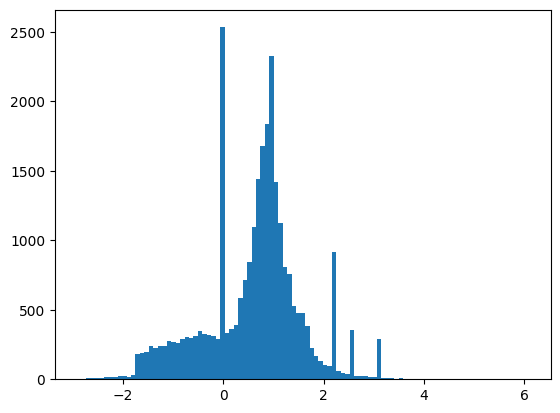

In [12]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

To keep this tutorial relatively short, use just the first 1,000 samples for validation, and the next 10,000 for training:

In [13]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

The `Dataset.skip` and `Dataset.take` methods make this easy.

At the same time, use the `Dataset.cache` method to ensure that the loader doesn't need to re-read the data from the file on each epoch:

In [14]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [15]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

These datasets return individual examples. Use the `Dataset.batch` method to create batches of an appropriate size for training. Before batching, also remember to use `Dataset.shuffle` and `Dataset.repeat` on the training set.

In [16]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

## Demonstrate overfitting

The simplest way to prevent overfitting is to start with a small model: A model with a small number of learnable parameters (which is determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is often referred to as the model's "capacity".

Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any generalization power, but this would be useless when making predictions on previously unseen data.

Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn the mapping as easily. To minimize its loss, it will have to learn compressed representations that have more predictive power. At the same time, if you make your model too small, it will have difficulty fitting to the training data. There is a balance between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine the right size or architecture of your model (in terms of the number of layers, or the right size for each layer). You will have to experiment using a series of different architectures.

To find an appropriate model size, it's best to start with relatively few layers and parameters, then begin increasing the size of the layers or adding new layers until you see diminishing returns on the validation loss.

Start with a simple model using only densely-connected layers (`tf.keras.layers.Dense`) as a baseline, then create larger models, and compare them.

### Training procedure

Many models train better if you gradually reduce the learning rate during training. Use `tf.keras.optimizers.schedules` to reduce the learning rate over time:

In [17]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

The code above sets a `tf.keras.optimizers.schedules.InverseTimeDecay` to hyperbolically decrease the learning rate to 1/2 of the base rate at 1,000 epochs, 1/3 at 2,000 epochs, and so on.

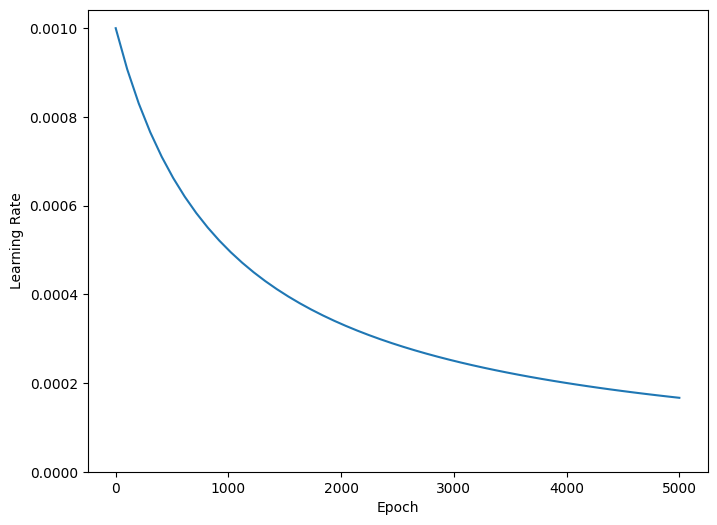

In [18]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')


Each model in this tutorial will use the same training configuration. So set these up in a reusable way, starting with the list of callbacks.

The training for this tutorial runs for many short epochs. To reduce the logging noise use the `tfdocs.EpochDots` which simply prints a `.` for each epoch, and a full set of metrics every 100 epochs.

Next include `tf.keras.callbacks.EarlyStopping` to avoid long and unnecessary training times. Note that this callback is set to monitor the `val_binary_crossentropy`, not the `val_loss`. This difference will be important later.

Use `callbacks.TensorBoard` to generate TensorBoard logs for the training.


In [19]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

Similarly each model will use the same `Model.compile` and `Model.fit` settings:

In [20]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.metrics.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

### Tiny model

Start by training a model:

In [21]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [22]:
size_histories = {}

In [23]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense (Dense)               (None, 16)                464       


 dense_1 (Dense)             (None, 1)                 17        


Total params: 481 (1.88 KB)


Trainable params: 481 (1.88 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.5014,  binary_crossentropy:0.9626,  loss:0.9626,  val_accuracy:0.4500,  val_binary_crossentropy:0.8596,  val_loss:0.8596,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.5892,  binary_crossentropy:0.6310,  loss:0.6310,  val_accuracy:0.5700,  val_binary_crossentropy:0.6320,  val_loss:0.6320,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6125,  binary_crossentropy:0.6167,  loss:0.6167,  val_accuracy:0.5950,  val_binary_crossentropy:0.6232,  val_loss:0.6232,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6322,  binary_crossentropy:0.6055,  loss:0.6055,  val_accuracy:0.6120,  val_binary_crossentropy:0.6101,  val_loss:0.6101,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6456,  binary_crossentropy:0.5974,  loss:0.5974,  val_accuracy:0.6400,  val_binary_crossentropy:0.6014,  val_loss:0.6014,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6578,  binary_crossentropy:0.5914,  loss:0.5914,  val_accuracy:0.6410,  val_binary_crossentropy:0.5964,  val_loss:0.5964,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 600, accuracy:0.6636,  binary_crossentropy:0.5879,  loss:0.5879,  val_accuracy:0.6480,  val_binary_crossentropy:0.5943,  val_loss:0.5943,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 700, accuracy:0.6625,  binary_crossentropy:0.5857,  loss:0.5857,  val_accuracy:0.6450,  val_binary_crossentropy:0.5923,  val_loss:0.5923,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 800, accuracy:0.6697,  binary_crossentropy:0.5828,  loss:0.5828,  val_accuracy:0.6540,  val_binary_crossentropy:0.5909,  val_loss:0.5909,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 900, accuracy:0.6719,  binary_crossentropy:0.5805,  loss:0.5805,  val_accuracy:0.6420,  val_binary_crossentropy:0.5912,  val_loss:0.5912,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1000, accuracy:0.6737,  binary_crossentropy:0.5783,  loss:0.5783,  val_accuracy:0.6540,  val_binary_crossentropy:0.5902,  val_loss:0.5902,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1100, accuracy:0.6757,  binary_crossentropy:0.5772,  loss:0.5772,  val_accuracy:0.6590,  val_binary_crossentropy:0.5890,  val_loss:0.5890,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1200, accuracy:0.6761,  binary_crossentropy:0.5755,  loss:0.5755,  val_accuracy:0.6570,  val_binary_crossentropy:0.5883,  val_loss:0.5883,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1300, accuracy:0.6767,  binary_crossentropy:0.5741,  loss:0.5741,  val_accuracy:0.6630,  val_binary_crossentropy:0.5881,  val_loss:0.5881,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1400, accuracy:0.6791,  binary_crossentropy:0.5729,  loss:0.5729,  val_accuracy:0.6590,  val_binary_crossentropy:0.5885,  val_loss:0.5885,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1500, accuracy:0.6779,  binary_crossentropy:0.5725,  loss:0.5725,  val_accuracy:0.6620,  val_binary_crossentropy:0.5878,  val_loss:0.5878,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1600, accuracy:0.6833,  binary_crossentropy:0.5708,  loss:0.5708,  val_accuracy:0.6520,  val_binary_crossentropy:0.5901,  val_loss:0.5901,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1700, accuracy:0.6822,  binary_crossentropy:0.5699,  loss:0.5699,  val_accuracy:0.6640,  val_binary_crossentropy:0.5870,  val_loss:0.5870,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 1800, accuracy:0.6837,  binary_crossentropy:0.5697,  loss:0.5697,  val_accuracy:0.6560,  val_binary_crossentropy:0.5890,  val_loss:0.5890,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

Now check how the model did:

(0.5, 0.7)

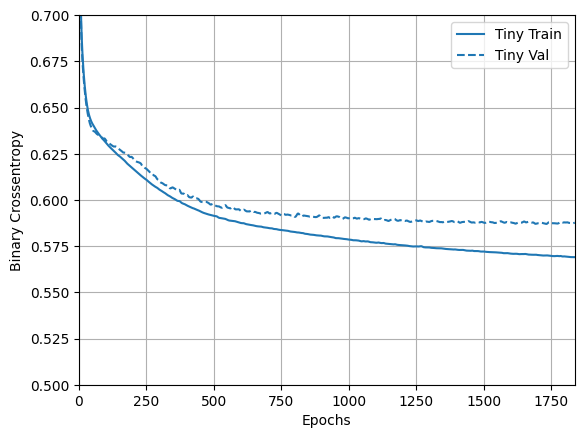

In [24]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

### Small model

To check if you can beat the performance of the small model, progressively train some larger models.

Try two hidden layers with 16 units each:

In [25]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [26]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_2 (Dense)             (None, 16)                464       


 dense_3 (Dense)             (None, 16)                272       


 dense_4 (Dense)             (None, 1)                 17        


Total params: 753 (2.94 KB)


Trainable params: 753 (2.94 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.4873,  binary_crossentropy:0.8026,  loss:0.8026,  val_accuracy:0.5000,  val_binary_crossentropy:0.7317,  val_loss:0.7317,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6385,  binary_crossentropy:0.6064,  loss:0.6064,  val_accuracy:0.6230,  val_binary_crossentropy:0.6026,  val_loss:0.6026,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6630,  binary_crossentropy:0.5894,  loss:0.5894,  val_accuracy:0.6500,  val_binary_crossentropy:0.5932,  val_loss:0.5932,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6751,  binary_crossentropy:0.5818,  loss:0.5818,  val_accuracy:0.6760,  val_binary_crossentropy:0.5882,  val_loss:0.5882,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6774,  binary_crossentropy:0.5737,  loss:0.5737,  val_accuracy:0.6680,  val_binary_crossentropy:0.5869,  val_loss:0.5869,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6797,  binary_crossentropy:0.5675,  loss:0.5675,  val_accuracy:0.6760,  val_binary_crossentropy:0.5865,  val_loss:0.5865,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 600, accuracy:0.6861,  binary_crossentropy:0.5627,  loss:0.5627,  val_accuracy:0.6660,  val_binary_crossentropy:0.5883,  val_loss:0.5883,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 700, accuracy:0.6933,  binary_crossentropy:0.5585,  loss:0.5585,  val_accuracy:0.6570,  val_binary_crossentropy:0.5941,  val_loss:0.5941,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

### Medium model

Now try three hidden layers with 64 units each:

In [27]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

And train the model using the same data:

In [28]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_5 (Dense)             (None, 64)                1856      


 dense_6 (Dense)             (None, 64)                4160      


 dense_7 (Dense)             (None, 64)                4160      


 dense_8 (Dense)             (None, 1)                 65        


Total params: 10241 (40.00 KB)


Trainable params: 10241 (40.00 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.4785,  binary_crossentropy:0.7169,  loss:0.7169,  val_accuracy:0.4630,  val_binary_crossentropy:0.6907,  val_loss:0.6907,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.7107,  binary_crossentropy:0.5324,  loss:0.5324,  val_accuracy:0.6630,  val_binary_crossentropy:0.5980,  val_loss:0.5980,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.7807,  binary_crossentropy:0.4344,  loss:0.4344,  val_accuracy:0.6480,  val_binary_crossentropy:0.6698,  val_loss:0.6698,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

### Large model

As an exercise, you can create an even larger model and check how quickly it begins overfitting. Next, add to this benchmark a network that has much more capacity, far more than the problem would warrant:

In [29]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

And, again, train the model using the same data:

In [30]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_9 (Dense)             (None, 512)               14848     


 dense_10 (Dense)            (None, 512)               262656    


 dense_11 (Dense)            (None, 512)               262656    


 dense_12 (Dense)            (None, 512)               262656    


 dense_13 (Dense)            (None, 1)                 513       


Total params: 803329 (3.06 MB)


Trainable params: 803329 (3.06 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.5106,  binary_crossentropy:0.8217,  loss:0.8217,  val_accuracy:0.5650,  val_binary_crossentropy:0.6928,  val_loss:0.6928,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:1.0000,  binary_crossentropy:0.0022,  loss:0.0022,  val_accuracy:0.6720,  val_binary_crossentropy:1.7581,  val_loss:1.7581,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:1.0000,  binary_crossentropy:0.0001,  loss:0.0001,  val_accuracy:0.6750,  val_binary_crossentropy:2.4364,  val_loss:2.4364,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

### Plot the training and validation losses

The solid lines show the training loss, and the dashed lines show the validation loss (remember: a lower validation loss indicates a better model).

While building a larger model gives it more power, if this power is not constrained somehow it can easily overfit to the training set.

In this example, typically, only the `"Tiny"` model manages to avoid overfitting altogether, and each of the larger models overfit the data more quickly. This becomes so severe for the `"large"` model that you need to switch the plot to a log-scale to really figure out what's happening.

This is apparent if you plot and compare the validation metrics to the training metrics.

* It's normal for there to be a small difference.
* If both metrics are moving in the same direction, everything is fine.
* If the validation metric begins to stagnate while the training metric continues to improve, you are probably close to overfitting.
* If the validation metric is going in the wrong direction, the model is clearly overfitting.

Text(0.5, 0, 'Epochs [Log Scale]')

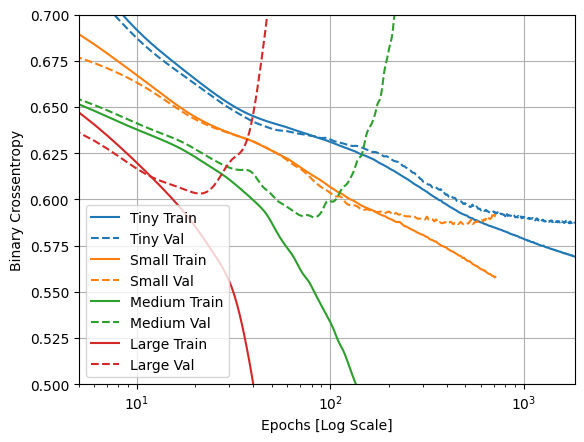

In [31]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

Note: All the above training runs used the `callbacks.EarlyStopping` to end the training once it was clear the model was not making progress.

### View in TensorBoard

These models all wrote TensorBoard logs during training.

Open an embedded  TensorBoard viewer inside a notebook (Sorry, this doesn't
display on tensorflow.org):

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

You can view the [results of a previous run](https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

## Strategies to prevent overfitting

Before getting into the content of this section copy the training logs from the `"Tiny"` model above, to use as a baseline for comparison.

In [32]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmpfs/tmp/tmpq4_b088s/tensorboard_logs/regularizers/Tiny')

In [33]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

### Add weight regularization


You may be familiar with Occam's Razor principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as demonstrated in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

* [L1 regularization](https://developers.google.com/machine-learning/glossary/#L1_regularization), where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

* [L2 regularization](https://developers.google.com/machine-learning/glossary/#L2_regularization), where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero, encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights—one reason why L2 is more common.

In `tf.keras`, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Add L2 weight regularization:

In [34]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_14 (Dense)            (None, 512)               14848     


 dense_15 (Dense)            (None, 512)               262656    


 dense_16 (Dense)            (None, 512)               262656    


 dense_17 (Dense)            (None, 512)               262656    


 dense_18 (Dense)            (None, 1)                 513       


Total params: 803329 (3.06 MB)


Trainable params: 803329 (3.06 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.5186,  binary_crossentropy:0.7897,  loss:2.3027,  val_accuracy:0.5220,  val_binary_crossentropy:0.6764,  val_loss:2.1070,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6535,  binary_crossentropy:0.5994,  loss:0.6211,  val_accuracy:0.5780,  val_binary_crossentropy:0.6027,  val_loss:0.6242,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6767,  binary_crossentropy:0.5848,  loss:0.6090,  val_accuracy:0.6810,  val_binary_crossentropy:0.5941,  val_loss:0.6185,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6886,  binary_crossentropy:0.5704,  loss:0.5962,  val_accuracy:0.6790,  val_binary_crossentropy:0.5820,  val_loss:0.6078,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6863,  binary_crossentropy:0.5684,  loss:0.5934,  val_accuracy:0.6840,  val_binary_crossentropy:0.5818,  val_loss:0.6069,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6972,  binary_crossentropy:0.5578,  loss:0.5837,  val_accuracy:0.6830,  val_binary_crossentropy:0.5827,  val_loss:0.6086,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 600, accuracy:0.7030,  binary_crossentropy:0.5504,  loss:0.5771,  val_accuracy:0.6710,  val_binary_crossentropy:0.5848,  val_loss:0.6113,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

`l2(0.001)` means that every coefficient in the weight matrix of the layer will add `0.001 * weight_coefficient_value**2` to the total **loss** of the network.

That is why we're monitoring the `binary_crossentropy` directly. Because it doesn't have this regularization component mixed in.

So, that same `"Large"` model with an `L2` regularization penalty performs much better:


(0.5, 0.7)

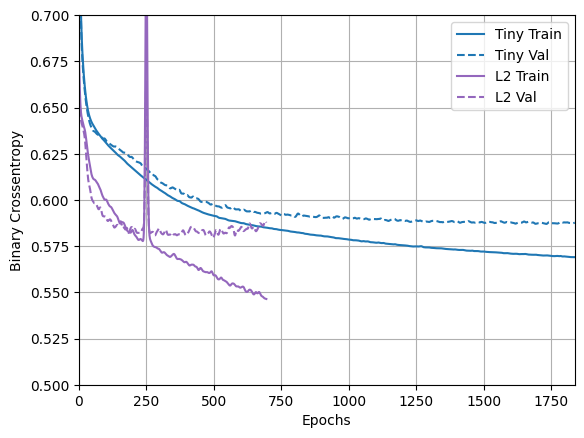

In [35]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

As demonstrated in the diagram above, the `"L2"` regularized model is now much more competitive with the `"Tiny"` model. This `"L2"` model is also much more resistant to overfitting than the `"Large"` model it was based on despite having the same number of parameters.

#### More info

There are two important things to note about this sort of regularization:

1. If you are writing your own training loop, then you need to be sure to ask the model for its regularization losses.

In [36]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

2. This implementation works by adding the weight penalties to the model's loss, and then applying a standard optimization procedure after that.

There is a second approach that instead only runs the optimizer on the raw loss, and then while applying the calculated step the optimizer also applies some weight decay. This "decoupled weight decay" is used in optimizers like `tf.keras.optimizers.Ftrl` and `tfa.optimizers.AdamW`.

### Add dropout

Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto.

The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. For example, a given layer would normally have returned a vector `[0.2, 0.5, 1.3, 0.8, 1.1]` for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. `[0, 0.5, 1.3, 0, 1.1]`.

The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In Keras, you can introduce dropout in a network via the `tf.keras.layers.Dropout` layer, which gets applied to the output of layer right before.

Add two dropout layers to your network to check how well they do at reducing overfitting:

In [37]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_19 (Dense)            (None, 512)               14848     


 dropout (Dropout)           (None, 512)               0         


 dense_20 (Dense)            (None, 512)               262656    


 dropout_1 (Dropout)         (None, 512)               0         


 dense_21 (Dense)            (None, 512)               262656    


 dropout_2 (Dropout)         (None, 512)               0         


 dense_22 (Dense)            (None, 512)               262656    


 dropout_3 (Dropout)         (None, 512)               0         


 dense_23 (Dense)            (None, 1)                 513       


Total params: 803329 (3.06 MB)


Trainable params: 803329 (3.06 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.4976,  binary_crossentropy:0.8126,  loss:0.8126,  val_accuracy:0.5260,  val_binary_crossentropy:0.6708,  val_loss:0.6708,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6673,  binary_crossentropy:0.5902,  loss:0.5902,  val_accuracy:0.6730,  val_binary_crossentropy:0.5751,  val_loss:0.5751,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6923,  binary_crossentropy:0.5561,  loss:0.5561,  val_accuracy:0.6570,  val_binary_crossentropy:0.5897,  val_loss:0.5897,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.7222,  binary_crossentropy:0.5078,  loss:0.5078,  val_accuracy:0.6760,  val_binary_crossentropy:0.6037,  val_loss:0.6037,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

(0.5, 0.7)

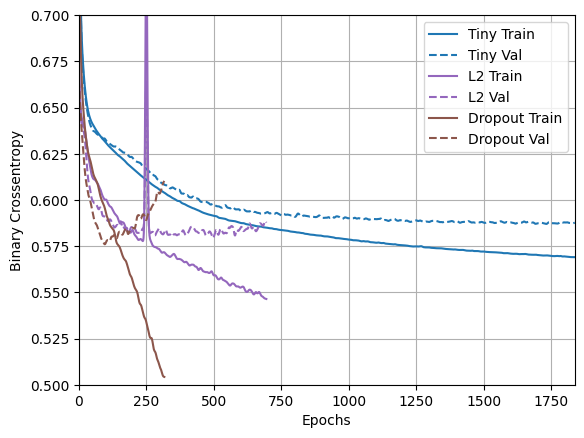

In [38]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

It's clear from this plot that both of these regularization approaches improve the behavior of the `"Large"` model. But this still doesn't beat even the `"Tiny"` baseline.

Next try them both, together, and see if that does better.

### Combined L2 + dropout

In [39]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_24 (Dense)            (None, 512)               14848     


 dropout_4 (Dropout)         (None, 512)               0         


 dense_25 (Dense)            (None, 512)               262656    


 dropout_5 (Dropout)         (None, 512)               0         


 dense_26 (Dense)            (None, 512)               262656    


 dropout_6 (Dropout)         (None, 512)               0         


 dense_27 (Dense)            (None, 512)               262656    


 dropout_7 (Dropout)         (None, 512)               0         


 dense_28 (Dense)            (None, 1)                 513       


Total params: 803329 (3.06 MB)


Trainable params: 803329 (3.06 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________



Epoch: 0, accuracy:0.5060,  binary_crossentropy:0.7953,  loss:0.9539,  val_accuracy:0.5170,  val_binary_crossentropy:0.6819,  val_loss:0.8398,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6454,  binary_crossentropy:0.6056,  loss:0.6356,  val_accuracy:0.6700,  val_binary_crossentropy:0.5803,  val_loss:0.6102,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6655,  binary_crossentropy:0.5850,  loss:0.6107,  val_accuracy:0.6860,  val_binary_crossentropy:0.5715,  val_loss:0.5972,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6705,  binary_crossentropy:0.5825,  loss:0.6107,  val_accuracy:0.6880,  val_binary_crossentropy:0.5639,  val_loss:0.5922,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6815,  binary_crossentropy:0.5749,  loss:0.6048,  val_accuracy:0.6890,  val_binary_crossentropy:0.5592,  val_loss:0.5892,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6807,  binary_crossentropy:0.5728,  loss:0.6046,  val_accuracy:0.6740,  val_binary_crossentropy:0.5581,  val_loss:0.5898,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 600, accuracy:0.6799,  binary_crossentropy:0.5685,  loss:0.6020,  val_accuracy:0.6990,  val_binary_crossentropy:0.5513,  val_loss:0.5848,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 700, accuracy:0.6885,  binary_crossentropy:0.5611,  loss:0.5970,  val_accuracy:0.6960,  val_binary_crossentropy:0.5440,  val_loss:0.5799,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 800, accuracy:0.6909,  binary_crossentropy:0.5575,  loss:0.5948,  val_accuracy:0.6860,  val_binary_crossentropy:0.5461,  val_loss:0.5834,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

(0.5, 0.7)

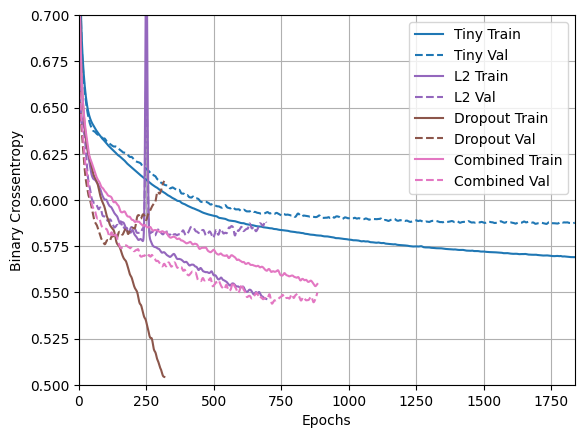

In [40]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

This model with the `"Combined"` regularization is obviously the best one so far.

### View in TensorBoard

These models also recorded TensorBoard logs.

To open an embedded run the following into a code-cell  (Sorry, this doesn't display on tensorflow.org):

In [ ]:
%tensorboard --logdir {logdir}/regularizers

You can view the [results of a previous run](https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

## Conclusions

To recap, here are the most common ways to prevent overfitting in neural networks:

* Get more training data.
* Reduce the capacity of the network.
* Add weight regularization.
* Add dropout.

Two important approaches not covered in this guide are:

* [Data augmentation](../images/data_augmentation.ipynb)
* Batch normalization (`tf.keras.layers.BatchNormalization`)

Remember that each method can help on its own, but often combining them can be even more effective.